## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

LABELS = [    
    "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
    "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
    "barang_NE", "barang_NW", "barang_SE", "barang_SW"
] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/NewGenAugment/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1 # 32 timesteps per series

# n_steps = 5 # 32 timesteps per series
n_steps = 8 # 32 timesteps per series

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 34 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(15308, 8, 36) (1529, 1) 296.29324 258.73508

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'out': <tf.Variable 'Variable_4:0' shape=(12,) dtype=float32_ref>, 'hidden': <tf.Variable 'Variable_3:0' shape=(34,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 34) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [13]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [14]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.004424:   Batch Loss = 1.683274, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6603363752365112, Accuracy = 0.457815557718277
Iter #512:  Learning rate = 0.004424:   Batch Loss = 1.587611, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6435949802398682, Accuracy = 0.46435579657554626
Iter #1024:  Learning rate = 0.004424:   Batch Loss = 1.682754, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6269199848175049, Accuracy = 0.46697187423706055
Iter #1536:  Learning rate = 0.004424:   Batch Loss = 1.527638, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5994935035705566, Accuracy = 0.4918247163295746
Iter #2048:  Learning rate = 0.004424:   Batch Loss = 1.566792, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6114012002944946, Accuracy = 0.4761281907558441
Iter #2560:  Learning rate = 0.004424:   Batch Loss = 1.576122, Accuracy = 0.5625
PERF

PERFORMANCE ON TEST SET:             Batch Loss = 1.585851788520813, Accuracy = 0.4715500473976135
Iter #23552:  Learning rate = 0.004424:   Batch Loss = 1.631029, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5771546363830566, Accuracy = 0.4898626506328583
Iter #24064:  Learning rate = 0.004424:   Batch Loss = 1.709695, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5728784799575806, Accuracy = 0.4931327700614929
Iter #24576:  Learning rate = 0.004424:   Batch Loss = 1.475591, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5701488256454468, Accuracy = 0.48855459690093994
Iter #25088:  Learning rate = 0.004424:   Batch Loss = 1.539712, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.569150686264038, Accuracy = 0.5035971403121948
Iter #25600:  Learning rate = 0.004424:   Batch Loss = 1.748828, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6730114221572876, Accuracy = 0.

Iter #46080:  Learning rate = 0.004247:   Batch Loss = 1.527386, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5857012271881104, Accuracy = 0.4787442684173584
Iter #46592:  Learning rate = 0.004247:   Batch Loss = 1.574646, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5597819089889526, Accuracy = 0.48136037588119507
Iter #47104:  Learning rate = 0.004247:   Batch Loss = 1.684508, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5990736484527588, Accuracy = 0.4741661250591278
Iter #47616:  Learning rate = 0.004247:   Batch Loss = 1.619948, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.547006607055664, Accuracy = 0.49051669239997864
Iter #48128:  Learning rate = 0.004247:   Batch Loss = 1.600631, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5512282848358154, Accuracy = 0.49444082379341125
Iter #48640:  Learning rate = 0.004247:   Batch Loss = 1.546841, Accuracy = 0.5

PERFORMANCE ON TEST SET:             Batch Loss = 1.7621619701385498, Accuracy = 0.40941792726516724
Iter #69632:  Learning rate = 0.004247:   Batch Loss = 1.695569, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.693096399307251, Accuracy = 0.43034663796424866
Iter #70144:  Learning rate = 0.004247:   Batch Loss = 1.565228, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6782736778259277, Accuracy = 0.4525834023952484
Iter #70656:  Learning rate = 0.004247:   Batch Loss = 1.620362, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6636894941329956, Accuracy = 0.4525834023952484
Iter #71168:  Learning rate = 0.004247:   Batch Loss = 1.672014, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6637775897979736, Accuracy = 0.45650753378868103
Iter #71680:  Learning rate = 0.004247:   Batch Loss = 1.638043, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.736407995223999, Accuracy = 0.4

PERFORMANCE ON TEST SET:             Batch Loss = 1.5474756956100464, Accuracy = 0.4931327700614929
Iter #92160:  Learning rate = 0.004247:   Batch Loss = 1.664261, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5552531480789185, Accuracy = 0.4996729791164398
Iter #92672:  Learning rate = 0.004247:   Batch Loss = 1.635269, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6003286838531494, Accuracy = 0.4761281907558441
Iter #93184:  Learning rate = 0.004247:   Batch Loss = 1.468951, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.578192949295044, Accuracy = 0.48397645354270935
Iter #93696:  Learning rate = 0.004247:   Batch Loss = 1.618920, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5522472858428955, Accuracy = 0.48855459690093994
Iter #94208:  Learning rate = 0.004247:   Batch Loss = 1.484409, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5412756204605103, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 1.9761134386062622, Accuracy = 0.3904512822628021
Iter #114688:  Learning rate = 0.004247:   Batch Loss = 2.091102, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9502029418945312, Accuracy = 0.3799869120121002
Iter #115200:  Learning rate = 0.004247:   Batch Loss = 1.793803, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8582000732421875, Accuracy = 0.3865271508693695
Iter #115712:  Learning rate = 0.004247:   Batch Loss = 1.595253, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7352044582366943, Accuracy = 0.43034663796424866
Iter #116224:  Learning rate = 0.004247:   Batch Loss = 1.570029, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6527680158615112, Accuracy = 0.45650753378868103
Iter #116736:  Learning rate = 0.004247:   Batch Loss = 1.504240, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6578463315963745, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.8377102613449097, Accuracy = 0.36232832074165344
Iter #137216:  Learning rate = 0.004077:   Batch Loss = 1.881386, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7713541984558105, Accuracy = 0.4054937958717346
Iter #137728:  Learning rate = 0.004077:   Batch Loss = 2.030124, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6661978960037231, Accuracy = 0.4257684648036957
Iter #138240:  Learning rate = 0.004077:   Batch Loss = 1.597423, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6244020462036133, Accuracy = 0.4460431635379791
Iter #138752:  Learning rate = 0.004077:   Batch Loss = 1.630915, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.623598575592041, Accuracy = 0.4460431635379791
Iter #139264:  Learning rate = 0.004077:   Batch Loss = 1.749661, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.617456078529358, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.608191967010498, Accuracy = 0.4512753486633301
Iter #160256:  Learning rate = 0.004077:   Batch Loss = 1.644979, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6048486232757568, Accuracy = 0.4532374143600464
Iter #160768:  Learning rate = 0.004077:   Batch Loss = 1.656216, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6139065027236938, Accuracy = 0.45585349202156067
Iter #161280:  Learning rate = 0.004077:   Batch Loss = 1.532902, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6446244716644287, Accuracy = 0.4421190321445465
Iter #161792:  Learning rate = 0.004077:   Batch Loss = 1.663266, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6328716278076172, Accuracy = 0.4617396891117096
Iter #162304:  Learning rate = 0.004077:   Batch Loss = 1.612826, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6065813302993774, Accurac

Iter #182784:  Learning rate = 0.004077:   Batch Loss = 1.593652, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.584147572517395, Accuracy = 0.4486592411994934
Iter #183296:  Learning rate = 0.004077:   Batch Loss = 1.474320, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.596413493156433, Accuracy = 0.4408109784126282
Iter #183808:  Learning rate = 0.004077:   Batch Loss = 1.634544, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.594780445098877, Accuracy = 0.4486592411994934
Iter #184320:  Learning rate = 0.004077:   Batch Loss = 1.583937, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5975836515426636, Accuracy = 0.4512753486633301
Iter #184832:  Learning rate = 0.004077:   Batch Loss = 1.538424, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5950261354446411, Accuracy = 0.43100064992904663
Iter #185344:  Learning rate = 0.004077:   Batch Loss = 1.513267, Accuracy = 0

Iter #205824:  Learning rate = 0.004077:   Batch Loss = 1.830121, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7115979194641113, Accuracy = 0.44735121726989746
Iter #206336:  Learning rate = 0.004077:   Batch Loss = 1.504264, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.650399923324585, Accuracy = 0.43688684701919556
Iter #206848:  Learning rate = 0.004077:   Batch Loss = 1.602117, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6364504098892212, Accuracy = 0.43884891271591187
Iter #207360:  Learning rate = 0.004077:   Batch Loss = 1.633860, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6170668601989746, Accuracy = 0.43100064992904663
Iter #207872:  Learning rate = 0.004077:   Batch Loss = 1.718178, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6520826816558838, Accuracy = 0.4447351098060608
Iter #208384:  Learning rate = 0.004077:   Batch Loss = 1.684122, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.9986951351165771, Accuracy = 0.35775017738342285
Iter #229376:  Learning rate = 0.004077:   Batch Loss = 2.016207, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9998027086257935, Accuracy = 0.35578811168670654
Iter #229888:  Learning rate = 0.004077:   Batch Loss = 2.072652, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9813261032104492, Accuracy = 0.34728580713272095
Iter #230400:  Learning rate = 0.003914:   Batch Loss = 1.894329, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.958512306213379, Accuracy = 0.35186395049095154
Iter #230912:  Learning rate = 0.003914:   Batch Loss = 1.956161, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9198427200317383, Accuracy = 0.36167430877685547
Iter #231424:  Learning rate = 0.003914:   Batch Loss = 2.092122, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9324434995651245, A

Iter #252416:  Learning rate = 0.003914:   Batch Loss = 1.841171, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7629640102386475, Accuracy = 0.4342707693576813
Iter #252928:  Learning rate = 0.003914:   Batch Loss = 1.727534, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7591900825500488, Accuracy = 0.4035317301750183
Iter #253440:  Learning rate = 0.003914:   Batch Loss = 1.580587, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.728156328201294, Accuracy = 0.4126880168914795
Iter #253952:  Learning rate = 0.003914:   Batch Loss = 1.651407, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.733802080154419, Accuracy = 0.427076518535614
Iter #254464:  Learning rate = 0.003914:   Batch Loss = 1.620750, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6381912231445312, Accuracy = 0.4375408887863159
Iter #254976:  Learning rate = 0.003914:   Batch Loss = 1.514196, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 1.5622397661209106, Accuracy = 0.4525834023952484
Iter #275456:  Learning rate = 0.003914:   Batch Loss = 1.510072, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5748811960220337, Accuracy = 0.4466971755027771
Iter #275968:  Learning rate = 0.003914:   Batch Loss = 1.521174, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5311084985733032, Accuracy = 0.46500980854034424
Iter #276480:  Learning rate = 0.003914:   Batch Loss = 1.557590, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5616259574890137, Accuracy = 0.4591236114501953
Iter #276992:  Learning rate = 0.003914:   Batch Loss = 1.585127, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.541178822517395, Accuracy = 0.47939831018447876
Iter #277504:  Learning rate = 0.003914:   Batch Loss = 1.526131, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5488860607147217, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.5916974544525146, Accuracy = 0.45585349202156067
Iter #298496:  Learning rate = 0.003914:   Batch Loss = 1.667452, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5660295486450195, Accuracy = 0.47089600563049316
Iter #299008:  Learning rate = 0.003914:   Batch Loss = 1.515226, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5833308696746826, Accuracy = 0.44800522923469543
Iter #299520:  Learning rate = 0.003914:   Batch Loss = 1.418958, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5531779527664185, Accuracy = 0.4761281907558441
Iter #300032:  Learning rate = 0.003914:   Batch Loss = 1.603284, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6842713356018066, Accuracy = 0.4257684648036957
Iter #300544:  Learning rate = 0.003914:   Batch Loss = 1.668158, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6990128755569458

Iter #321536:  Learning rate = 0.003914:   Batch Loss = 1.637815, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5641379356384277, Accuracy = 0.47743624448776245
Iter #322048:  Learning rate = 0.003914:   Batch Loss = 1.468758, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5783991813659668, Accuracy = 0.45192936062812805
Iter #322560:  Learning rate = 0.003914:   Batch Loss = 1.651431, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5422499179840088, Accuracy = 0.47743624448776245
Iter #323072:  Learning rate = 0.003914:   Batch Loss = 1.605607, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5502631664276123, Accuracy = 0.4748201370239258
Iter #323584:  Learning rate = 0.003914:   Batch Loss = 1.543350, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5403614044189453, Accuracy = 0.4676258862018585
Iter #324096:  Learning rate = 0.003914:   Batch Loss = 1.505069, Accu

Iter #344576:  Learning rate = 0.003757:   Batch Loss = 1.619007, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6466854810714722, Accuracy = 0.4532374143600464
Iter #345088:  Learning rate = 0.003757:   Batch Loss = 1.511471, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6161623001098633, Accuracy = 0.4506213068962097
Iter #345600:  Learning rate = 0.003757:   Batch Loss = 1.658487, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5959800481796265, Accuracy = 0.4591236114501953
Iter #346112:  Learning rate = 0.003757:   Batch Loss = 1.519835, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6134663820266724, Accuracy = 0.45192936062812805
Iter #346624:  Learning rate = 0.003757:   Batch Loss = 1.637077, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6067441701889038, Accuracy = 0.4440810978412628
Iter #347136:  Learning rate = 0.003757:   Batch Loss = 1.518188, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.482970952987671, Accuracy = 0.47351211309432983
Iter #367616:  Learning rate = 0.003757:   Batch Loss = 1.486984, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.471651315689087, Accuracy = 0.4846304655075073
Iter #368128:  Learning rate = 0.003757:   Batch Loss = 1.466457, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.471567153930664, Accuracy = 0.47743624448776245
Iter #368640:  Learning rate = 0.003757:   Batch Loss = 1.448964, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4626926183700562, Accuracy = 0.482668399810791
Iter #369152:  Learning rate = 0.003757:   Batch Loss = 1.283897, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4841915369033813, Accuracy = 0.4807063341140747
Iter #369664:  Learning rate = 0.003757:   Batch Loss = 1.331746, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4650537967681885, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.526296854019165, Accuracy = 0.45389142632484436
Iter #390144:  Learning rate = 0.003757:   Batch Loss = 1.504761, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6327712535858154, Accuracy = 0.4192282557487488
Iter #390656:  Learning rate = 0.003757:   Batch Loss = 1.733929, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5889959335327148, Accuracy = 0.46304774284362793
Iter #391168:  Learning rate = 0.003757:   Batch Loss = 1.490661, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5141966342926025, Accuracy = 0.487246572971344
Iter #391680:  Learning rate = 0.003757:   Batch Loss = 1.528151, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4868390560150146, Accuracy = 0.47743624448776245
Iter #392192:  Learning rate = 0.003757:   Batch Loss = 1.372981, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4743070602416992, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.576395869255066, Accuracy = 0.4401569664478302
Iter #413184:  Learning rate = 0.003757:   Batch Loss = 1.397829, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.565184235572815, Accuracy = 0.457815557718277
Iter #413696:  Learning rate = 0.003757:   Batch Loss = 1.624936, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5843510627746582, Accuracy = 0.4355788230895996
Iter #414208:  Learning rate = 0.003757:   Batch Loss = 1.521141, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6173365116119385, Accuracy = 0.43492478132247925
Iter #414720:  Learning rate = 0.003757:   Batch Loss = 1.743464, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6836681365966797, Accuracy = 0.42838457226753235
Iter #415232:  Learning rate = 0.003757:   Batch Loss = 1.573017, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6333473920822144, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.4648035764694214, Accuracy = 0.482668399810791
Iter #435712:  Learning rate = 0.003607:   Batch Loss = 1.382315, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.453142523765564, Accuracy = 0.4833224415779114
Iter #436224:  Learning rate = 0.003607:   Batch Loss = 1.557527, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4649578332901, Accuracy = 0.47547417879104614
Iter #436736:  Learning rate = 0.003607:   Batch Loss = 1.298697, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.46206796169281, Accuracy = 0.4898626506328583
Iter #437248:  Learning rate = 0.003607:   Batch Loss = 1.647795, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4585511684417725, Accuracy = 0.49705690145492554
Iter #437760:  Learning rate = 0.003607:   Batch Loss = 1.442322, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4712176322937012, Accuracy = 0.4813603

PERFORMANCE ON TEST SET:             Batch Loss = 1.4599583148956299, Accuracy = 0.4892086386680603
Iter #458752:  Learning rate = 0.003607:   Batch Loss = 1.484958, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4713016748428345, Accuracy = 0.4780902564525604
Iter #459264:  Learning rate = 0.003607:   Batch Loss = 1.590039, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5636998414993286, Accuracy = 0.4682799279689789
Iter #459776:  Learning rate = 0.003607:   Batch Loss = 1.486824, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6137020587921143, Accuracy = 0.45650753378868103
Iter #460288:  Learning rate = 0.003607:   Batch Loss = 1.589873, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5815166234970093, Accuracy = 0.4551994800567627
Iter #460800:  Learning rate = 0.003607:   Batch Loss = 1.573544, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.532923936843872, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.4575724601745605, Accuracy = 0.47939831018447876
Iter #481792:  Learning rate = 0.003607:   Batch Loss = 1.641193, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.455552339553833, Accuracy = 0.4702419936656952
Iter #482304:  Learning rate = 0.003607:   Batch Loss = 1.470804, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4181480407714844, Accuracy = 0.4957488477230072
Iter #482816:  Learning rate = 0.003607:   Batch Loss = 1.282723, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4155077934265137, Accuracy = 0.49051669239997864
Iter #483328:  Learning rate = 0.003607:   Batch Loss = 1.454651, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4102550745010376, Accuracy = 0.5022890567779541
Iter #483840:  Learning rate = 0.003607:   Batch Loss = 1.470991, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4261771440505981, Accu

Iter #504320:  Learning rate = 0.003607:   Batch Loss = 1.529153, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5054817199707031, Accuracy = 0.4591236114501953
Iter #504832:  Learning rate = 0.003607:   Batch Loss = 1.262840, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4661732912063599, Accuracy = 0.482668399810791
Iter #505344:  Learning rate = 0.003607:   Batch Loss = 1.498071, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4504038095474243, Accuracy = 0.48201438784599304
Iter #505856:  Learning rate = 0.003607:   Batch Loss = 1.397413, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4485132694244385, Accuracy = 0.4898626506328583
Iter #506368:  Learning rate = 0.003607:   Batch Loss = 1.441767, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4783588647842407, Accuracy = 0.48397645354270935
Iter #506880:  Learning rate = 0.003607:   Batch Loss = 1.619907, Accur

Iter #527360:  Learning rate = 0.003607:   Batch Loss = 1.772112, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6491445302963257, Accuracy = 0.41792020201683044
Iter #527872:  Learning rate = 0.003607:   Batch Loss = 1.486331, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5594332218170166, Accuracy = 0.4682799279689789
Iter #528384:  Learning rate = 0.003607:   Batch Loss = 1.437796, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5256378650665283, Accuracy = 0.4676258862018585
Iter #528896:  Learning rate = 0.003607:   Batch Loss = 1.435684, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4720546007156372, Accuracy = 0.4977109134197235
Iter #529408:  Learning rate = 0.003607:   Batch Loss = 1.416073, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4549028873443604, Accuracy = 0.4911707043647766
Iter #529920:  Learning rate = 0.003607:   Batch Loss = 1.414635, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 1.427026629447937, Accuracy = 0.48397645354270935
Iter #550400:  Learning rate = 0.003463:   Batch Loss = 1.404037, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4065130949020386, Accuracy = 0.4918247163295746
Iter #550912:  Learning rate = 0.003463:   Batch Loss = 1.403467, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4017010927200317, Accuracy = 0.5016350746154785
Iter #551424:  Learning rate = 0.003463:   Batch Loss = 1.532179, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4180816411972046, Accuracy = 0.5075212717056274
Iter #551936:  Learning rate = 0.003463:   Batch Loss = 1.411069, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4441546201705933, Accuracy = 0.49444082379341125
Iter #552448:  Learning rate = 0.003463:   Batch Loss = 1.546497, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4308041334152222,

Iter #572928:  Learning rate = 0.003463:   Batch Loss = 1.546242, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.445246696472168, Accuracy = 0.4918247163295746
Iter #573440:  Learning rate = 0.003463:   Batch Loss = 1.422325, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4106916189193726, Accuracy = 0.5075212717056274
Iter #573952:  Learning rate = 0.003463:   Batch Loss = 1.355765, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4230502843856812, Accuracy = 0.482668399810791
Iter #574464:  Learning rate = 0.003463:   Batch Loss = 1.379987, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.412665605545044, Accuracy = 0.4937867820262909
Iter #574976:  Learning rate = 0.003463:   Batch Loss = 1.436706, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4183495044708252, Accuracy = 0.48790058493614197
Iter #575488:  Learning rate = 0.003463:   Batch Loss = 1.404388, Accuracy = 0.56

Iter #596480:  Learning rate = 0.003463:   Batch Loss = 1.550115, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4778276681900024, Accuracy = 0.48397645354270935
Iter #596992:  Learning rate = 0.003463:   Batch Loss = 1.686141, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.598128080368042, Accuracy = 0.45192936062812805
Iter #597504:  Learning rate = 0.003463:   Batch Loss = 1.811146, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5376462936401367, Accuracy = 0.46304774284362793
Iter #598016:  Learning rate = 0.003463:   Batch Loss = 1.379126, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5079436302185059, Accuracy = 0.47089600563049316
Iter #598528:  Learning rate = 0.003463:   Batch Loss = 1.636875, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.538533091545105, Accuracy = 0.4532374143600464
Iter #599040:  Learning rate = 0.003463:   Batch Loss = 1.495522, Accuracy = 0.4

PERFORMANCE ON TEST SET:             Batch Loss = 1.4769986867904663, Accuracy = 0.48659253120422363
Iter #619520:  Learning rate = 0.003463:   Batch Loss = 1.522595, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4727369546890259, Accuracy = 0.48201438784599304
Iter #620032:  Learning rate = 0.003463:   Batch Loss = 1.623170, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4773770570755005, Accuracy = 0.4931327700614929
Iter #620544:  Learning rate = 0.003463:   Batch Loss = 1.461383, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4658501148223877, Accuracy = 0.46958795189857483
Iter #621056:  Learning rate = 0.003463:   Batch Loss = 1.332356, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4460973739624023, Accuracy = 0.48201438784599304
Iter #621568:  Learning rate = 0.003463:   Batch Loss = 1.676219, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.456204891204834, A

Iter #642048:  Learning rate = 0.003324:   Batch Loss = 1.593382, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5599757432937622, Accuracy = 0.44931328296661377
Iter #642560:  Learning rate = 0.003324:   Batch Loss = 1.583902, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5556141138076782, Accuracy = 0.457815557718277
Iter #643072:  Learning rate = 0.003324:   Batch Loss = 1.500026, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5363816022872925, Accuracy = 0.4715500473976135
Iter #643584:  Learning rate = 0.003324:   Batch Loss = 1.718599, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5304161310195923, Accuracy = 0.47743624448776245
Iter #644096:  Learning rate = 0.003324:   Batch Loss = 1.439279, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5286418199539185, Accuracy = 0.4728580713272095
Iter #644608:  Learning rate = 0.003324:   Batch Loss = 1.560006, Accuracy = 0.5
P

PERFORMANCE ON TEST SET:             Batch Loss = 1.366506814956665, Accuracy = 0.5003269910812378
Iter #665600:  Learning rate = 0.003324:   Batch Loss = 1.443338, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.358237385749817, Accuracy = 0.5101373195648193
Iter #666112:  Learning rate = 0.003324:   Batch Loss = 1.340644, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3649654388427734, Accuracy = 0.5134074687957764
Iter #666624:  Learning rate = 0.003324:   Batch Loss = 1.288237, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3547906875610352, Accuracy = 0.5166775584220886
Iter #667136:  Learning rate = 0.003324:   Batch Loss = 1.312270, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.355617642402649, Accuracy = 0.5088292956352234
Iter #667648:  Learning rate = 0.003324:   Batch Loss = 1.353013, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.357895016670227, Accuracy =

Iter #688640:  Learning rate = 0.003324:   Batch Loss = 1.364771, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.328827977180481, Accuracy = 0.5284499526023865
Iter #689152:  Learning rate = 0.003324:   Batch Loss = 1.290784, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3962935209274292, Accuracy = 0.4957488477230072
Iter #689664:  Learning rate = 0.003324:   Batch Loss = 1.488257, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3634928464889526, Accuracy = 0.5068672299385071
Iter #690176:  Learning rate = 0.003324:   Batch Loss = 1.471716, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4015107154846191, Accuracy = 0.49444082379341125
Iter #690688:  Learning rate = 0.003324:   Batch Loss = 1.325040, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3631093502044678, Accuracy = 0.5199477076530457
Iter #691200:  Learning rate = 0.003324:   Batch Loss = 1.247251, Accuracy = 0

Iter #711168:  Learning rate = 0.003324:   Batch Loss = 1.358136, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5286532640457153, Accuracy = 0.45650753378868103
Iter #711680:  Learning rate = 0.003324:   Batch Loss = 1.614448, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5346945524215698, Accuracy = 0.47089600563049316
Iter #712192:  Learning rate = 0.003324:   Batch Loss = 1.576859, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4827494621276855, Accuracy = 0.4898626506328583
Iter #712704:  Learning rate = 0.003324:   Batch Loss = 1.528581, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.464102864265442, Accuracy = 0.4957488477230072
Iter #713216:  Learning rate = 0.003324:   Batch Loss = 1.544816, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4555048942565918, Accuracy = 0.5186396241188049
Iter #713728:  Learning rate = 0.003324:   Batch Loss = 1.288126, Accuracy = 0.546

Iter #733696:  Learning rate = 0.003191:   Batch Loss = 1.608633, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.463829517364502, Accuracy = 0.5068672299385071
Iter #734208:  Learning rate = 0.003191:   Batch Loss = 1.300380, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4269475936889648, Accuracy = 0.5153695344924927
Iter #734720:  Learning rate = 0.003191:   Batch Loss = 1.521317, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4080969095230103, Accuracy = 0.5107913613319397
Iter #735232:  Learning rate = 0.003191:   Batch Loss = 1.399743, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3983210325241089, Accuracy = 0.5153695344924927
Iter #735744:  Learning rate = 0.003191:   Batch Loss = 1.427411, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4168380498886108, Accuracy = 0.5094833374023438
Iter #736256:  Learning rate = 0.003191:   Batch Loss = 1.570018, Accurac

Iter #757248:  Learning rate = 0.003191:   Batch Loss = 1.587076, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3304014205932617, Accuracy = 0.5323740839958191
Iter #757760:  Learning rate = 0.003191:   Batch Loss = 1.406520, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3950759172439575, Accuracy = 0.514061450958252
Iter #758272:  Learning rate = 0.003191:   Batch Loss = 1.573315, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.37250554561615, Accuracy = 0.5284499526023865
Iter #758784:  Learning rate = 0.003191:   Batch Loss = 1.384225, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4315739870071411, Accuracy = 0.5179855823516846
Iter #759296:  Learning rate = 0.003191:   Batch Loss = 1.574387, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4643809795379639, Accuracy = 0.4931327700614929
Iter #759808:  Learning rate = 0.003191:   Batch Loss = 1.574243, Accuracy = 0.48

PERFORMANCE ON TEST SET:             Batch Loss = 1.4261502027511597, Accuracy = 0.5035971403121948
Iter #780800:  Learning rate = 0.003191:   Batch Loss = 1.534382, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.441752552986145, Accuracy = 0.4931327700614929
Iter #781312:  Learning rate = 0.003191:   Batch Loss = 1.353797, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4485348463058472, Accuracy = 0.4918247163295746
Iter #781824:  Learning rate = 0.003191:   Batch Loss = 1.468147, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4521024227142334, Accuracy = 0.487246572971344
Iter #782336:  Learning rate = 0.003191:   Batch Loss = 1.492377, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4436709880828857, Accuracy = 0.4807063341140747
Iter #782848:  Learning rate = 0.003191:   Batch Loss = 1.447649, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4200581312179565, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.4268704652786255, Accuracy = 0.5009810328483582
Iter #803840:  Learning rate = 0.003191:   Batch Loss = 1.280306, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4454905986785889, Accuracy = 0.4852845072746277
Iter #804352:  Learning rate = 0.003191:   Batch Loss = 1.615950, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4899921417236328, Accuracy = 0.4532374143600464
Iter #804864:  Learning rate = 0.003191:   Batch Loss = 1.338580, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.48493492603302, Accuracy = 0.46304774284362793
Iter #805376:  Learning rate = 0.003191:   Batch Loss = 1.444464, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4972046613693237, Accuracy = 0.44800522923469543
Iter #805888:  Learning rate = 0.003191:   Batch Loss = 1.431881, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.46613609790802, Accu

Iter #826880:  Learning rate = 0.003191:   Batch Loss = 1.170209, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3920869827270508, Accuracy = 0.5068672299385071
Iter #827392:  Learning rate = 0.003191:   Batch Loss = 1.447447, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4554797410964966, Accuracy = 0.48659253120422363
Iter #827904:  Learning rate = 0.003191:   Batch Loss = 1.466925, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.405443549156189, Accuracy = 0.5310660600662231
Iter #828416:  Learning rate = 0.003191:   Batch Loss = 1.563494, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3759887218475342, Accuracy = 0.5336821675300598
Iter #828928:  Learning rate = 0.003191:   Batch Loss = 1.448817, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.381470799446106, Accuracy = 0.521909773349762
Iter #829440:  Learning rate = 0.003191:   Batch Loss = 1.315224, Accurac

Iter #850432:  Learning rate = 0.003064:   Batch Loss = 1.260965, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.392781138420105, Accuracy = 0.5192936658859253
Iter #850944:  Learning rate = 0.003064:   Batch Loss = 1.458129, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.383561372756958, Accuracy = 0.5003269910812378
Iter #851456:  Learning rate = 0.003064:   Batch Loss = 1.457760, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3769116401672363, Accuracy = 0.512753427028656
Iter #851968:  Learning rate = 0.003064:   Batch Loss = 1.352262, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.356675148010254, Accuracy = 0.5238718390464783
Iter #852480:  Learning rate = 0.003064:   Batch Loss = 1.646142, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8444937467575073, Accuracy = 0.3158927261829376
Iter #852992:  Learning rate = 0.003064:   Batch Loss = 1.523904, Accuracy = 0.46875

Iter #873984:  Learning rate = 0.003064:   Batch Loss = 1.429154, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4035791158676147, Accuracy = 0.5049051642417908
Iter #874496:  Learning rate = 0.003064:   Batch Loss = 1.290197, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3761370182037354, Accuracy = 0.5147154927253723
Iter #875008:  Learning rate = 0.003064:   Batch Loss = 1.377321, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.372220516204834, Accuracy = 0.5094833374023438
Iter #875520:  Learning rate = 0.003064:   Batch Loss = 1.205080, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3500977754592896, Accuracy = 0.521909773349762
Iter #876032:  Learning rate = 0.003064:   Batch Loss = 1.474856, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3464367389678955, Accuracy = 0.5376062989234924
Iter #876544:  Learning rate = 0.003064:   Batch Loss = 1.503224, Accuracy = 0.4

Iter #897536:  Learning rate = 0.003064:   Batch Loss = 1.302538, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3277063369750977, Accuracy = 0.542838454246521
Iter #898048:  Learning rate = 0.003064:   Batch Loss = 1.214262, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.318294644355774, Accuracy = 0.5402223467826843
Iter #898560:  Learning rate = 0.003064:   Batch Loss = 1.341590, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3300628662109375, Accuracy = 0.5402223467826843
Iter #899072:  Learning rate = 0.003064:   Batch Loss = 1.562834, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3485277891159058, Accuracy = 0.5166775584220886
Iter #899584:  Learning rate = 0.003064:   Batch Loss = 1.594564, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3111956119537354, Accuracy = 0.5546108484268188
Iter #900096:  Learning rate = 0.003064:   Batch Loss = 1.428509, Accuracy

Iter #921088:  Learning rate = 0.003064:   Batch Loss = 1.548486, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.410766839981079, Accuracy = 0.48005232214927673
Iter #921600:  Learning rate = 0.003064:   Batch Loss = 1.327548, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3949413299560547, Accuracy = 0.49051669239997864
Iter #922112:  Learning rate = 0.003064:   Batch Loss = 1.240346, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3600211143493652, Accuracy = 0.5258339047431946
Iter #922624:  Learning rate = 0.003064:   Batch Loss = 1.261409, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3511141538619995, Accuracy = 0.5179855823516846
Iter #923136:  Learning rate = 0.003064:   Batch Loss = 1.533935, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.354954719543457, Accuracy = 0.49247875809669495
Iter #923648:  Learning rate = 0.003064:   Batch Loss = 1.340938, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.4609793424606323, Accuracy = 0.46500980854034424
Iter #944640:  Learning rate = 0.002941:   Batch Loss = 1.500990, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4382433891296387, Accuracy = 0.47939831018447876
Iter #945152:  Learning rate = 0.002941:   Batch Loss = 1.373223, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4436414241790771, Accuracy = 0.4898626506328583
Iter #945664:  Learning rate = 0.002941:   Batch Loss = 1.481535, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4160996675491333, Accuracy = 0.49247875809669495
Iter #946176:  Learning rate = 0.002941:   Batch Loss = 1.430333, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4259666204452515, Accuracy = 0.4892086386680603
Iter #946688:  Learning rate = 0.002941:   Batch Loss = 1.426263, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.426038146018982, Accura

Iter #967168:  Learning rate = 0.002941:   Batch Loss = 1.465814, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.497962236404419, Accuracy = 0.4375408887863159
Iter #967680:  Learning rate = 0.002941:   Batch Loss = 1.654298, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4746747016906738, Accuracy = 0.4892086386680603
Iter #968192:  Learning rate = 0.002941:   Batch Loss = 1.355255, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.461043119430542, Accuracy = 0.4780902564525604
Iter #968704:  Learning rate = 0.002941:   Batch Loss = 1.346580, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.481528639793396, Accuracy = 0.48005232214927673
Iter #969216:  Learning rate = 0.002941:   Batch Loss = 1.431691, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.448032021522522, Accuracy = 0.48790058493614197
Iter #969728:  Learning rate = 0.002941:   Batch Loss = 1.339963, Accuracy =

Iter #989696:  Learning rate = 0.002941:   Batch Loss = 1.512419, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4426429271697998, Accuracy = 0.49247875809669495
Iter #990208:  Learning rate = 0.002941:   Batch Loss = 1.661193, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4048336744308472, Accuracy = 0.5062131881713867
Iter #990720:  Learning rate = 0.002941:   Batch Loss = 1.420406, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.379538893699646, Accuracy = 0.49901896715164185
Iter #991232:  Learning rate = 0.002941:   Batch Loss = 1.484680, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3729840517044067, Accuracy = 0.514061450958252
Iter #991744:  Learning rate = 0.002941:   Batch Loss = 1.415833, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3730138540267944, Accuracy = 0.5107913613319397
Iter #992256:  Learning rate = 0.002941:   Batch Loss = 1.365224, Accuracy = 0.

Iter #1012736:  Learning rate = 0.002941:   Batch Loss = 1.417963, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.349020004272461, Accuracy = 0.5277959704399109
Iter #1013248:  Learning rate = 0.002941:   Batch Loss = 1.177193, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3320266008377075, Accuracy = 0.5434924960136414
Iter #1013760:  Learning rate = 0.002941:   Batch Loss = 1.349101, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.353973388671875, Accuracy = 0.5533028244972229
Iter #1014272:  Learning rate = 0.002941:   Batch Loss = 1.102417, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.362297534942627, Accuracy = 0.5271419286727905
Iter #1014784:  Learning rate = 0.002941:   Batch Loss = 1.387363, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3395116329193115, Accuracy = 0.5480706095695496
Iter #1015296:  Learning rate = 0.002941:   Batch Loss = 1.407352, Accuracy

Iter #1035776:  Learning rate = 0.002823:   Batch Loss = 1.476499, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.388153076171875, Accuracy = 0.5317201018333435
Iter #1036288:  Learning rate = 0.002823:   Batch Loss = 1.396958, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4098131656646729, Accuracy = 0.5271419286727905
Iter #1036800:  Learning rate = 0.002823:   Batch Loss = 1.537026, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3868523836135864, Accuracy = 0.512753427028656
Iter #1037312:  Learning rate = 0.002823:   Batch Loss = 1.453998, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4025686979293823, Accuracy = 0.5186396241188049
Iter #1037824:  Learning rate = 0.002823:   Batch Loss = 1.394818, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3874399662017822, Accuracy = 0.5238718390464783
Iter #1038336:  Learning rate = 0.002823:   Batch Loss = 1.549174, Ac

Iter #1058816:  Learning rate = 0.002823:   Batch Loss = 1.366981, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3312084674835205, Accuracy = 0.541530430316925
Iter #1059328:  Learning rate = 0.002823:   Batch Loss = 1.372857, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.327749252319336, Accuracy = 0.5533028244972229
Iter #1059840:  Learning rate = 0.002823:   Batch Loss = 1.274393, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.333067774772644, Accuracy = 0.5506867170333862
Iter #1060352:  Learning rate = 0.002823:   Batch Loss = 1.280819, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3166533708572388, Accuracy = 0.5421844124794006
Iter #1060864:  Learning rate = 0.002823:   Batch Loss = 1.235449, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3187612295150757, Accuracy = 0.5317201018333435
Iter #1061376:  Learning rate = 0.002823:   Batch Loss = 1.313416, Acc

Iter #1081856:  Learning rate = 0.002823:   Batch Loss = 1.282345, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.290842056274414, Accuracy = 0.5572269558906555
Iter #1082368:  Learning rate = 0.002823:   Batch Loss = 1.335204, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2963074445724487, Accuracy = 0.5441464781761169
Iter #1082880:  Learning rate = 0.002823:   Batch Loss = 1.319981, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2942731380462646, Accuracy = 0.5362982153892517
Iter #1083392:  Learning rate = 0.002823:   Batch Loss = 1.375171, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.297296166419983, Accuracy = 0.5389143228530884
Iter #1083904:  Learning rate = 0.002823:   Batch Loss = 1.435814, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.366796612739563, Accuracy = 0.5003269910812378
Iter #1084416:  Learning rate = 0.002823:   Batch Loss = 1.443660, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.2777928113937378, Accuracy = 0.5434924960136414
Iter #1105408:  Learning rate = 0.002823:   Batch Loss = 1.250872, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2904000282287598, Accuracy = 0.538260281085968
Iter #1105920:  Learning rate = 0.002823:   Batch Loss = 1.364131, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3177939653396606, Accuracy = 0.5317201018333435
Iter #1106432:  Learning rate = 0.002823:   Batch Loss = 1.357056, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.340884804725647, Accuracy = 0.5016350746154785
Iter #1106944:  Learning rate = 0.002823:   Batch Loss = 1.346241, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4433419704437256, Accuracy = 0.4728580713272095
Iter #1107456:  Learning rate = 0.002823:   Batch Loss = 1.405339, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4393829107284546, A

Iter #1128448:  Learning rate = 0.002823:   Batch Loss = 1.359645, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3970367908477783, Accuracy = 0.5212557315826416
Iter #1128960:  Learning rate = 0.002823:   Batch Loss = 1.446081, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.40027916431427, Accuracy = 0.521909773349762
Iter #1129472:  Learning rate = 0.002823:   Batch Loss = 1.551485, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3829257488250732, Accuracy = 0.5179855823516846
Iter #1129984:  Learning rate = 0.002710:   Batch Loss = 1.444624, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.381505012512207, Accuracy = 0.5323740839958191
Iter #1130496:  Learning rate = 0.002710:   Batch Loss = 1.504424, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3383901119232178, Accuracy = 0.5624591112136841
Iter #1131008:  Learning rate = 0.002710:   Batch Loss = 1.292836, Accuracy =

Iter #1150976:  Learning rate = 0.002710:   Batch Loss = 1.320878, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.276131272315979, Accuracy = 0.5611510872840881
Iter #1151488:  Learning rate = 0.002710:   Batch Loss = 1.427649, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2870665788650513, Accuracy = 0.5421844124794006
Iter #1152000:  Learning rate = 0.002710:   Batch Loss = 1.460939, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2806955575942993, Accuracy = 0.5624591112136841
Iter #1152512:  Learning rate = 0.002710:   Batch Loss = 1.389539, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.25650954246521, Accuracy = 0.5585349798202515
Iter #1153024:  Learning rate = 0.002710:   Batch Loss = 1.137207, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2742282152175903, Accuracy = 0.5676913261413574
Iter #1153536:  Learning rate = 0.002710:   Batch Loss = 1.453753, Acc

Iter #1174016:  Learning rate = 0.002710:   Batch Loss = 1.268738, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.27913236618042, Accuracy = 0.5389143228530884
Iter #1174528:  Learning rate = 0.002710:   Batch Loss = 1.154969, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2534369230270386, Accuracy = 0.5585349798202515
Iter #1175040:  Learning rate = 0.002710:   Batch Loss = 1.375764, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2519258260726929, Accuracy = 0.5526487827301025
Iter #1175552:  Learning rate = 0.002710:   Batch Loss = 1.314103, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.274851679801941, Accuracy = 0.5284499526023865
Iter #1176064:  Learning rate = 0.002710:   Batch Loss = 1.368010, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2846026420593262, Accuracy = 0.5330281257629395
Iter #1176576:  Learning rate = 0.002710:   Batch Loss = 1.316428, Accurac

Iter #1197056:  Learning rate = 0.002710:   Batch Loss = 1.431029, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.31009840965271, Accuracy = 0.5441464781761169
Iter #1197568:  Learning rate = 0.002710:   Batch Loss = 1.529312, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.30945885181427, Accuracy = 0.5336821675300598
Iter #1198080:  Learning rate = 0.002710:   Batch Loss = 1.399652, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.315824031829834, Accuracy = 0.5330281257629395
Iter #1198592:  Learning rate = 0.002710:   Batch Loss = 1.193001, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.294330358505249, Accuracy = 0.5376062989234924
Iter #1199104:  Learning rate = 0.002710:   Batch Loss = 1.419937, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3149031400680542, Accuracy = 0.5349901914596558
Iter #1199616:  Learning rate = 0.002710:   Batch Loss = 1.381772, Accuracy = 0.

Iter #1220096:  Learning rate = 0.002710:   Batch Loss = 1.129153, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2506778240203857, Accuracy = 0.5526487827301025
Iter #1220608:  Learning rate = 0.002710:   Batch Loss = 1.244733, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2320001125335693, Accuracy = 0.5755395889282227
Iter #1221120:  Learning rate = 0.002710:   Batch Loss = 1.405032, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.232304573059082, Accuracy = 0.57161545753479
Iter #1221632:  Learning rate = 0.002710:   Batch Loss = 1.255581, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2654470205307007, Accuracy = 0.5565729141235352
Iter #1222144:  Learning rate = 0.002710:   Batch Loss = 1.300929, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2275553941726685, Accuracy = 0.5840418338775635
Iter #1222656:  Learning rate = 0.002710:   Batch Loss = 1.093748, Accuracy

Iter #1243136:  Learning rate = 0.002602:   Batch Loss = 1.466381, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.2637765407562256, Accuracy = 0.5591890215873718
Iter #1243648:  Learning rate = 0.002602:   Batch Loss = 1.218841, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2783474922180176, Accuracy = 0.5513407588005066
Iter #1244160:  Learning rate = 0.002602:   Batch Loss = 1.199072, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2852061986923218, Accuracy = 0.5467625856399536
Iter #1244672:  Learning rate = 0.002602:   Batch Loss = 1.193324, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2816795110702515, Accuracy = 0.5434924960136414
Iter #1245184:  Learning rate = 0.002602:   Batch Loss = 1.326904, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2989907264709473, Accuracy = 0.5441464781761169
Iter #1245696:  Learning rate = 0.002602:   Batch Loss = 1.294603, Accurac

Iter #1266688:  Learning rate = 0.002602:   Batch Loss = 1.224169, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2485499382019043, Accuracy = 0.5572269558906555
Iter #1267200:  Learning rate = 0.002602:   Batch Loss = 1.368447, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2453216314315796, Accuracy = 0.5539568066596985
Iter #1267712:  Learning rate = 0.002602:   Batch Loss = 1.262322, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.2825113534927368, Accuracy = 0.542838454246521
Iter #1268224:  Learning rate = 0.002602:   Batch Loss = 1.372179, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2806174755096436, Accuracy = 0.5323740839958191
Iter #1268736:  Learning rate = 0.002602:   Batch Loss = 1.337164, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2733442783355713, Accuracy = 0.5533028244972229
Iter #1269248:  Learning rate = 0.002602:   Batch Loss = 1.281690, Accur

Iter #1289728:  Learning rate = 0.002602:   Batch Loss = 1.251403, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3399816751480103, Accuracy = 0.4937867820262909
Iter #1290240:  Learning rate = 0.002602:   Batch Loss = 1.267594, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3364368677139282, Accuracy = 0.5009810328483582
Iter #1290752:  Learning rate = 0.002602:   Batch Loss = 1.390196, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3301910161972046, Accuracy = 0.508175253868103
Iter #1291264:  Learning rate = 0.002602:   Batch Loss = 1.382912, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.356292486190796, Accuracy = 0.49509483575820923
Iter #1291776:  Learning rate = 0.002602:   Batch Loss = 1.387774, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3539587259292603, Accuracy = 0.508175253868103
Iter #1292288:  Learning rate = 0.002602:   Batch Loss = 1.171343, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.2979379892349243, Accuracy = 0.5107913613319397
Iter #1312768:  Learning rate = 0.002602:   Batch Loss = 1.198445, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2946311235427856, Accuracy = 0.5284499526023865
Iter #1313280:  Learning rate = 0.002602:   Batch Loss = 1.313127, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.282333254814148, Accuracy = 0.5467625856399536
Iter #1313792:  Learning rate = 0.002602:   Batch Loss = 1.070722, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.267481803894043, Accuracy = 0.538260281085968
Iter #1314304:  Learning rate = 0.002602:   Batch Loss = 1.215841, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2731451988220215, Accuracy = 0.568345308303833
Iter #1314816:  Learning rate = 0.002602:   Batch Loss = 1.361620, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2650015354156494, A

PERFORMANCE ON TEST SET:             Batch Loss = 1.2551625967025757, Accuracy = 0.5637671947479248
Iter #1335808:  Learning rate = 0.002498:   Batch Loss = 1.217834, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2670320272445679, Accuracy = 0.5330281257629395
Iter #1336320:  Learning rate = 0.002498:   Batch Loss = 1.211809, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2334553003311157, Accuracy = 0.5676913261413574
Iter #1336832:  Learning rate = 0.002498:   Batch Loss = 1.270636, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2387312650680542, Accuracy = 0.5696533918380737
Iter #1337344:  Learning rate = 0.002498:   Batch Loss = 1.233441, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.221890926361084, Accuracy = 0.5676913261413574
Iter #1337856:  Learning rate = 0.002498:   Batch Loss = 1.223500, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2312512397766113, Ac

Iter #1358336:  Learning rate = 0.002498:   Batch Loss = 1.255051, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3009988069534302, Accuracy = 0.5317201018333435
Iter #1358848:  Learning rate = 0.002498:   Batch Loss = 1.332503, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3033242225646973, Accuracy = 0.5376062989234924
Iter #1359360:  Learning rate = 0.002498:   Batch Loss = 1.566050, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.313683032989502, Accuracy = 0.5349901914596558
Iter #1359872:  Learning rate = 0.002498:   Batch Loss = 1.205173, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3200650215148926, Accuracy = 0.5323740839958191
Iter #1360384:  Learning rate = 0.002498:   Batch Loss = 1.154549, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3086282014846802, Accuracy = 0.5199477076530457
Iter #1360896:  Learning rate = 0.002498:   Batch Loss = 1.298515, 

Iter #1381376:  Learning rate = 0.002498:   Batch Loss = 1.276168, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.345741868019104, Accuracy = 0.5009810328483582
Iter #1381888:  Learning rate = 0.002498:   Batch Loss = 1.302102, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3320496082305908, Accuracy = 0.5291039943695068
Iter #1382400:  Learning rate = 0.002498:   Batch Loss = 1.292924, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3382142782211304, Accuracy = 0.5206016898155212
Iter #1382912:  Learning rate = 0.002498:   Batch Loss = 1.353723, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3254600763320923, Accuracy = 0.5343361496925354
Iter #1383424:  Learning rate = 0.002498:   Batch Loss = 1.262487, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3165968656539917, Accuracy = 0.5343361496925354
Iter #1383936:  Learning rate = 0.002498:   Batch Loss = 1.339977, Accurac

Iter #1404928:  Learning rate = 0.002498:   Batch Loss = 1.258398, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.307260513305664, Accuracy = 0.5395683646202087
Iter #1405440:  Learning rate = 0.002498:   Batch Loss = 1.309295, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.297447681427002, Accuracy = 0.5297580361366272
Iter #1405952:  Learning rate = 0.002498:   Batch Loss = 1.220507, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2915236949920654, Accuracy = 0.5506867170333862
Iter #1406464:  Learning rate = 0.002498:   Batch Loss = 1.346755, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2852553129196167, Accuracy = 0.5448005199432373
Iter #1406976:  Learning rate = 0.002498:   Batch Loss = 1.343885, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2776203155517578, Accuracy = 0.5434924960136414
Iter #1407488:  Learning rate = 0.002498:   Batch Loss = 1.314766, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.5495884418487549, Accuracy = 0.4597776234149933
Iter #1428480:  Learning rate = 0.002498:   Batch Loss = 1.650824, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5440822839736938, Accuracy = 0.4355788230895996
Iter #1428992:  Learning rate = 0.002498:   Batch Loss = 1.475662, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5175971984863281, Accuracy = 0.4715500473976135
Iter #1429504:  Learning rate = 0.002498:   Batch Loss = 1.529467, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4752707481384277, Accuracy = 0.5120993852615356
Iter #1430016:  Learning rate = 0.002398:   Batch Loss = 1.430914, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.434442400932312, Accuracy = 0.512753427028656
Iter #1430528:  Learning rate = 0.002398:   Batch Loss = 1.468652, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.39824378490448, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.3047230243682861, Accuracy = 0.5349901914596558
Iter #1451008:  Learning rate = 0.002398:   Batch Loss = 1.367870, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3153269290924072, Accuracy = 0.5402223467826843
Iter #1451520:  Learning rate = 0.002398:   Batch Loss = 1.355278, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2984920740127563, Accuracy = 0.5395683646202087
Iter #1452032:  Learning rate = 0.002398:   Batch Loss = 1.280445, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.323430061340332, Accuracy = 0.5179855823516846
Iter #1452544:  Learning rate = 0.002398:   Batch Loss = 1.210366, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3216540813446045, Accuracy = 0.5356442332267761
Iter #1453056:  Learning rate = 0.002398:   Batch Loss = 1.470404, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3208216428756714, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.2847568988800049, Accuracy = 0.568345308303833
Iter #1474048:  Learning rate = 0.002398:   Batch Loss = 1.314181, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.285441517829895, Accuracy = 0.5487246513366699
Iter #1474560:  Learning rate = 0.002398:   Batch Loss = 1.404308, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.301601767539978, Accuracy = 0.5591890215873718
Iter #1475072:  Learning rate = 0.002398:   Batch Loss = 1.214077, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3024845123291016, Accuracy = 0.5277959704399109
Iter #1475584:  Learning rate = 0.002398:   Batch Loss = 1.274585, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2872061729431152, Accuracy = 0.5441464781761169
Iter #1476096:  Learning rate = 0.002398:   Batch Loss = 1.478841, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3032022714614868, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.2880802154541016, Accuracy = 0.5578809976577759
Iter #1497088:  Learning rate = 0.002398:   Batch Loss = 1.363740, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2709656953811646, Accuracy = 0.5533028244972229
Iter #1497600:  Learning rate = 0.002398:   Batch Loss = 1.259483, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2551599740982056, Accuracy = 0.5761935710906982
Iter #1498112:  Learning rate = 0.002398:   Batch Loss = 1.371445, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2542589902877808, Accuracy = 0.5663832426071167
Iter #1498624:  Learning rate = 0.002398:   Batch Loss = 1.318798, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.252392053604126, Accuracy = 0.5454545617103577
Iter #1499136:  Learning rate = 0.002398:   Batch Loss = 1.372835, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2732841968536377

PERFORMANCE ON TEST SET:             Batch Loss = 1.2886484861373901, Accuracy = 0.5506867170333862
Iter #1519616:  Learning rate = 0.002398:   Batch Loss = 1.191421, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2738927602767944, Accuracy = 0.5735775232315063
Iter #1520128:  Learning rate = 0.002398:   Batch Loss = 1.174950, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2320172786712646, Accuracy = 0.6036625504493713
Iter #1520640:  Learning rate = 0.002398:   Batch Loss = 1.209697, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2136826515197754, Accuracy = 0.5964682698249817
Iter #1521152:  Learning rate = 0.002398:   Batch Loss = 1.290929, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2586601972579956, Accuracy = 0.5840418338775635
Iter #1521664:  Learning rate = 0.002398:   Batch Loss = 1.067534, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2526161670684814

PERFORMANCE ON TEST SET:             Batch Loss = 1.2171181440353394, Accuracy = 0.5912361145019531
Iter #1542144:  Learning rate = 0.002302:   Batch Loss = 1.382498, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2267347574234009, Accuracy = 0.5931981801986694
Iter #1542656:  Learning rate = 0.002302:   Batch Loss = 1.130799, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2233854532241821, Accuracy = 0.5846958756446838
Iter #1543168:  Learning rate = 0.002302:   Batch Loss = 1.248548, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2482479810714722, Accuracy = 0.577501654624939
Iter #1543680:  Learning rate = 0.002302:   Batch Loss = 1.343575, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.270333170890808, Accuracy = 0.5519947409629822
Iter #1544192:  Learning rate = 0.002302:   Batch Loss = 1.441699, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2431530952453613, Accu

Iter #1564672:  Learning rate = 0.002302:   Batch Loss = 1.349065, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.259664535522461, Accuracy = 0.5618051290512085
Iter #1565184:  Learning rate = 0.002302:   Batch Loss = 1.360024, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2449222803115845, Accuracy = 0.5807717442512512
Iter #1565696:  Learning rate = 0.002302:   Batch Loss = 1.303004, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.255061149597168, Accuracy = 0.5519947409629822
Iter #1566208:  Learning rate = 0.002302:   Batch Loss = 1.231389, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.255729079246521, Accuracy = 0.572923481464386
Iter #1566720:  Learning rate = 0.002302:   Batch Loss = 1.312569, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2490499019622803, Accuracy = 0.5500326752662659
Iter #1567232:  Learning rate = 0.002302:   Batch Loss = 1.122196, Accuracy

Iter #1587712:  Learning rate = 0.002302:   Batch Loss = 1.260614, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1678801774978638, Accuracy = 0.5977763533592224
Iter #1588224:  Learning rate = 0.002302:   Batch Loss = 1.146574, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.157204031944275, Accuracy = 0.6082406640052795
Iter #1588736:  Learning rate = 0.002302:   Batch Loss = 1.215401, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1526132822036743, Accuracy = 0.6187050342559814
Iter #1589248:  Learning rate = 0.002302:   Batch Loss = 1.368139, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1514198780059814, Accuracy = 0.6187050342559814
Iter #1589760:  Learning rate = 0.002302:   Batch Loss = 1.431744, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1559662818908691, Accuracy = 0.6043165326118469
Iter #1590272:  Learning rate = 0.002302:   Batch Loss = 1.303131, Acc

Iter #1610752:  Learning rate = 0.002302:   Batch Loss = 1.157286, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1868970394134521, Accuracy = 0.6056246161460876
Iter #1611264:  Learning rate = 0.002302:   Batch Loss = 1.092231, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.166010856628418, Accuracy = 0.6167429685592651
Iter #1611776:  Learning rate = 0.002302:   Batch Loss = 1.210560, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1573073863983154, Accuracy = 0.6252452731132507
Iter #1612288:  Learning rate = 0.002302:   Batch Loss = 1.156598, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1576628684997559, Accuracy = 0.6245912313461304
Iter #1612800:  Learning rate = 0.002302:   Batch Loss = 1.324846, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.185518741607666, Accuracy = 0.607586681842804
Iter #1613312:  Learning rate = 0.002302:   Batch Loss = 1.348349, Accu

Iter #1634304:  Learning rate = 0.002210:   Batch Loss = 1.236041, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.146610140800476, Accuracy = 0.6121647953987122
Iter #1634816:  Learning rate = 0.002210:   Batch Loss = 1.091014, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1533654928207397, Accuracy = 0.6069326400756836
Iter #1635328:  Learning rate = 0.002210:   Batch Loss = 1.101050, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1425342559814453, Accuracy = 0.6206670999526978
Iter #1635840:  Learning rate = 0.002210:   Batch Loss = 1.165501, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1824207305908203, Accuracy = 0.6010464429855347
Iter #1636352:  Learning rate = 0.002210:   Batch Loss = 1.078118, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1522302627563477, Accuracy = 0.6134728789329529
Iter #1636864:  Learning rate = 0.002210:   Batch Loss = 1.366390, Accuracy = 0

Iter #1657344:  Learning rate = 0.002210:   Batch Loss = 1.193966, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1565934419631958, Accuracy = 0.6134728789329529
Iter #1657856:  Learning rate = 0.002210:   Batch Loss = 1.222456, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1814135313034058, Accuracy = 0.6147809028625488
Iter #1658368:  Learning rate = 0.002210:   Batch Loss = 1.245484, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1371779441833496, Accuracy = 0.6304774284362793
Iter #1658880:  Learning rate = 0.002210:   Batch Loss = 1.214664, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2106587886810303, Accuracy = 0.593852162361145
Iter #1659392:  Learning rate = 0.002210:   Batch Loss = 1.190973, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2307772636413574, Accuracy = 0.5696533918380737
Iter #1659904:  Learning rate = 0.002210:   Batch Loss = 1.324093, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.1998319625854492, Accuracy = 0.5997384190559387
Iter #1680384:  Learning rate = 0.002210:   Batch Loss = 1.173529, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.164618968963623, Accuracy = 0.6193590760231018
Iter #1680896:  Learning rate = 0.002210:   Batch Loss = 1.248937, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1672992706298828, Accuracy = 0.6095487475395203
Iter #1681408:  Learning rate = 0.002210:   Batch Loss = 1.147187, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1764018535614014, Accuracy = 0.6043165326118469
Iter #1681920:  Learning rate = 0.002210:   Batch Loss = 1.077250, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1551064252853394, Accuracy = 0.6232832074165344
Iter #1682432:  Learning rate = 0.002210:   Batch Loss = 1.249755, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1476377248764038

Iter #1702912:  Learning rate = 0.002210:   Batch Loss = 1.461461, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1147505044937134, Accuracy = 0.6435579061508179
Iter #1703424:  Learning rate = 0.002210:   Batch Loss = 1.155944, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.104527473449707, Accuracy = 0.6409417986869812
Iter #1703936:  Learning rate = 0.002210:   Batch Loss = 1.083551, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0967578887939453, Accuracy = 0.6435579061508179
Iter #1704448:  Learning rate = 0.002210:   Batch Loss = 1.161656, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0956907272338867, Accuracy = 0.6409417986869812
Iter #1704960:  Learning rate = 0.002210:   Batch Loss = 1.179130, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1390819549560547, Accuracy = 0.6252452731132507
Iter #1705472:  Learning rate = 0.002210:   Batch Loss = 1.300648, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.1118247509002686, Accuracy = 0.6357096433639526
Iter #1725952:  Learning rate = 0.002210:   Batch Loss = 1.207460, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1005302667617798, Accuracy = 0.6500980854034424
Iter #1726464:  Learning rate = 0.002210:   Batch Loss = 1.111487, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1060144901275635, Accuracy = 0.6481360197067261
Iter #1726976:  Learning rate = 0.002210:   Batch Loss = 1.026736, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0956319570541382, Accuracy = 0.6500980854034424
Iter #1727488:  Learning rate = 0.002210:   Batch Loss = 1.252981, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1045297384262085, Accuracy = 0.6474820375442505
Iter #1728000:  Learning rate = 0.002210:   Batch Loss = 1.163085, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.109343409538269, A

Iter #1748480:  Learning rate = 0.002122:   Batch Loss = 1.219964, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.162160873413086, Accuracy = 0.6167429685592651
Iter #1748992:  Learning rate = 0.002122:   Batch Loss = 1.052372, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1504626274108887, Accuracy = 0.6409417986869812
Iter #1749504:  Learning rate = 0.002122:   Batch Loss = 1.122895, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1208300590515137, Accuracy = 0.6461739540100098
Iter #1750016:  Learning rate = 0.002122:   Batch Loss = 0.993599, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1272401809692383, Accuracy = 0.637671709060669
Iter #1750528:  Learning rate = 0.002122:   Batch Loss = 1.234997, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1329656839370728, Accuracy = 0.6167429685592651
Iter #1751040:  Learning rate = 0.002122:   Batch Loss = 1.092876, A

PERFORMANCE ON TEST SET:             Batch Loss = 1.0914313793182373, Accuracy = 0.6442118883132935
Iter #1771520:  Learning rate = 0.002122:   Batch Loss = 1.136507, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1051087379455566, Accuracy = 0.6357096433639526
Iter #1772032:  Learning rate = 0.002122:   Batch Loss = 0.941105, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0916426181793213, Accuracy = 0.6370176672935486
Iter #1772544:  Learning rate = 0.002122:   Batch Loss = 0.988525, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1003317832946777, Accuracy = 0.6396337747573853
Iter #1773056:  Learning rate = 0.002122:   Batch Loss = 1.111413, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1060653924942017, Accuracy = 0.637671709060669
Iter #1773568:  Learning rate = 0.002122:   Batch Loss = 1.058039, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1481105089187622,

PERFORMANCE ON TEST SET:             Batch Loss = 1.1739628314971924, Accuracy = 0.597122311592102
Iter #1794560:  Learning rate = 0.002122:   Batch Loss = 1.190894, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.184149980545044, Accuracy = 0.6043165326118469
Iter #1795072:  Learning rate = 0.002122:   Batch Loss = 1.005458, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1811096668243408, Accuracy = 0.5977763533592224
Iter #1795584:  Learning rate = 0.002122:   Batch Loss = 1.292073, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.180873990058899, Accuracy = 0.6003924012184143
Iter #1796096:  Learning rate = 0.002122:   Batch Loss = 1.110958, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.159443736076355, Accuracy = 0.6134728789329529
Iter #1796608:  Learning rate = 0.002122:   Batch Loss = 1.262300, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1663233041763306, Accur

Iter #1817088:  Learning rate = 0.002122:   Batch Loss = 1.211827, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1893552541732788, Accuracy = 0.6043165326118469
Iter #1817600:  Learning rate = 0.002122:   Batch Loss = 1.452643, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.194299578666687, Accuracy = 0.6003924012184143
Iter #1818112:  Learning rate = 0.002122:   Batch Loss = 1.277812, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.252014398574829, Accuracy = 0.577501654624939
Iter #1818624:  Learning rate = 0.002122:   Batch Loss = 1.489126, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.202994704246521, Accuracy = 0.597122311592102
Iter #1819136:  Learning rate = 0.002122:   Batch Loss = 1.109499, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1823501586914062, Accuracy = 0.5886200070381165
Iter #1819648:  Learning rate = 0.002122:   Batch Loss = 1.173941, Accura

Iter #1840128:  Learning rate = 0.002037:   Batch Loss = 1.167446, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.101645588874817, Accuracy = 0.6507521271705627
Iter #1840640:  Learning rate = 0.002037:   Batch Loss = 1.079744, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0947062969207764, Accuracy = 0.6383256912231445
Iter #1841152:  Learning rate = 0.002037:   Batch Loss = 1.088004, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1104493141174316, Accuracy = 0.6304774284362793
Iter #1841664:  Learning rate = 0.002037:   Batch Loss = 1.044074, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1244237422943115, Accuracy = 0.6213211417198181
Iter #1842176:  Learning rate = 0.002037:   Batch Loss = 1.179029, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.131441354751587, Accuracy = 0.6115108132362366
Iter #1842688:  Learning rate = 0.002037:   Batch Loss = 1.119961, Acc

Iter #1862656:  Learning rate = 0.002037:   Batch Loss = 1.049403, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1042816638946533, Accuracy = 0.6520601511001587
Iter #1863168:  Learning rate = 0.002037:   Batch Loss = 1.118227, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.108615517616272, Accuracy = 0.6383256912231445
Iter #1863680:  Learning rate = 0.002037:   Batch Loss = 1.251258, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1178756952285767, Accuracy = 0.6226291656494141
Iter #1864192:  Learning rate = 0.002037:   Batch Loss = 1.061202, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1120812892913818, Accuracy = 0.6344015598297119
Iter #1864704:  Learning rate = 0.002037:   Batch Loss = 1.161548, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1110930442810059, Accuracy = 0.6429038643836975
Iter #1865216:  Learning rate = 0.002037:   Batch Loss = 1.038993, 

Iter #1885696:  Learning rate = 0.002037:   Batch Loss = 1.170870, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1299729347229004, Accuracy = 0.6357096433639526
Iter #1886208:  Learning rate = 0.002037:   Batch Loss = 1.304538, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1128802299499512, Accuracy = 0.633093535900116
Iter #1886720:  Learning rate = 0.002037:   Batch Loss = 1.043012, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1350141763687134, Accuracy = 0.628515362739563
Iter #1887232:  Learning rate = 0.002037:   Batch Loss = 1.414518, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.131191372871399, Accuracy = 0.6350556015968323
Iter #1887744:  Learning rate = 0.002037:   Batch Loss = 1.130010, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1007969379425049, Accuracy = 0.6317854523658752
Iter #1888256:  Learning rate = 0.002037:   Batch Loss = 1.298798, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.0958844423294067, Accuracy = 0.6448659300804138
Iter #1908736:  Learning rate = 0.002037:   Batch Loss = 1.031995, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0828666687011719, Accuracy = 0.6546762585639954
Iter #1909248:  Learning rate = 0.002037:   Batch Loss = 1.042101, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0894185304641724, Accuracy = 0.6553303003311157
Iter #1909760:  Learning rate = 0.002037:   Batch Loss = 1.153309, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0855271816253662, Accuracy = 0.6455199718475342
Iter #1910272:  Learning rate = 0.002037:   Batch Loss = 1.095143, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0789759159088135, Accuracy = 0.6474820375442505
Iter #1910784:  Learning rate = 0.002037:   Batch Loss = 1.021796, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0738506317138672,

Iter #1931776:  Learning rate = 0.001955:   Batch Loss = 1.017257, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1124109029769897, Accuracy = 0.6324394941329956
Iter #1932288:  Learning rate = 0.001955:   Batch Loss = 1.210912, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.083612084388733, Accuracy = 0.6344015598297119
Iter #1932800:  Learning rate = 0.001955:   Batch Loss = 1.116962, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0748655796051025, Accuracy = 0.6435579061508179
Iter #1933312:  Learning rate = 0.001955:   Batch Loss = 0.925036, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.063461422920227, Accuracy = 0.6514061689376831
Iter #1933824:  Learning rate = 0.001955:   Batch Loss = 0.992105, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0784542560577393, Accuracy = 0.6429038643836975
Iter #1934336:  Learning rate = 0.001955:   Batch Loss = 1.188968, Accuracy

Iter #1954816:  Learning rate = 0.001955:   Batch Loss = 1.029610, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0896629095077515, Accuracy = 0.6533682346343994
Iter #1955328:  Learning rate = 0.001955:   Batch Loss = 1.019247, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1021541357040405, Accuracy = 0.6422498226165771
Iter #1955840:  Learning rate = 0.001955:   Batch Loss = 0.952343, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1015822887420654, Accuracy = 0.6520601511001587
Iter #1956352:  Learning rate = 0.001955:   Batch Loss = 1.237771, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1077450513839722, Accuracy = 0.6396337747573853
Iter #1956864:  Learning rate = 0.001955:   Batch Loss = 1.202084, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0938631296157837, Accuracy = 0.6481360197067261
Iter #1957376:  Learning rate = 0.001955:   Batch Loss = 1.163448, Accu

Iter #1977856:  Learning rate = 0.001955:   Batch Loss = 1.109639, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1061545610427856, Accuracy = 0.6278613209724426
Iter #1978368:  Learning rate = 0.001955:   Batch Loss = 1.137065, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1029558181762695, Accuracy = 0.6324394941329956
Iter #1978880:  Learning rate = 0.001955:   Batch Loss = 1.235477, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.1048212051391602, Accuracy = 0.6409417986869812
Iter #1979392:  Learning rate = 0.001955:   Batch Loss = 1.168882, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0693886280059814, Accuracy = 0.6415958404541016
Iter #1979904:  Learning rate = 0.001955:   Batch Loss = 1.022769, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.069280743598938, Accuracy = 0.6422498226165771
Iter #1980416:  Learning rate = 0.001955:   Batch Loss = 1.345294, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 1.1186378002166748, Accuracy = 0.6304774284362793
Iter #2000896:  Learning rate = 0.001955:   Batch Loss = 1.061358, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1069401502609253, Accuracy = 0.6383256912231445
Iter #2001408:  Learning rate = 0.001955:   Batch Loss = 1.049217, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1201034784317017, Accuracy = 0.6324394941329956
Iter #2001920:  Learning rate = 0.001955:   Batch Loss = 1.093271, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1030828952789307, Accuracy = 0.6396337747573853
Iter #2002432:  Learning rate = 0.001955:   Batch Loss = 1.245198, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1979918479919434, Accuracy = 0.5925441384315491
Iter #2002944:  Learning rate = 0.001955:   Batch Loss = 1.064394, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.212816596031189, A

Iter #2023424:  Learning rate = 0.001955:   Batch Loss = 1.038734, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0646448135375977, Accuracy = 0.6566383242607117
Iter #2023936:  Learning rate = 0.001955:   Batch Loss = 1.100359, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.077883243560791, Accuracy = 0.654022216796875
Iter #2024448:  Learning rate = 0.001955:   Batch Loss = 1.047874, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.067016839981079, Accuracy = 0.6657946109771729
Iter #2024960:  Learning rate = 0.001955:   Batch Loss = 1.059435, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0580103397369385, Accuracy = 0.6729888916015625
Iter #2025472:  Learning rate = 0.001955:   Batch Loss = 1.053263, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0587908029556274, Accuracy = 0.6638325452804565
Iter #2025984:  Learning rate = 0.001955:   Batch Loss = 0.953083, Accur

Iter #2046464:  Learning rate = 0.001877:   Batch Loss = 1.213468, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.123502254486084, Accuracy = 0.6350556015968323
Iter #2046976:  Learning rate = 0.001877:   Batch Loss = 1.033825, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0879261493682861, Accuracy = 0.6389797329902649
Iter #2047488:  Learning rate = 0.001877:   Batch Loss = 1.254515, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0874810218811035, Accuracy = 0.6389797329902649
Iter #2048000:  Learning rate = 0.001877:   Batch Loss = 1.125480, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.076413869857788, Accuracy = 0.652714192867279
Iter #2048512:  Learning rate = 0.001877:   Batch Loss = 0.885771, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0518778562545776, Accuracy = 0.658600389957428
Iter #2049024:  Learning rate = 0.001877:   Batch Loss = 1.181274, Accu

Iter #2069504:  Learning rate = 0.001877:   Batch Loss = 0.852141, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0093894004821777, Accuracy = 0.6664486527442932
Iter #2070016:  Learning rate = 0.001877:   Batch Loss = 0.936004, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0075775384902954, Accuracy = 0.6775670647621155
Iter #2070528:  Learning rate = 0.001877:   Batch Loss = 0.883464, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0049021244049072, Accuracy = 0.682799220085144
Iter #2071040:  Learning rate = 0.001877:   Batch Loss = 0.901350, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9980055093765259, Accuracy = 0.6821451783180237
Iter #2071552:  Learning rate = 0.001877:   Batch Loss = 0.984683, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 0.985831081867218, Accuracy = 0.688685417175293
Iter #2072064:  Learning rate = 0.001877:   Batch Loss = 1.035890, Accur

Iter #2092544:  Learning rate = 0.001877:   Batch Loss = 0.967293, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0494685173034668, Accuracy = 0.658600389957428
Iter #2093056:  Learning rate = 0.001877:   Batch Loss = 0.993197, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0507621765136719, Accuracy = 0.657292366027832
Iter #2093568:  Learning rate = 0.001877:   Batch Loss = 0.974619, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0194209814071655, Accuracy = 0.6703727841377258
Iter #2094080:  Learning rate = 0.001877:   Batch Loss = 0.979854, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9953435063362122, Accuracy = 0.6801831126213074
Iter #2094592:  Learning rate = 0.001877:   Batch Loss = 0.912542, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9971663951873779, Accuracy = 0.6945716142654419
Iter #2095104:  Learning rate = 0.001877:   Batch Loss = 1.016519, Accura

Iter #2115584:  Learning rate = 0.001877:   Batch Loss = 1.055134, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9938873648643494, Accuracy = 0.6808371543884277
Iter #2116096:  Learning rate = 0.001877:   Batch Loss = 0.910027, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0044161081314087, Accuracy = 0.6913015246391296
Iter #2116608:  Learning rate = 0.001877:   Batch Loss = 1.066043, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0286829471588135, Accuracy = 0.6795291304588318
Iter #2117120:  Learning rate = 0.001877:   Batch Loss = 1.119808, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.020641565322876, Accuracy = 0.6677566766738892
Iter #2117632:  Learning rate = 0.001877:   Batch Loss = 0.958422, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0119843482971191, Accuracy = 0.6965336799621582
Iter #2118144:  Learning rate = 0.001877:   Batch Loss = 1.072886, Ac

Iter #2138624:  Learning rate = 0.001802:   Batch Loss = 0.904450, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9669563174247742, Accuracy = 0.7030739188194275
Iter #2139136:  Learning rate = 0.001802:   Batch Loss = 0.947120, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9627236127853394, Accuracy = 0.708306074142456
Iter #2139648:  Learning rate = 0.001802:   Batch Loss = 1.334067, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.031045913696289, Accuracy = 0.6801831126213074
Iter #2140160:  Learning rate = 0.001802:   Batch Loss = 0.964981, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9643673896789551, Accuracy = 0.7089601159095764
Iter #2140672:  Learning rate = 0.001802:   Batch Loss = 1.139801, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 0.948286235332489, Accuracy = 0.712884247303009
Iter #2141184:  Learning rate = 0.001802:   Batch Loss = 1.100214, Accur

Iter #2161664:  Learning rate = 0.001802:   Batch Loss = 0.942396, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9608420133590698, Accuracy = 0.7102681398391724
Iter #2162176:  Learning rate = 0.001802:   Batch Loss = 0.962267, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9745368957519531, Accuracy = 0.693263590335846
Iter #2162688:  Learning rate = 0.001802:   Batch Loss = 1.099265, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9776961207389832, Accuracy = 0.6926095485687256
Iter #2163200:  Learning rate = 0.001802:   Batch Loss = 0.868866, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9800606966018677, Accuracy = 0.6965336799621582
Iter #2163712:  Learning rate = 0.001802:   Batch Loss = 1.063082, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9938976168632507, Accuracy = 0.6952256560325623
Iter #2164224:  Learning rate = 0.001802:   Batch Loss = 0.991374, Accuracy

Iter #2184704:  Learning rate = 0.001802:   Batch Loss = 1.234489, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0484739542007446, Accuracy = 0.6716808080673218
Iter #2185216:  Learning rate = 0.001802:   Batch Loss = 0.923689, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0286009311676025, Accuracy = 0.6729888916015625
Iter #2185728:  Learning rate = 0.001802:   Batch Loss = 1.042982, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0458089113235474, Accuracy = 0.6716808080673218
Iter #2186240:  Learning rate = 0.001802:   Batch Loss = 1.176995, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0389430522918701, Accuracy = 0.6749509572982788
Iter #2186752:  Learning rate = 0.001802:   Batch Loss = 1.235577, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.026605248451233, Accuracy = 0.6821451783180237
Iter #2187264:  Learning rate = 0.001802:   Batch Loss = 1.070408, Acc

Iter #2207744:  Learning rate = 0.001802:   Batch Loss = 0.943656, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9790390133857727, Accuracy = 0.7076520323753357
Iter #2208256:  Learning rate = 0.001802:   Batch Loss = 1.255052, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9826282858848572, Accuracy = 0.6998037695884705
Iter #2208768:  Learning rate = 0.001802:   Batch Loss = 1.183923, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.007502794265747, Accuracy = 0.6854153275489807
Iter #2209280:  Learning rate = 0.001802:   Batch Loss = 0.985603, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0415375232696533, Accuracy = 0.6664486527442932
Iter #2209792:  Learning rate = 0.001802:   Batch Loss = 0.961995, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9891335964202881, Accuracy = 0.6971877217292786
Iter #2210304:  Learning rate = 0.001802:   Batch Loss = 0.844219, A

Iter #2230784:  Learning rate = 0.001730:   Batch Loss = 1.004840, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1209462881088257, Accuracy = 0.6468279957771301
Iter #2231296:  Learning rate = 0.001730:   Batch Loss = 1.033733, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1150684356689453, Accuracy = 0.6442118883132935
Iter #2231808:  Learning rate = 0.001730:   Batch Loss = 1.145331, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0890666246414185, Accuracy = 0.6533682346343994
Iter #2232320:  Learning rate = 0.001730:   Batch Loss = 0.975869, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0712298154830933, Accuracy = 0.6520601511001587
Iter #2232832:  Learning rate = 0.001730:   Batch Loss = 1.212759, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.070436716079712, Accuracy = 0.6520601511001587
Iter #2233344:  Learning rate = 0.001730:   Batch Loss = 1.161304, A

Iter #2253824:  Learning rate = 0.001730:   Batch Loss = 1.018987, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0455708503723145, Accuracy = 0.6723348498344421
Iter #2254336:  Learning rate = 0.001730:   Batch Loss = 1.086910, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0453548431396484, Accuracy = 0.6644865870475769
Iter #2254848:  Learning rate = 0.001730:   Batch Loss = 1.206553, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.02973473072052, Accuracy = 0.6769130229949951
Iter #2255360:  Learning rate = 0.001730:   Batch Loss = 0.997914, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0174713134765625, Accuracy = 0.6893394589424133
Iter #2255872:  Learning rate = 0.001730:   Batch Loss = 0.918197, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.012930989265442, Accuracy = 0.6939175724983215
Iter #2256384:  Learning rate = 0.001730:   Batch Loss = 1.067695, Ac

Iter #2276352:  Learning rate = 0.001730:   Batch Loss = 1.141764, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9514659643173218, Accuracy = 0.7161543369293213
Iter #2276864:  Learning rate = 0.001730:   Batch Loss = 1.141630, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9457053542137146, Accuracy = 0.7161543369293213
Iter #2277376:  Learning rate = 0.001730:   Batch Loss = 0.932327, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9797501564025879, Accuracy = 0.7004578113555908
Iter #2277888:  Learning rate = 0.001730:   Batch Loss = 0.950355, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9682943224906921, Accuracy = 0.7011118531227112
Iter #2278400:  Learning rate = 0.001730:   Batch Loss = 1.039823, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9540672302246094, Accuracy = 0.7076520323753357
Iter #2278912:  Learning rate = 0.001730:   Batch Loss = 0.914350, 

Iter #2299392:  Learning rate = 0.001730:   Batch Loss = 1.054678, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.048884391784668, Accuracy = 0.6769130229949951
Iter #2299904:  Learning rate = 0.001730:   Batch Loss = 0.922376, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0158965587615967, Accuracy = 0.682799220085144
Iter #2300416:  Learning rate = 0.001730:   Batch Loss = 1.134021, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0902165174484253, Accuracy = 0.654022216796875
Iter #2300928:  Learning rate = 0.001730:   Batch Loss = 1.147583, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.038504958152771, Accuracy = 0.6690647602081299
Iter #2301440:  Learning rate = 0.001730:   Batch Loss = 1.152724, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0209481716156006, Accuracy = 0.6756049990653992
Iter #2301952:  Learning rate = 0.001730:   Batch Loss = 1.104339, Accurac

Iter #2322944:  Learning rate = 0.001730:   Batch Loss = 0.842875, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9570837020874023, Accuracy = 0.7030739188194275
Iter #2323456:  Learning rate = 0.001730:   Batch Loss = 1.052550, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9373942613601685, Accuracy = 0.718770444393158
Iter #2323968:  Learning rate = 0.001730:   Batch Loss = 0.827157, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9505141973495483, Accuracy = 0.712884247303009
Iter #2324480:  Learning rate = 0.001730:   Batch Loss = 1.015797, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9434038996696472, Accuracy = 0.714192271232605
Iter #2324992:  Learning rate = 0.001730:   Batch Loss = 0.902563, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9416197538375854, Accuracy = 0.7155003547668457
Iter #2325504:  Learning rate = 0.001730:   Batch Loss = 0.958470, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.9379637241363525, Accuracy = 0.7135382890701294
Iter #2345984:  Learning rate = 0.001661:   Batch Loss = 0.940506, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9330293536186218, Accuracy = 0.7161543369293213
Iter #2346496:  Learning rate = 0.001661:   Batch Loss = 1.079780, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9476926326751709, Accuracy = 0.7076520323753357
Iter #2347008:  Learning rate = 0.001661:   Batch Loss = 1.020235, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9538927674293518, Accuracy = 0.6958796381950378
Iter #2347520:  Learning rate = 0.001661:   Batch Loss = 1.026539, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9720154404640198, Accuracy = 0.6991497874259949
Iter #2348032:  Learning rate = 0.001661:   Batch Loss = 0.992749, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9895324110984802, 

Iter #2369024:  Learning rate = 0.001661:   Batch Loss = 0.940363, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.921697735786438, Accuracy = 0.7311968803405762
Iter #2369536:  Learning rate = 0.001661:   Batch Loss = 1.038617, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9655272364616394, Accuracy = 0.6965336799621582
Iter #2370048:  Learning rate = 0.001661:   Batch Loss = 0.948695, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.948988676071167, Accuracy = 0.7115762233734131
Iter #2370560:  Learning rate = 0.001661:   Batch Loss = 0.982806, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.947248101234436, Accuracy = 0.7122302055358887
Iter #2371072:  Learning rate = 0.001661:   Batch Loss = 1.050284, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 0.936115562915802, Accuracy = 0.7135382890701294
Iter #2371584:  Learning rate = 0.001661:   Batch Loss = 0.855368, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.946875810623169, Accuracy = 0.717462420463562
Iter #2392576:  Learning rate = 0.001661:   Batch Loss = 0.846394, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9343779683113098, Accuracy = 0.7181164026260376
Iter #2393088:  Learning rate = 0.001661:   Batch Loss = 0.771584, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9231817126274109, Accuracy = 0.7226945757865906
Iter #2393600:  Learning rate = 0.001661:   Batch Loss = 1.101239, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9203059077262878, Accuracy = 0.7292348146438599
Iter #2394112:  Learning rate = 0.001661:   Batch Loss = 0.799143, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9150612950325012, Accuracy = 0.7338129281997681
Iter #2394624:  Learning rate = 0.001661:   Batch Loss = 1.030322, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9189947247505188, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.9404492974281311, Accuracy = 0.717462420463562
Iter #2415616:  Learning rate = 0.001661:   Batch Loss = 0.891170, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9309333562850952, Accuracy = 0.6971877217292786
Iter #2416128:  Learning rate = 0.001661:   Batch Loss = 1.102942, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9423119425773621, Accuracy = 0.6939175724983215
Iter #2416640:  Learning rate = 0.001661:   Batch Loss = 0.918456, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.944617509841919, Accuracy = 0.7102681398391724
Iter #2417152:  Learning rate = 0.001661:   Batch Loss = 1.050843, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9570590257644653, Accuracy = 0.7076520323753357
Iter #2417664:  Learning rate = 0.001661:   Batch Loss = 0.854401, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9611192345619202, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.9092985391616821, Accuracy = 0.7155003547668457
Iter #2438144:  Learning rate = 0.001594:   Batch Loss = 0.941868, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8854673504829407, Accuracy = 0.7403531670570374
Iter #2438656:  Learning rate = 0.001594:   Batch Loss = 0.987838, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8909369707107544, Accuracy = 0.7351210117340088
Iter #2439168:  Learning rate = 0.001594:   Batch Loss = 0.897812, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8991933465003967, Accuracy = 0.7331589460372925
Iter #2439680:  Learning rate = 0.001594:   Batch Loss = 0.804746, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8992851972579956, Accuracy = 0.7305428385734558
Iter #2440192:  Learning rate = 0.001594:   Batch Loss = 0.881594, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9410182237625122

PERFORMANCE ON TEST SET:             Batch Loss = 0.9003676772117615, Accuracy = 0.7305428385734558
Iter #2461184:  Learning rate = 0.001594:   Batch Loss = 0.996401, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9071123600006104, Accuracy = 0.7266187071800232
Iter #2461696:  Learning rate = 0.001594:   Batch Loss = 0.987397, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9178527593612671, Accuracy = 0.712884247303009
Iter #2462208:  Learning rate = 0.001594:   Batch Loss = 0.922560, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9105769395828247, Accuracy = 0.7266187071800232
Iter #2462720:  Learning rate = 0.001594:   Batch Loss = 1.096275, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8958348035812378, Accuracy = 0.7213865518569946
Iter #2463232:  Learning rate = 0.001594:   Batch Loss = 0.845870, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8947702050209045, A

Iter #2483712:  Learning rate = 0.001594:   Batch Loss = 1.107609, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9256712794303894, Accuracy = 0.7266187071800232
Iter #2484224:  Learning rate = 0.001594:   Batch Loss = 1.042154, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9503191113471985, Accuracy = 0.712884247303009
Iter #2484736:  Learning rate = 0.001594:   Batch Loss = 0.804307, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9222988486289978, Accuracy = 0.7305428385734558
Iter #2485248:  Learning rate = 0.001594:   Batch Loss = 0.827260, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9278812408447266, Accuracy = 0.7318508625030518
Iter #2485760:  Learning rate = 0.001594:   Batch Loss = 0.900345, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.902906596660614, Accuracy = 0.7331589460372925
Iter #2486272:  Learning rate = 0.001594:   Batch Loss = 1.035266, Accurac

Iter #2506752:  Learning rate = 0.001594:   Batch Loss = 0.829630, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9414934515953064, Accuracy = 0.7109221816062927
Iter #2507264:  Learning rate = 0.001594:   Batch Loss = 0.899613, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9441897869110107, Accuracy = 0.717462420463562
Iter #2507776:  Learning rate = 0.001594:   Batch Loss = 0.840194, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9578113555908203, Accuracy = 0.718770444393158
Iter #2508288:  Learning rate = 0.001594:   Batch Loss = 1.104452, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9884275197982788, Accuracy = 0.7004578113555908
Iter #2508800:  Learning rate = 0.001594:   Batch Loss = 1.035036, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9579291343688965, Accuracy = 0.7050359845161438
Iter #2509312:  Learning rate = 0.001594:   Batch Loss = 1.053970, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.9212806224822998, Accuracy = 0.7253106832504272
Iter #2530304:  Learning rate = 0.001531:   Batch Loss = 0.805917, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8942210674285889, Accuracy = 0.7272727489471436
Iter #2530816:  Learning rate = 0.001531:   Batch Loss = 1.027406, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8985122442245483, Accuracy = 0.7357749938964844
Iter #2531328:  Learning rate = 0.001531:   Batch Loss = 0.938627, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8726540207862854, Accuracy = 0.7495094537734985
Iter #2531840:  Learning rate = 0.001531:   Batch Loss = 0.888737, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8844448328018188, Accuracy = 0.7501634955406189
Iter #2532352:  Learning rate = 0.001531:   Batch Loss = 0.874062, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8830251693725586, Ac

Iter #2553344:  Learning rate = 0.001531:   Batch Loss = 0.993555, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8865804672241211, Accuracy = 0.739699125289917
Iter #2553856:  Learning rate = 0.001531:   Batch Loss = 0.994614, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.897660493850708, Accuracy = 0.7311968803405762
Iter #2554368:  Learning rate = 0.001531:   Batch Loss = 0.921230, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.891701340675354, Accuracy = 0.739699125289917
Iter #2554880:  Learning rate = 0.001531:   Batch Loss = 0.827394, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.910938560962677, Accuracy = 0.7298887968063354
Iter #2555392:  Learning rate = 0.001531:   Batch Loss = 0.937446, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8959145545959473, Accuracy = 0.7377370595932007
Iter #2555904:  Learning rate = 0.001531:   Batch Loss = 0.991878, Accu

Iter #2576384:  Learning rate = 0.001531:   Batch Loss = 0.903709, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8724991083145142, Accuracy = 0.7638979554176331
Iter #2576896:  Learning rate = 0.001531:   Batch Loss = 0.882715, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8879889845848083, Accuracy = 0.7390451431274414
Iter #2577408:  Learning rate = 0.001531:   Batch Loss = 1.137251, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8624672889709473, Accuracy = 0.7527796030044556
Iter #2577920:  Learning rate = 0.001531:   Batch Loss = 0.956175, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8926892280578613, Accuracy = 0.7357749938964844
Iter #2578432:  Learning rate = 0.001531:   Batch Loss = 0.875899, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8998724222183228, Accuracy = 0.7272727489471436
Iter #2578944:  Learning rate = 0.001531:   Batch Loss = 0.747977, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.88709557056427, Accuracy = 0.7344669699668884
Iter #2599424:  Learning rate = 0.001531:   Batch Loss = 0.972626, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9018396735191345, Accuracy = 0.7305428385734558
Iter #2599936:  Learning rate = 0.001531:   Batch Loss = 1.040949, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9198458790779114, Accuracy = 0.7370830774307251
Iter #2600448:  Learning rate = 0.001531:   Batch Loss = 1.014266, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9282931685447693, Accuracy = 0.7194244861602783
Iter #2600960:  Learning rate = 0.001531:   Batch Loss = 1.175540, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9407108426094055, Accuracy = 0.7155003547668457
Iter #2601472:  Learning rate = 0.001531:   Batch Loss = 1.126124, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9241292476654053, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.8445294499397278, Accuracy = 0.7586658000946045
Iter #2622464:  Learning rate = 0.001531:   Batch Loss = 0.947921, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8464398980140686, Accuracy = 0.7567037343978882
Iter #2622976:  Learning rate = 0.001531:   Batch Loss = 0.847984, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8568075895309448, Accuracy = 0.7514715790748596
Iter #2623488:  Learning rate = 0.001531:   Batch Loss = 0.904286, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8755135536193848, Accuracy = 0.7364290356636047
Iter #2624000:  Learning rate = 0.001531:   Batch Loss = 0.808385, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8397014141082764, Accuracy = 0.7612819075584412
Iter #2624512:  Learning rate = 0.001531:   Batch Loss = 0.771581, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8656957745552

PERFORMANCE ON TEST SET:             Batch Loss = 0.8779534101486206, Accuracy = 0.7325049042701721
Iter #2644992:  Learning rate = 0.001469:   Batch Loss = 0.862949, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8602889776229858, Accuracy = 0.7495094537734985
Iter #2645504:  Learning rate = 0.001469:   Batch Loss = 0.865532, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.855620265007019, Accuracy = 0.7586658000946045
Iter #2646016:  Learning rate = 0.001469:   Batch Loss = 0.835763, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8737058043479919, Accuracy = 0.7482014298439026
Iter #2646528:  Learning rate = 0.001469:   Batch Loss = 0.812823, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8564373254776001, Accuracy = 0.7593198418617249
Iter #2647040:  Learning rate = 0.001469:   Batch Loss = 0.998997, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8795617818832397

PERFORMANCE ON TEST SET:             Batch Loss = 0.9409443736076355, Accuracy = 0.7266187071800232
Iter #2667520:  Learning rate = 0.001469:   Batch Loss = 0.869725, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9943080544471741, Accuracy = 0.6945716142654419
Iter #2668032:  Learning rate = 0.001469:   Batch Loss = 0.965614, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9641969203948975, Accuracy = 0.6952256560325623
Iter #2668544:  Learning rate = 0.001469:   Batch Loss = 0.997407, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9786643385887146, Accuracy = 0.6952256560325623
Iter #2669056:  Learning rate = 0.001469:   Batch Loss = 0.763710, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9094734191894531, Accuracy = 0.7292348146438599
Iter #2669568:  Learning rate = 0.001469:   Batch Loss = 0.995700, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9096675515174866, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.8561925888061523, Accuracy = 0.7606278657913208
Iter #2690560:  Learning rate = 0.001469:   Batch Loss = 0.877004, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8375295996665955, Accuracy = 0.7652060389518738
Iter #2691072:  Learning rate = 0.001469:   Batch Loss = 0.891891, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8334367871284485, Accuracy = 0.769784152507782
Iter #2691584:  Learning rate = 0.001469:   Batch Loss = 0.877734, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.852348804473877, Accuracy = 0.7475473880767822
Iter #2692096:  Learning rate = 0.001469:   Batch Loss = 0.859045, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8415502309799194, Accuracy = 0.7580117583274841
Iter #2692608:  Learning rate = 0.001469:   Batch Loss = 0.829120, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8310588598251343, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.8632597923278809, Accuracy = 0.7547416687011719
Iter #2713088:  Learning rate = 0.001469:   Batch Loss = 0.778773, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8370526432991028, Accuracy = 0.7638979554176331
Iter #2713600:  Learning rate = 0.001469:   Batch Loss = 0.871481, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8408145904541016, Accuracy = 0.7658600211143494
Iter #2714112:  Learning rate = 0.001469:   Batch Loss = 0.886683, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8242274522781372, Accuracy = 0.7658600211143494
Iter #2714624:  Learning rate = 0.001469:   Batch Loss = 0.676447, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8072087168693542, Accuracy = 0.774362325668335
Iter #2715136:  Learning rate = 0.001469:   Batch Loss = 0.740768, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8076432347297668, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.8298206329345703, Accuracy = 0.7691301703453064
Iter #2735616:  Learning rate = 0.001411:   Batch Loss = 0.906468, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8317066431045532, Accuracy = 0.7710922360420227
Iter #2736128:  Learning rate = 0.001411:   Batch Loss = 0.825048, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.828455924987793, Accuracy = 0.7632439732551575
Iter #2736640:  Learning rate = 0.001411:   Batch Loss = 0.913803, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8413539528846741, Accuracy = 0.7645519971847534
Iter #2737152:  Learning rate = 0.001411:   Batch Loss = 0.835377, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8147532939910889, Accuracy = 0.7756703495979309
Iter #2737664:  Learning rate = 0.001411:   Batch Loss = 0.760450, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8172945380210876, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.8736863732337952, Accuracy = 0.7449313402175903
Iter #2758144:  Learning rate = 0.001411:   Batch Loss = 1.015393, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8814058899879456, Accuracy = 0.739699125289917
Iter #2758656:  Learning rate = 0.001411:   Batch Loss = 1.003323, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8849424123764038, Accuracy = 0.7403531670570374
Iter #2759168:  Learning rate = 0.001411:   Batch Loss = 0.875874, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9207690954208374, Accuracy = 0.7318508625030518
Iter #2759680:  Learning rate = 0.001411:   Batch Loss = 0.765551, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8645276427268982, Accuracy = 0.7357749938964844
Iter #2760192:  Learning rate = 0.001411:   Batch Loss = 0.992973, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8721192479133606

Iter #2780672:  Learning rate = 0.001411:   Batch Loss = 0.846726, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8235642910003662, Accuracy = 0.7737082839012146
Iter #2781184:  Learning rate = 0.001411:   Batch Loss = 0.672848, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8223564624786377, Accuracy = 0.7704381942749023
Iter #2781696:  Learning rate = 0.001411:   Batch Loss = 0.749436, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8229076266288757, Accuracy = 0.7638979554176331
Iter #2782208:  Learning rate = 0.001411:   Batch Loss = 1.096263, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8439896106719971, Accuracy = 0.7586658000946045
Iter #2782720:  Learning rate = 0.001411:   Batch Loss = 0.958191, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8476107716560364, Accuracy = 0.7508175373077393
Iter #2783232:  Learning rate = 0.001411:   Batch Loss = 0.724725, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.8348350524902344, Accuracy = 0.7573577761650085
Iter #2803712:  Learning rate = 0.001411:   Batch Loss = 0.791245, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.822828471660614, Accuracy = 0.7724002599716187
Iter #2804224:  Learning rate = 0.001411:   Batch Loss = 0.771672, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8077876567840576, Accuracy = 0.7782864570617676
Iter #2804736:  Learning rate = 0.001411:   Batch Loss = 0.851547, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8223518133163452, Accuracy = 0.7678220868110657
Iter #2805248:  Learning rate = 0.001411:   Batch Loss = 0.809008, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8192911148071289, Accuracy = 0.7665140628814697
Iter #2805760:  Learning rate = 0.001411:   Batch Loss = 0.808122, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.82037615776062

Iter #2826752:  Learning rate = 0.001411:   Batch Loss = 0.750388, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8029515743255615, Accuracy = 0.7848266959190369
Iter #2827264:  Learning rate = 0.001411:   Batch Loss = 0.745785, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8140785098075867, Accuracy = 0.7782864570617676
Iter #2827776:  Learning rate = 0.001411:   Batch Loss = 0.898188, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8070194125175476, Accuracy = 0.7776324152946472
Iter #2828288:  Learning rate = 0.001411:   Batch Loss = 0.769542, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8103461861610413, Accuracy = 0.7756703495979309
Iter #2828800:  Learning rate = 0.001411:   Batch Loss = 0.882708, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8116744160652161, Accuracy = 0.7776324152946472
Iter #2829312:  Learning rate = 0.001411:   Batch Loss = 0.895838, Ac

Iter #2849792:  Learning rate = 0.001354:   Batch Loss = 0.844005, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8310321569442749, Accuracy = 0.7553957104682922
Iter #2850304:  Learning rate = 0.001354:   Batch Loss = 0.831417, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8180050849914551, Accuracy = 0.774362325668335
Iter #2850816:  Learning rate = 0.001354:   Batch Loss = 0.805654, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.821295440196991, Accuracy = 0.7678220868110657
Iter #2851328:  Learning rate = 0.001354:   Batch Loss = 0.660225, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8292360305786133, Accuracy = 0.7658600211143494
Iter #2851840:  Learning rate = 0.001354:   Batch Loss = 0.985201, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8106492161750793, Accuracy = 0.7789404988288879
Iter #2852352:  Learning rate = 0.001354:   Batch Loss = 0.816642, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.8248724937438965, Accuracy = 0.768476128578186
Iter #2873344:  Learning rate = 0.001354:   Batch Loss = 0.818572, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.830243706703186, Accuracy = 0.7704381942749023
Iter #2873856:  Learning rate = 0.001354:   Batch Loss = 0.941004, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8377002477645874, Accuracy = 0.7658600211143494
Iter #2874368:  Learning rate = 0.001354:   Batch Loss = 0.820638, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8461525440216064, Accuracy = 0.7606278657913208
Iter #2874880:  Learning rate = 0.001354:   Batch Loss = 0.848439, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8197770118713379, Accuracy = 0.774362325668335
Iter #2875392:  Learning rate = 0.001354:   Batch Loss = 0.945053, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8261420726776123, Ac

Iter #2895872:  Learning rate = 0.001354:   Batch Loss = 0.731917, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8039860129356384, Accuracy = 0.7737082839012146
Iter #2896384:  Learning rate = 0.001354:   Batch Loss = 0.890887, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.793383002281189, Accuracy = 0.7737082839012146
Iter #2896896:  Learning rate = 0.001354:   Batch Loss = 0.803553, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.828228771686554, Accuracy = 0.7645519971847534
Iter #2897408:  Learning rate = 0.001354:   Batch Loss = 0.985203, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.830664873123169, Accuracy = 0.7724002599716187
Iter #2897920:  Learning rate = 0.001354:   Batch Loss = 0.889825, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8114379048347473, Accuracy = 0.7710922360420227
Iter #2898432:  Learning rate = 0.001354:   Batch Loss = 0.835195, Accuracy = 0

Iter #2919424:  Learning rate = 0.001354:   Batch Loss = 0.824358, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7919131517410278, Accuracy = 0.7887508273124695
Iter #2919936:  Learning rate = 0.001354:   Batch Loss = 0.963283, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7800506353378296, Accuracy = 0.7894048690795898
Iter #2920448:  Learning rate = 0.001354:   Batch Loss = 0.811312, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7973561882972717, Accuracy = 0.7750163674354553
Iter #2920960:  Learning rate = 0.001354:   Batch Loss = 0.740059, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8193648457527161, Accuracy = 0.7658600211143494
Iter #2921472:  Learning rate = 0.001354:   Batch Loss = 0.778214, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.813551127910614, Accuracy = 0.7737082839012146
Iter #2921984:  Learning rate = 0.001354:   Batch Loss = 0.876965, A

Iter #2942976:  Learning rate = 0.001300:   Batch Loss = 0.786261, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8091994524002075, Accuracy = 0.7717462182044983
Iter #2943488:  Learning rate = 0.001300:   Batch Loss = 0.753130, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8283332586288452, Accuracy = 0.769784152507782
Iter #2944000:  Learning rate = 0.001300:   Batch Loss = 0.729029, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8380911946296692, Accuracy = 0.7553957104682922
Iter #2944512:  Learning rate = 0.001300:   Batch Loss = 0.809630, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.8237169981002808, Accuracy = 0.7652060389518738
Iter #2945024:  Learning rate = 0.001300:   Batch Loss = 0.819540, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.817991316318512, Accuracy = 0.7704381942749023
Iter #2945536:  Learning rate = 0.001300:   Batch Loss = 0.663606, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.7745010852813721, Accuracy = 0.7907128930091858
Iter #2966528:  Learning rate = 0.001300:   Batch Loss = 0.821745, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7910233736038208, Accuracy = 0.7789404988288879
Iter #2967040:  Learning rate = 0.001300:   Batch Loss = 0.826926, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.803092360496521, Accuracy = 0.773054301738739
Iter #2967552:  Learning rate = 0.001300:   Batch Loss = 0.962526, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7924079895019531, Accuracy = 0.7809025645256042
Iter #2968064:  Learning rate = 0.001300:   Batch Loss = 0.902575, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7924532890319824, Accuracy = 0.7795944809913635
Iter #2968576:  Learning rate = 0.001300:   Batch Loss = 0.838730, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7913786172866821, A

Iter #2989056:  Learning rate = 0.001300:   Batch Loss = 0.775944, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.798785924911499, Accuracy = 0.7854806780815125
Iter #2989568:  Learning rate = 0.001300:   Batch Loss = 0.790553, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.784127950668335, Accuracy = 0.7782864570617676
Iter #2990080:  Learning rate = 0.001300:   Batch Loss = 0.901318, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7817790508270264, Accuracy = 0.7822105884552002
Iter #2990592:  Learning rate = 0.001300:   Batch Loss = 0.862113, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7753891944885254, Accuracy = 0.798561155796051
Iter #2991104:  Learning rate = 0.001300:   Batch Loss = 0.756427, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7904887199401855, Accuracy = 0.7900588512420654
Iter #2991616:  Learning rate = 0.001300:   Batch Loss = 0.907602, Accur

Iter #3012096:  Learning rate = 0.001300:   Batch Loss = 0.747965, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7809925079345703, Accuracy = 0.7867887616157532
Iter #3012608:  Learning rate = 0.001300:   Batch Loss = 0.846399, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.7621040344238281, Accuracy = 0.8070634603500366
Iter #3013120:  Learning rate = 0.001300:   Batch Loss = 0.773678, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7542282342910767, Accuracy = 0.8044473528862
Iter #3013632:  Learning rate = 0.001300:   Batch Loss = 0.748655, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7633794546127319, Accuracy = 0.7900588512420654
Iter #3014144:  Learning rate = 0.001300:   Batch Loss = 0.834724, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7512636184692383, Accuracy = 0.8024852871894836
Iter #3014656:  Learning rate = 0.001300:   Batch Loss = 0.799498, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.7621737122535706, Accuracy = 0.7965990900993347
Iter #3035648:  Learning rate = 0.001248:   Batch Loss = 0.799166, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.7525423765182495, Accuracy = 0.803139328956604
Iter #3036160:  Learning rate = 0.001248:   Batch Loss = 0.822839, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7413768172264099, Accuracy = 0.8077174425125122
Iter #3036672:  Learning rate = 0.001248:   Batch Loss = 0.724426, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7455695867538452, Accuracy = 0.8044473528862
Iter #3037184:  Learning rate = 0.001248:   Batch Loss = 0.974725, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7446009516716003, Accuracy = 0.8070634603500366
Iter #3037696:  Learning rate = 0.001248:   Batch Loss = 0.688268, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.746272087097168, Accu

Iter #3058688:  Learning rate = 0.001248:   Batch Loss = 0.781895, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7461041212081909, Accuracy = 0.8051013946533203
Iter #3059200:  Learning rate = 0.001248:   Batch Loss = 0.802595, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7571929693222046, Accuracy = 0.7874427437782288
Iter #3059712:  Learning rate = 0.001248:   Batch Loss = 0.750927, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7498288750648499, Accuracy = 0.7959450483322144
Iter #3060224:  Learning rate = 0.001248:   Batch Loss = 0.677394, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7399619817733765, Accuracy = 0.8070634603500366
Iter #3060736:  Learning rate = 0.001248:   Batch Loss = 0.893785, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.751589834690094, Accuracy = 0.7979071140289307
Iter #3061248:  Learning rate = 0.001248:   Batch Loss = 0.747077, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.7356039881706238, Accuracy = 0.8136036396026611
Iter #3081728:  Learning rate = 0.001248:   Batch Loss = 0.763191, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7414434552192688, Accuracy = 0.8057553768157959
Iter #3082240:  Learning rate = 0.001248:   Batch Loss = 0.996730, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.744509220123291, Accuracy = 0.8051013946533203
Iter #3082752:  Learning rate = 0.001248:   Batch Loss = 0.733591, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7356919050216675, Accuracy = 0.8155657052993774
Iter #3083264:  Learning rate = 0.001248:   Batch Loss = 0.904379, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7643839120864868, Accuracy = 0.799869179725647
Iter #3083776:  Learning rate = 0.001248:   Batch Loss = 0.726336, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7543652653694153, 

Iter #3104768:  Learning rate = 0.001248:   Batch Loss = 0.829377, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7560633420944214, Accuracy = 0.7952910661697388
Iter #3105280:  Learning rate = 0.001248:   Batch Loss = 0.957069, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7639994025230408, Accuracy = 0.7920209169387817
Iter #3105792:  Learning rate = 0.001248:   Batch Loss = 0.818513, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.7419240474700928, Accuracy = 0.8018312454223633
Iter #3106304:  Learning rate = 0.001248:   Batch Loss = 0.755183, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7497179508209229, Accuracy = 0.8109875917434692
Iter #3106816:  Learning rate = 0.001248:   Batch Loss = 0.695706, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7491636872291565, Accuracy = 0.793982982635498
Iter #3107328:  Learning rate = 0.001248:   Batch Loss = 0.777582, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.751427412033081, Accuracy = 0.8018312454223633
Iter #3128320:  Learning rate = 0.001248:   Batch Loss = 0.892396, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.75368332862854, Accuracy = 0.8051013946533203
Iter #3128832:  Learning rate = 0.001248:   Batch Loss = 0.819212, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7512361407279968, Accuracy = 0.8005232214927673
Iter #3129344:  Learning rate = 0.001248:   Batch Loss = 0.761086, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7393772602081299, Accuracy = 0.8136036396026611
Iter #3129856:  Learning rate = 0.001248:   Batch Loss = 0.841730, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7431237697601318, Accuracy = 0.8057553768157959
Iter #3130368:  Learning rate = 0.001198:   Batch Loss = 0.777589, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7369122505187988, Ac

Iter #3150848:  Learning rate = 0.001198:   Batch Loss = 0.712801, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7381350994110107, Accuracy = 0.8096795082092285
Iter #3151360:  Learning rate = 0.001198:   Batch Loss = 0.720739, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7498394250869751, Accuracy = 0.8083714842796326
Iter #3151872:  Learning rate = 0.001198:   Batch Loss = 0.836503, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7508323192596436, Accuracy = 0.8070634603500366
Iter #3152384:  Learning rate = 0.001198:   Batch Loss = 0.833997, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7486765384674072, Accuracy = 0.799869179725647
Iter #3152896:  Learning rate = 0.001198:   Batch Loss = 0.691563, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7395144104957581, Accuracy = 0.8037933111190796
Iter #3153408:  Learning rate = 0.001198:   Batch Loss = 0.888551, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.7718885540962219, Accuracy = 0.7965990900993347
Iter #3174400:  Learning rate = 0.001198:   Batch Loss = 0.769181, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.753716766834259, Accuracy = 0.7972531318664551
Iter #3174912:  Learning rate = 0.001198:   Batch Loss = 0.698222, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7425816655158997, Accuracy = 0.8207979202270508
Iter #3175424:  Learning rate = 0.001198:   Batch Loss = 0.711781, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.745776891708374, Accuracy = 0.8155657052993774
Iter #3175936:  Learning rate = 0.001198:   Batch Loss = 0.712367, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7436651587486267, Accuracy = 0.8122956156730652
Iter #3176448:  Learning rate = 0.001198:   Batch Loss = 0.846472, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7450959086418152

PERFORMANCE ON TEST SET:             Batch Loss = 0.7254961133003235, Accuracy = 0.825376033782959
Iter #3196928:  Learning rate = 0.001198:   Batch Loss = 0.814755, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.717371940612793, Accuracy = 0.8207979202270508
Iter #3197440:  Learning rate = 0.001198:   Batch Loss = 0.700993, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7336100935935974, Accuracy = 0.8077174425125122
Iter #3197952:  Learning rate = 0.001198:   Batch Loss = 0.629695, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7166025638580322, Accuracy = 0.8260300755500793
Iter #3198464:  Learning rate = 0.001198:   Batch Loss = 0.755210, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7202024459838867, Accuracy = 0.8116415739059448
Iter #3198976:  Learning rate = 0.001198:   Batch Loss = 0.669701, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7449278831481934,

Iter #3219456:  Learning rate = 0.001198:   Batch Loss = 0.765553, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7458010911941528, Accuracy = 0.8064094185829163
Iter #3219968:  Learning rate = 0.001198:   Batch Loss = 0.689018, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7289764881134033, Accuracy = 0.8090255260467529
Iter #3220480:  Learning rate = 0.001198:   Batch Loss = 0.711355, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7559082508087158, Accuracy = 0.7926749587059021
Iter #3220992:  Learning rate = 0.001198:   Batch Loss = 0.670282, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7559229135513306, Accuracy = 0.8051013946533203
Iter #3221504:  Learning rate = 0.001198:   Batch Loss = 0.703173, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.742616593837738, Accuracy = 0.8122956156730652
Iter #3222016:  Learning rate = 0.001198:   Batch Loss = 0.768340, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.7103949785232544, Accuracy = 0.8266841173171997
Iter #3243008:  Learning rate = 0.001150:   Batch Loss = 0.673023, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7284654378890991, Accuracy = 0.8149117231369019
Iter #3243520:  Learning rate = 0.001150:   Batch Loss = 0.755350, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7145849466323853, Accuracy = 0.8201438784599304
Iter #3244032:  Learning rate = 0.001150:   Batch Loss = 0.798703, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7121954560279846, Accuracy = 0.8175277709960938
Iter #3244544:  Learning rate = 0.001150:   Batch Loss = 0.791755, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.72696852684021, Accuracy = 0.8051013946533203
Iter #3245056:  Learning rate = 0.001150:   Batch Loss = 0.752681, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7307982444763184, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.7264931201934814, Accuracy = 0.8142576813697815
Iter #3265536:  Learning rate = 0.001150:   Batch Loss = 0.641131, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7079572081565857, Accuracy = 0.8319162726402283
Iter #3266048:  Learning rate = 0.001150:   Batch Loss = 0.879536, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7325394153594971, Accuracy = 0.8142576813697815
Iter #3266560:  Learning rate = 0.001150:   Batch Loss = 0.572153, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7353879809379578, Accuracy = 0.8103335499763489
Iter #3267072:  Learning rate = 0.001150:   Batch Loss = 0.705567, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7458702921867371, Accuracy = 0.798561155796051
Iter #3267584:  Learning rate = 0.001150:   Batch Loss = 0.739428, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7619317770004272, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.7394297122955322, Accuracy = 0.8051013946533203
Iter #3288064:  Learning rate = 0.001150:   Batch Loss = 0.774933, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7467958927154541, Accuracy = 0.8070634603500366
Iter #3288576:  Learning rate = 0.001150:   Batch Loss = 0.684660, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7356653213500977, Accuracy = 0.8214519023895264
Iter #3289088:  Learning rate = 0.001150:   Batch Loss = 0.902833, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7201489806175232, Accuracy = 0.824068009853363
Iter #3289600:  Learning rate = 0.001150:   Batch Loss = 0.849541, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7229608297348022, Accuracy = 0.8122956156730652
Iter #3290112:  Learning rate = 0.001150:   Batch Loss = 0.839837, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.717268705368042

Iter #3310592:  Learning rate = 0.001150:   Batch Loss = 0.755906, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6925471425056458, Accuracy = 0.833224356174469
Iter #3311104:  Learning rate = 0.001150:   Batch Loss = 0.691803, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6928835511207581, Accuracy = 0.8371484875679016
Iter #3311616:  Learning rate = 0.001150:   Batch Loss = 0.773944, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7212141752243042, Accuracy = 0.8175277709960938
Iter #3312128:  Learning rate = 0.001150:   Batch Loss = 0.723449, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6981927156448364, Accuracy = 0.8338783383369446
Iter #3312640:  Learning rate = 0.001150:   Batch Loss = 0.767789, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.706565260887146, Accuracy = 0.8279921412467957
Iter #3313152:  Learning rate = 0.001150:   Batch Loss = 0.632034, Acc

Iter #3334144:  Learning rate = 0.001104:   Batch Loss = 0.773666, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 0.713444709777832, Accuracy = 0.8175277709960938
Iter #3334656:  Learning rate = 0.001104:   Batch Loss = 0.734457, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7143481969833374, Accuracy = 0.8175277709960938
Iter #3335168:  Learning rate = 0.001104:   Batch Loss = 0.749099, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7133969068527222, Accuracy = 0.8273381590843201
Iter #3335680:  Learning rate = 0.001104:   Batch Loss = 0.702005, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7141420841217041, Accuracy = 0.8168737888336182
Iter #3336192:  Learning rate = 0.001104:   Batch Loss = 0.732482, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7002418041229248, Accuracy = 0.828646183013916
Iter #3336704:  Learning rate = 0.001104:   Batch Loss = 0.602983, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.6779123544692993, Accuracy = 0.8319162726402283
Iter #3357184:  Learning rate = 0.001104:   Batch Loss = 0.695121, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6743231415748596, Accuracy = 0.8364944458007812
Iter #3357696:  Learning rate = 0.001104:   Batch Loss = 0.717153, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6769717335700989, Accuracy = 0.8338783383369446
Iter #3358208:  Learning rate = 0.001104:   Batch Loss = 0.643843, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6813582181930542, Accuracy = 0.825376033782959
Iter #3358720:  Learning rate = 0.001104:   Batch Loss = 0.748348, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.680608332157135, Accuracy = 0.824068009853363
Iter #3359232:  Learning rate = 0.001104:   Batch Loss = 0.601137, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6927926540374756, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.6804434061050415, Accuracy = 0.8371484875679016
Iter #3380224:  Learning rate = 0.001104:   Batch Loss = 0.735330, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6776102185249329, Accuracy = 0.8410726189613342
Iter #3380736:  Learning rate = 0.001104:   Batch Loss = 0.702831, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6985840797424316, Accuracy = 0.8201438784599304
Iter #3381248:  Learning rate = 0.001104:   Batch Loss = 0.881353, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6913068294525146, Accuracy = 0.8351864218711853
Iter #3381760:  Learning rate = 0.001104:   Batch Loss = 0.928415, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6771715879440308, Accuracy = 0.8404185771942139
Iter #3382272:  Learning rate = 0.001104:   Batch Loss = 0.779053, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6835774183273315,

Iter #3402752:  Learning rate = 0.001104:   Batch Loss = 0.644847, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7116912603378296, Accuracy = 0.824068009853363
Iter #3403264:  Learning rate = 0.001104:   Batch Loss = 0.636879, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6932808756828308, Accuracy = 0.824068009853363
Iter #3403776:  Learning rate = 0.001104:   Batch Loss = 0.644693, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6899820566177368, Accuracy = 0.8338783383369446
Iter #3404288:  Learning rate = 0.001104:   Batch Loss = 0.628600, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6836392283439636, Accuracy = 0.8391105532646179
Iter #3404800:  Learning rate = 0.001104:   Batch Loss = 0.522445, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6950581073760986, Accuracy = 0.825376033782959
Iter #3405312:  Learning rate = 0.001104:   Batch Loss = 0.703005, Accur

Iter #3425792:  Learning rate = 0.001104:   Batch Loss = 0.668049, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7113330364227295, Accuracy = 0.8201438784599304
Iter #3426304:  Learning rate = 0.001104:   Batch Loss = 0.834941, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.727210521697998, Accuracy = 0.8181818127632141
Iter #3426816:  Learning rate = 0.001104:   Batch Loss = 0.894909, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.7248824834823608, Accuracy = 0.8181818127632141
Iter #3427328:  Learning rate = 0.001104:   Batch Loss = 0.721313, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7065213918685913, Accuracy = 0.8201438784599304
Iter #3427840:  Learning rate = 0.001104:   Batch Loss = 0.691690, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6985535025596619, Accuracy = 0.8306082487106323
Iter #3428352:  Learning rate = 0.001104:   Batch Loss = 0.905189, Accuracy =

Iter #3449344:  Learning rate = 0.001060:   Batch Loss = 0.705469, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7143292427062988, Accuracy = 0.8247220516204834
Iter #3449856:  Learning rate = 0.001060:   Batch Loss = 0.696800, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7171558141708374, Accuracy = 0.8234139680862427
Iter #3450368:  Learning rate = 0.001060:   Batch Loss = 0.801767, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7312178015708923, Accuracy = 0.8207979202270508
Iter #3450880:  Learning rate = 0.001060:   Batch Loss = 0.828782, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7136935591697693, Accuracy = 0.8364944458007812
Iter #3451392:  Learning rate = 0.001060:   Batch Loss = 0.858563, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7234289646148682, Accuracy = 0.8273381590843201
Iter #3451904:  Learning rate = 0.001060:   Batch Loss = 1.039004, A

Iter #3472384:  Learning rate = 0.001060:   Batch Loss = 0.896693, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6936852931976318, Accuracy = 0.8345323801040649
Iter #3472896:  Learning rate = 0.001060:   Batch Loss = 0.721836, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7141913175582886, Accuracy = 0.8181818127632141
Iter #3473408:  Learning rate = 0.001060:   Batch Loss = 0.695072, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7053278684616089, Accuracy = 0.8345323801040649
Iter #3473920:  Learning rate = 0.001060:   Batch Loss = 0.755771, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6917861104011536, Accuracy = 0.8306082487106323
Iter #3474432:  Learning rate = 0.001060:   Batch Loss = 0.640630, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6949614882469177, Accuracy = 0.8319162726402283
Iter #3474944:  Learning rate = 0.001060:   Batch Loss = 0.842027, Acc

Iter #3495424:  Learning rate = 0.001060:   Batch Loss = 0.808933, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6654903888702393, Accuracy = 0.8502289056777954
Iter #3495936:  Learning rate = 0.001060:   Batch Loss = 0.689902, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6731775999069214, Accuracy = 0.8384565114974976
Iter #3496448:  Learning rate = 0.001060:   Batch Loss = 0.664672, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6939711570739746, Accuracy = 0.829954206943512
Iter #3496960:  Learning rate = 0.001060:   Batch Loss = 0.777014, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.6721645593643188, Accuracy = 0.8391105532646179
Iter #3497472:  Learning rate = 0.001060:   Batch Loss = 0.717783, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.6820060014724731, Accuracy = 0.8345323801040649
Iter #3497984:  Learning rate = 0.001060:   Batch Loss = 0.854976, Accuracy =

Iter #3518976:  Learning rate = 0.001060:   Batch Loss = 0.707975, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7227617502212524, Accuracy = 0.8168737888336182
Iter #3519488:  Learning rate = 0.001060:   Batch Loss = 0.667137, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7023208141326904, Accuracy = 0.8273381590843201
Iter #3520000:  Learning rate = 0.001060:   Batch Loss = 0.753504, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7038946151733398, Accuracy = 0.8338783383369446
Iter #3520512:  Learning rate = 0.001060:   Batch Loss = 0.688798, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.717799186706543, Accuracy = 0.8181818127632141
Iter #3521024:  Learning rate = 0.001060:   Batch Loss = 0.871946, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7101889252662659, Accuracy = 0.8247220516204834
Iter #3521536:  Learning rate = 0.001060:   Batch Loss = 0.760428, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.6972360014915466, Accuracy = 0.829954206943512
Iter #3542016:  Learning rate = 0.001018:   Batch Loss = 0.664701, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6957626342773438, Accuracy = 0.8364944458007812
Iter #3542528:  Learning rate = 0.001018:   Batch Loss = 0.780536, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7068032026290894, Accuracy = 0.8260300755500793
Iter #3543040:  Learning rate = 0.001018:   Batch Loss = 0.794129, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6940920352935791, Accuracy = 0.8351864218711853
Iter #3543552:  Learning rate = 0.001018:   Batch Loss = 0.656619, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6823719143867493, Accuracy = 0.8436886668205261
Iter #3544064:  Learning rate = 0.001018:   Batch Loss = 0.705112, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6946741342544556, 

Iter #3565056:  Learning rate = 0.001018:   Batch Loss = 0.661086, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6801828742027283, Accuracy = 0.833224356174469
Iter #3565568:  Learning rate = 0.001018:   Batch Loss = 0.741308, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.65885990858078, Accuracy = 0.8436886668205261
Iter #3566080:  Learning rate = 0.001018:   Batch Loss = 0.658594, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6697804927825928, Accuracy = 0.8378024697303772
Iter #3566592:  Learning rate = 0.001018:   Batch Loss = 0.790070, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.667376697063446, Accuracy = 0.8443427085876465
Iter #3567104:  Learning rate = 0.001018:   Batch Loss = 0.710387, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6690040230751038, Accuracy = 0.8364944458007812
Iter #3567616:  Learning rate = 0.001018:   Batch Loss = 0.725149, Accuracy =

Iter #3588608:  Learning rate = 0.001018:   Batch Loss = 0.703812, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.65589839220047, Accuracy = 0.8476127982139587
Iter #3589120:  Learning rate = 0.001018:   Batch Loss = 0.692099, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6559808850288391, Accuracy = 0.8482668399810791
Iter #3589632:  Learning rate = 0.001018:   Batch Loss = 0.698586, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6492903828620911, Accuracy = 0.8489208817481995
Iter #3590144:  Learning rate = 0.001018:   Batch Loss = 0.604237, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6411725878715515, Accuracy = 0.8548070788383484
Iter #3590656:  Learning rate = 0.001018:   Batch Loss = 0.687132, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6438317894935608, Accuracy = 0.8502289056777954
Iter #3591168:  Learning rate = 0.001018:   Batch Loss = 0.627171, Accurac

Iter #3612160:  Learning rate = 0.001018:   Batch Loss = 0.718697, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6384270191192627, Accuracy = 0.8613472580909729
Iter #3612672:  Learning rate = 0.001018:   Batch Loss = 0.676153, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6634427309036255, Accuracy = 0.855461061000824
Iter #3613184:  Learning rate = 0.001018:   Batch Loss = 0.871823, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.662937343120575, Accuracy = 0.8521909713745117
Iter #3613696:  Learning rate = 0.001018:   Batch Loss = 0.696196, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6510401964187622, Accuracy = 0.8528450131416321
Iter #3614208:  Learning rate = 0.001018:   Batch Loss = 0.711111, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6598061919212341, Accuracy = 0.849574863910675
Iter #3614720:  Learning rate = 0.001018:   Batch Loss = 0.665939, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.6515192985534668, Accuracy = 0.8456507325172424
Iter #3635712:  Learning rate = 0.000977:   Batch Loss = 0.723081, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6580185294151306, Accuracy = 0.8410726189613342
Iter #3636224:  Learning rate = 0.000977:   Batch Loss = 0.670194, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.659642219543457, Accuracy = 0.8456507325172424
Iter #3636736:  Learning rate = 0.000977:   Batch Loss = 0.759945, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6550081372261047, Accuracy = 0.8534989953041077
Iter #3637248:  Learning rate = 0.000977:   Batch Loss = 0.713712, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6803120374679565, Accuracy = 0.8306082487106323
Iter #3637760:  Learning rate = 0.000977:   Batch Loss = 0.821001, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6619088649749756

Iter #3658240:  Learning rate = 0.000977:   Batch Loss = 0.629991, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6505651473999023, Accuracy = 0.8482668399810791
Iter #3658752:  Learning rate = 0.000977:   Batch Loss = 0.696998, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6613125205039978, Accuracy = 0.8534989953041077
Iter #3659264:  Learning rate = 0.000977:   Batch Loss = 0.639761, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6595975756645203, Accuracy = 0.8469588160514832
Iter #3659776:  Learning rate = 0.000977:   Batch Loss = 0.664706, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6544531583786011, Accuracy = 0.8567691445350647
Iter #3660288:  Learning rate = 0.000977:   Batch Loss = 0.648843, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6506919860839844, Accuracy = 0.8633093237876892
Iter #3660800:  Learning rate = 0.000977:   Batch Loss = 0.825877, A

Iter #3681792:  Learning rate = 0.000977:   Batch Loss = 0.711666, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6382217407226562, Accuracy = 0.8548070788383484
Iter #3682304:  Learning rate = 0.000977:   Batch Loss = 0.705908, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6392861604690552, Accuracy = 0.8606932759284973
Iter #3682816:  Learning rate = 0.000977:   Batch Loss = 0.601135, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6389032602310181, Accuracy = 0.8613472580909729
Iter #3683328:  Learning rate = 0.000977:   Batch Loss = 0.751813, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6426239013671875, Accuracy = 0.8534989953041077
Iter #3683840:  Learning rate = 0.000977:   Batch Loss = 0.522524, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6343288421630859, Accuracy = 0.8606932759284973
Iter #3684352:  Learning rate = 0.000977:   Batch Loss = 0.676544, Ac

Iter #3704832:  Learning rate = 0.000977:   Batch Loss = 0.627953, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6378651857376099, Accuracy = 0.858731210231781
Iter #3705344:  Learning rate = 0.000977:   Batch Loss = 0.583011, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6387033462524414, Accuracy = 0.8580771684646606
Iter #3705856:  Learning rate = 0.000977:   Batch Loss = 0.716580, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6336891055107117, Accuracy = 0.8659254312515259
Iter #3706368:  Learning rate = 0.000977:   Batch Loss = 0.649108, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6512005925178528, Accuracy = 0.8489208817481995
Iter #3706880:  Learning rate = 0.000977:   Batch Loss = 0.666661, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6380888223648071, Accuracy = 0.849574863910675
Iter #3707392:  Learning rate = 0.000977:   Batch Loss = 0.598366, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.6411329507827759, Accuracy = 0.8489208817481995
Iter #3728384:  Learning rate = 0.000977:   Batch Loss = 0.652274, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6267995834350586, Accuracy = 0.8620012998580933
Iter #3728896:  Learning rate = 0.000977:   Batch Loss = 0.721360, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6272917985916138, Accuracy = 0.8665794730186462
Iter #3729408:  Learning rate = 0.000977:   Batch Loss = 0.630833, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.62886643409729, Accuracy = 0.8646174073219299
Iter #3729920:  Learning rate = 0.000977:   Batch Loss = 0.659217, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6354759335517883, Accuracy = 0.8613472580909729
Iter #3730432:  Learning rate = 0.000938:   Batch Loss = 0.733986, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6260254383087158, Ac

Iter #3751424:  Learning rate = 0.000938:   Batch Loss = 0.664215, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6185728311538696, Accuracy = 0.8567691445350647
Iter #3751936:  Learning rate = 0.000938:   Batch Loss = 0.724192, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6289023160934448, Accuracy = 0.8606932759284973
Iter #3752448:  Learning rate = 0.000938:   Batch Loss = 0.699206, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6388011574745178, Accuracy = 0.8528450131416321
Iter #3752960:  Learning rate = 0.000938:   Batch Loss = 0.677027, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6510912775993347, Accuracy = 0.8449967503547668
Iter #3753472:  Learning rate = 0.000938:   Batch Loss = 0.600295, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6446360349655151, Accuracy = 0.8528450131416321
Iter #3753984:  Learning rate = 0.000938:   Batch Loss = 0.667848, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.694972813129425, Accuracy = 0.8319162726402283
Iter #3774976:  Learning rate = 0.000938:   Batch Loss = 0.673233, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6552738547325134, Accuracy = 0.8469588160514832
Iter #3775488:  Learning rate = 0.000938:   Batch Loss = 0.707110, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6643120646476746, Accuracy = 0.8404185771942139
Iter #3776000:  Learning rate = 0.000938:   Batch Loss = 0.920455, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6526236534118652, Accuracy = 0.8489208817481995
Iter #3776512:  Learning rate = 0.000938:   Batch Loss = 0.812021, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6754226088523865, Accuracy = 0.8430346846580505
Iter #3777024:  Learning rate = 0.000938:   Batch Loss = 0.705761, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.692349374294281, A

Iter #3797504:  Learning rate = 0.000938:   Batch Loss = 0.739819, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6183902025222778, Accuracy = 0.8620012998580933
Iter #3798016:  Learning rate = 0.000938:   Batch Loss = 0.737312, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6351069211959839, Accuracy = 0.8508829474449158
Iter #3798528:  Learning rate = 0.000938:   Batch Loss = 0.749578, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6251888275146484, Accuracy = 0.8626553416252136
Iter #3799040:  Learning rate = 0.000938:   Batch Loss = 0.693979, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6182132959365845, Accuracy = 0.8639633655548096
Iter #3799552:  Learning rate = 0.000938:   Batch Loss = 0.600885, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6169455051422119, Accuracy = 0.8606932759284973
Iter #3800064:  Learning rate = 0.000938:   Batch Loss = 0.686324, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.6111670136451721, Accuracy = 0.8737736940383911
Iter #3821056:  Learning rate = 0.000938:   Batch Loss = 0.667948, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6019136309623718, Accuracy = 0.8711576461791992
Iter #3821568:  Learning rate = 0.000938:   Batch Loss = 0.582815, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6041933298110962, Accuracy = 0.8724656701087952
Iter #3822080:  Learning rate = 0.000938:   Batch Loss = 0.718788, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5993678569793701, Accuracy = 0.8665794730186462
Iter #3822592:  Learning rate = 0.000938:   Batch Loss = 0.697167, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6103758215904236, Accuracy = 0.8659254312515259
Iter #3823104:  Learning rate = 0.000938:   Batch Loss = 0.805882, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.610718309879303, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5989950895309448, Accuracy = 0.8665794730186462
Iter #3843584:  Learning rate = 0.000900:   Batch Loss = 0.754314, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6123402714729309, Accuracy = 0.8626553416252136
Iter #3844096:  Learning rate = 0.000900:   Batch Loss = 0.726125, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6035678386688232, Accuracy = 0.8685415387153625
Iter #3844608:  Learning rate = 0.000900:   Batch Loss = 0.522783, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5912024974822998, Accuracy = 0.8757357597351074
Iter #3845120:  Learning rate = 0.000900:   Batch Loss = 0.522012, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5956037044525146, Accuracy = 0.8691955804824829
Iter #3845632:  Learning rate = 0.000900:   Batch Loss = 0.556595, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6158185601234

PERFORMANCE ON TEST SET:             Batch Loss = 0.5985059142112732, Accuracy = 0.8606932759284973
Iter #3866112:  Learning rate = 0.000900:   Batch Loss = 0.571365, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6035822629928589, Accuracy = 0.8633093237876892
Iter #3866624:  Learning rate = 0.000900:   Batch Loss = 0.568256, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5946722626686096, Accuracy = 0.8646174073219299
Iter #3867136:  Learning rate = 0.000900:   Batch Loss = 0.694153, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6093686819076538, Accuracy = 0.8620012998580933
Iter #3867648:  Learning rate = 0.000900:   Batch Loss = 0.766701, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6097967624664307, Accuracy = 0.8613472580909729
Iter #3868160:  Learning rate = 0.000900:   Batch Loss = 0.640914, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5990574955940247, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.6187145709991455, Accuracy = 0.8665794730186462
Iter #3888640:  Learning rate = 0.000900:   Batch Loss = 0.501949, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.618515133857727, Accuracy = 0.8633093237876892
Iter #3889152:  Learning rate = 0.000900:   Batch Loss = 0.739790, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6244729161262512, Accuracy = 0.8548070788383484
Iter #3889664:  Learning rate = 0.000900:   Batch Loss = 0.509198, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6249211430549622, Accuracy = 0.8508829474449158
Iter #3890176:  Learning rate = 0.000900:   Batch Loss = 0.716717, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6351732015609741, Accuracy = 0.8489208817481995
Iter #3890688:  Learning rate = 0.000900:   Batch Loss = 0.719834, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6373375654220581,

PERFORMANCE ON TEST SET:             Batch Loss = 0.6261282563209534, Accuracy = 0.8646174073219299
Iter #3911680:  Learning rate = 0.000900:   Batch Loss = 0.567967, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6014374494552612, Accuracy = 0.8724656701087952
Iter #3912192:  Learning rate = 0.000900:   Batch Loss = 0.606582, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6137095093727112, Accuracy = 0.8659254312515259
Iter #3912704:  Learning rate = 0.000900:   Batch Loss = 0.616956, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6185099482536316, Accuracy = 0.8698495626449585
Iter #3913216:  Learning rate = 0.000900:   Batch Loss = 0.587546, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6448723673820496, Accuracy = 0.855461061000824
Iter #3913728:  Learning rate = 0.000900:   Batch Loss = 0.771629, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6439223289489746, Accu

Iter #3934720:  Learning rate = 0.000864:   Batch Loss = 0.635118, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5975807309150696, Accuracy = 0.8776978254318237
Iter #3935232:  Learning rate = 0.000864:   Batch Loss = 0.611872, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5978448390960693, Accuracy = 0.8737736940383911
Iter #3935744:  Learning rate = 0.000864:   Batch Loss = 0.558229, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6095819473266602, Accuracy = 0.8724656701087952
Iter #3936256:  Learning rate = 0.000864:   Batch Loss = 0.647102, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6009698510169983, Accuracy = 0.8724656701087952
Iter #3936768:  Learning rate = 0.000864:   Batch Loss = 0.627804, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6146995425224304, Accuracy = 0.8593851923942566
Iter #3937280:  Learning rate = 0.000864:   Batch Loss = 0.610126, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.609078586101532, Accuracy = 0.8659254312515259
Iter #3958272:  Learning rate = 0.000864:   Batch Loss = 0.622748, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6076379418373108, Accuracy = 0.8744277358055115
Iter #3958784:  Learning rate = 0.000864:   Batch Loss = 0.730564, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6228713989257812, Accuracy = 0.8613472580909729
Iter #3959296:  Learning rate = 0.000864:   Batch Loss = 0.657962, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5986996293067932, Accuracy = 0.8790059089660645
Iter #3959808:  Learning rate = 0.000864:   Batch Loss = 0.708910, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6031545400619507, Accuracy = 0.8757357597351074
Iter #3960320:  Learning rate = 0.000864:   Batch Loss = 0.621110, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6045358180999756, A

Iter #3980800:  Learning rate = 0.000864:   Batch Loss = 0.670252, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5761126279830933, Accuracy = 0.8829300403594971
Iter #3981312:  Learning rate = 0.000864:   Batch Loss = 0.566098, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.577102541923523, Accuracy = 0.8809679746627808
Iter #3981824:  Learning rate = 0.000864:   Batch Loss = 0.683737, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5741816163063049, Accuracy = 0.8914322853088379
Iter #3982336:  Learning rate = 0.000864:   Batch Loss = 0.763474, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5846675634384155, Accuracy = 0.8822759985923767
Iter #3982848:  Learning rate = 0.000864:   Batch Loss = 0.676407, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5744233727455139, Accuracy = 0.8901242613792419
Iter #3983360:  Learning rate = 0.000864:   Batch Loss = 0.777043, Accu

Iter #4003840:  Learning rate = 0.000864:   Batch Loss = 0.619750, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6145737767219543, Accuracy = 0.8705036044120789
Iter #4004352:  Learning rate = 0.000864:   Batch Loss = 0.570711, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5991808772087097, Accuracy = 0.8776978254318237
Iter #4004864:  Learning rate = 0.000864:   Batch Loss = 0.662203, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.593721866607666, Accuracy = 0.8790059089660645
Iter #4005376:  Learning rate = 0.000864:   Batch Loss = 0.730467, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6035410761833191, Accuracy = 0.8685415387153625
Iter #4005888:  Learning rate = 0.000864:   Batch Loss = 0.642804, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.591249406337738, Accuracy = 0.8776978254318237
Iter #4006400:  Learning rate = 0.000864:   Batch Loss = 0.577243, Accu

Iter #4027392:  Learning rate = 0.000864:   Batch Loss = 0.669491, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5947723388671875, Accuracy = 0.8809679746627808
Iter #4027904:  Learning rate = 0.000864:   Batch Loss = 0.565442, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5951405763626099, Accuracy = 0.884238064289093
Iter #4028416:  Learning rate = 0.000864:   Batch Loss = 0.576947, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5977411270141602, Accuracy = 0.8744277358055115
Iter #4028928:  Learning rate = 0.000864:   Batch Loss = 0.631652, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6068320274353027, Accuracy = 0.8763898015022278
Iter #4029440:  Learning rate = 0.000864:   Batch Loss = 0.693403, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5992541909217834, Accuracy = 0.8763898015022278
Iter #4029952:  Learning rate = 0.000830:   Batch Loss = 0.655234, Ac

Iter #4050432:  Learning rate = 0.000830:   Batch Loss = 0.522486, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5866232514381409, Accuracy = 0.8835840225219727
Iter #4050944:  Learning rate = 0.000830:   Batch Loss = 0.585144, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5971579551696777, Accuracy = 0.8711576461791992
Iter #4051456:  Learning rate = 0.000830:   Batch Loss = 0.776196, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.6340419054031372, Accuracy = 0.8548070788383484
Iter #4051968:  Learning rate = 0.000830:   Batch Loss = 0.500767, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6240296959877014, Accuracy = 0.860039234161377
Iter #4052480:  Learning rate = 0.000830:   Batch Loss = 0.622873, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.623002290725708, Accuracy = 0.860039234161377
Iter #4052992:  Learning rate = 0.000830:   Batch Loss = 0.641294, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.6069267392158508, Accuracy = 0.8718116283416748
Iter #4073472:  Learning rate = 0.000830:   Batch Loss = 0.560430, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6151410341262817, Accuracy = 0.8659254312515259
Iter #4073984:  Learning rate = 0.000830:   Batch Loss = 0.605549, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5910281538963318, Accuracy = 0.8776978254318237
Iter #4074496:  Learning rate = 0.000830:   Batch Loss = 0.510813, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5912611484527588, Accuracy = 0.884238064289093
Iter #4075008:  Learning rate = 0.000830:   Batch Loss = 0.757763, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.578245997428894, Accuracy = 0.8973184823989868
Iter #4075520:  Learning rate = 0.000830:   Batch Loss = 0.698778, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5873098969459534,

PERFORMANCE ON TEST SET:             Batch Loss = 0.5906795263290405, Accuracy = 0.8652713894844055
Iter #4096512:  Learning rate = 0.000830:   Batch Loss = 0.537967, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5795131325721741, Accuracy = 0.8731197118759155
Iter #4097024:  Learning rate = 0.000830:   Batch Loss = 0.576232, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5846564173698425, Accuracy = 0.8875081539154053
Iter #4097536:  Learning rate = 0.000830:   Batch Loss = 0.619961, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5810443162918091, Accuracy = 0.8803139328956604
Iter #4098048:  Learning rate = 0.000830:   Batch Loss = 0.639807, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5856648087501526, Accuracy = 0.8750817775726318
Iter #4098560:  Learning rate = 0.000830:   Batch Loss = 0.633862, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5777583718299866, Accu

Iter #4119040:  Learning rate = 0.000830:   Batch Loss = 0.810944, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5798759460449219, Accuracy = 0.8763898015022278
Iter #4119552:  Learning rate = 0.000830:   Batch Loss = 0.525346, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5871340036392212, Accuracy = 0.8875081539154053
Iter #4120064:  Learning rate = 0.000830:   Batch Loss = 0.572111, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6162418723106384, Accuracy = 0.8691955804824829
Iter #4120576:  Learning rate = 0.000830:   Batch Loss = 0.558550, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5967074632644653, Accuracy = 0.8763898015022278
Iter #4121088:  Learning rate = 0.000830:   Batch Loss = 0.466449, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5920512676239014, Accuracy = 0.8776978254318237
Iter #4121600:  Learning rate = 0.000830:   Batch Loss = 0.750138, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5702869892120361, Accuracy = 0.885546088218689
Iter #4142592:  Learning rate = 0.000796:   Batch Loss = 0.606366, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5680454969406128, Accuracy = 0.8862001299858093
Iter #4143104:  Learning rate = 0.000796:   Batch Loss = 0.545913, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5602550506591797, Accuracy = 0.8862001299858093
Iter #4143616:  Learning rate = 0.000796:   Batch Loss = 0.576294, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.566457986831665, Accuracy = 0.884238064289093
Iter #4144128:  Learning rate = 0.000796:   Batch Loss = 0.551728, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5638813376426697, Accuracy = 0.8829300403594971
Iter #4144640:  Learning rate = 0.000796:   Batch Loss = 0.531413, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5619156956672668, Accuracy

Iter #4165120:  Learning rate = 0.000796:   Batch Loss = 0.646654, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5893452167510986, Accuracy = 0.8698495626449585
Iter #4165632:  Learning rate = 0.000796:   Batch Loss = 0.616563, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5841579437255859, Accuracy = 0.8829300403594971
Iter #4166144:  Learning rate = 0.000796:   Batch Loss = 0.696238, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5730010271072388, Accuracy = 0.8894702196121216
Iter #4166656:  Learning rate = 0.000796:   Batch Loss = 0.582378, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5693433880805969, Accuracy = 0.8894702196121216
Iter #4167168:  Learning rate = 0.000796:   Batch Loss = 0.628208, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5660659074783325, Accuracy = 0.885546088218689
Iter #4167680:  Learning rate = 0.000796:   Batch Loss = 0.620806, A

Iter #4188672:  Learning rate = 0.000796:   Batch Loss = 0.561448, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5510014295578003, Accuracy = 0.8960104584693909
Iter #4189184:  Learning rate = 0.000796:   Batch Loss = 0.468393, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5532293319702148, Accuracy = 0.8933943510055542
Iter #4189696:  Learning rate = 0.000796:   Batch Loss = 0.630554, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.539340615272522, Accuracy = 0.9025506973266602
Iter #4190208:  Learning rate = 0.000796:   Batch Loss = 0.514473, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5435786247253418, Accuracy = 0.9018966555595398
Iter #4190720:  Learning rate = 0.000796:   Batch Loss = 0.614238, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5492389798164368, Accuracy = 0.8920863270759583
Iter #4191232:  Learning rate = 0.000796:   Batch Loss = 0.610471, Accura

Iter #4212224:  Learning rate = 0.000796:   Batch Loss = 0.610277, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.546758770942688, Accuracy = 0.9032046794891357
Iter #4212736:  Learning rate = 0.000796:   Batch Loss = 0.519987, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5561972260475159, Accuracy = 0.8992805480957031
Iter #4213248:  Learning rate = 0.000796:   Batch Loss = 0.521889, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5562745332717896, Accuracy = 0.8973184823989868
Iter #4213760:  Learning rate = 0.000796:   Batch Loss = 0.622079, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5534368753433228, Accuracy = 0.8960104584693909
Iter #4214272:  Learning rate = 0.000796:   Batch Loss = 0.745378, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5674664974212646, Accuracy = 0.8907783031463623
Iter #4214784:  Learning rate = 0.000796:   Batch Loss = 0.579649, A

Iter #4235264:  Learning rate = 0.000765:   Batch Loss = 0.584878, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5564618706703186, Accuracy = 0.8933943510055542
Iter #4235776:  Learning rate = 0.000765:   Batch Loss = 0.577136, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5527792572975159, Accuracy = 0.8999345898628235
Iter #4236288:  Learning rate = 0.000765:   Batch Loss = 0.593937, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.554412841796875, Accuracy = 0.8868541717529297
Iter #4236800:  Learning rate = 0.000765:   Batch Loss = 0.571740, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5612701773643494, Accuracy = 0.8907783031463623
Iter #4237312:  Learning rate = 0.000765:   Batch Loss = 0.569241, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5632123947143555, Accuracy = 0.8933943510055542
Iter #4237824:  Learning rate = 0.000765:   Batch Loss = 0.500976, Accuracy = 0

Iter #4258304:  Learning rate = 0.000765:   Batch Loss = 0.467041, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5586456060409546, Accuracy = 0.8862001299858093
Iter #4258816:  Learning rate = 0.000765:   Batch Loss = 0.740768, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5544454455375671, Accuracy = 0.8927403688430786
Iter #4259328:  Learning rate = 0.000765:   Batch Loss = 0.691818, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5520834922790527, Accuracy = 0.8933943510055542
Iter #4259840:  Learning rate = 0.000765:   Batch Loss = 0.481104, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5552992224693298, Accuracy = 0.8901242613792419
Iter #4260352:  Learning rate = 0.000765:   Batch Loss = 0.561593, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5482238531112671, Accuracy = 0.8960104584693909
Iter #4260864:  Learning rate = 0.000765:   Batch Loss = 0.484623, A

Iter #4281856:  Learning rate = 0.000765:   Batch Loss = 0.622368, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5509961843490601, Accuracy = 0.8914322853088379
Iter #4282368:  Learning rate = 0.000765:   Batch Loss = 0.687204, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5641827583312988, Accuracy = 0.8875081539154053
Iter #4282880:  Learning rate = 0.000765:   Batch Loss = 0.504121, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5473063588142395, Accuracy = 0.8986265659332275
Iter #4283392:  Learning rate = 0.000765:   Batch Loss = 0.466820, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5668872594833374, Accuracy = 0.8901242613792419
Iter #4283904:  Learning rate = 0.000765:   Batch Loss = 0.779169, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5525005459785461, Accuracy = 0.8973184823989868
Iter #4284416:  Learning rate = 0.000765:   Batch Loss = 0.600818, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5367102026939392, Accuracy = 0.9012426137924194
Iter #4305408:  Learning rate = 0.000765:   Batch Loss = 0.608530, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5519989728927612, Accuracy = 0.8901242613792419
Iter #4305920:  Learning rate = 0.000765:   Batch Loss = 0.654645, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5370928049087524, Accuracy = 0.8966645002365112
Iter #4306432:  Learning rate = 0.000765:   Batch Loss = 0.486550, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5499216318130493, Accuracy = 0.8862001299858093
Iter #4306944:  Learning rate = 0.000765:   Batch Loss = 0.539702, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5372751355171204, Accuracy = 0.8960104584693909
Iter #4307456:  Learning rate = 0.000765:   Batch Loss = 0.745451, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5562462210655212, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.5539097785949707, Accuracy = 0.8868541717529297
Iter #4328448:  Learning rate = 0.000765:   Batch Loss = 0.608889, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5624743700027466, Accuracy = 0.8848921060562134
Iter #4328960:  Learning rate = 0.000765:   Batch Loss = 0.538130, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5758295059204102, Accuracy = 0.8776978254318237
Iter #4329472:  Learning rate = 0.000765:   Batch Loss = 0.550863, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6272590160369873, Accuracy = 0.858731210231781
Iter #4329984:  Learning rate = 0.000734:   Batch Loss = 0.662242, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5730180740356445, Accuracy = 0.884238064289093
Iter #4330496:  Learning rate = 0.000734:   Batch Loss = 0.715001, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5821878910064697, Accura

Iter #4351488:  Learning rate = 0.000734:   Batch Loss = 0.614435, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5298295617103577, Accuracy = 0.9103989601135254
Iter #4352000:  Learning rate = 0.000734:   Batch Loss = 0.435512, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5313407182693481, Accuracy = 0.8992805480957031
Iter #4352512:  Learning rate = 0.000734:   Batch Loss = 0.558943, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5336085557937622, Accuracy = 0.9005886316299438
Iter #4353024:  Learning rate = 0.000734:   Batch Loss = 0.521997, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6104170083999634, Accuracy = 0.8711576461791992
Iter #4353536:  Learning rate = 0.000734:   Batch Loss = 0.552853, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5576924681663513, Accuracy = 0.888816237449646
Iter #4354048:  Learning rate = 0.000734:   Batch Loss = 0.636373, Accura

Iter #4375040:  Learning rate = 0.000734:   Batch Loss = 0.544533, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5665766000747681, Accuracy = 0.8803139328956604
Iter #4375552:  Learning rate = 0.000734:   Batch Loss = 0.650089, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5572962760925293, Accuracy = 0.8927403688430786
Iter #4376064:  Learning rate = 0.000734:   Batch Loss = 0.608074, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5529851317405701, Accuracy = 0.8901242613792419
Iter #4376576:  Learning rate = 0.000734:   Batch Loss = 0.590010, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5517385601997375, Accuracy = 0.8875081539154053
Iter #4377088:  Learning rate = 0.000734:   Batch Loss = 0.647547, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5550698041915894, Accuracy = 0.8986265659332275
Iter #4377600:  Learning rate = 0.000734:   Batch Loss = 0.643855, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.5228261947631836, Accuracy = 0.9051668047904968
Iter #4398080:  Learning rate = 0.000734:   Batch Loss = 0.497834, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5296971797943115, Accuracy = 0.8992805480957031
Iter #4398592:  Learning rate = 0.000734:   Batch Loss = 0.592966, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5319110751152039, Accuracy = 0.8986265659332275
Iter #4399104:  Learning rate = 0.000734:   Batch Loss = 0.554362, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.530170202255249, Accuracy = 0.9025506973266602
Iter #4399616:  Learning rate = 0.000734:   Batch Loss = 0.522563, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5261234045028687, Accuracy = 0.9038587212562561
Iter #4400128:  Learning rate = 0.000734:   Batch Loss = 0.552874, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5327101945877075, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5509796142578125, Accuracy = 0.8875081539154053
Iter #4420608:  Learning rate = 0.000734:   Batch Loss = 0.615245, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5501680374145508, Accuracy = 0.8947024345397949
Iter #4421120:  Learning rate = 0.000734:   Batch Loss = 0.496898, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5461369156837463, Accuracy = 0.8986265659332275
Iter #4421632:  Learning rate = 0.000734:   Batch Loss = 0.607764, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5514695644378662, Accuracy = 0.8901242613792419
Iter #4422144:  Learning rate = 0.000734:   Batch Loss = 0.470932, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5461744666099548, Accuracy = 0.8920863270759583
Iter #4422656:  Learning rate = 0.000734:   Batch Loss = 0.521498, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5453786849975586, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.5315687656402588, Accuracy = 0.8986265659332275
Iter #4443136:  Learning rate = 0.000705:   Batch Loss = 0.546159, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5274078249931335, Accuracy = 0.8973184823989868
Iter #4443648:  Learning rate = 0.000705:   Batch Loss = 0.462146, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5295847654342651, Accuracy = 0.8953564167022705
Iter #4444160:  Learning rate = 0.000705:   Batch Loss = 0.616620, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5271194577217102, Accuracy = 0.9032046794891357
Iter #4444672:  Learning rate = 0.000705:   Batch Loss = 0.486251, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5391925573348999, Accuracy = 0.8960104584693909
Iter #4445184:  Learning rate = 0.000705:   Batch Loss = 0.551203, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5248687267303467, Ac

Iter #4465664:  Learning rate = 0.000705:   Batch Loss = 0.588177, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.511890709400177, Accuracy = 0.9058207869529724
Iter #4466176:  Learning rate = 0.000705:   Batch Loss = 0.583981, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5099595189094543, Accuracy = 0.9123610258102417
Iter #4466688:  Learning rate = 0.000705:   Batch Loss = 0.626521, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5265799164772034, Accuracy = 0.9077828526496887
Iter #4467200:  Learning rate = 0.000705:   Batch Loss = 0.536462, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.514561116695404, Accuracy = 0.9130150675773621
Iter #4467712:  Learning rate = 0.000705:   Batch Loss = 0.592793, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5132238268852234, Accuracy = 0.914323091506958
Iter #4468224:  Learning rate = 0.000705:   Batch Loss = 0.591866, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5107905864715576, Accuracy = 0.9110530018806458
Iter #4489216:  Learning rate = 0.000705:   Batch Loss = 0.579809, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5045350193977356, Accuracy = 0.909744918346405
Iter #4489728:  Learning rate = 0.000705:   Batch Loss = 0.547364, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5161986947059631, Accuracy = 0.9058207869529724
Iter #4490240:  Learning rate = 0.000705:   Batch Loss = 0.563796, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5297043323516846, Accuracy = 0.8953564167022705
Iter #4490752:  Learning rate = 0.000705:   Batch Loss = 0.505080, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5200620889663696, Accuracy = 0.9058207869529724
Iter #4491264:  Learning rate = 0.000705:   Batch Loss = 0.532564, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5092533230781555, 

Iter #4511744:  Learning rate = 0.000705:   Batch Loss = 0.558744, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5037745237350464, Accuracy = 0.915631115436554
Iter #4512256:  Learning rate = 0.000705:   Batch Loss = 0.456046, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49770569801330566, Accuracy = 0.909744918346405
Iter #4512768:  Learning rate = 0.000705:   Batch Loss = 0.497204, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49326223134994507, Accuracy = 0.9195552468299866
Iter #4513280:  Learning rate = 0.000705:   Batch Loss = 0.651505, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4939786493778229, Accuracy = 0.9175931811332703
Iter #4513792:  Learning rate = 0.000705:   Batch Loss = 0.572342, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.48201489448547363, Accuracy = 0.9254414439201355
Iter #4514304:  Learning rate = 0.000705:   Batch Loss = 0.642156, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.50189208984375, Accuracy = 0.9130150675773621
Iter #4534784:  Learning rate = 0.000676:   Batch Loss = 0.459864, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4965932369232178, Accuracy = 0.9169391989707947
Iter #4535296:  Learning rate = 0.000676:   Batch Loss = 0.669420, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.49312466382980347, Accuracy = 0.9169391989707947
Iter #4535808:  Learning rate = 0.000676:   Batch Loss = 0.471633, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5034018754959106, Accuracy = 0.9169391989707947
Iter #4536320:  Learning rate = 0.000676:   Batch Loss = 0.566023, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4940279722213745, Accuracy = 0.9136690497398376
Iter #4536832:  Learning rate = 0.000676:   Batch Loss = 0.542856, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.49863380193710327, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.5055685639381409, Accuracy = 0.909744918346405
Iter #4557824:  Learning rate = 0.000676:   Batch Loss = 0.545952, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4896965026855469, Accuracy = 0.9162851572036743
Iter #4558336:  Learning rate = 0.000676:   Batch Loss = 0.504309, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4905990958213806, Accuracy = 0.9182472229003906
Iter #4558848:  Learning rate = 0.000676:   Batch Loss = 0.567075, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49807336926460266, Accuracy = 0.915631115436554
Iter #4559360:  Learning rate = 0.000676:   Batch Loss = 0.526769, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5037510395050049, Accuracy = 0.9117069840431213
Iter #4559872:  Learning rate = 0.000676:   Batch Loss = 0.507930, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5129345059394836, Accu

Iter #4580864:  Learning rate = 0.000676:   Batch Loss = 0.473219, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5106294751167297, Accuracy = 0.9110530018806458
Iter #4581376:  Learning rate = 0.000676:   Batch Loss = 0.451079, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49642717838287354, Accuracy = 0.9195552468299866
Iter #4581888:  Learning rate = 0.000676:   Batch Loss = 0.360572, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4973822236061096, Accuracy = 0.9130150675773621
Iter #4582400:  Learning rate = 0.000676:   Batch Loss = 0.539674, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4947194457054138, Accuracy = 0.915631115436554
Iter #4582912:  Learning rate = 0.000676:   Batch Loss = 0.702001, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.50995934009552, Accuracy = 0.9103989601135254
Iter #4583424:  Learning rate = 0.000676:   Batch Loss = 0.578913, A

Iter #4603904:  Learning rate = 0.000676:   Batch Loss = 0.502455, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5036876797676086, Accuracy = 0.9169391989707947
Iter #4604416:  Learning rate = 0.000676:   Batch Loss = 0.697444, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5045820474624634, Accuracy = 0.909744918346405
Iter #4604928:  Learning rate = 0.000676:   Batch Loss = 0.525903, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5003417730331421, Accuracy = 0.9130150675773621
Iter #4605440:  Learning rate = 0.000676:   Batch Loss = 0.476363, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5059149265289307, Accuracy = 0.9084368944168091
Iter #4605952:  Learning rate = 0.000676:   Batch Loss = 0.525386, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5051730275154114, Accuracy = 0.9058207869529724
Iter #4606464:  Learning rate = 0.000676:   Batch Loss = 0.624188, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.49464401602745056, Accuracy = 0.9149771332740784
Iter #4627456:  Learning rate = 0.000676:   Batch Loss = 0.502602, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.496143102645874, Accuracy = 0.918901264667511
Iter #4627968:  Learning rate = 0.000676:   Batch Loss = 0.574788, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.48785242438316345, Accuracy = 0.9247874617576599
Iter #4628480:  Learning rate = 0.000676:   Batch Loss = 0.544450, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48257195949554443, Accuracy = 0.9175931811332703
Iter #4628992:  Learning rate = 0.000676:   Batch Loss = 0.460268, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4881688356399536, Accuracy = 0.9175931811332703
Iter #4629504:  Learning rate = 0.000676:   Batch Loss = 0.441950, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4800606369972

Iter #4649472:  Learning rate = 0.000649:   Batch Loss = 0.474640, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.49163269996643066, Accuracy = 0.9182472229003906
Iter #4649984:  Learning rate = 0.000649:   Batch Loss = 0.528517, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.47872835397720337, Accuracy = 0.9254414439201355
Iter #4650496:  Learning rate = 0.000649:   Batch Loss = 0.572354, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4846532344818115, Accuracy = 0.914323091506958
Iter #4651008:  Learning rate = 0.000649:   Batch Loss = 0.565817, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4995579123497009, Accuracy = 0.9110530018806458
Iter #4651520:  Learning rate = 0.000649:   Batch Loss = 0.447976, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5104302167892456, Accuracy = 0.9084368944168091
Iter #4652032:  Learning rate = 0.000649:   Batch Loss = 0.523891, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.48785892128944397, Accuracy = 0.9195552468299866
Iter #4672000:  Learning rate = 0.000649:   Batch Loss = 0.519748, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4961431324481964, Accuracy = 0.9169391989707947
Iter #4672512:  Learning rate = 0.000649:   Batch Loss = 0.462028, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49540913105010986, Accuracy = 0.915631115436554
Iter #4673024:  Learning rate = 0.000649:   Batch Loss = 0.536474, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.49224427342414856, Accuracy = 0.9215173125267029
Iter #4673536:  Learning rate = 0.000649:   Batch Loss = 0.469993, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4907379448413849, Accuracy = 0.9123610258102417
Iter #4674048:  Learning rate = 0.000649:   Batch Loss = 0.527524, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4965275824069

PERFORMANCE ON TEST SET:             Batch Loss = 0.47078216075897217, Accuracy = 0.9306736588478088
Iter #4694528:  Learning rate = 0.000649:   Batch Loss = 0.597944, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4889991581439972, Accuracy = 0.9182472229003906
Iter #4695040:  Learning rate = 0.000649:   Batch Loss = 0.543311, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.48277390003204346, Accuracy = 0.9202092885971069
Iter #4695552:  Learning rate = 0.000649:   Batch Loss = 0.562242, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4798012375831604, Accuracy = 0.9202092885971069
Iter #4696064:  Learning rate = 0.000649:   Batch Loss = 0.499647, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4883752465248108, Accuracy = 0.9123610258102417
Iter #4696576:  Learning rate = 0.000649:   Batch Loss = 0.509015, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.49263930320739746,

PERFORMANCE ON TEST SET:             Batch Loss = 0.4800602197647095, Accuracy = 0.9241334199905396
Iter #4717568:  Learning rate = 0.000649:   Batch Loss = 0.568620, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4840373694896698, Accuracy = 0.9260954856872559
Iter #4718080:  Learning rate = 0.000649:   Batch Loss = 0.558946, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4875628352165222, Accuracy = 0.9195552468299866
Iter #4718592:  Learning rate = 0.000649:   Batch Loss = 0.496847, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48427021503448486, Accuracy = 0.918901264667511
Iter #4719104:  Learning rate = 0.000649:   Batch Loss = 0.444265, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4788218140602112, Accuracy = 0.9234793782234192
Iter #4719616:  Learning rate = 0.000649:   Batch Loss = 0.520207, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.477507293224334

Iter #4740096:  Learning rate = 0.000623:   Batch Loss = 0.444526, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46270209550857544, Accuracy = 0.9280575513839722
Iter #4740608:  Learning rate = 0.000623:   Batch Loss = 0.482420, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46087807416915894, Accuracy = 0.9247874617576599
Iter #4741120:  Learning rate = 0.000623:   Batch Loss = 0.449317, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4647342562675476, Accuracy = 0.9254414439201355
Iter #4741632:  Learning rate = 0.000623:   Batch Loss = 0.435276, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.45522528886795044, Accuracy = 0.9287115931510925
Iter #4742144:  Learning rate = 0.000623:   Batch Loss = 0.453806, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.45717257261276245, Accuracy = 0.9339437484741211
Iter #4742656:  Learning rate = 0.000623:   Batch Loss = 0.4067

PERFORMANCE ON TEST SET:             Batch Loss = 0.4739636778831482, Accuracy = 0.915631115436554
Iter #4762624:  Learning rate = 0.000623:   Batch Loss = 0.460736, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4863767623901367, Accuracy = 0.9117069840431213
Iter #4763136:  Learning rate = 0.000623:   Batch Loss = 0.578077, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.49507611989974976, Accuracy = 0.9058207869529724
Iter #4763648:  Learning rate = 0.000623:   Batch Loss = 0.499495, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4881095290184021, Accuracy = 0.9110530018806458
Iter #4764160:  Learning rate = 0.000623:   Batch Loss = 0.604424, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48001667857170105, Accuracy = 0.9117069840431213
Iter #4764672:  Learning rate = 0.000623:   Batch Loss = 0.424961, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.47750043869018555,

PERFORMANCE ON TEST SET:             Batch Loss = 0.4789051413536072, Accuracy = 0.9274035096168518
Iter #4785664:  Learning rate = 0.000623:   Batch Loss = 0.647063, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4808827042579651, Accuracy = 0.9215173125267029
Iter #4786176:  Learning rate = 0.000623:   Batch Loss = 0.448217, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4818105399608612, Accuracy = 0.9195552468299866
Iter #4786688:  Learning rate = 0.000623:   Batch Loss = 0.522072, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47658616304397583, Accuracy = 0.9234793782234192
Iter #4787200:  Learning rate = 0.000623:   Batch Loss = 0.522464, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.47278064489364624, Accuracy = 0.9280575513839722
Iter #4787712:  Learning rate = 0.000623:   Batch Loss = 0.548240, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4679560363292694, A

Iter #4808192:  Learning rate = 0.000623:   Batch Loss = 0.455883, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4793867766857147, Accuracy = 0.9208633303642273
Iter #4808704:  Learning rate = 0.000623:   Batch Loss = 0.542130, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.48505184054374695, Accuracy = 0.9195552468299866
Iter #4809216:  Learning rate = 0.000623:   Batch Loss = 0.535827, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.47537150979042053, Accuracy = 0.9247874617576599
Iter #4809728:  Learning rate = 0.000623:   Batch Loss = 0.382967, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4826890230178833, Accuracy = 0.9234793782234192
Iter #4810240:  Learning rate = 0.000623:   Batch Loss = 0.533178, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.48448121547698975, Accuracy = 0.9234793782234192
Iter #4810752:  Learning rate = 0.000623:   Batch Loss = 0.621269, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.45360174775123596, Accuracy = 0.9332897067070007
Iter #4831232:  Learning rate = 0.000599:   Batch Loss = 0.570615, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4639308452606201, Accuracy = 0.9267495274543762
Iter #4831744:  Learning rate = 0.000599:   Batch Loss = 0.436716, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4594845771789551, Accuracy = 0.9254414439201355
Iter #4832256:  Learning rate = 0.000599:   Batch Loss = 0.474572, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4618402123451233, Accuracy = 0.9306736588478088
Iter #4832768:  Learning rate = 0.000599:   Batch Loss = 0.517355, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.508004903793335, Accuracy = 0.909744918346405
Iter #4833280:  Learning rate = 0.000599:   Batch Loss = 0.506922, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5099449157714844, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.44945910573005676, Accuracy = 0.9332897067070007
Iter #4854272:  Learning rate = 0.000599:   Batch Loss = 0.510811, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4528200626373291, Accuracy = 0.9293655753135681
Iter #4854784:  Learning rate = 0.000599:   Batch Loss = 0.505469, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.45738667249679565, Accuracy = 0.9326357245445251
Iter #4855296:  Learning rate = 0.000599:   Batch Loss = 0.436727, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.479329913854599, Accuracy = 0.9221713542938232
Iter #4855808:  Learning rate = 0.000599:   Batch Loss = 0.414413, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4584673047065735, Accuracy = 0.9274035096168518
Iter #4856320:  Learning rate = 0.000599:   Batch Loss = 0.486960, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.45306307077407

Iter #4877312:  Learning rate = 0.000599:   Batch Loss = 0.464829, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4875408411026001, Accuracy = 0.9169391989707947
Iter #4877824:  Learning rate = 0.000599:   Batch Loss = 0.408257, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4652610123157501, Accuracy = 0.9313276410102844
Iter #4878336:  Learning rate = 0.000599:   Batch Loss = 0.446616, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.46567028760910034, Accuracy = 0.9215173125267029
Iter #4878848:  Learning rate = 0.000599:   Batch Loss = 0.496289, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.45370423793792725, Accuracy = 0.9326357245445251
Iter #4879360:  Learning rate = 0.000599:   Batch Loss = 0.406841, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.45977455377578735, Accuracy = 0.9260954856872559
Iter #4879872:  Learning rate = 0.000599:   Batch Loss = 0.53246

Iter #4899840:  Learning rate = 0.000599:   Batch Loss = 0.425208, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.45824360847473145, Accuracy = 0.9241334199905396
Iter #4900352:  Learning rate = 0.000599:   Batch Loss = 0.394462, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4505798816680908, Accuracy = 0.9365598559379578
Iter #4900864:  Learning rate = 0.000599:   Batch Loss = 0.528837, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4499005079269409, Accuracy = 0.935251772403717
Iter #4901376:  Learning rate = 0.000599:   Batch Loss = 0.471495, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4409357011318207, Accuracy = 0.9417920112609863
Iter #4901888:  Learning rate = 0.000599:   Batch Loss = 0.480035, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45042017102241516, Accuracy = 0.9319816827774048
Iter #4902400:  Learning rate = 0.000599:   Batch Loss = 0.542951, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.48531436920166016, Accuracy = 0.9175931811332703
Iter #4922880:  Learning rate = 0.000599:   Batch Loss = 0.491618, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.48583537340164185, Accuracy = 0.9169391989707947
Iter #4923392:  Learning rate = 0.000599:   Batch Loss = 0.381200, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46459847688674927, Accuracy = 0.9274035096168518
Iter #4923904:  Learning rate = 0.000599:   Batch Loss = 0.679896, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47483009099960327, Accuracy = 0.914323091506958
Iter #4924416:  Learning rate = 0.000599:   Batch Loss = 0.485800, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4735505282878876, Accuracy = 0.9274035096168518
Iter #4924928:  Learning rate = 0.000599:   Batch Loss = 0.442532, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46736925840377

PERFORMANCE ON TEST SET:             Batch Loss = 0.4857204556465149, Accuracy = 0.9221713542938232
Iter #4945920:  Learning rate = 0.000575:   Batch Loss = 0.445506, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45840227603912354, Accuracy = 0.9287115931510925
Iter #4946432:  Learning rate = 0.000575:   Batch Loss = 0.536395, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.45342451333999634, Accuracy = 0.9313276410102844
Iter #4946944:  Learning rate = 0.000575:   Batch Loss = 0.483633, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44671010971069336, Accuracy = 0.9365598559379578
Iter #4947456:  Learning rate = 0.000575:   Batch Loss = 0.536540, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.45049309730529785, Accuracy = 0.9339437484741211
Iter #4947968:  Learning rate = 0.000575:   Batch Loss = 0.432527, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44495803117752075,

Iter #4968448:  Learning rate = 0.000575:   Batch Loss = 0.496168, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.45392367243766785, Accuracy = 0.935251772403717
Iter #4968960:  Learning rate = 0.000575:   Batch Loss = 0.466544, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4487258791923523, Accuracy = 0.9372138381004333
Iter #4969472:  Learning rate = 0.000575:   Batch Loss = 0.455938, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4667937755584717, Accuracy = 0.9280575513839722
Iter #4969984:  Learning rate = 0.000575:   Batch Loss = 0.486748, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.46257340908050537, Accuracy = 0.9280575513839722
Iter #4970496:  Learning rate = 0.000575:   Batch Loss = 0.433157, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.46690577268600464, Accuracy = 0.9241334199905396
Iter #4971008:  Learning rate = 0.000575:   Batch Loss = 0.458300, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.46724945306777954, Accuracy = 0.9182472229003906
Iter #4991488:  Learning rate = 0.000575:   Batch Loss = 0.423031, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4573326110839844, Accuracy = 0.9293655753135681
Iter #4992000:  Learning rate = 0.000575:   Batch Loss = 0.482126, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46340328454971313, Accuracy = 0.9247874617576599
Iter #4992512:  Learning rate = 0.000575:   Batch Loss = 0.386275, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4553571939468384, Accuracy = 0.9247874617576599
Iter #4993024:  Learning rate = 0.000575:   Batch Loss = 0.441720, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4642900824546814, Accuracy = 0.9195552468299866
Iter #4993536:  Learning rate = 0.000575:   Batch Loss = 0.428552, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4472168087959289

Iter #5014528:  Learning rate = 0.000575:   Batch Loss = 0.448727, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4563196897506714, Accuracy = 0.9215173125267029
Iter #5015040:  Learning rate = 0.000575:   Batch Loss = 0.400954, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.46497321128845215, Accuracy = 0.9267495274543762
Iter #5015552:  Learning rate = 0.000575:   Batch Loss = 0.446937, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.45203709602355957, Accuracy = 0.9287115931510925
Iter #5016064:  Learning rate = 0.000575:   Batch Loss = 0.481419, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46426111459732056, Accuracy = 0.9195552468299866
Iter #5016576:  Learning rate = 0.000575:   Batch Loss = 0.396863, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4693700671195984, Accuracy = 0.9202092885971069
Iter #5017088:  Learning rate = 0.000575:   Batch Loss = 0.54582

Iter #5037568:  Learning rate = 0.000552:   Batch Loss = 0.408989, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4427216649055481, Accuracy = 0.9306736588478088
Iter #5038080:  Learning rate = 0.000552:   Batch Loss = 0.451810, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44666194915771484, Accuracy = 0.9306736588478088
Iter #5038592:  Learning rate = 0.000552:   Batch Loss = 0.436466, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.44085535407066345, Accuracy = 0.9326357245445251
Iter #5039104:  Learning rate = 0.000552:   Batch Loss = 0.413772, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4347131848335266, Accuracy = 0.9359058141708374
Iter #5039616:  Learning rate = 0.000552:   Batch Loss = 0.498671, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43998265266418457, Accuracy = 0.9339437484741211
Iter #5040128:  Learning rate = 0.000552:   Batch Loss = 0.501148,

PERFORMANCE ON TEST SET:             Batch Loss = 0.42943644523620605, Accuracy = 0.9385219216346741
Iter #5060096:  Learning rate = 0.000552:   Batch Loss = 0.469449, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.44047820568084717, Accuracy = 0.9326357245445251
Iter #5060608:  Learning rate = 0.000552:   Batch Loss = 0.454803, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4524582028388977, Accuracy = 0.9234793782234192
Iter #5061120:  Learning rate = 0.000552:   Batch Loss = 0.530900, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.45042699575424194, Accuracy = 0.9313276410102844
Iter #5061632:  Learning rate = 0.000552:   Batch Loss = 0.460419, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4532308578491211, Accuracy = 0.9313276410102844
Iter #5062144:  Learning rate = 0.000552:   Batch Loss = 0.487781, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4533843696117

Iter #5083136:  Learning rate = 0.000552:   Batch Loss = 0.508569, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45466792583465576, Accuracy = 0.9274035096168518
Iter #5083648:  Learning rate = 0.000552:   Batch Loss = 0.446129, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4588209092617035, Accuracy = 0.9247874617576599
Iter #5084160:  Learning rate = 0.000552:   Batch Loss = 0.458627, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46492475271224976, Accuracy = 0.9300196170806885
Iter #5084672:  Learning rate = 0.000552:   Batch Loss = 0.477936, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46174389123916626, Accuracy = 0.9287115931510925
Iter #5085184:  Learning rate = 0.000552:   Batch Loss = 0.420053, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.46146222949028015, Accuracy = 0.9306736588478088
Iter #5085696:  Learning rate = 0.000552:   Batch Loss = 0.560918,

PERFORMANCE ON TEST SET:             Batch Loss = 0.4633890390396118, Accuracy = 0.9260954856872559
Iter #5106176:  Learning rate = 0.000552:   Batch Loss = 0.666144, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.46977683901786804, Accuracy = 0.9182472229003906
Iter #5106688:  Learning rate = 0.000552:   Batch Loss = 0.459333, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4630754590034485, Accuracy = 0.9228253960609436
Iter #5107200:  Learning rate = 0.000552:   Batch Loss = 0.533442, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.46877819299697876, Accuracy = 0.918901264667511
Iter #5107712:  Learning rate = 0.000552:   Batch Loss = 0.648039, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.46416568756103516, Accuracy = 0.9247874617576599
Iter #5108224:  Learning rate = 0.000552:   Batch Loss = 0.444096, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.454571247100

Iter #5128704:  Learning rate = 0.000552:   Batch Loss = 0.449530, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.43104565143585205, Accuracy = 0.9385219216346741
Iter #5129216:  Learning rate = 0.000552:   Batch Loss = 0.485035, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4386243224143982, Accuracy = 0.9372138381004333
Iter #5129728:  Learning rate = 0.000552:   Batch Loss = 0.418566, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4422314167022705, Accuracy = 0.9372138381004333
Iter #5130240:  Learning rate = 0.000530:   Batch Loss = 0.398580, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4376073181629181, Accuracy = 0.9385219216346741
Iter #5130752:  Learning rate = 0.000530:   Batch Loss = 0.534570, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4338154196739197, Accuracy = 0.941137969493866
Iter #5131264:  Learning rate = 0.000530:   Batch Loss = 0.359598, A

Iter #5151232:  Learning rate = 0.000530:   Batch Loss = 0.394724, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40725210309028625, Accuracy = 0.9502943158149719
Iter #5151744:  Learning rate = 0.000530:   Batch Loss = 0.407335, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4160515069961548, Accuracy = 0.948986291885376
Iter #5152256:  Learning rate = 0.000530:   Batch Loss = 0.533643, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4193488657474518, Accuracy = 0.9417920112609863
Iter #5152768:  Learning rate = 0.000530:   Batch Loss = 0.390771, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41886597871780396, Accuracy = 0.9391759037971497
Iter #5153280:  Learning rate = 0.000530:   Batch Loss = 0.456747, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4187672734260559, Accuracy = 0.941137969493866
Iter #5153792:  Learning rate = 0.000530:   Batch Loss = 0.461766, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.4264906048774719, Accuracy = 0.9359058141708374
Iter #5173760:  Learning rate = 0.000530:   Batch Loss = 0.383537, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.41664475202560425, Accuracy = 0.9424460530281067
Iter #5174272:  Learning rate = 0.000530:   Batch Loss = 0.410972, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.41994619369506836, Accuracy = 0.9385219216346741
Iter #5174784:  Learning rate = 0.000530:   Batch Loss = 0.432785, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.42183917760849, Accuracy = 0.9483322501182556
Iter #5175296:  Learning rate = 0.000530:   Batch Loss = 0.423532, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.41357600688934326, Accuracy = 0.9535644054412842
Iter #5175808:  Learning rate = 0.000530:   Batch Loss = 0.386684, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.424339234828

Iter #5196800:  Learning rate = 0.000530:   Batch Loss = 0.381297, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4245801568031311, Accuracy = 0.9437540769577026
Iter #5197312:  Learning rate = 0.000530:   Batch Loss = 0.528589, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.44515952467918396, Accuracy = 0.9339437484741211
Iter #5197824:  Learning rate = 0.000530:   Batch Loss = 0.530837, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4388773441314697, Accuracy = 0.9359058141708374
Iter #5198336:  Learning rate = 0.000530:   Batch Loss = 0.433211, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4286611080169678, Accuracy = 0.93982994556427
Iter #5198848:  Learning rate = 0.000530:   Batch Loss = 0.404957, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4257417321205139, Accuracy = 0.9365598559379578
Iter #5199360:  Learning rate = 0.000530:   Batch Loss = 0.449311, Ac

Iter #5219840:  Learning rate = 0.000530:   Batch Loss = 0.433092, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.41986697912216187, Accuracy = 0.9404839873313904
Iter #5220352:  Learning rate = 0.000530:   Batch Loss = 0.368148, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4244633615016937, Accuracy = 0.9365598559379578
Iter #5220864:  Learning rate = 0.000530:   Batch Loss = 0.399029, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.419906347990036, Accuracy = 0.9378678798675537
Iter #5221376:  Learning rate = 0.000530:   Batch Loss = 0.354457, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42432522773742676, Accuracy = 0.9345977902412415
Iter #5221888:  Learning rate = 0.000530:   Batch Loss = 0.483688, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.41746675968170166, Accuracy = 0.9417920112609863
Iter #5222400:  Learning rate = 0.000530:   Batch Loss = 0.5464

PERFORMANCE ON TEST SET:             Batch Loss = 0.41179150342941284, Accuracy = 0.9476782083511353
Iter #5242880:  Learning rate = 0.000508:   Batch Loss = 0.414138, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40750375390052795, Accuracy = 0.9502943158149719
Iter #5243392:  Learning rate = 0.000508:   Batch Loss = 0.424748, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4031633138656616, Accuracy = 0.9496402740478516
Iter #5243904:  Learning rate = 0.000508:   Batch Loss = 0.370463, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40408772230148315, Accuracy = 0.948986291885376
Iter #5244416:  Learning rate = 0.000508:   Batch Loss = 0.393320, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4044097065925598, Accuracy = 0.9470242261886597
Iter #5244928:  Learning rate = 0.000508:   Batch Loss = 0.372305, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.404924660921096

PERFORMANCE ON TEST SET:             Batch Loss = 0.43388378620147705, Accuracy = 0.9385219216346741
Iter #5265920:  Learning rate = 0.000508:   Batch Loss = 0.603910, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4300530254840851, Accuracy = 0.9391759037971497
Iter #5266432:  Learning rate = 0.000508:   Batch Loss = 0.462278, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.42977386713027954, Accuracy = 0.9365598559379578
Iter #5266944:  Learning rate = 0.000508:   Batch Loss = 0.508804, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4341346025466919, Accuracy = 0.9391759037971497
Iter #5267456:  Learning rate = 0.000508:   Batch Loss = 0.392771, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4201783537864685, Accuracy = 0.9450621604919434
Iter #5267968:  Learning rate = 0.000508:   Batch Loss = 0.404724, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.434754759073257

PERFORMANCE ON TEST SET:             Batch Loss = 0.41744476556777954, Accuracy = 0.9450621604919434
Iter #5288960:  Learning rate = 0.000508:   Batch Loss = 0.424780, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4016469717025757, Accuracy = 0.9496402740478516
Iter #5289472:  Learning rate = 0.000508:   Batch Loss = 0.423543, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39725595712661743, Accuracy = 0.9516023397445679
Iter #5289984:  Learning rate = 0.000508:   Batch Loss = 0.415917, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4021899104118347, Accuracy = 0.9509483575820923
Iter #5290496:  Learning rate = 0.000508:   Batch Loss = 0.420324, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.41644835472106934, Accuracy = 0.9424460530281067
Iter #5291008:  Learning rate = 0.000508:   Batch Loss = 0.405463, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4423897266387

Iter #5311488:  Learning rate = 0.000508:   Batch Loss = 0.493699, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4141979217529297, Accuracy = 0.941137969493866
Iter #5312000:  Learning rate = 0.000508:   Batch Loss = 0.417857, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4044007658958435, Accuracy = 0.9522563815116882
Iter #5312512:  Learning rate = 0.000508:   Batch Loss = 0.364949, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40638798475265503, Accuracy = 0.9470242261886597
Iter #5313024:  Learning rate = 0.000508:   Batch Loss = 0.408926, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3991556763648987, Accuracy = 0.9516023397445679
Iter #5313536:  Learning rate = 0.000508:   Batch Loss = 0.452305, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4069993793964386, Accuracy = 0.945716142654419
Iter #5314048:  Learning rate = 0.000508:   Batch Loss = 0.427860, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.40328484773635864, Accuracy = 0.9470242261886597
Iter #5334016:  Learning rate = 0.000488:   Batch Loss = 0.403975, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.403113454580307, Accuracy = 0.9542184472084045
Iter #5334528:  Learning rate = 0.000488:   Batch Loss = 0.444608, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.40505099296569824, Accuracy = 0.9496402740478516
Iter #5335040:  Learning rate = 0.000488:   Batch Loss = 0.486730, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.40941494703292847, Accuracy = 0.9483322501182556
Iter #5335552:  Learning rate = 0.000488:   Batch Loss = 0.484876, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41383737325668335, Accuracy = 0.944408118724823
Iter #5336064:  Learning rate = 0.000488:   Batch Loss = 0.409430, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4045990109443

Iter #5357056:  Learning rate = 0.000488:   Batch Loss = 0.422098, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4150528311729431, Accuracy = 0.944408118724823
Iter #5357568:  Learning rate = 0.000488:   Batch Loss = 0.409110, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4021003842353821, Accuracy = 0.9450621604919434
Iter #5358080:  Learning rate = 0.000488:   Batch Loss = 0.369146, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3979724645614624, Accuracy = 0.9502943158149719
Iter #5358592:  Learning rate = 0.000488:   Batch Loss = 0.466176, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3993101716041565, Accuracy = 0.948986291885376
Iter #5359104:  Learning rate = 0.000488:   Batch Loss = 0.483535, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41099247336387634, Accuracy = 0.944408118724823
Iter #5359616:  Learning rate = 0.000488:   Batch Loss = 0.407400, A

Iter #5379584:  Learning rate = 0.000488:   Batch Loss = 0.365736, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41832107305526733, Accuracy = 0.9404839873313904
Iter #5380096:  Learning rate = 0.000488:   Batch Loss = 0.422508, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4206576943397522, Accuracy = 0.9372138381004333
Iter #5380608:  Learning rate = 0.000488:   Batch Loss = 0.470100, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.40687641501426697, Accuracy = 0.9437540769577026
Iter #5381120:  Learning rate = 0.000488:   Batch Loss = 0.424511, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3997311294078827, Accuracy = 0.9496402740478516
Iter #5381632:  Learning rate = 0.000488:   Batch Loss = 0.365880, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3918117880821228, Accuracy = 0.9561805129051208
Iter #5382144:  Learning rate = 0.000488:   Batch Loss = 0.426046

PERFORMANCE ON TEST SET:             Batch Loss = 0.39444196224212646, Accuracy = 0.9568345546722412
Iter #5402624:  Learning rate = 0.000488:   Batch Loss = 0.358991, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39508166909217834, Accuracy = 0.9607586860656738
Iter #5403136:  Learning rate = 0.000488:   Batch Loss = 0.460108, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40898001194000244, Accuracy = 0.9574885368347168
Iter #5403648:  Learning rate = 0.000488:   Batch Loss = 0.461326, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39673399925231934, Accuracy = 0.9522563815116882
Iter #5404160:  Learning rate = 0.000488:   Batch Loss = 0.394208, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.40989166498184204, Accuracy = 0.9463701844215393
Iter #5404672:  Learning rate = 0.000488:   Batch Loss = 0.423448, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4275709390640

Iter #5425152:  Learning rate = 0.000488:   Batch Loss = 0.397793, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39811640977859497, Accuracy = 0.9522563815116882
Iter #5425664:  Learning rate = 0.000488:   Batch Loss = 0.403048, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3974302411079407, Accuracy = 0.9529104232788086
Iter #5426176:  Learning rate = 0.000488:   Batch Loss = 0.418122, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.39974814653396606, Accuracy = 0.948986291885376
Iter #5426688:  Learning rate = 0.000488:   Batch Loss = 0.428279, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41460418701171875, Accuracy = 0.9417920112609863
Iter #5427200:  Learning rate = 0.000488:   Batch Loss = 0.360846, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.41275811195373535, Accuracy = 0.9450621604919434
Iter #5427712:  Learning rate = 0.000488:   Batch Loss = 0.5116

PERFORMANCE ON TEST SET:             Batch Loss = 0.4006258249282837, Accuracy = 0.9496402740478516
Iter #5448192:  Learning rate = 0.000468:   Batch Loss = 0.355053, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4045594334602356, Accuracy = 0.948986291885376
Iter #5448704:  Learning rate = 0.000468:   Batch Loss = 0.580756, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40605485439300537, Accuracy = 0.9450621604919434
Iter #5449216:  Learning rate = 0.000468:   Batch Loss = 0.429539, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.39657071232795715, Accuracy = 0.9522563815116882
Iter #5449728:  Learning rate = 0.000468:   Batch Loss = 0.429569, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39088326692581177, Accuracy = 0.9535644054412842
Iter #5450240:  Learning rate = 0.000468:   Batch Loss = 0.352890, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.399941742420196

Iter #5470720:  Learning rate = 0.000468:   Batch Loss = 0.454283, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3893839120864868, Accuracy = 0.9568345546722412
Iter #5471232:  Learning rate = 0.000468:   Batch Loss = 0.314069, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3962017595767975, Accuracy = 0.9476782083511353
Iter #5471744:  Learning rate = 0.000468:   Batch Loss = 0.492568, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39625853300094604, Accuracy = 0.9476782083511353
Iter #5472256:  Learning rate = 0.000468:   Batch Loss = 0.385318, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3917694091796875, Accuracy = 0.9548724889755249
Iter #5472768:  Learning rate = 0.000468:   Batch Loss = 0.456120, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39818257093429565, Accuracy = 0.9502943158149719
Iter #5473280:  Learning rate = 0.000468:   Batch Loss = 0.442683,

PERFORMANCE ON TEST SET:             Batch Loss = 0.3912414610385895, Accuracy = 0.9470242261886597
Iter #5493760:  Learning rate = 0.000468:   Batch Loss = 0.424353, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.38984066247940063, Accuracy = 0.9516023397445679
Iter #5494272:  Learning rate = 0.000468:   Batch Loss = 0.368692, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3884516954421997, Accuracy = 0.9529104232788086
Iter #5494784:  Learning rate = 0.000468:   Batch Loss = 0.565325, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.386393666267395, Accuracy = 0.9555264711380005
Iter #5495296:  Learning rate = 0.000468:   Batch Loss = 0.453065, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.38973522186279297, Accuracy = 0.9542184472084045
Iter #5495808:  Learning rate = 0.000468:   Batch Loss = 0.378737, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.397626578807

PERFORMANCE ON TEST SET:             Batch Loss = 0.39653852581977844, Accuracy = 0.9522563815116882
Iter #5516288:  Learning rate = 0.000468:   Batch Loss = 0.498733, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3922252058982849, Accuracy = 0.9522563815116882
Iter #5516800:  Learning rate = 0.000468:   Batch Loss = 0.496441, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4017062485218048, Accuracy = 0.9509483575820923
Iter #5517312:  Learning rate = 0.000468:   Batch Loss = 0.458865, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.39331287145614624, Accuracy = 0.9542184472084045
Iter #5517824:  Learning rate = 0.000468:   Batch Loss = 0.387507, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3942365050315857, Accuracy = 0.9522563815116882
Iter #5518336:  Learning rate = 0.000468:   Batch Loss = 0.408959, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3919323682785

PERFORMANCE ON TEST SET:             Batch Loss = 0.3835209012031555, Accuracy = 0.9587966203689575
Iter #5539328:  Learning rate = 0.000450:   Batch Loss = 0.457741, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.39118775725364685, Accuracy = 0.9601046442985535
Iter #5539840:  Learning rate = 0.000450:   Batch Loss = 0.341335, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3887184262275696, Accuracy = 0.9529104232788086
Iter #5540352:  Learning rate = 0.000450:   Batch Loss = 0.490140, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4044174551963806, Accuracy = 0.944408118724823
Iter #5540864:  Learning rate = 0.000450:   Batch Loss = 0.354200, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.39455705881118774, Accuracy = 0.9483322501182556
Iter #5541376:  Learning rate = 0.000450:   Batch Loss = 0.364137, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.38981163501739

PERFORMANCE ON TEST SET:             Batch Loss = 0.3928535580635071, Accuracy = 0.9548724889755249
Iter #5561856:  Learning rate = 0.000450:   Batch Loss = 0.344343, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3797292113304138, Accuracy = 0.9627207517623901
Iter #5562368:  Learning rate = 0.000450:   Batch Loss = 0.382391, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.38464003801345825, Accuracy = 0.9522563815116882
Iter #5562880:  Learning rate = 0.000450:   Batch Loss = 0.427857, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.38326460123062134, Accuracy = 0.9555264711380005
Iter #5563392:  Learning rate = 0.000450:   Batch Loss = 0.420281, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3884086608886719, Accuracy = 0.9496402740478516
Iter #5563904:  Learning rate = 0.000450:   Batch Loss = 0.491552, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.383465498685836

PERFORMANCE ON TEST SET:             Batch Loss = 0.38175731897354126, Accuracy = 0.9620667099952698
Iter #5584384:  Learning rate = 0.000450:   Batch Loss = 0.443605, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4038391411304474, Accuracy = 0.9476782083511353
Iter #5584896:  Learning rate = 0.000450:   Batch Loss = 0.464430, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39449793100357056, Accuracy = 0.9555264711380005
Iter #5585408:  Learning rate = 0.000450:   Batch Loss = 0.370573, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39058390259742737, Accuracy = 0.9542184472084045
Iter #5585920:  Learning rate = 0.000450:   Batch Loss = 0.547209, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.394378662109375, Accuracy = 0.9496402740478516
Iter #5586432:  Learning rate = 0.000450:   Batch Loss = 0.417626, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.374458968639373

PERFORMANCE ON TEST SET:             Batch Loss = 0.44647490978240967, Accuracy = 0.9274035096168518
Iter #5606912:  Learning rate = 0.000450:   Batch Loss = 0.392841, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4224046468734741, Accuracy = 0.9385219216346741
Iter #5607424:  Learning rate = 0.000450:   Batch Loss = 0.422561, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.41819801926612854, Accuracy = 0.9404839873313904
Iter #5607936:  Learning rate = 0.000450:   Batch Loss = 0.410011, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.41687142848968506, Accuracy = 0.9385219216346741
Iter #5608448:  Learning rate = 0.000450:   Batch Loss = 0.514401, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40945613384246826, Accuracy = 0.9391759037971497
Iter #5608960:  Learning rate = 0.000450:   Batch Loss = 0.438225, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.410475581884384

PERFORMANCE ON TEST SET:             Batch Loss = 0.38374340534210205, Accuracy = 0.9587966203689575
Iter #5629952:  Learning rate = 0.000432:   Batch Loss = 0.409951, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3871210217475891, Accuracy = 0.9587966203689575
Iter #5630464:  Learning rate = 0.000432:   Batch Loss = 0.391367, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3892706036567688, Accuracy = 0.9568345546722412
Iter #5630976:  Learning rate = 0.000432:   Batch Loss = 0.386174, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3963388204574585, Accuracy = 0.9516023397445679
Iter #5631488:  Learning rate = 0.000432:   Batch Loss = 0.447625, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3956105709075928, Accuracy = 0.9516023397445679
Iter #5632000:  Learning rate = 0.000432:   Batch Loss = 0.403309, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3868401050567627, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.3858957290649414, Accuracy = 0.9529104232788086
Iter #5652992:  Learning rate = 0.000432:   Batch Loss = 0.441485, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.37686002254486084, Accuracy = 0.9594506025314331
Iter #5653504:  Learning rate = 0.000432:   Batch Loss = 0.404284, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37948471307754517, Accuracy = 0.9574885368347168
Iter #5654016:  Learning rate = 0.000432:   Batch Loss = 0.373491, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3799212872982025, Accuracy = 0.9561805129051208
Iter #5654528:  Learning rate = 0.000432:   Batch Loss = 0.409163, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3776181936264038, Accuracy = 0.9607586860656738
Iter #5655040:  Learning rate = 0.000432:   Batch Loss = 0.423996, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.38380181789398193

PERFORMANCE ON TEST SET:             Batch Loss = 0.37988945841789246, Accuracy = 0.9620667099952698
Iter #5676032:  Learning rate = 0.000432:   Batch Loss = 0.386574, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3738550543785095, Accuracy = 0.9587966203689575
Iter #5676544:  Learning rate = 0.000432:   Batch Loss = 0.386493, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3917466402053833, Accuracy = 0.9502943158149719
Iter #5677056:  Learning rate = 0.000432:   Batch Loss = 0.518057, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3852745294570923, Accuracy = 0.9509483575820923
Iter #5677568:  Learning rate = 0.000432:   Batch Loss = 0.423181, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3865145444869995, Accuracy = 0.9561805129051208
Iter #5678080:  Learning rate = 0.000432:   Batch Loss = 0.472234, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3831585943698883,

PERFORMANCE ON TEST SET:             Batch Loss = 0.38338422775268555, Accuracy = 0.9574885368347168
Iter #5698560:  Learning rate = 0.000432:   Batch Loss = 0.475769, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.38851189613342285, Accuracy = 0.9542184472084045
Iter #5699072:  Learning rate = 0.000432:   Batch Loss = 0.373502, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3907565474510193, Accuracy = 0.9542184472084045
Iter #5699584:  Learning rate = 0.000432:   Batch Loss = 0.423038, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41091740131378174, Accuracy = 0.9424460530281067
Iter #5700096:  Learning rate = 0.000432:   Batch Loss = 0.427371, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.48677191138267517, Accuracy = 0.9221713542938232
Iter #5700608:  Learning rate = 0.000432:   Batch Loss = 0.464438, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.392923980951

PERFORMANCE ON TEST SET:             Batch Loss = 0.39961421489715576, Accuracy = 0.9470242261886597
Iter #5721088:  Learning rate = 0.000432:   Batch Loss = 0.402977, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3916515111923218, Accuracy = 0.9555264711380005
Iter #5721600:  Learning rate = 0.000432:   Batch Loss = 0.448458, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3873264789581299, Accuracy = 0.9568345546722412
Iter #5722112:  Learning rate = 0.000432:   Batch Loss = 0.438449, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3978261351585388, Accuracy = 0.9522563815116882
Iter #5722624:  Learning rate = 0.000432:   Batch Loss = 0.429787, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3876720368862152, Accuracy = 0.9555264711380005
Iter #5723136:  Learning rate = 0.000432:   Batch Loss = 0.391546, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3800067901611328

PERFORMANCE ON TEST SET:             Batch Loss = 0.3825637400150299, Accuracy = 0.9555264711380005
Iter #5743616:  Learning rate = 0.000414:   Batch Loss = 0.468768, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.38167956471443176, Accuracy = 0.9581425786018372
Iter #5744128:  Learning rate = 0.000414:   Batch Loss = 0.328423, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.38114672899246216, Accuracy = 0.9568345546722412
Iter #5744640:  Learning rate = 0.000414:   Batch Loss = 0.392213, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37934309244155884, Accuracy = 0.9542184472084045
Iter #5745152:  Learning rate = 0.000414:   Batch Loss = 0.382416, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.37842145562171936, Accuracy = 0.9548724889755249
Iter #5745664:  Learning rate = 0.000414:   Batch Loss = 0.359644, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3777394294

PERFORMANCE ON TEST SET:             Batch Loss = 0.37531566619873047, Accuracy = 0.9587966203689575
Iter #5766144:  Learning rate = 0.000414:   Batch Loss = 0.397626, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37372025847435, Accuracy = 0.9601046442985535
Iter #5766656:  Learning rate = 0.000414:   Batch Loss = 0.454023, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36952370405197144, Accuracy = 0.9659908413887024
Iter #5767168:  Learning rate = 0.000414:   Batch Loss = 0.412457, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3661501109600067, Accuracy = 0.971222996711731
Iter #5767680:  Learning rate = 0.000414:   Batch Loss = 0.411104, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3731004595756531, Accuracy = 0.9666448831558228
Iter #5768192:  Learning rate = 0.000414:   Batch Loss = 0.389906, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.36930423974990845,

PERFORMANCE ON TEST SET:             Batch Loss = 0.36187034845352173, Accuracy = 0.9672988653182983
Iter #5788672:  Learning rate = 0.000414:   Batch Loss = 0.402608, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3753301203250885, Accuracy = 0.9555264711380005
Iter #5789184:  Learning rate = 0.000414:   Batch Loss = 0.501521, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3646221160888672, Accuracy = 0.9614126682281494
Iter #5789696:  Learning rate = 0.000414:   Batch Loss = 0.315875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3631683588027954, Accuracy = 0.9640287756919861
Iter #5790208:  Learning rate = 0.000414:   Batch Loss = 0.417963, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36362600326538086, Accuracy = 0.9679529070854187
Iter #5790720:  Learning rate = 0.000414:   Batch Loss = 0.394332, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3688037693500519, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.3840082883834839, Accuracy = 0.9529104232788086
Iter #5811200:  Learning rate = 0.000414:   Batch Loss = 0.388095, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3878074288368225, Accuracy = 0.9529104232788086
Iter #5811712:  Learning rate = 0.000414:   Batch Loss = 0.341868, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.390921413898468, Accuracy = 0.9502943158149719
Iter #5812224:  Learning rate = 0.000414:   Batch Loss = 0.345010, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3860039710998535, Accuracy = 0.9509483575820923
Iter #5812736:  Learning rate = 0.000414:   Batch Loss = 0.340288, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3859606385231018, Accuracy = 0.9529104232788086
Iter #5813248:  Learning rate = 0.000414:   Batch Loss = 0.451819, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.38347041606903076

PERFORMANCE ON TEST SET:             Batch Loss = 0.35415148735046387, Accuracy = 0.969914972782135
Iter #5833728:  Learning rate = 0.000398:   Batch Loss = 0.305319, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.358925998210907, Accuracy = 0.965336799621582
Iter #5834240:  Learning rate = 0.000398:   Batch Loss = 0.342140, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36067527532577515, Accuracy = 0.9666448831558228
Iter #5834752:  Learning rate = 0.000398:   Batch Loss = 0.380679, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3633880019187927, Accuracy = 0.9607586860656738
Iter #5835264:  Learning rate = 0.000398:   Batch Loss = 0.423794, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37947142124176025, Accuracy = 0.9555264711380005
Iter #5835776:  Learning rate = 0.000398:   Batch Loss = 0.365998, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3622989058494568, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.36088940501213074, Accuracy = 0.965336799621582
Iter #5856768:  Learning rate = 0.000398:   Batch Loss = 0.465094, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.362290620803833, Accuracy = 0.9633747339248657
Iter #5857280:  Learning rate = 0.000398:   Batch Loss = 0.503848, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3602665662765503, Accuracy = 0.9640287756919861
Iter #5857792:  Learning rate = 0.000398:   Batch Loss = 0.388990, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3598417341709137, Accuracy = 0.9614126682281494
Iter #5858304:  Learning rate = 0.000398:   Batch Loss = 0.378314, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35613495111465454, Accuracy = 0.9692609310150146
Iter #5858816:  Learning rate = 0.000398:   Batch Loss = 0.368889, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36275672912597656,

PERFORMANCE ON TEST SET:             Batch Loss = 0.36550623178482056, Accuracy = 0.9666448831558228
Iter #5879808:  Learning rate = 0.000398:   Batch Loss = 0.335242, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36632364988327026, Accuracy = 0.9633747339248657
Iter #5880320:  Learning rate = 0.000398:   Batch Loss = 0.378760, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36018499732017517, Accuracy = 0.969914972782135
Iter #5880832:  Learning rate = 0.000398:   Batch Loss = 0.369307, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36803311109542847, Accuracy = 0.965336799621582
Iter #5881344:  Learning rate = 0.000398:   Batch Loss = 0.441280, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35989415645599365, Accuracy = 0.9659908413887024
Iter #5881856:  Learning rate = 0.000398:   Batch Loss = 0.494128, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3623958230018

PERFORMANCE ON TEST SET:             Batch Loss = 0.37213513255119324, Accuracy = 0.9614126682281494
Iter #5902336:  Learning rate = 0.000398:   Batch Loss = 0.343058, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36796146631240845, Accuracy = 0.965336799621582
Iter #5902848:  Learning rate = 0.000398:   Batch Loss = 0.366157, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36627230048179626, Accuracy = 0.9659908413887024
Iter #5903360:  Learning rate = 0.000398:   Batch Loss = 0.412424, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36411821842193604, Accuracy = 0.9659908413887024
Iter #5903872:  Learning rate = 0.000398:   Batch Loss = 0.386440, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3656404912471771, Accuracy = 0.9627207517623901
Iter #5904384:  Learning rate = 0.000398:   Batch Loss = 0.435457, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36296731233596

Iter #5924864:  Learning rate = 0.000398:   Batch Loss = 0.347946, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.38751477003097534, Accuracy = 0.9509483575820923
Iter #5925376:  Learning rate = 0.000398:   Batch Loss = 0.379468, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3853210210800171, Accuracy = 0.9548724889755249
Iter #5925888:  Learning rate = 0.000398:   Batch Loss = 0.343710, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3779585361480713, Accuracy = 0.9594506025314331
Iter #5926400:  Learning rate = 0.000398:   Batch Loss = 0.344077, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37187933921813965, Accuracy = 0.9587966203689575
Iter #5926912:  Learning rate = 0.000398:   Batch Loss = 0.454693, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37675270438194275, Accuracy = 0.9633747339248657
Iter #5927424:  Learning rate = 0.000398:   Batch Loss = 0.336

PERFORMANCE ON TEST SET:             Batch Loss = 0.36174359917640686, Accuracy = 0.9646828174591064
Iter #5947392:  Learning rate = 0.000382:   Batch Loss = 0.384179, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.36547595262527466, Accuracy = 0.9594506025314331
Iter #5947904:  Learning rate = 0.000382:   Batch Loss = 0.373583, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3614935874938965, Accuracy = 0.9640287756919861
Iter #5948416:  Learning rate = 0.000382:   Batch Loss = 0.321776, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.36334139108657837, Accuracy = 0.9659908413887024
Iter #5948928:  Learning rate = 0.000382:   Batch Loss = 0.400105, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3614068031311035, Accuracy = 0.9679529070854187
Iter #5949440:  Learning rate = 0.000382:   Batch Loss = 0.500585, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37327665090560913

PERFORMANCE ON TEST SET:             Batch Loss = 0.3567458987236023, Accuracy = 0.9705690145492554
Iter #5969920:  Learning rate = 0.000382:   Batch Loss = 0.401400, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3574243187904358, Accuracy = 0.971222996711731
Iter #5970432:  Learning rate = 0.000382:   Batch Loss = 0.367154, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3604138195514679, Accuracy = 0.9666448831558228
Iter #5970944:  Learning rate = 0.000382:   Batch Loss = 0.454119, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3562890887260437, Accuracy = 0.9679529070854187
Iter #5971456:  Learning rate = 0.000382:   Batch Loss = 0.406567, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3644088804721832, Accuracy = 0.9633747339248657
Iter #5971968:  Learning rate = 0.000382:   Batch Loss = 0.384618, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3591119349002838, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.35160794854164124, Accuracy = 0.9725310802459717
Iter #5992448:  Learning rate = 0.000382:   Batch Loss = 0.374985, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.35156136751174927, Accuracy = 0.9705690145492554
Iter #5992960:  Learning rate = 0.000382:   Batch Loss = 0.368071, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3645052909851074, Accuracy = 0.9659908413887024
Iter #5993472:  Learning rate = 0.000382:   Batch Loss = 0.474136, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35849979519844055, Accuracy = 0.965336799621582
Iter #5993984:  Learning rate = 0.000382:   Batch Loss = 0.304070, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3632500171661377, Accuracy = 0.9640287756919861
Iter #5994496:  Learning rate = 0.000382:   Batch Loss = 0.502961, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3795313239097595

Iter #6014976:  Learning rate = 0.000382:   Batch Loss = 0.375856, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3743257224559784, Accuracy = 0.9607586860656738
Iter #6015488:  Learning rate = 0.000382:   Batch Loss = 0.463718, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3677397668361664, Accuracy = 0.9614126682281494
Iter #6016000:  Learning rate = 0.000382:   Batch Loss = 0.404432, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3766924738883972, Accuracy = 0.9568345546722412
Iter #6016512:  Learning rate = 0.000382:   Batch Loss = 0.504513, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3728889226913452, Accuracy = 0.9568345546722412
Iter #6017024:  Learning rate = 0.000382:   Batch Loss = 0.393692, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.37361371517181396, Accuracy = 0.9594506025314331
Iter #6017536:  Learning rate = 0.000382:   Batch Loss = 0.447413, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.3750617802143097, Accuracy = 0.9568345546722412
Iter #6037504:  Learning rate = 0.000367:   Batch Loss = 0.349963, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36497873067855835, Accuracy = 0.9614126682281494
Iter #6038016:  Learning rate = 0.000367:   Batch Loss = 0.375757, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3763595223426819, Accuracy = 0.9522563815116882
Iter #6038528:  Learning rate = 0.000367:   Batch Loss = 0.340728, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3584410846233368, Accuracy = 0.9633747339248657
Iter #6039040:  Learning rate = 0.000367:   Batch Loss = 0.352494, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3623631000518799, Accuracy = 0.965336799621582
Iter #6039552:  Learning rate = 0.000367:   Batch Loss = 0.376067, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3583749532699585

PERFORMANCE ON TEST SET:             Batch Loss = 0.36086344718933105, Accuracy = 0.9627207517623901
Iter #6060032:  Learning rate = 0.000367:   Batch Loss = 0.318017, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.361754834651947, Accuracy = 0.9646828174591064
Iter #6060544:  Learning rate = 0.000367:   Batch Loss = 0.346993, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3639465868473053, Accuracy = 0.9659908413887024
Iter #6061056:  Learning rate = 0.000367:   Batch Loss = 0.393617, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3614724576473236, Accuracy = 0.9640287756919861
Iter #6061568:  Learning rate = 0.000367:   Batch Loss = 0.327918, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3542885184288025, Accuracy = 0.9705690145492554
Iter #6062080:  Learning rate = 0.000367:   Batch Loss = 0.441135, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.349753737449646, Acc

Iter #6082560:  Learning rate = 0.000367:   Batch Loss = 0.473339, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.36167895793914795, Accuracy = 0.9646828174591064
Iter #6083072:  Learning rate = 0.000367:   Batch Loss = 0.512616, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3611088991165161, Accuracy = 0.9601046442985535
Iter #6083584:  Learning rate = 0.000367:   Batch Loss = 0.493331, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3659162223339081, Accuracy = 0.9581425786018372
Iter #6084096:  Learning rate = 0.000367:   Batch Loss = 0.533283, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3549591898918152, Accuracy = 0.9627207517623901
Iter #6084608:  Learning rate = 0.000367:   Batch Loss = 0.331943, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35949942469596863, Accuracy = 0.9594506025314331
Iter #6085120:  Learning rate = 0.000367:   Batch Loss = 0.416549, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.34642305970191956, Accuracy = 0.9692609310150146
Iter #6105600:  Learning rate = 0.000367:   Batch Loss = 0.337079, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34779006242752075, Accuracy = 0.9725310802459717
Iter #6106112:  Learning rate = 0.000367:   Batch Loss = 0.360761, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3443324565887451, Accuracy = 0.9751471281051636
Iter #6106624:  Learning rate = 0.000367:   Batch Loss = 0.364757, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3492048680782318, Accuracy = 0.9692609310150146
Iter #6107136:  Learning rate = 0.000367:   Batch Loss = 0.480839, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3604588508605957, Accuracy = 0.9659908413887024
Iter #6107648:  Learning rate = 0.000367:   Batch Loss = 0.362015, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3838942646980

Iter #6128128:  Learning rate = 0.000367:   Batch Loss = 0.422897, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36219435930252075, Accuracy = 0.9659908413887024
Iter #6128640:  Learning rate = 0.000367:   Batch Loss = 0.313815, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3656083345413208, Accuracy = 0.9594506025314331
Iter #6129152:  Learning rate = 0.000367:   Batch Loss = 0.429167, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36652153730392456, Accuracy = 0.9601046442985535
Iter #6129664:  Learning rate = 0.000367:   Batch Loss = 0.461361, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.36885324120521545, Accuracy = 0.9574885368347168
Iter #6130176:  Learning rate = 0.000352:   Batch Loss = 0.368365, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36419618129730225, Accuracy = 0.9633747339248657
Iter #6130688:  Learning rate = 0.000352:   Batch Loss = 0.356837, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.34682101011276245, Accuracy = 0.9679529070854187
Iter #6150656:  Learning rate = 0.000352:   Batch Loss = 0.356288, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.35613059997558594, Accuracy = 0.9620667099952698
Iter #6151168:  Learning rate = 0.000352:   Batch Loss = 0.341194, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3516805171966553, Accuracy = 0.9633747339248657
Iter #6151680:  Learning rate = 0.000352:   Batch Loss = 0.343577, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3477683961391449, Accuracy = 0.9646828174591064
Iter #6152192:  Learning rate = 0.000352:   Batch Loss = 0.323088, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34713825583457947, Accuracy = 0.9666448831558228
Iter #6152704:  Learning rate = 0.000352:   Batch Loss = 0.351189, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3403910398483276

PERFORMANCE ON TEST SET:             Batch Loss = 0.356708288192749, Accuracy = 0.9627207517623901
Iter #6173696:  Learning rate = 0.000352:   Batch Loss = 0.374978, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.34774231910705566, Accuracy = 0.9686069488525391
Iter #6174208:  Learning rate = 0.000352:   Batch Loss = 0.314038, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.34709733724594116, Accuracy = 0.9686069488525391
Iter #6174720:  Learning rate = 0.000352:   Batch Loss = 0.393217, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.34207549691200256, Accuracy = 0.9692609310150146
Iter #6175232:  Learning rate = 0.000352:   Batch Loss = 0.369924, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3565294146537781, Accuracy = 0.9633747339248657
Iter #6175744:  Learning rate = 0.000352:   Batch Loss = 0.350590, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3563290238380432, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.3580193519592285, Accuracy = 0.9607586860656738
Iter #6196224:  Learning rate = 0.000352:   Batch Loss = 0.465091, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.35636210441589355, Accuracy = 0.965336799621582
Iter #6196736:  Learning rate = 0.000352:   Batch Loss = 0.458058, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34733647108078003, Accuracy = 0.9640287756919861
Iter #6197248:  Learning rate = 0.000352:   Batch Loss = 0.375350, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3558817505836487, Accuracy = 0.9614126682281494
Iter #6197760:  Learning rate = 0.000352:   Batch Loss = 0.361077, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3536129593849182, Accuracy = 0.9633747339248657
Iter #6198272:  Learning rate = 0.000352:   Batch Loss = 0.331970, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3530714511871338,

PERFORMANCE ON TEST SET:             Batch Loss = 0.3422853946685791, Accuracy = 0.971222996711731
Iter #6218752:  Learning rate = 0.000352:   Batch Loss = 0.373065, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3488088846206665, Accuracy = 0.9686069488525391
Iter #6219264:  Learning rate = 0.000352:   Batch Loss = 0.337049, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3464948832988739, Accuracy = 0.9666448831558228
Iter #6219776:  Learning rate = 0.000352:   Batch Loss = 0.358621, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3601381778717041, Accuracy = 0.9614126682281494
Iter #6220288:  Learning rate = 0.000352:   Batch Loss = 0.430901, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3511446416378021, Accuracy = 0.9640287756919861
Iter #6220800:  Learning rate = 0.000352:   Batch Loss = 0.404436, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3468226194381714,

PERFORMANCE ON TEST SET:             Batch Loss = 0.34591081738471985, Accuracy = 0.9679529070854187
Iter #6241792:  Learning rate = 0.000338:   Batch Loss = 0.374546, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3388032913208008, Accuracy = 0.9725310802459717
Iter #6242304:  Learning rate = 0.000338:   Batch Loss = 0.325803, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.343106746673584, Accuracy = 0.9725310802459717
Iter #6242816:  Learning rate = 0.000338:   Batch Loss = 0.363444, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34756702184677124, Accuracy = 0.971222996711731
Iter #6243328:  Learning rate = 0.000338:   Batch Loss = 0.311620, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3456640839576721, Accuracy = 0.9692609310150146
Iter #6243840:  Learning rate = 0.000338:   Batch Loss = 0.332843, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34720125794410706, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.3368081748485565, Accuracy = 0.9725310802459717
Iter #6264320:  Learning rate = 0.000338:   Batch Loss = 0.417011, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3354751467704773, Accuracy = 0.9758011698722839
Iter #6264832:  Learning rate = 0.000338:   Batch Loss = 0.310216, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33433687686920166, Accuracy = 0.974493145942688
Iter #6265344:  Learning rate = 0.000338:   Batch Loss = 0.372000, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33117106556892395, Accuracy = 0.9758011698722839
Iter #6265856:  Learning rate = 0.000338:   Batch Loss = 0.302618, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3416042923927307, Accuracy = 0.9646828174591064
Iter #6266368:  Learning rate = 0.000338:   Batch Loss = 0.374692, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3475823402404785, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.33886998891830444, Accuracy = 0.9692609310150146
Iter #6286848:  Learning rate = 0.000338:   Batch Loss = 0.335812, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34148669242858887, Accuracy = 0.9738391041755676
Iter #6287360:  Learning rate = 0.000338:   Batch Loss = 0.359730, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.342227041721344, Accuracy = 0.969914972782135
Iter #6287872:  Learning rate = 0.000338:   Batch Loss = 0.385917, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3335387706756592, Accuracy = 0.9751471281051636
Iter #6288384:  Learning rate = 0.000338:   Batch Loss = 0.301756, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3390902280807495, Accuracy = 0.9777632355690002
Iter #6288896:  Learning rate = 0.000338:   Batch Loss = 0.352403, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.34523046016693115, Accu

Iter #6309376:  Learning rate = 0.000338:   Batch Loss = 0.326629, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33918148279190063, Accuracy = 0.974493145942688
Iter #6309888:  Learning rate = 0.000338:   Batch Loss = 0.375107, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3362722098827362, Accuracy = 0.9758011698722839
Iter #6310400:  Learning rate = 0.000338:   Batch Loss = 0.377030, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.33816346526145935, Accuracy = 0.9751471281051636
Iter #6310912:  Learning rate = 0.000338:   Batch Loss = 0.332004, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33600419759750366, Accuracy = 0.9758011698722839
Iter #6311424:  Learning rate = 0.000338:   Batch Loss = 0.378204, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.33422785997390747, Accuracy = 0.9751471281051636
Iter #6311936:  Learning rate = 0.000338:   Batch Loss = 0.3713

PERFORMANCE ON TEST SET:             Batch Loss = 0.3326263427734375, Accuracy = 0.9731850624084473
Iter #6332416:  Learning rate = 0.000324:   Batch Loss = 0.369748, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3286207318305969, Accuracy = 0.9764552116394043
Iter #6332928:  Learning rate = 0.000324:   Batch Loss = 0.342118, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3317103385925293, Accuracy = 0.9725310802459717
Iter #6333440:  Learning rate = 0.000324:   Batch Loss = 0.469375, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3302243947982788, Accuracy = 0.9764552116394043
Iter #6333952:  Learning rate = 0.000324:   Batch Loss = 0.408010, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3311847448348999, Accuracy = 0.974493145942688
Iter #6334464:  Learning rate = 0.000324:   Batch Loss = 0.328938, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3402090072631836, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.34013062715530396, Accuracy = 0.9731850624084473
Iter #6354944:  Learning rate = 0.000324:   Batch Loss = 0.379079, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3374278247356415, Accuracy = 0.969914972782135
Iter #6355456:  Learning rate = 0.000324:   Batch Loss = 0.384831, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3449530601501465, Accuracy = 0.969914972782135
Iter #6355968:  Learning rate = 0.000324:   Batch Loss = 0.386331, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3411751687526703, Accuracy = 0.9705690145492554
Iter #6356480:  Learning rate = 0.000324:   Batch Loss = 0.317371, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33382177352905273, Accuracy = 0.9731850624084473
Iter #6356992:  Learning rate = 0.000324:   Batch Loss = 0.361392, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.34201669692993

PERFORMANCE ON TEST SET:             Batch Loss = 0.34369850158691406, Accuracy = 0.9627207517623901
Iter #6377984:  Learning rate = 0.000324:   Batch Loss = 0.412921, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34025290608406067, Accuracy = 0.9659908413887024
Iter #6378496:  Learning rate = 0.000324:   Batch Loss = 0.358950, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3396148383617401, Accuracy = 0.9679529070854187
Iter #6379008:  Learning rate = 0.000324:   Batch Loss = 0.320715, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3410082459449768, Accuracy = 0.9686069488525391
Iter #6379520:  Learning rate = 0.000324:   Batch Loss = 0.341877, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3458501696586609, Accuracy = 0.9620667099952698
Iter #6380032:  Learning rate = 0.000324:   Batch Loss = 0.351477, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.352815002202987

Iter #6400512:  Learning rate = 0.000324:   Batch Loss = 0.382456, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.344603568315506, Accuracy = 0.9686069488525391
Iter #6401024:  Learning rate = 0.000324:   Batch Loss = 0.343602, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33735305070877075, Accuracy = 0.9705690145492554
Iter #6401536:  Learning rate = 0.000324:   Batch Loss = 0.369094, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3376857340335846, Accuracy = 0.9640287756919861
Iter #6402048:  Learning rate = 0.000324:   Batch Loss = 0.425237, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3429856300354004, Accuracy = 0.9686069488525391
Iter #6402560:  Learning rate = 0.000324:   Batch Loss = 0.333871, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34608834981918335, Accuracy = 0.9672988653182983
Iter #6403072:  Learning rate = 0.000324:   Batch Loss = 0.363153, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.35112911462783813, Accuracy = 0.9633747339248657
Iter #6423552:  Learning rate = 0.000324:   Batch Loss = 0.402273, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3467392921447754, Accuracy = 0.9692609310150146
Iter #6424064:  Learning rate = 0.000324:   Batch Loss = 0.352326, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34177905321121216, Accuracy = 0.971222996711731
Iter #6424576:  Learning rate = 0.000324:   Batch Loss = 0.369144, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33631470799446106, Accuracy = 0.9725310802459717
Iter #6425088:  Learning rate = 0.000324:   Batch Loss = 0.387950, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33504295349121094, Accuracy = 0.9771091938018799
Iter #6425600:  Learning rate = 0.000324:   Batch Loss = 0.322561, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.336275935173034

PERFORMANCE ON TEST SET:             Batch Loss = 0.332392156124115, Accuracy = 0.9751471281051636
Iter #6446080:  Learning rate = 0.000311:   Batch Loss = 0.361008, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3302255868911743, Accuracy = 0.9797253012657166
Iter #6446592:  Learning rate = 0.000311:   Batch Loss = 0.377415, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3309389054775238, Accuracy = 0.9725310802459717
Iter #6447104:  Learning rate = 0.000311:   Batch Loss = 0.318881, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3326050639152527, Accuracy = 0.9725310802459717
Iter #6447616:  Learning rate = 0.000311:   Batch Loss = 0.364802, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3403548300266266, Accuracy = 0.9679529070854187
Iter #6448128:  Learning rate = 0.000311:   Batch Loss = 0.347750, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.334202378988266, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.3318682909011841, Accuracy = 0.9731850624084473
Iter #6468608:  Learning rate = 0.000311:   Batch Loss = 0.346056, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3310084342956543, Accuracy = 0.9751471281051636
Iter #6469120:  Learning rate = 0.000311:   Batch Loss = 0.372276, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3319563865661621, Accuracy = 0.9758011698722839
Iter #6469632:  Learning rate = 0.000311:   Batch Loss = 0.385621, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3324514627456665, Accuracy = 0.974493145942688
Iter #6470144:  Learning rate = 0.000311:   Batch Loss = 0.404718, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3281313478946686, Accuracy = 0.9771091938018799
Iter #6470656:  Learning rate = 0.000311:   Batch Loss = 0.352569, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3326988816261291

PERFORMANCE ON TEST SET:             Batch Loss = 0.3250720202922821, Accuracy = 0.9790712594985962
Iter #6491136:  Learning rate = 0.000311:   Batch Loss = 0.306322, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3277614712715149, Accuracy = 0.974493145942688
Iter #6491648:  Learning rate = 0.000311:   Batch Loss = 0.398780, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.33040010929107666, Accuracy = 0.9797253012657166
Iter #6492160:  Learning rate = 0.000311:   Batch Loss = 0.331294, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34115689992904663, Accuracy = 0.969914972782135
Iter #6492672:  Learning rate = 0.000311:   Batch Loss = 0.387547, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3315231502056122, Accuracy = 0.9764552116394043
Iter #6493184:  Learning rate = 0.000311:   Batch Loss = 0.370254, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3370199203491211

PERFORMANCE ON TEST SET:             Batch Loss = 0.33358892798423767, Accuracy = 0.9725310802459717
Iter #6513664:  Learning rate = 0.000311:   Batch Loss = 0.296774, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3272523283958435, Accuracy = 0.9771091938018799
Iter #6514176:  Learning rate = 0.000311:   Batch Loss = 0.344873, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33091598749160767, Accuracy = 0.9731850624084473
Iter #6514688:  Learning rate = 0.000311:   Batch Loss = 0.330877, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33684515953063965, Accuracy = 0.9686069488525391
Iter #6515200:  Learning rate = 0.000311:   Batch Loss = 0.429471, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33936041593551636, Accuracy = 0.9731850624084473
Iter #6515712:  Learning rate = 0.000311:   Batch Loss = 0.362645, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3396996557712

PERFORMANCE ON TEST SET:             Batch Loss = 0.3255661427974701, Accuracy = 0.9764552116394043
Iter #6536704:  Learning rate = 0.000299:   Batch Loss = 0.339459, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.32613110542297363, Accuracy = 0.9797253012657166
Iter #6537216:  Learning rate = 0.000299:   Batch Loss = 0.369467, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32751768827438354, Accuracy = 0.9751471281051636
Iter #6537728:  Learning rate = 0.000299:   Batch Loss = 0.322228, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32990550994873047, Accuracy = 0.9705690145492554
Iter #6538240:  Learning rate = 0.000299:   Batch Loss = 0.389643, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3436313271522522, Accuracy = 0.9640287756919861
Iter #6538752:  Learning rate = 0.000299:   Batch Loss = 0.388739, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.347119092941

PERFORMANCE ON TEST SET:             Batch Loss = 0.3339668810367584, Accuracy = 0.971222996711731
Iter #6559744:  Learning rate = 0.000299:   Batch Loss = 0.373288, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.32939445972442627, Accuracy = 0.9738391041755676
Iter #6560256:  Learning rate = 0.000299:   Batch Loss = 0.339835, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33471113443374634, Accuracy = 0.9718770384788513
Iter #6560768:  Learning rate = 0.000299:   Batch Loss = 0.393948, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.33311715722084045, Accuracy = 0.9731850624084473
Iter #6561280:  Learning rate = 0.000299:   Batch Loss = 0.352346, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.330060750246048, Accuracy = 0.9731850624084473
Iter #6561792:  Learning rate = 0.000299:   Batch Loss = 0.355723, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.32969164848327

Iter #6582272:  Learning rate = 0.000299:   Batch Loss = 0.328499, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32709944248199463, Accuracy = 0.974493145942688
Iter #6582784:  Learning rate = 0.000299:   Batch Loss = 0.331306, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3261896073818207, Accuracy = 0.9797253012657166
Iter #6583296:  Learning rate = 0.000299:   Batch Loss = 0.316790, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3231089115142822, Accuracy = 0.9803793430328369
Iter #6583808:  Learning rate = 0.000299:   Batch Loss = 0.324991, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32349613308906555, Accuracy = 0.9777632355690002
Iter #6584320:  Learning rate = 0.000299:   Batch Loss = 0.320482, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3231711983680725, Accuracy = 0.9790712594985962
Iter #6584832:  Learning rate = 0.000299:   Batch Loss = 0.356956, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.3209943175315857, Accuracy = 0.9771091938018799
Iter #6605312:  Learning rate = 0.000299:   Batch Loss = 0.383680, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3222091495990753, Accuracy = 0.9738391041755676
Iter #6605824:  Learning rate = 0.000299:   Batch Loss = 0.315227, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32257747650146484, Accuracy = 0.9777632355690002
Iter #6606336:  Learning rate = 0.000299:   Batch Loss = 0.352311, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.32550305128097534, Accuracy = 0.9751471281051636
Iter #6606848:  Learning rate = 0.000299:   Batch Loss = 0.338741, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3347422480583191, Accuracy = 0.9705690145492554
Iter #6607360:  Learning rate = 0.000299:   Batch Loss = 0.324801, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.34037327766418457, 

Iter #6627840:  Learning rate = 0.000299:   Batch Loss = 0.313371, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3177359104156494, Accuracy = 0.9777632355690002
Iter #6628352:  Learning rate = 0.000299:   Batch Loss = 0.336925, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.32791173458099365, Accuracy = 0.9718770384788513
Iter #6628864:  Learning rate = 0.000299:   Batch Loss = 0.284132, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32875391840934753, Accuracy = 0.9725310802459717
Iter #6629376:  Learning rate = 0.000299:   Batch Loss = 0.336390, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3226631283760071, Accuracy = 0.9803793430328369
Iter #6629888:  Learning rate = 0.000299:   Batch Loss = 0.346816, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3273715376853943, Accuracy = 0.9758011698722839
Iter #6630400:  Learning rate = 0.000287:   Batch Loss = 0.28938

PERFORMANCE ON TEST SET:             Batch Loss = 0.3175278902053833, Accuracy = 0.9777632355690002
Iter #6650880:  Learning rate = 0.000287:   Batch Loss = 0.375953, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.31871920824050903, Accuracy = 0.9751471281051636
Iter #6651392:  Learning rate = 0.000287:   Batch Loss = 0.448636, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.32039743661880493, Accuracy = 0.974493145942688
Iter #6651904:  Learning rate = 0.000287:   Batch Loss = 0.338279, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3266144394874573, Accuracy = 0.9705690145492554
Iter #6652416:  Learning rate = 0.000287:   Batch Loss = 0.363389, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3232182264328003, Accuracy = 0.9738391041755676
Iter #6652928:  Learning rate = 0.000287:   Batch Loss = 0.300979, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3206521868705749

PERFORMANCE ON TEST SET:             Batch Loss = 0.33187514543533325, Accuracy = 0.9718770384788513
Iter #6673408:  Learning rate = 0.000287:   Batch Loss = 0.394681, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3333398699760437, Accuracy = 0.9686069488525391
Iter #6673920:  Learning rate = 0.000287:   Batch Loss = 0.442634, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.337344229221344, Accuracy = 0.969914972782135
Iter #6674432:  Learning rate = 0.000287:   Batch Loss = 0.343222, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3461626172065735, Accuracy = 0.9659908413887024
Iter #6674944:  Learning rate = 0.000287:   Batch Loss = 0.394603, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3432300090789795, Accuracy = 0.9646828174591064
Iter #6675456:  Learning rate = 0.000287:   Batch Loss = 0.349307, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.343422532081604, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.3096456825733185, Accuracy = 0.9816873669624329
Iter #6696448:  Learning rate = 0.000287:   Batch Loss = 0.311746, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3133835196495056, Accuracy = 0.9790712594985962
Iter #6696960:  Learning rate = 0.000287:   Batch Loss = 0.330858, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31699997186660767, Accuracy = 0.9758011698722839
Iter #6697472:  Learning rate = 0.000287:   Batch Loss = 0.336175, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.31688088178634644, Accuracy = 0.9777632355690002
Iter #6697984:  Learning rate = 0.000287:   Batch Loss = 0.324368, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3140021562576294, Accuracy = 0.9771091938018799
Iter #6698496:  Learning rate = 0.000287:   Batch Loss = 0.297508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31368857622146606, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.3325205445289612, Accuracy = 0.969914972782135
Iter #6718976:  Learning rate = 0.000287:   Batch Loss = 0.417864, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32919377088546753, Accuracy = 0.9738391041755676
Iter #6719488:  Learning rate = 0.000287:   Batch Loss = 0.305299, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3296814262866974, Accuracy = 0.9725310802459717
Iter #6720000:  Learning rate = 0.000287:   Batch Loss = 0.385625, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3257145881652832, Accuracy = 0.9758011698722839
Iter #6720512:  Learning rate = 0.000287:   Batch Loss = 0.344409, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32548433542251587, Accuracy = 0.9751471281051636
Iter #6721024:  Learning rate = 0.000287:   Batch Loss = 0.317792, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.324017882347106

PERFORMANCE ON TEST SET:             Batch Loss = 0.3160865306854248, Accuracy = 0.9751471281051636
Iter #6741504:  Learning rate = 0.000276:   Batch Loss = 0.322363, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3204573094844818, Accuracy = 0.9718770384788513
Iter #6742016:  Learning rate = 0.000276:   Batch Loss = 0.284290, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3174368143081665, Accuracy = 0.974493145942688
Iter #6742528:  Learning rate = 0.000276:   Batch Loss = 0.343613, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3191221356391907, Accuracy = 0.9758011698722839
Iter #6743040:  Learning rate = 0.000276:   Batch Loss = 0.272951, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31779199838638306, Accuracy = 0.9758011698722839
Iter #6743552:  Learning rate = 0.000276:   Batch Loss = 0.377369, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.31909990310668945,

Iter #6764032:  Learning rate = 0.000276:   Batch Loss = 0.324923, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32240167260169983, Accuracy = 0.9758011698722839
Iter #6764544:  Learning rate = 0.000276:   Batch Loss = 0.363680, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33755728602409363, Accuracy = 0.9751471281051636
Iter #6765056:  Learning rate = 0.000276:   Batch Loss = 0.299171, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34403467178344727, Accuracy = 0.9738391041755676
Iter #6765568:  Learning rate = 0.000276:   Batch Loss = 0.297517, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3420434296131134, Accuracy = 0.9705690145492554
Iter #6766080:  Learning rate = 0.000276:   Batch Loss = 0.402490, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33863407373428345, Accuracy = 0.9672988653182983
Iter #6766592:  Learning rate = 0.000276:   Batch Loss = 0.294786, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.3130092918872833, Accuracy = 0.9784172773361206
Iter #6787072:  Learning rate = 0.000276:   Batch Loss = 0.300828, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3158385157585144, Accuracy = 0.9803793430328369
Iter #6787584:  Learning rate = 0.000276:   Batch Loss = 0.376191, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3148897886276245, Accuracy = 0.9784172773361206
Iter #6788096:  Learning rate = 0.000276:   Batch Loss = 0.297832, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3166731894016266, Accuracy = 0.9777632355690002
Iter #6788608:  Learning rate = 0.000276:   Batch Loss = 0.321832, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3134796619415283, Accuracy = 0.9784172773361206
Iter #6789120:  Learning rate = 0.000276:   Batch Loss = 0.339074, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3122330605983734, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.3180152177810669, Accuracy = 0.9764552116394043
Iter #6810112:  Learning rate = 0.000276:   Batch Loss = 0.292495, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31590762734413147, Accuracy = 0.9784172773361206
Iter #6810624:  Learning rate = 0.000276:   Batch Loss = 0.366027, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.31279414892196655, Accuracy = 0.9803793430328369
Iter #6811136:  Learning rate = 0.000276:   Batch Loss = 0.405636, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3192565143108368, Accuracy = 0.9784172773361206
Iter #6811648:  Learning rate = 0.000276:   Batch Loss = 0.326908, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32202157378196716, Accuracy = 0.974493145942688
Iter #6812160:  Learning rate = 0.000276:   Batch Loss = 0.354594, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32005155086517334,

Iter #6832640:  Learning rate = 0.000265:   Batch Loss = 0.280402, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31438204646110535, Accuracy = 0.9803793430328369
Iter #6833152:  Learning rate = 0.000265:   Batch Loss = 0.330173, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31234970688819885, Accuracy = 0.9810333847999573
Iter #6833664:  Learning rate = 0.000265:   Batch Loss = 0.376148, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30952003598213196, Accuracy = 0.9829954504966736
Iter #6834176:  Learning rate = 0.000265:   Batch Loss = 0.327803, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30806201696395874, Accuracy = 0.9829954504966736
Iter #6834688:  Learning rate = 0.000265:   Batch Loss = 0.322966, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3189978003501892, Accuracy = 0.974493145942688
Iter #6835200:  Learning rate = 0.000265:   Batch Loss = 0.330835, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.3080069422721863, Accuracy = 0.9810333847999573
Iter #6855168:  Learning rate = 0.000265:   Batch Loss = 0.327553, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30577972531318665, Accuracy = 0.9816873669624329
Iter #6855680:  Learning rate = 0.000265:   Batch Loss = 0.374188, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3071203827857971, Accuracy = 0.9803793430328369
Iter #6856192:  Learning rate = 0.000265:   Batch Loss = 0.290752, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30911365151405334, Accuracy = 0.9784172773361206
Iter #6856704:  Learning rate = 0.000265:   Batch Loss = 0.286749, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3130015730857849, Accuracy = 0.971222996711731
Iter #6857216:  Learning rate = 0.000265:   Batch Loss = 0.376351, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.308254599571228, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.3331056237220764, Accuracy = 0.969914972782135
Iter #6878208:  Learning rate = 0.000265:   Batch Loss = 0.373067, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3271481990814209, Accuracy = 0.969914972782135
Iter #6878720:  Learning rate = 0.000265:   Batch Loss = 0.321201, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.345164954662323, Accuracy = 0.9627207517623901
Iter #6879232:  Learning rate = 0.000265:   Batch Loss = 0.326642, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33340123295783997, Accuracy = 0.969914972782135
Iter #6879744:  Learning rate = 0.000265:   Batch Loss = 0.369512, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.33030447363853455, Accuracy = 0.971222996711731
Iter #6880256:  Learning rate = 0.000265:   Batch Loss = 0.359890, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3241634964942932, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.3086138963699341, Accuracy = 0.9810333847999573
Iter #6900736:  Learning rate = 0.000265:   Batch Loss = 0.315170, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32412785291671753, Accuracy = 0.9705690145492554
Iter #6901248:  Learning rate = 0.000265:   Batch Loss = 0.371409, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3142131567001343, Accuracy = 0.9777632355690002
Iter #6901760:  Learning rate = 0.000265:   Batch Loss = 0.300174, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3126733899116516, Accuracy = 0.9751471281051636
Iter #6902272:  Learning rate = 0.000265:   Batch Loss = 0.371097, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.31349024176597595, Accuracy = 0.9764552116394043
Iter #6902784:  Learning rate = 0.000265:   Batch Loss = 0.285204, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3164238929748535,

Iter #6923264:  Learning rate = 0.000265:   Batch Loss = 0.297959, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3126629590988159, Accuracy = 0.9764552116394043
Iter #6923776:  Learning rate = 0.000265:   Batch Loss = 0.356274, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3146398067474365, Accuracy = 0.9751471281051636
Iter #6924288:  Learning rate = 0.000265:   Batch Loss = 0.417924, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.31583231687545776, Accuracy = 0.9751471281051636
Iter #6924800:  Learning rate = 0.000265:   Batch Loss = 0.422592, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3113505244255066, Accuracy = 0.9751471281051636
Iter #6925312:  Learning rate = 0.000265:   Batch Loss = 0.303671, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3118174076080322, Accuracy = 0.9777632355690002
Iter #6925824:  Learning rate = 0.000265:   Batch Loss = 0.367913, Accu

Iter #6945792:  Learning rate = 0.000254:   Batch Loss = 0.351971, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.31012412905693054, Accuracy = 0.9790712594985962
Iter #6946304:  Learning rate = 0.000254:   Batch Loss = 0.292406, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.308415949344635, Accuracy = 0.9790712594985962
Iter #6946816:  Learning rate = 0.000254:   Batch Loss = 0.382304, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.31167465448379517, Accuracy = 0.9797253012657166
Iter #6947328:  Learning rate = 0.000254:   Batch Loss = 0.286800, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30901020765304565, Accuracy = 0.9803793430328369
Iter #6947840:  Learning rate = 0.000254:   Batch Loss = 0.322772, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.312835156917572, Accuracy = 0.9771091938018799
Iter #6948352:  Learning rate = 0.000254:   Batch Loss = 0.302651, Accuracy

Iter #6968320:  Learning rate = 0.000254:   Batch Loss = 0.364383, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3097268342971802, Accuracy = 0.9816873669624329
Iter #6968832:  Learning rate = 0.000254:   Batch Loss = 0.285213, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.310472309589386, Accuracy = 0.9803793430328369
Iter #6969344:  Learning rate = 0.000254:   Batch Loss = 0.266252, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3095495402812958, Accuracy = 0.9790712594985962
Iter #6969856:  Learning rate = 0.000254:   Batch Loss = 0.363681, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3087676763534546, Accuracy = 0.9784172773361206
Iter #6970368:  Learning rate = 0.000254:   Batch Loss = 0.288021, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3079036474227905, Accuracy = 0.9777632355690002
Iter #6970880:  Learning rate = 0.000254:   Batch Loss = 0.289425, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.3056737780570984, Accuracy = 0.9823414087295532
Iter #6991360:  Learning rate = 0.000254:   Batch Loss = 0.347964, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30457931756973267, Accuracy = 0.9797253012657166
Iter #6991872:  Learning rate = 0.000254:   Batch Loss = 0.352059, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30589327216148376, Accuracy = 0.9823414087295532
Iter #6992384:  Learning rate = 0.000254:   Batch Loss = 0.312061, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3085506856441498, Accuracy = 0.9803793430328369
Iter #6992896:  Learning rate = 0.000254:   Batch Loss = 0.349483, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3066737949848175, Accuracy = 0.9797253012657166
Iter #6993408:  Learning rate = 0.000254:   Batch Loss = 0.431774, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.305101454257965

Iter #7014400:  Learning rate = 0.000254:   Batch Loss = 0.338980, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3090716302394867, Accuracy = 0.9784172773361206
Iter #7014912:  Learning rate = 0.000254:   Batch Loss = 0.281334, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.308342844247818, Accuracy = 0.9784172773361206
Iter #7015424:  Learning rate = 0.000254:   Batch Loss = 0.408447, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30824539065361023, Accuracy = 0.9803793430328369
Iter #7015936:  Learning rate = 0.000254:   Batch Loss = 0.303464, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3099488615989685, Accuracy = 0.9790712594985962
Iter #7016448:  Learning rate = 0.000254:   Batch Loss = 0.344390, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3091689348220825, Accuracy = 0.9803793430328369
Iter #7016960:  Learning rate = 0.000254:   Batch Loss = 0.320767, Accu

Iter #7036928:  Learning rate = 0.000244:   Batch Loss = 0.314961, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3039407730102539, Accuracy = 0.9843034744262695
Iter #7037440:  Learning rate = 0.000244:   Batch Loss = 0.385512, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.313131183385849, Accuracy = 0.9816873669624329
Iter #7037952:  Learning rate = 0.000244:   Batch Loss = 0.304807, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31947705149650574, Accuracy = 0.9771091938018799
Iter #7038464:  Learning rate = 0.000244:   Batch Loss = 0.430916, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3126205503940582, Accuracy = 0.9771091938018799
Iter #7038976:  Learning rate = 0.000244:   Batch Loss = 0.313989, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.31549549102783203, Accuracy = 0.9731850624084473
Iter #7039488:  Learning rate = 0.000244:   Batch Loss = 0.297057, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.30300989747047424, Accuracy = 0.9816873669624329
Iter #7060480:  Learning rate = 0.000244:   Batch Loss = 0.356248, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3018898367881775, Accuracy = 0.9810333847999573
Iter #7060992:  Learning rate = 0.000244:   Batch Loss = 0.330275, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30868449807167053, Accuracy = 0.9797253012657166
Iter #7061504:  Learning rate = 0.000244:   Batch Loss = 0.341894, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.316095769405365, Accuracy = 0.9758011698722839
Iter #7062016:  Learning rate = 0.000244:   Batch Loss = 0.311381, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3191789984703064, Accuracy = 0.9718770384788513
Iter #7062528:  Learning rate = 0.000244:   Batch Loss = 0.294974, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30875229835510254, 

Iter #7083008:  Learning rate = 0.000244:   Batch Loss = 0.289945, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30812644958496094, Accuracy = 0.9784172773361206
Iter #7083520:  Learning rate = 0.000244:   Batch Loss = 0.335812, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30515408515930176, Accuracy = 0.9823414087295532
Iter #7084032:  Learning rate = 0.000244:   Batch Loss = 0.363817, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3099217414855957, Accuracy = 0.9803793430328369
Iter #7084544:  Learning rate = 0.000244:   Batch Loss = 0.329309, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3055492043495178, Accuracy = 0.9816873669624329
Iter #7085056:  Learning rate = 0.000244:   Batch Loss = 0.291659, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30292806029319763, Accuracy = 0.9816873669624329
Iter #7085568:  Learning rate = 0.000244:   Batch Loss = 0.36717

PERFORMANCE ON TEST SET:             Batch Loss = 0.30314549803733826, Accuracy = 0.9790712594985962
Iter #7106560:  Learning rate = 0.000244:   Batch Loss = 0.310788, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30025041103363037, Accuracy = 0.9810333847999573
Iter #7107072:  Learning rate = 0.000244:   Batch Loss = 0.319578, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3026867210865021, Accuracy = 0.9816873669624329
Iter #7107584:  Learning rate = 0.000244:   Batch Loss = 0.278773, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3012632429599762, Accuracy = 0.9829954504966736
Iter #7108096:  Learning rate = 0.000244:   Batch Loss = 0.275241, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3045289218425751, Accuracy = 0.9836494326591492
Iter #7108608:  Learning rate = 0.000244:   Batch Loss = 0.309924, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3050578832626343, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.30063098669052124, Accuracy = 0.9810333847999573
Iter #7129088:  Learning rate = 0.000244:   Batch Loss = 0.333121, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3021567463874817, Accuracy = 0.9816873669624329
Iter #7129600:  Learning rate = 0.000244:   Batch Loss = 0.359180, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30541086196899414, Accuracy = 0.9810333847999573
Iter #7130112:  Learning rate = 0.000234:   Batch Loss = 0.342641, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29938608407974243, Accuracy = 0.9849575161933899
Iter #7130624:  Learning rate = 0.000234:   Batch Loss = 0.306203, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3022388815879822, Accuracy = 0.9816873669624329
Iter #7131136:  Learning rate = 0.000234:   Batch Loss = 0.302692, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2996901869773865,

PERFORMANCE ON TEST SET:             Batch Loss = 0.3010783791542053, Accuracy = 0.9816873669624329
Iter #7151616:  Learning rate = 0.000234:   Batch Loss = 0.288930, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30282488465309143, Accuracy = 0.9790712594985962
Iter #7152128:  Learning rate = 0.000234:   Batch Loss = 0.339261, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3029022812843323, Accuracy = 0.9790712594985962
Iter #7152640:  Learning rate = 0.000234:   Batch Loss = 0.372165, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.30120280385017395, Accuracy = 0.9829954504966736
Iter #7153152:  Learning rate = 0.000234:   Batch Loss = 0.335258, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3000054657459259, Accuracy = 0.9862655401229858
Iter #7153664:  Learning rate = 0.000234:   Batch Loss = 0.291193, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.298217296600

Iter #7174144:  Learning rate = 0.000234:   Batch Loss = 0.346045, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2956590950489044, Accuracy = 0.9849575161933899
Iter #7174656:  Learning rate = 0.000234:   Batch Loss = 0.307493, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2958464026451111, Accuracy = 0.9849575161933899
Iter #7175168:  Learning rate = 0.000234:   Batch Loss = 0.313031, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.29659247398376465, Accuracy = 0.9856114983558655
Iter #7175680:  Learning rate = 0.000234:   Batch Loss = 0.311804, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2984217405319214, Accuracy = 0.9829954504966736
Iter #7176192:  Learning rate = 0.000234:   Batch Loss = 0.335424, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2970705032348633, Accuracy = 0.9843034744262695
Iter #7176704:  Learning rate = 0.000234:   Batch Loss = 0.309159

Iter #7196672:  Learning rate = 0.000234:   Batch Loss = 0.297906, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2989535629749298, Accuracy = 0.9803793430328369
Iter #7197184:  Learning rate = 0.000234:   Batch Loss = 0.284096, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29642432928085327, Accuracy = 0.9829954504966736
Iter #7197696:  Learning rate = 0.000234:   Batch Loss = 0.370627, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29351603984832764, Accuracy = 0.9843034744262695
Iter #7198208:  Learning rate = 0.000234:   Batch Loss = 0.322556, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29226627945899963, Accuracy = 0.9862655401229858
Iter #7198720:  Learning rate = 0.000234:   Batch Loss = 0.364691, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2918502688407898, Accuracy = 0.9862655401229858
Iter #7199232:  Learning rate = 0.000234:   Batch Loss = 0.329330, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.2953968048095703, Accuracy = 0.9836494326591492
Iter #7219712:  Learning rate = 0.000234:   Batch Loss = 0.281901, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2941383123397827, Accuracy = 0.9856114983558655
Iter #7220224:  Learning rate = 0.000234:   Batch Loss = 0.331357, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29493531584739685, Accuracy = 0.9862655401229858
Iter #7220736:  Learning rate = 0.000234:   Batch Loss = 0.302662, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2967575192451477, Accuracy = 0.9849575161933899
Iter #7221248:  Learning rate = 0.000234:   Batch Loss = 0.305173, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29976123571395874, Accuracy = 0.9843034744262695
Iter #7221760:  Learning rate = 0.000234:   Batch Loss = 0.296233, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2973839342594147, Accu

Iter #7242752:  Learning rate = 0.000225:   Batch Loss = 0.343892, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3025164008140564, Accuracy = 0.9823414087295532
Iter #7243264:  Learning rate = 0.000225:   Batch Loss = 0.281796, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.299458384513855, Accuracy = 0.9843034744262695
Iter #7243776:  Learning rate = 0.000225:   Batch Loss = 0.356668, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.30058521032333374, Accuracy = 0.9843034744262695
Iter #7244288:  Learning rate = 0.000225:   Batch Loss = 0.348060, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.30196622014045715, Accuracy = 0.9816873669624329
Iter #7244800:  Learning rate = 0.000225:   Batch Loss = 0.350967, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29656165838241577, Accuracy = 0.9843034744262695
Iter #7245312:  Learning rate = 0.000225:   Batch Loss = 0.32609

Iter #7265280:  Learning rate = 0.000225:   Batch Loss = 0.270514, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29651254415512085, Accuracy = 0.9862655401229858
Iter #7265792:  Learning rate = 0.000225:   Batch Loss = 0.271682, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2977038323879242, Accuracy = 0.9836494326591492
Iter #7266304:  Learning rate = 0.000225:   Batch Loss = 0.296471, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.29672205448150635, Accuracy = 0.9836494326591492
Iter #7266816:  Learning rate = 0.000225:   Batch Loss = 0.363745, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29718321561813354, Accuracy = 0.9836494326591492
Iter #7267328:  Learning rate = 0.000225:   Batch Loss = 0.349419, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29670965671539307, Accuracy = 0.9836494326591492
Iter #7267840:  Learning rate = 0.000225:   Batch Loss = 0.336234, Accura

Iter #7288320:  Learning rate = 0.000225:   Batch Loss = 0.427237, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.303440660238266, Accuracy = 0.9823414087295532
Iter #7288832:  Learning rate = 0.000225:   Batch Loss = 0.342249, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3028276562690735, Accuracy = 0.9829954504966736
Iter #7289344:  Learning rate = 0.000225:   Batch Loss = 0.300449, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3029385209083557, Accuracy = 0.9797253012657166
Iter #7289856:  Learning rate = 0.000225:   Batch Loss = 0.322670, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30009931325912476, Accuracy = 0.9784172773361206
Iter #7290368:  Learning rate = 0.000225:   Batch Loss = 0.310874, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2991813123226166, Accuracy = 0.9810333847999573
Iter #7290880:  Learning rate = 0.000225:   Batch Loss = 0.323049, A

Iter #7311360:  Learning rate = 0.000225:   Batch Loss = 0.276080, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2985377311706543, Accuracy = 0.9823414087295532
Iter #7311872:  Learning rate = 0.000225:   Batch Loss = 0.342430, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2921212315559387, Accuracy = 0.9849575161933899
Iter #7312384:  Learning rate = 0.000225:   Batch Loss = 0.351884, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2900479733943939, Accuracy = 0.9869195818901062
Iter #7312896:  Learning rate = 0.000225:   Batch Loss = 0.344280, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2926287055015564, Accuracy = 0.9869195818901062
Iter #7313408:  Learning rate = 0.000225:   Batch Loss = 0.324884, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29435333609580994, Accuracy = 0.9849575161933899
Iter #7313920:  Learning rate = 0.000225:   Batch Loss = 0.325752, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.3020024001598358, Accuracy = 0.9790712594985962
Iter #7334400:  Learning rate = 0.000216:   Batch Loss = 0.369377, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2984907031059265, Accuracy = 0.9810333847999573
Iter #7334912:  Learning rate = 0.000216:   Batch Loss = 0.299666, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29667121171951294, Accuracy = 0.9829954504966736
Iter #7335424:  Learning rate = 0.000216:   Batch Loss = 0.291765, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.294949471950531, Accuracy = 0.9836494326591492
Iter #7335936:  Learning rate = 0.000216:   Batch Loss = 0.274635, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29413893818855286, Accuracy = 0.9856114983558655
Iter #7336448:  Learning rate = 0.000216:   Batch Loss = 0.288732, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29918909072875977

Iter #7356928:  Learning rate = 0.000216:   Batch Loss = 0.304763, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3029904365539551, Accuracy = 0.9790712594985962
Iter #7357440:  Learning rate = 0.000216:   Batch Loss = 0.334200, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3113442063331604, Accuracy = 0.9797253012657166
Iter #7357952:  Learning rate = 0.000216:   Batch Loss = 0.363116, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3106187582015991, Accuracy = 0.9784172773361206
Iter #7358464:  Learning rate = 0.000216:   Batch Loss = 0.273187, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29900288581848145, Accuracy = 0.9803793430328369
Iter #7358976:  Learning rate = 0.000216:   Batch Loss = 0.311938, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2991143763065338, Accuracy = 0.9843034744262695
Iter #7359488:  Learning rate = 0.000216:   Batch Loss = 0.323114,

PERFORMANCE ON TEST SET:             Batch Loss = 0.2976938486099243, Accuracy = 0.9797253012657166
Iter #7379968:  Learning rate = 0.000216:   Batch Loss = 0.297415, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29761752486228943, Accuracy = 0.9797253012657166
Iter #7380480:  Learning rate = 0.000216:   Batch Loss = 0.295843, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2960681617259979, Accuracy = 0.9829954504966736
Iter #7380992:  Learning rate = 0.000216:   Batch Loss = 0.288019, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2995142340660095, Accuracy = 0.9816873669624329
Iter #7381504:  Learning rate = 0.000216:   Batch Loss = 0.412228, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.29663997888565063, Accuracy = 0.9836494326591492
Iter #7382016:  Learning rate = 0.000216:   Batch Loss = 0.311667, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2970668375492096, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.29140445590019226, Accuracy = 0.9888816475868225
Iter #7403008:  Learning rate = 0.000216:   Batch Loss = 0.286715, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.289959192276001, Accuracy = 0.9862655401229858
Iter #7403520:  Learning rate = 0.000216:   Batch Loss = 0.288984, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2933189570903778, Accuracy = 0.9849575161933899
Iter #7404032:  Learning rate = 0.000216:   Batch Loss = 0.354263, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2956309914588928, Accuracy = 0.9816873669624329
Iter #7404544:  Learning rate = 0.000216:   Batch Loss = 0.323770, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2946239113807678, Accuracy = 0.9803793430328369
Iter #7405056:  Learning rate = 0.000216:   Batch Loss = 0.305988, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2953072190284729, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.30245962738990784, Accuracy = 0.9816873669624329
Iter #7425536:  Learning rate = 0.000216:   Batch Loss = 0.278157, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29983001947402954, Accuracy = 0.9823414087295532
Iter #7426048:  Learning rate = 0.000216:   Batch Loss = 0.358012, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3012186884880066, Accuracy = 0.9764552116394043
Iter #7426560:  Learning rate = 0.000216:   Batch Loss = 0.336385, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.30340397357940674, Accuracy = 0.9777632355690002
Iter #7427072:  Learning rate = 0.000216:   Batch Loss = 0.275668, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2999107837677002, Accuracy = 0.9803793430328369
Iter #7427584:  Learning rate = 0.000216:   Batch Loss = 0.288663, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.300132840871810

PERFORMANCE ON TEST SET:             Batch Loss = 0.2889932692050934, Accuracy = 0.9875735640525818
Iter #7448064:  Learning rate = 0.000207:   Batch Loss = 0.371199, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28605976700782776, Accuracy = 0.9882276058197021
Iter #7448576:  Learning rate = 0.000207:   Batch Loss = 0.319748, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28789597749710083, Accuracy = 0.9862655401229858
Iter #7449088:  Learning rate = 0.000207:   Batch Loss = 0.353620, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.286437451839447, Accuracy = 0.9895356297492981
Iter #7449600:  Learning rate = 0.000207:   Batch Loss = 0.299100, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28887006640434265, Accuracy = 0.9856114983558655
Iter #7450112:  Learning rate = 0.000207:   Batch Loss = 0.285227, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28714942932128906, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.2902113199234009, Accuracy = 0.9849575161933899
Iter #7471104:  Learning rate = 0.000207:   Batch Loss = 0.407244, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29496079683303833, Accuracy = 0.9836494326591492
Iter #7471616:  Learning rate = 0.000207:   Batch Loss = 0.360240, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29090097546577454, Accuracy = 0.9856114983558655
Iter #7472128:  Learning rate = 0.000207:   Batch Loss = 0.327632, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2901430130004883, Accuracy = 0.9843034744262695
Iter #7472640:  Learning rate = 0.000207:   Batch Loss = 0.352483, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.28724339604377747, Accuracy = 0.9882276058197021
Iter #7473152:  Learning rate = 0.000207:   Batch Loss = 0.272771, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2877390384674072, Ac

Iter #7493632:  Learning rate = 0.000207:   Batch Loss = 0.303143, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29340118169784546, Accuracy = 0.9810333847999573
Iter #7494144:  Learning rate = 0.000207:   Batch Loss = 0.278658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2932177782058716, Accuracy = 0.9836494326591492
Iter #7494656:  Learning rate = 0.000207:   Batch Loss = 0.317784, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29269662499427795, Accuracy = 0.9829954504966736
Iter #7495168:  Learning rate = 0.000207:   Batch Loss = 0.305262, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2860678434371948, Accuracy = 0.9829954504966736
Iter #7495680:  Learning rate = 0.000207:   Batch Loss = 0.321945, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2872045636177063, Accuracy = 0.9862655401229858
Iter #7496192:  Learning rate = 0.000207:   Batch Loss = 0.272984, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.2910144329071045, Accuracy = 0.9849575161933899
Iter #7517184:  Learning rate = 0.000207:   Batch Loss = 0.364112, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2903655171394348, Accuracy = 0.9856114983558655
Iter #7517696:  Learning rate = 0.000207:   Batch Loss = 0.280517, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2909713387489319, Accuracy = 0.9810333847999573
Iter #7518208:  Learning rate = 0.000207:   Batch Loss = 0.268570, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2899045944213867, Accuracy = 0.9816873669624329
Iter #7518720:  Learning rate = 0.000207:   Batch Loss = 0.294203, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2886234521865845, Accuracy = 0.9829954504966736
Iter #7519232:  Learning rate = 0.000207:   Batch Loss = 0.335851, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.28962698578834534, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.289931982755661, Accuracy = 0.9849575161933899
Iter #7539712:  Learning rate = 0.000199:   Batch Loss = 0.272685, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2901454567909241, Accuracy = 0.9810333847999573
Iter #7540224:  Learning rate = 0.000199:   Batch Loss = 0.298911, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28951817750930786, Accuracy = 0.9816873669624329
Iter #7540736:  Learning rate = 0.000199:   Batch Loss = 0.278093, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.287617564201355, Accuracy = 0.9836494326591492
Iter #7541248:  Learning rate = 0.000199:   Batch Loss = 0.331692, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2887185513973236, Accuracy = 0.9862655401229858
Iter #7541760:  Learning rate = 0.000199:   Batch Loss = 0.320563, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29354825615882874, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.28609368205070496, Accuracy = 0.9869195818901062
Iter #7562752:  Learning rate = 0.000199:   Batch Loss = 0.343922, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28741326928138733, Accuracy = 0.9875735640525818
Iter #7563264:  Learning rate = 0.000199:   Batch Loss = 0.275404, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28657808899879456, Accuracy = 0.9875735640525818
Iter #7563776:  Learning rate = 0.000199:   Batch Loss = 0.298871, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2870871424674988, Accuracy = 0.9862655401229858
Iter #7564288:  Learning rate = 0.000199:   Batch Loss = 0.318855, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2893764078617096, Accuracy = 0.9810333847999573
Iter #7564800:  Learning rate = 0.000199:   Batch Loss = 0.334759, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2869439721107483, Accu

Iter #7585280:  Learning rate = 0.000199:   Batch Loss = 0.323372, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28830486536026, Accuracy = 0.9856114983558655
Iter #7585792:  Learning rate = 0.000199:   Batch Loss = 0.296437, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.284753680229187, Accuracy = 0.9862655401229858
Iter #7586304:  Learning rate = 0.000199:   Batch Loss = 0.298845, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28607502579689026, Accuracy = 0.9856114983558655
Iter #7586816:  Learning rate = 0.000199:   Batch Loss = 0.316287, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28531140089035034, Accuracy = 0.9849575161933899
Iter #7587328:  Learning rate = 0.000199:   Batch Loss = 0.298842, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28672268986701965, Accuracy = 0.9862655401229858
Iter #7587840:  Learning rate = 0.000199:   Batch Loss = 0.370457, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.2899286150932312, Accuracy = 0.9849575161933899
Iter #7608320:  Learning rate = 0.000199:   Batch Loss = 0.289606, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2906002998352051, Accuracy = 0.9829954504966736
Iter #7608832:  Learning rate = 0.000199:   Batch Loss = 0.269110, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28593185544013977, Accuracy = 0.9843034744262695
Iter #7609344:  Learning rate = 0.000199:   Batch Loss = 0.315004, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2877713143825531, Accuracy = 0.9849575161933899
Iter #7609856:  Learning rate = 0.000199:   Batch Loss = 0.354602, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.28303438425064087, Accuracy = 0.9895356297492981
Iter #7610368:  Learning rate = 0.000199:   Batch Loss = 0.299478, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2875686585903168, Acc

Iter #7630848:  Learning rate = 0.000191:   Batch Loss = 0.286099, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28152918815612793, Accuracy = 0.9882276058197021
Iter #7631360:  Learning rate = 0.000191:   Batch Loss = 0.307124, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2780289053916931, Accuracy = 0.9908437132835388
Iter #7631872:  Learning rate = 0.000191:   Batch Loss = 0.305655, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2776084244251251, Accuracy = 0.9921517372131348
Iter #7632384:  Learning rate = 0.000191:   Batch Loss = 0.295251, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2797602415084839, Accuracy = 0.9901896715164185
Iter #7632896:  Learning rate = 0.000191:   Batch Loss = 0.281559, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2775852382183075, Accuracy = 0.9895356297492981
Iter #7633408:  Learning rate = 0.000191:   Batch Loss = 0.284513

Iter #7653888:  Learning rate = 0.000191:   Batch Loss = 0.281315, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2816471457481384, Accuracy = 0.9901896715164185
Iter #7654400:  Learning rate = 0.000191:   Batch Loss = 0.279897, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2797130346298218, Accuracy = 0.9888816475868225
Iter #7654912:  Learning rate = 0.000191:   Batch Loss = 0.341426, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27985960245132446, Accuracy = 0.9875735640525818
Iter #7655424:  Learning rate = 0.000191:   Batch Loss = 0.259664, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27868175506591797, Accuracy = 0.9869195818901062
Iter #7655936:  Learning rate = 0.000191:   Batch Loss = 0.290457, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27905458211898804, Accuracy = 0.9895356297492981
Iter #7656448:  Learning rate = 0.000191:   Batch Loss = 0.271766, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2881222665309906, Accuracy = 0.9888816475868225
Iter #7676928:  Learning rate = 0.000191:   Batch Loss = 0.282707, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2864915728569031, Accuracy = 0.9895356297492981
Iter #7677440:  Learning rate = 0.000191:   Batch Loss = 0.315454, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28318414092063904, Accuracy = 0.9882276058197021
Iter #7677952:  Learning rate = 0.000191:   Batch Loss = 0.265873, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2836441993713379, Accuracy = 0.9882276058197021
Iter #7678464:  Learning rate = 0.000191:   Batch Loss = 0.286474, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28518229722976685, Accuracy = 0.9875735640525818
Iter #7678976:  Learning rate = 0.000191:   Batch Loss = 0.349818, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2848648130893707, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.2848842740058899, Accuracy = 0.9882276058197021
Iter #7699456:  Learning rate = 0.000191:   Batch Loss = 0.270191, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28352126479148865, Accuracy = 0.9875735640525818
Iter #7699968:  Learning rate = 0.000191:   Batch Loss = 0.323653, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2809573709964752, Accuracy = 0.9901896715164185
Iter #7700480:  Learning rate = 0.000191:   Batch Loss = 0.264317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28008216619491577, Accuracy = 0.9908437132835388
Iter #7700992:  Learning rate = 0.000191:   Batch Loss = 0.294322, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28104084730148315, Accuracy = 0.9908437132835388
Iter #7701504:  Learning rate = 0.000191:   Batch Loss = 0.328114, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2807254493236542, Accu

Iter #7721984:  Learning rate = 0.000191:   Batch Loss = 0.296603, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2829509973526001, Accuracy = 0.9875735640525818
Iter #7722496:  Learning rate = 0.000191:   Batch Loss = 0.285678, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2832530438899994, Accuracy = 0.9882276058197021
Iter #7723008:  Learning rate = 0.000191:   Batch Loss = 0.322508, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2831631898880005, Accuracy = 0.9901896715164185
Iter #7723520:  Learning rate = 0.000191:   Batch Loss = 0.384526, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28060382604599, Accuracy = 0.9895356297492981
Iter #7724032:  Learning rate = 0.000191:   Batch Loss = 0.269095, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2800951600074768, Accuracy = 0.9875735640525818
Iter #7724544:  Learning rate = 0.000191:   Batch Loss = 0.327668, Accuracy = 0.9

PERFORMANCE ON TEST SET:             Batch Loss = 0.2843712270259857, Accuracy = 0.9829954504966736
Iter #7745536:  Learning rate = 0.000183:   Batch Loss = 0.304567, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2865729331970215, Accuracy = 0.9816873669624329
Iter #7746048:  Learning rate = 0.000183:   Batch Loss = 0.262789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28781887888908386, Accuracy = 0.9856114983558655
Iter #7746560:  Learning rate = 0.000183:   Batch Loss = 0.306172, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2829440236091614, Accuracy = 0.9862655401229858
Iter #7747072:  Learning rate = 0.000183:   Batch Loss = 0.301416, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2818061113357544, Accuracy = 0.9862655401229858
Iter #7747584:  Learning rate = 0.000183:   Batch Loss = 0.346852, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.28115639090538025, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.28907617926597595, Accuracy = 0.9836494326591492
Iter #7768064:  Learning rate = 0.000183:   Batch Loss = 0.298200, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2903262674808502, Accuracy = 0.9843034744262695
Iter #7768576:  Learning rate = 0.000183:   Batch Loss = 0.343577, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28946301341056824, Accuracy = 0.9849575161933899
Iter #7769088:  Learning rate = 0.000183:   Batch Loss = 0.331166, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28870588541030884, Accuracy = 0.9843034744262695
Iter #7769600:  Learning rate = 0.000183:   Batch Loss = 0.361032, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2853330969810486, Accuracy = 0.9882276058197021
Iter #7770112:  Learning rate = 0.000183:   Batch Loss = 0.285695, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2822531163692

PERFORMANCE ON TEST SET:             Batch Loss = 0.2815685272216797, Accuracy = 0.9901896715164185
Iter #7790592:  Learning rate = 0.000183:   Batch Loss = 0.315349, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2796393632888794, Accuracy = 0.9895356297492981
Iter #7791104:  Learning rate = 0.000183:   Batch Loss = 0.270285, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2804317772388458, Accuracy = 0.9888816475868225
Iter #7791616:  Learning rate = 0.000183:   Batch Loss = 0.307399, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2781941294670105, Accuracy = 0.9901896715164185
Iter #7792128:  Learning rate = 0.000183:   Batch Loss = 0.311708, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28090256452560425, Accuracy = 0.9882276058197021
Iter #7792640:  Learning rate = 0.000183:   Batch Loss = 0.266712, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2830812335014343, Accura

Iter #7813120:  Learning rate = 0.000183:   Batch Loss = 0.266772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28109249472618103, Accuracy = 0.9856114983558655
Iter #7813632:  Learning rate = 0.000183:   Batch Loss = 0.284832, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2847071588039398, Accuracy = 0.9829954504966736
Iter #7814144:  Learning rate = 0.000183:   Batch Loss = 0.284234, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2864251136779785, Accuracy = 0.9823414087295532
Iter #7814656:  Learning rate = 0.000183:   Batch Loss = 0.304235, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2816576659679413, Accuracy = 0.9875735640525818
Iter #7815168:  Learning rate = 0.000183:   Batch Loss = 0.256301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28033891320228577, Accuracy = 0.9895356297492981
Iter #7815680:  Learning rate = 0.000183:   Batch Loss = 0.320996, Accura

Iter #7836672:  Learning rate = 0.000176:   Batch Loss = 0.307721, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28006863594055176, Accuracy = 0.9869195818901062
Iter #7837184:  Learning rate = 0.000176:   Batch Loss = 0.258091, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2828074097633362, Accuracy = 0.9849575161933899
Iter #7837696:  Learning rate = 0.000176:   Batch Loss = 0.355638, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.27946364879608154, Accuracy = 0.9908437132835388
Iter #7838208:  Learning rate = 0.000176:   Batch Loss = 0.303261, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2812163829803467, Accuracy = 0.9908437132835388
Iter #7838720:  Learning rate = 0.000176:   Batch Loss = 0.299877, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27837157249450684, Accuracy = 0.9921517372131348
Iter #7839232:  Learning rate = 0.000176:   Batch Loss = 0.331227, A

Iter #7860224:  Learning rate = 0.000176:   Batch Loss = 0.249078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2789068818092346, Accuracy = 0.9901896715164185
Iter #7860736:  Learning rate = 0.000176:   Batch Loss = 0.288506, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2779751121997833, Accuracy = 0.9908437132835388
Iter #7861248:  Learning rate = 0.000176:   Batch Loss = 0.301636, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27836742997169495, Accuracy = 0.9908437132835388
Iter #7861760:  Learning rate = 0.000176:   Batch Loss = 0.297512, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2795811891555786, Accuracy = 0.9888816475868225
Iter #7862272:  Learning rate = 0.000176:   Batch Loss = 0.277270, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2775126099586487, Accuracy = 0.9882276058197021
Iter #7862784:  Learning rate = 0.000176:   Batch Loss = 0.274366, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2765192687511444, Accuracy = 0.9888816475868225
Iter #7883776:  Learning rate = 0.000176:   Batch Loss = 0.259053, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2776728868484497, Accuracy = 0.9869195818901062
Iter #7884288:  Learning rate = 0.000176:   Batch Loss = 0.317009, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2756938934326172, Accuracy = 0.9895356297492981
Iter #7884800:  Learning rate = 0.000176:   Batch Loss = 0.311880, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27502819895744324, Accuracy = 0.9921517372131348
Iter #7885312:  Learning rate = 0.000176:   Batch Loss = 0.247564, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27538976073265076, Accuracy = 0.9888816475868225
Iter #7885824:  Learning rate = 0.000176:   Batch Loss = 0.297139, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2814892828464508, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.27838173508644104, Accuracy = 0.9875735640525818
Iter #7906816:  Learning rate = 0.000176:   Batch Loss = 0.268799, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2792702913284302, Accuracy = 0.9875735640525818
Iter #7907328:  Learning rate = 0.000176:   Batch Loss = 0.305009, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.280781626701355, Accuracy = 0.9856114983558655
Iter #7907840:  Learning rate = 0.000176:   Batch Loss = 0.296681, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28088849782943726, Accuracy = 0.9875735640525818
Iter #7908352:  Learning rate = 0.000176:   Batch Loss = 0.334163, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28441286087036133, Accuracy = 0.9882276058197021
Iter #7908864:  Learning rate = 0.000176:   Batch Loss = 0.303395, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2819156050682068,

PERFORMANCE ON TEST SET:             Batch Loss = 0.2739889621734619, Accuracy = 0.9895356297492981
Iter #7929856:  Learning rate = 0.000176:   Batch Loss = 0.284248, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27277499437332153, Accuracy = 0.9908437132835388
Iter #7930368:  Learning rate = 0.000169:   Batch Loss = 0.291820, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27470847964286804, Accuracy = 0.9908437132835388
Iter #7930880:  Learning rate = 0.000169:   Batch Loss = 0.298131, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.272816002368927, Accuracy = 0.9921517372131348
Iter #7931392:  Learning rate = 0.000169:   Batch Loss = 0.325386, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2736014127731323, Accuracy = 0.9908437132835388
Iter #7931904:  Learning rate = 0.000169:   Batch Loss = 0.271312, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2767670452594757,

PERFORMANCE ON TEST SET:             Batch Loss = 0.28138354420661926, Accuracy = 0.9849575161933899
Iter #7952384:  Learning rate = 0.000169:   Batch Loss = 0.311277, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2774330675601959, Accuracy = 0.9908437132835388
Iter #7952896:  Learning rate = 0.000169:   Batch Loss = 0.279767, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2761947512626648, Accuracy = 0.9901896715164185
Iter #7953408:  Learning rate = 0.000169:   Batch Loss = 0.272316, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.275896817445755, Accuracy = 0.9908437132835388
Iter #7953920:  Learning rate = 0.000169:   Batch Loss = 0.273480, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2782896161079407, Accuracy = 0.9895356297492981
Iter #7954432:  Learning rate = 0.000169:   Batch Loss = 0.304958, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27660030126571655, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.28085118532180786, Accuracy = 0.9856114983558655
Iter #7975424:  Learning rate = 0.000169:   Batch Loss = 0.293582, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27896854281425476, Accuracy = 0.9875735640525818
Iter #7975936:  Learning rate = 0.000169:   Batch Loss = 0.322934, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27861732244491577, Accuracy = 0.9888816475868225
Iter #7976448:  Learning rate = 0.000169:   Batch Loss = 0.284281, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28031158447265625, Accuracy = 0.9914976954460144
Iter #7976960:  Learning rate = 0.000169:   Batch Loss = 0.306248, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28133636713027954, Accuracy = 0.9882276058197021
Iter #7977472:  Learning rate = 0.000169:   Batch Loss = 0.280619, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28091973066329

PERFORMANCE ON TEST SET:             Batch Loss = 0.27574557065963745, Accuracy = 0.9888816475868225
Iter #7997952:  Learning rate = 0.000169:   Batch Loss = 0.287130, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.27739548683166504, Accuracy = 0.9869195818901062
Iter #7998464:  Learning rate = 0.000169:   Batch Loss = 0.272166, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27683231234550476, Accuracy = 0.9908437132835388
Iter #7998976:  Learning rate = 0.000169:   Batch Loss = 0.300899, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2752143144607544, Accuracy = 0.9914976954460144
Iter #7999488:  Learning rate = 0.000169:   Batch Loss = 0.318606, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.27554547786712646, Accuracy = 0.9895356297492981
Iter #8000000:  Learning rate = 0.000169:   Batch Loss = 0.269418, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27829790115356445, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2728966474533081, Accuracy = 0.9895356297492981
Iter #8020480:  Learning rate = 0.000169:   Batch Loss = 0.299529, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2729237973690033, Accuracy = 0.9882276058197021
Iter #8020992:  Learning rate = 0.000169:   Batch Loss = 0.308770, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.270527184009552, Accuracy = 0.9941138029098511
Iter #8021504:  Learning rate = 0.000169:   Batch Loss = 0.280448, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26944178342819214, Accuracy = 0.9934597611427307
Iter #8022016:  Learning rate = 0.000169:   Batch Loss = 0.284495, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2716553509235382, Accuracy = 0.9921517372131348
Iter #8022528:  Learning rate = 0.000169:   Batch Loss = 0.334650, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2709748446941376, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.274321049451828, Accuracy = 0.9914976954460144
Iter #8043008:  Learning rate = 0.000162:   Batch Loss = 0.259724, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27504682540893555, Accuracy = 0.9908437132835388
Iter #8043520:  Learning rate = 0.000162:   Batch Loss = 0.256791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27502915263175964, Accuracy = 0.9921517372131348
Iter #8044032:  Learning rate = 0.000162:   Batch Loss = 0.287904, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27474766969680786, Accuracy = 0.9901896715164185
Iter #8044544:  Learning rate = 0.000162:   Batch Loss = 0.320526, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.27328750491142273, Accuracy = 0.9921517372131348
Iter #8045056:  Learning rate = 0.000162:   Batch Loss = 0.273331, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2723778486251831, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.2726399004459381, Accuracy = 0.9895356297492981
Iter #8066048:  Learning rate = 0.000162:   Batch Loss = 0.268422, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27261805534362793, Accuracy = 0.9895356297492981
Iter #8066560:  Learning rate = 0.000162:   Batch Loss = 0.301039, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27269986271858215, Accuracy = 0.9895356297492981
Iter #8067072:  Learning rate = 0.000162:   Batch Loss = 0.263376, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2711997330188751, Accuracy = 0.9908437132835388
Iter #8067584:  Learning rate = 0.000162:   Batch Loss = 0.269161, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2728954553604126, Accuracy = 0.9895356297492981
Iter #8068096:  Learning rate = 0.000162:   Batch Loss = 0.300851, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27403825521469116, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.2735751271247864, Accuracy = 0.9895356297492981
Iter #8088576:  Learning rate = 0.000162:   Batch Loss = 0.279453, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27162960171699524, Accuracy = 0.9908437132835388
Iter #8089088:  Learning rate = 0.000162:   Batch Loss = 0.326686, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2729160785675049, Accuracy = 0.9908437132835388
Iter #8089600:  Learning rate = 0.000162:   Batch Loss = 0.270987, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27345842123031616, Accuracy = 0.9921517372131348
Iter #8090112:  Learning rate = 0.000162:   Batch Loss = 0.256291, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2749963700771332, Accuracy = 0.9895356297492981
Iter #8090624:  Learning rate = 0.000162:   Batch Loss = 0.290185, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2740216553211212, Accuracy =

Iter #8111104:  Learning rate = 0.000162:   Batch Loss = 0.275236, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.277427077293396, Accuracy = 0.9882276058197021
Iter #8111616:  Learning rate = 0.000162:   Batch Loss = 0.309095, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2762996554374695, Accuracy = 0.9882276058197021
Iter #8112128:  Learning rate = 0.000162:   Batch Loss = 0.269707, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2753047049045563, Accuracy = 0.9882276058197021
Iter #8112640:  Learning rate = 0.000162:   Batch Loss = 0.280539, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2727806568145752, Accuracy = 0.9888816475868225
Iter #8113152:  Learning rate = 0.000162:   Batch Loss = 0.328943, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2695070803165436, Accuracy = 0.9888816475868225
Iter #8113664:  Learning rate = 0.000162:   Batch Loss = 0.273311, Accuracy = 1.0
P

PERFORMANCE ON TEST SET:             Batch Loss = 0.26894357800483704, Accuracy = 0.9941138029098511
Iter #8134144:  Learning rate = 0.000156:   Batch Loss = 0.244510, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2689625322818756, Accuracy = 0.9934597611427307
Iter #8134656:  Learning rate = 0.000156:   Batch Loss = 0.274528, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2687244117259979, Accuracy = 0.9941138029098511
Iter #8135168:  Learning rate = 0.000156:   Batch Loss = 0.287193, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27117326855659485, Accuracy = 0.9928057789802551
Iter #8135680:  Learning rate = 0.000156:   Batch Loss = 0.256073, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2694479823112488, Accuracy = 0.9934597611427307
Iter #8136192:  Learning rate = 0.000156:   Batch Loss = 0.357922, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2682458758354187, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.2747233510017395, Accuracy = 0.9895356297492981
Iter #8157184:  Learning rate = 0.000156:   Batch Loss = 0.258713, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2731980085372925, Accuracy = 0.9908437132835388
Iter #8157696:  Learning rate = 0.000156:   Batch Loss = 0.295803, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27350857853889465, Accuracy = 0.9895356297492981
Iter #8158208:  Learning rate = 0.000156:   Batch Loss = 0.318477, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27235355973243713, Accuracy = 0.9901896715164185
Iter #8158720:  Learning rate = 0.000156:   Batch Loss = 0.282185, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27185022830963135, Accuracy = 0.9908437132835388
Iter #8159232:  Learning rate = 0.000156:   Batch Loss = 0.284077, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2704949378967285

PERFORMANCE ON TEST SET:             Batch Loss = 0.27264490723609924, Accuracy = 0.9908437132835388
Iter #8179712:  Learning rate = 0.000156:   Batch Loss = 0.315190, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2737581431865692, Accuracy = 0.9895356297492981
Iter #8180224:  Learning rate = 0.000156:   Batch Loss = 0.279149, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2728196382522583, Accuracy = 0.9875735640525818
Iter #8180736:  Learning rate = 0.000156:   Batch Loss = 0.283597, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27365246415138245, Accuracy = 0.9888816475868225
Iter #8181248:  Learning rate = 0.000156:   Batch Loss = 0.268185, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2692456543445587, Accuracy = 0.9908437132835388
Iter #8181760:  Learning rate = 0.000156:   Batch Loss = 0.290804, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2697804570198059, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.2802569568157196, Accuracy = 0.9875735640525818
Iter #8202240:  Learning rate = 0.000156:   Batch Loss = 0.322268, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.28085625171661377, Accuracy = 0.9875735640525818
Iter #8202752:  Learning rate = 0.000156:   Batch Loss = 0.308536, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2776644825935364, Accuracy = 0.9888816475868225
Iter #8203264:  Learning rate = 0.000156:   Batch Loss = 0.286624, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2761515974998474, Accuracy = 0.9888816475868225
Iter #8203776:  Learning rate = 0.000156:   Batch Loss = 0.313061, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27562615275382996, Accuracy = 0.9895356297492981
Iter #8204288:  Learning rate = 0.000156:   Batch Loss = 0.276516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27496206760406494,

PERFORMANCE ON TEST SET:             Batch Loss = 0.2680838406085968, Accuracy = 0.9928057789802551
Iter #8224768:  Learning rate = 0.000156:   Batch Loss = 0.267488, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2709304392337799, Accuracy = 0.9914976954460144
Iter #8225280:  Learning rate = 0.000156:   Batch Loss = 0.289856, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27257829904556274, Accuracy = 0.9901896715164185
Iter #8225792:  Learning rate = 0.000156:   Batch Loss = 0.267202, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2721373438835144, Accuracy = 0.9914976954460144
Iter #8226304:  Learning rate = 0.000156:   Batch Loss = 0.284907, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2704405188560486, Accuracy = 0.9914976954460144
Iter #8226816:  Learning rate = 0.000156:   Batch Loss = 0.330521, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26869267225265503, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.27135542035102844, Accuracy = 0.9882276058197021
Iter #8247296:  Learning rate = 0.000149:   Batch Loss = 0.272742, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2716046869754791, Accuracy = 0.9901896715164185
Iter #8247808:  Learning rate = 0.000149:   Batch Loss = 0.318350, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2691691815853119, Accuracy = 0.9921517372131348
Iter #8248320:  Learning rate = 0.000149:   Batch Loss = 0.253835, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2687101662158966, Accuracy = 0.9941138029098511
Iter #8248832:  Learning rate = 0.000149:   Batch Loss = 0.268027, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26933929324150085, Accuracy = 0.9895356297492981
Iter #8249344:  Learning rate = 0.000149:   Batch Loss = 0.276113, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2691670358181, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2699272632598877, Accuracy = 0.9914976954460144
Iter #8269824:  Learning rate = 0.000149:   Batch Loss = 0.322673, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.27026960253715515, Accuracy = 0.9914976954460144
Iter #8270336:  Learning rate = 0.000149:   Batch Loss = 0.289088, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2700047791004181, Accuracy = 0.9914976954460144
Iter #8270848:  Learning rate = 0.000149:   Batch Loss = 0.272564, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26985353231430054, Accuracy = 0.9914976954460144
Iter #8271360:  Learning rate = 0.000149:   Batch Loss = 0.310945, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2692567706108093, Accuracy = 0.9908437132835388
Iter #8271872:  Learning rate = 0.000149:   Batch Loss = 0.272971, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2675050497055053

Iter #8292352:  Learning rate = 0.000149:   Batch Loss = 0.275427, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27147695422172546, Accuracy = 0.9888816475868225
Iter #8292864:  Learning rate = 0.000149:   Batch Loss = 0.306524, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2700055241584778, Accuracy = 0.9908437132835388
Iter #8293376:  Learning rate = 0.000149:   Batch Loss = 0.316728, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2684933841228485, Accuracy = 0.9901896715164185
Iter #8293888:  Learning rate = 0.000149:   Batch Loss = 0.261276, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26926225423812866, Accuracy = 0.9895356297492981
Iter #8294400:  Learning rate = 0.000149:   Batch Loss = 0.264291, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2688882648944855, Accuracy = 0.9901896715164185
Iter #8294912:  Learning rate = 0.000149:   Batch Loss = 0.2910

PERFORMANCE ON TEST SET:             Batch Loss = 0.2705080807209015, Accuracy = 0.9908437132835388
Iter #8315904:  Learning rate = 0.000149:   Batch Loss = 0.314552, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26916903257369995, Accuracy = 0.9921517372131348
Iter #8316416:  Learning rate = 0.000149:   Batch Loss = 0.283371, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2659015953540802, Accuracy = 0.9928057789802551
Iter #8316928:  Learning rate = 0.000149:   Batch Loss = 0.279153, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26654377579689026, Accuracy = 0.9914976954460144
Iter #8317440:  Learning rate = 0.000149:   Batch Loss = 0.331494, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.265232115983963, Accuracy = 0.9921517372131348
Iter #8317952:  Learning rate = 0.000149:   Batch Loss = 0.260101, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2663027048110962, Accur

Iter #8338432:  Learning rate = 0.000143:   Batch Loss = 0.297158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2681799530982971, Accuracy = 0.9914976954460144
Iter #8338944:  Learning rate = 0.000143:   Batch Loss = 0.237775, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26745760440826416, Accuracy = 0.9921517372131348
Iter #8339456:  Learning rate = 0.000143:   Batch Loss = 0.264581, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26513588428497314, Accuracy = 0.9941138029098511
Iter #8339968:  Learning rate = 0.000143:   Batch Loss = 0.275203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2641250193119049, Accuracy = 0.9934597611427307
Iter #8340480:  Learning rate = 0.000143:   Batch Loss = 0.299960, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.266255646944046, Accuracy = 0.9921517372131348
Iter #8340992:  Learning rate = 0.000143:   Batch Loss = 0.274640, Accuracy = 0.98437

PERFORMANCE ON TEST SET:             Batch Loss = 0.2673971652984619, Accuracy = 0.9914976954460144
Iter #8361984:  Learning rate = 0.000143:   Batch Loss = 0.267301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.266223281621933, Accuracy = 0.9914976954460144
Iter #8362496:  Learning rate = 0.000143:   Batch Loss = 0.320257, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.267906129360199, Accuracy = 0.9921517372131348
Iter #8363008:  Learning rate = 0.000143:   Batch Loss = 0.275359, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26639121770858765, Accuracy = 0.9914976954460144
Iter #8363520:  Learning rate = 0.000143:   Batch Loss = 0.244220, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2664906084537506, Accuracy = 0.9934597611427307
Iter #8364032:  Learning rate = 0.000143:   Batch Loss = 0.267208, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2675285339355469, Accuracy = 0.993

Iter #8385024:  Learning rate = 0.000143:   Batch Loss = 0.316129, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2648793160915375, Accuracy = 0.9928057789802551
Iter #8385536:  Learning rate = 0.000143:   Batch Loss = 0.294184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2649047076702118, Accuracy = 0.9928057789802551
Iter #8386048:  Learning rate = 0.000143:   Batch Loss = 0.266613, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2663722634315491, Accuracy = 0.9901896715164185
Iter #8386560:  Learning rate = 0.000143:   Batch Loss = 0.276884, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2677880525588989, Accuracy = 0.9908437132835388
Iter #8387072:  Learning rate = 0.000143:   Batch Loss = 0.313423, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2670888900756836, Accuracy = 0.9908437132835388
Iter #8387584:  Learning rate = 0.000143:   Batch Loss = 0.270874, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.2776668071746826, Accuracy = 0.9862655401229858
Iter #8408064:  Learning rate = 0.000143:   Batch Loss = 0.387719, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2715161442756653, Accuracy = 0.9914976954460144
Iter #8408576:  Learning rate = 0.000143:   Batch Loss = 0.304429, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27089595794677734, Accuracy = 0.9908437132835388
Iter #8409088:  Learning rate = 0.000143:   Batch Loss = 0.301072, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2719501852989197, Accuracy = 0.9908437132835388
Iter #8409600:  Learning rate = 0.000143:   Batch Loss = 0.289637, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2727808952331543, Accuracy = 0.9888816475868225
Iter #8410112:  Learning rate = 0.000143:   Batch Loss = 0.265763, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27105945348739624,

PERFORMANCE ON TEST SET:             Batch Loss = 0.2696518003940582, Accuracy = 0.9928057789802551
Iter #8430592:  Learning rate = 0.000138:   Batch Loss = 0.264160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2697892487049103, Accuracy = 0.9914976954460144
Iter #8431104:  Learning rate = 0.000138:   Batch Loss = 0.252210, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2672957479953766, Accuracy = 0.9921517372131348
Iter #8431616:  Learning rate = 0.000138:   Batch Loss = 0.264602, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2687268555164337, Accuracy = 0.9888816475868225
Iter #8432128:  Learning rate = 0.000138:   Batch Loss = 0.244778, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26868972182273865, Accuracy = 0.9914976954460144
Iter #8432640:  Learning rate = 0.000138:   Batch Loss = 0.326586, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26852574944496155, Accuracy = 0.

Iter #8453120:  Learning rate = 0.000138:   Batch Loss = 0.298219, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26470431685447693, Accuracy = 0.9921517372131348
Iter #8453632:  Learning rate = 0.000138:   Batch Loss = 0.280913, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26816821098327637, Accuracy = 0.9888816475868225
Iter #8454144:  Learning rate = 0.000138:   Batch Loss = 0.268486, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2714815139770508, Accuracy = 0.9862655401229858
Iter #8454656:  Learning rate = 0.000138:   Batch Loss = 0.256223, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26714059710502625, Accuracy = 0.9888816475868225
Iter #8455168:  Learning rate = 0.000138:   Batch Loss = 0.282668, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26623550057411194, Accuracy = 0.9888816475868225
Iter #8455680:  Learning rate = 0.000138:   Batch Loss = 0.251657,

PERFORMANCE ON TEST SET:             Batch Loss = 0.2661687135696411, Accuracy = 0.9901896715164185
Iter #8476672:  Learning rate = 0.000138:   Batch Loss = 0.288592, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2652127742767334, Accuracy = 0.9921517372131348
Iter #8477184:  Learning rate = 0.000138:   Batch Loss = 0.336287, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26426559686660767, Accuracy = 0.9928057789802551
Iter #8477696:  Learning rate = 0.000138:   Batch Loss = 0.274816, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2632311284542084, Accuracy = 0.9921517372131348
Iter #8478208:  Learning rate = 0.000138:   Batch Loss = 0.282519, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2637121081352234, Accuracy = 0.9914976954460144
Iter #8478720:  Learning rate = 0.000138:   Batch Loss = 0.294806, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2645643651485443, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.261512815952301, Accuracy = 0.9947678446769714
Iter #8499200:  Learning rate = 0.000138:   Batch Loss = 0.272305, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26169395446777344, Accuracy = 0.9934597611427307
Iter #8499712:  Learning rate = 0.000138:   Batch Loss = 0.262695, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26226964592933655, Accuracy = 0.9934597611427307
Iter #8500224:  Learning rate = 0.000138:   Batch Loss = 0.278501, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2657749354839325, Accuracy = 0.9908437132835388
Iter #8500736:  Learning rate = 0.000138:   Batch Loss = 0.277800, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26278457045555115, Accuracy = 0.9934597611427307
Iter #8501248:  Learning rate = 0.000138:   Batch Loss = 0.269743, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2615666389465332, Accuracy = 0.

Iter #8521728:  Learning rate = 0.000138:   Batch Loss = 0.265983, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26453933119773865, Accuracy = 0.9941138029098511
Iter #8522240:  Learning rate = 0.000138:   Batch Loss = 0.339798, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.263256698846817, Accuracy = 0.9941138029098511
Iter #8522752:  Learning rate = 0.000138:   Batch Loss = 0.284396, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2630697190761566, Accuracy = 0.9941138029098511
Iter #8523264:  Learning rate = 0.000138:   Batch Loss = 0.280883, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2623167932033539, Accuracy = 0.9928057789802551
Iter #8523776:  Learning rate = 0.000138:   Batch Loss = 0.271678, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26323503255844116, Accuracy = 0.9934597611427307
Iter #8524288:  Learning rate = 0.000138:   Batch Loss = 0.271553, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.2693250775337219, Accuracy = 0.9869195818901062
Iter #8545280:  Learning rate = 0.000132:   Batch Loss = 0.283231, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.270585298538208, Accuracy = 0.9882276058197021
Iter #8545792:  Learning rate = 0.000132:   Batch Loss = 0.295363, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2710070013999939, Accuracy = 0.9869195818901062
Iter #8546304:  Learning rate = 0.000132:   Batch Loss = 0.275525, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27006515860557556, Accuracy = 0.9888816475868225
Iter #8546816:  Learning rate = 0.000132:   Batch Loss = 0.295717, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2700690031051636, Accuracy = 0.9895356297492981
Iter #8547328:  Learning rate = 0.000132:   Batch Loss = 0.309611, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26857343316078

PERFORMANCE ON TEST SET:             Batch Loss = 0.2635287642478943, Accuracy = 0.9901896715164185
Iter #8568320:  Learning rate = 0.000132:   Batch Loss = 0.280918, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2635754644870758, Accuracy = 0.9921517372131348
Iter #8568832:  Learning rate = 0.000132:   Batch Loss = 0.256540, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2622469365596771, Accuracy = 0.9921517372131348
Iter #8569344:  Learning rate = 0.000132:   Batch Loss = 0.287052, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2632910907268524, Accuracy = 0.9928057789802551
Iter #8569856:  Learning rate = 0.000132:   Batch Loss = 0.286760, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26326239109039307, Accuracy = 0.9901896715164185
Iter #8570368:  Learning rate = 0.000132:   Batch Loss = 0.261557, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2635844647884369, A

Iter #8590848:  Learning rate = 0.000132:   Batch Loss = 0.253594, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26358091831207275, Accuracy = 0.9914976954460144
Iter #8591360:  Learning rate = 0.000132:   Batch Loss = 0.260030, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26511701941490173, Accuracy = 0.9888816475868225
Iter #8591872:  Learning rate = 0.000132:   Batch Loss = 0.308362, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2677481174468994, Accuracy = 0.9875735640525818
Iter #8592384:  Learning rate = 0.000132:   Batch Loss = 0.268387, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26699817180633545, Accuracy = 0.9895356297492981
Iter #8592896:  Learning rate = 0.000132:   Batch Loss = 0.255218, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2659338116645813, Accuracy = 0.9895356297492981
Iter #8593408:  Learning rate = 0.000132:   Batch Loss = 0.292019, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.2666251063346863, Accuracy = 0.9901896715164185
Iter #8614400:  Learning rate = 0.000132:   Batch Loss = 0.294141, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2664499878883362, Accuracy = 0.9908437132835388
Iter #8614912:  Learning rate = 0.000132:   Batch Loss = 0.292185, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2662307918071747, Accuracy = 0.9895356297492981
Iter #8615424:  Learning rate = 0.000132:   Batch Loss = 0.270820, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2656615972518921, Accuracy = 0.9901896715164185
Iter #8615936:  Learning rate = 0.000132:   Batch Loss = 0.343171, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.26365870237350464, Accuracy = 0.9908437132835388
Iter #8616448:  Learning rate = 0.000132:   Batch Loss = 0.271514, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26277920603752136,

Iter #8637440:  Learning rate = 0.000127:   Batch Loss = 0.276682, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26089656352996826, Accuracy = 0.9921517372131348
Iter #8637952:  Learning rate = 0.000127:   Batch Loss = 0.286894, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26241880655288696, Accuracy = 0.9928057789802551
Iter #8638464:  Learning rate = 0.000127:   Batch Loss = 0.284930, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26251670718193054, Accuracy = 0.9928057789802551
Iter #8638976:  Learning rate = 0.000127:   Batch Loss = 0.244791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2627303898334503, Accuracy = 0.9921517372131348
Iter #8639488:  Learning rate = 0.000127:   Batch Loss = 0.273055, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2602485120296478, Accuracy = 0.9914976954460144
Iter #8640000:  Learning rate = 0.000127:   Batch Loss = 0.305670, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.26141148805618286, Accuracy = 0.9934597611427307
Iter #8660992:  Learning rate = 0.000127:   Batch Loss = 0.307058, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26035940647125244, Accuracy = 0.9941138029098511
Iter #8661504:  Learning rate = 0.000127:   Batch Loss = 0.272215, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25994473695755005, Accuracy = 0.9941138029098511
Iter #8662016:  Learning rate = 0.000127:   Batch Loss = 0.301131, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2591328024864197, Accuracy = 0.9928057789802551
Iter #8662528:  Learning rate = 0.000127:   Batch Loss = 0.257110, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2603253722190857, Accuracy = 0.9934597611427307
Iter #8663040:  Learning rate = 0.000127:   Batch Loss = 0.284583, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25999954342

PERFORMANCE ON TEST SET:             Batch Loss = 0.25852644443511963, Accuracy = 0.9941138029098511
Iter #8683520:  Learning rate = 0.000127:   Batch Loss = 0.253385, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2593906819820404, Accuracy = 0.9928057789802551
Iter #8684032:  Learning rate = 0.000127:   Batch Loss = 0.288758, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2593865692615509, Accuracy = 0.9928057789802551
Iter #8684544:  Learning rate = 0.000127:   Batch Loss = 0.282613, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2601971924304962, Accuracy = 0.9928057789802551
Iter #8685056:  Learning rate = 0.000127:   Batch Loss = 0.257487, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26101580262184143, Accuracy = 0.9914976954460144
Iter #8685568:  Learning rate = 0.000127:   Batch Loss = 0.298596, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2605365216732025, Accu

Iter #8706560:  Learning rate = 0.000127:   Batch Loss = 0.255274, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26083827018737793, Accuracy = 0.9914976954460144
Iter #8707072:  Learning rate = 0.000127:   Batch Loss = 0.260429, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2605883479118347, Accuracy = 0.9934597611427307
Iter #8707584:  Learning rate = 0.000127:   Batch Loss = 0.251890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2602396607398987, Accuracy = 0.9934597611427307
Iter #8708096:  Learning rate = 0.000127:   Batch Loss = 0.300241, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2635088562965393, Accuracy = 0.9921517372131348
Iter #8708608:  Learning rate = 0.000127:   Batch Loss = 0.289692, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2654140889644623, Accuracy = 0.9921517372131348
Iter #8709120:  Learning rate = 0.000127:   Batch Loss = 0.262915, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.26292282342910767, Accuracy = 0.9914976954460144
Iter #8729600:  Learning rate = 0.000127:   Batch Loss = 0.290233, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26079970598220825, Accuracy = 0.9908437132835388
Iter #8730112:  Learning rate = 0.000122:   Batch Loss = 0.289072, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26214271783828735, Accuracy = 0.9914976954460144
Iter #8730624:  Learning rate = 0.000122:   Batch Loss = 0.294858, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2634093761444092, Accuracy = 0.9914976954460144
Iter #8731136:  Learning rate = 0.000122:   Batch Loss = 0.238798, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2625013589859009, Accuracy = 0.9908437132835388
Iter #8731648:  Learning rate = 0.000122:   Batch Loss = 0.331114, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2620387077331543

PERFORMANCE ON TEST SET:             Batch Loss = 0.2600201666355133, Accuracy = 0.9921517372131348
Iter #8752128:  Learning rate = 0.000122:   Batch Loss = 0.299557, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26097607612609863, Accuracy = 0.9921517372131348
Iter #8752640:  Learning rate = 0.000122:   Batch Loss = 0.290413, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2601696848869324, Accuracy = 0.9914976954460144
Iter #8753152:  Learning rate = 0.000122:   Batch Loss = 0.290202, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2616845369338989, Accuracy = 0.9901896715164185
Iter #8753664:  Learning rate = 0.000122:   Batch Loss = 0.289108, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25959768891334534, Accuracy = 0.9921517372131348
Iter #8754176:  Learning rate = 0.000122:   Batch Loss = 0.304435, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2611175775527954,

PERFORMANCE ON TEST SET:             Batch Loss = 0.2584145665168762, Accuracy = 0.9947678446769714
Iter #8774656:  Learning rate = 0.000122:   Batch Loss = 0.254986, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25979089736938477, Accuracy = 0.9934597611427307
Iter #8775168:  Learning rate = 0.000122:   Batch Loss = 0.265298, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26299259066581726, Accuracy = 0.9934597611427307
Iter #8775680:  Learning rate = 0.000122:   Batch Loss = 0.307615, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25950199365615845, Accuracy = 0.9934597611427307
Iter #8776192:  Learning rate = 0.000122:   Batch Loss = 0.262476, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26261571049690247, Accuracy = 0.9921517372131348
Iter #8776704:  Learning rate = 0.000122:   Batch Loss = 0.293666, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2603223919868469, Accura

Iter #8797696:  Learning rate = 0.000122:   Batch Loss = 0.279627, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2602674961090088, Accuracy = 0.9921517372131348
Iter #8798208:  Learning rate = 0.000122:   Batch Loss = 0.255877, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2601102888584137, Accuracy = 0.9928057789802551
Iter #8798720:  Learning rate = 0.000122:   Batch Loss = 0.312387, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2598626911640167, Accuracy = 0.9934597611427307
Iter #8799232:  Learning rate = 0.000122:   Batch Loss = 0.283431, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2623659670352936, Accuracy = 0.9914976954460144
Iter #8799744:  Learning rate = 0.000122:   Batch Loss = 0.287022, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25984588265419006, Accuracy = 0.9941138029098511
Iter #8800256:  Learning rate = 0.000122:   Batch Loss = 0.285001, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.261138916015625, Accuracy = 0.9921517372131348
Iter #8821248:  Learning rate = 0.000122:   Batch Loss = 0.249279, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2606174051761627, Accuracy = 0.9941138029098511
Iter #8821760:  Learning rate = 0.000122:   Batch Loss = 0.275952, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2612614631652832, Accuracy = 0.9908437132835388
Iter #8822272:  Learning rate = 0.000122:   Batch Loss = 0.243055, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.260028600692749, Accuracy = 0.9921517372131348
Iter #8822784:  Learning rate = 0.000122:   Batch Loss = 0.302623, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.259949654340744, Accuracy = 0.9914976954460144
Iter #8823296:  Learning rate = 0.000122:   Batch Loss = 0.264891, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26009416580200195, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.26024991273880005, Accuracy = 0.9934597611427307
Iter #8843776:  Learning rate = 0.000117:   Batch Loss = 0.275928, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26047709584236145, Accuracy = 0.9895356297492981
Iter #8844288:  Learning rate = 0.000117:   Batch Loss = 0.258030, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2621610164642334, Accuracy = 0.9895356297492981
Iter #8844800:  Learning rate = 0.000117:   Batch Loss = 0.285503, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2609906494617462, Accuracy = 0.9895356297492981
Iter #8845312:  Learning rate = 0.000117:   Batch Loss = 0.263517, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26021748781204224, Accuracy = 0.9921517372131348
Iter #8845824:  Learning rate = 0.000117:   Batch Loss = 0.275872, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2612021267414093, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.26106175780296326, Accuracy = 0.9908437132835388
Iter #8866304:  Learning rate = 0.000117:   Batch Loss = 0.261240, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25756698846817017, Accuracy = 0.9934597611427307
Iter #8866816:  Learning rate = 0.000117:   Batch Loss = 0.267742, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25784456729888916, Accuracy = 0.9941138029098511
Iter #8867328:  Learning rate = 0.000117:   Batch Loss = 0.249752, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25831106305122375, Accuracy = 0.995421826839447
Iter #8867840:  Learning rate = 0.000117:   Batch Loss = 0.254231, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25885307788848877, Accuracy = 0.9941138029098511
Iter #8868352:  Learning rate = 0.000117:   Batch Loss = 0.289546, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2587200701236725, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.25966668128967285, Accuracy = 0.9921517372131348
Iter #8888832:  Learning rate = 0.000117:   Batch Loss = 0.268467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25890401005744934, Accuracy = 0.9947678446769714
Iter #8889344:  Learning rate = 0.000117:   Batch Loss = 0.291350, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25887835025787354, Accuracy = 0.9934597611427307
Iter #8889856:  Learning rate = 0.000117:   Batch Loss = 0.276480, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25815582275390625, Accuracy = 0.9941138029098511
Iter #8890368:  Learning rate = 0.000117:   Batch Loss = 0.318828, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2594810724258423, Accuracy = 0.9947678446769714
Iter #8890880:  Learning rate = 0.000117:   Batch Loss = 0.265996, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.259349197149276

PERFORMANCE ON TEST SET:             Batch Loss = 0.2570651173591614, Accuracy = 0.9947678446769714
Iter #8911360:  Learning rate = 0.000117:   Batch Loss = 0.348005, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2585209310054779, Accuracy = 0.9921517372131348
Iter #8911872:  Learning rate = 0.000117:   Batch Loss = 0.247957, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2618781328201294, Accuracy = 0.9908437132835388
Iter #8912384:  Learning rate = 0.000117:   Batch Loss = 0.299006, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.26467883586883545, Accuracy = 0.9908437132835388
Iter #8912896:  Learning rate = 0.000117:   Batch Loss = 0.273556, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2623671293258667, Accuracy = 0.9921517372131348
Iter #8913408:  Learning rate = 0.000117:   Batch Loss = 0.273479, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.26062461733818054, 

Iter #8933888:  Learning rate = 0.000112:   Batch Loss = 0.264508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25947821140289307, Accuracy = 0.9934597611427307
Iter #8934400:  Learning rate = 0.000112:   Batch Loss = 0.294384, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25953641533851624, Accuracy = 0.9921517372131348
Iter #8934912:  Learning rate = 0.000112:   Batch Loss = 0.271515, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2601897120475769, Accuracy = 0.9921517372131348
Iter #8935424:  Learning rate = 0.000112:   Batch Loss = 0.289149, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2608492374420166, Accuracy = 0.9921517372131348
Iter #8935936:  Learning rate = 0.000112:   Batch Loss = 0.298626, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2599402666091919, Accuracy = 0.995421826839447
Iter #8936448:  Learning rate = 0.000112:   Batch Loss = 0.262968, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.2577616572380066, Accuracy = 0.9921517372131348
Iter #8957440:  Learning rate = 0.000112:   Batch Loss = 0.267568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25893011689186096, Accuracy = 0.9914976954460144
Iter #8957952:  Learning rate = 0.000112:   Batch Loss = 0.258716, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2573658525943756, Accuracy = 0.9947678446769714
Iter #8958464:  Learning rate = 0.000112:   Batch Loss = 0.265070, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2593405544757843, Accuracy = 0.9928057789802551
Iter #8958976:  Learning rate = 0.000112:   Batch Loss = 0.304497, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2576627731323242, Accuracy = 0.9921517372131348
Iter #8959488:  Learning rate = 0.000112:   Batch Loss = 0.273788, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2559839189052582,

Iter #8979968:  Learning rate = 0.000112:   Batch Loss = 0.276694, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25596755743026733, Accuracy = 0.9928057789802551
Iter #8980480:  Learning rate = 0.000112:   Batch Loss = 0.273618, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2546153962612152, Accuracy = 0.9928057789802551
Iter #8980992:  Learning rate = 0.000112:   Batch Loss = 0.235380, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2544896602630615, Accuracy = 0.9947678446769714
Iter #8981504:  Learning rate = 0.000112:   Batch Loss = 0.281877, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2544424831867218, Accuracy = 0.9960758686065674
Iter #8982016:  Learning rate = 0.000112:   Batch Loss = 0.301479, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2563597559928894, Accuracy = 0.9928057789802551
Iter #8982528:  Learning rate = 0.000112:   Batch Loss = 0.291827, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.2559238076210022, Accuracy = 0.9928057789802551
Iter #9003520:  Learning rate = 0.000112:   Batch Loss = 0.253774, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25620654225349426, Accuracy = 0.9921517372131348
Iter #9004032:  Learning rate = 0.000112:   Batch Loss = 0.238567, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25641435384750366, Accuracy = 0.9921517372131348
Iter #9004544:  Learning rate = 0.000112:   Batch Loss = 0.282894, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25835782289505005, Accuracy = 0.9921517372131348
Iter #9005056:  Learning rate = 0.000112:   Batch Loss = 0.250621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2598865032196045, Accuracy = 0.9914976954460144
Iter #9005568:  Learning rate = 0.000112:   Batch Loss = 0.265179, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2583521008491516, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.2586645483970642, Accuracy = 0.9908437132835388
Iter #9026048:  Learning rate = 0.000112:   Batch Loss = 0.247708, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25590506196022034, Accuracy = 0.9921517372131348
Iter #9026560:  Learning rate = 0.000112:   Batch Loss = 0.276449, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25434356927871704, Accuracy = 0.9934597611427307
Iter #9027072:  Learning rate = 0.000112:   Batch Loss = 0.298876, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25343355536460876, Accuracy = 0.9928057789802551
Iter #9027584:  Learning rate = 0.000112:   Batch Loss = 0.242081, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25529152154922485, Accuracy = 0.9934597611427307
Iter #9028096:  Learning rate = 0.000112:   Batch Loss = 0.287868, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25906801223754883, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.2534717321395874, Accuracy = 0.9934597611427307
Iter #9048576:  Learning rate = 0.000108:   Batch Loss = 0.260705, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2548272907733917, Accuracy = 0.9941138029098511
Iter #9049088:  Learning rate = 0.000108:   Batch Loss = 0.285048, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2559739947319031, Accuracy = 0.9947678446769714
Iter #9049600:  Learning rate = 0.000108:   Batch Loss = 0.304491, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2581722140312195, Accuracy = 0.9928057789802551
Iter #9050112:  Learning rate = 0.000108:   Batch Loss = 0.250240, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25722360610961914, Accuracy = 0.9941138029098511
Iter #9050624:  Learning rate = 0.000108:   Batch Loss = 0.268417, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25521451234817505, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.2520168721675873, Accuracy = 0.9967299103736877
Iter #9071104:  Learning rate = 0.000108:   Batch Loss = 0.249010, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2515294849872589, Accuracy = 0.9960758686065674
Iter #9071616:  Learning rate = 0.000108:   Batch Loss = 0.271193, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25191235542297363, Accuracy = 0.9934597611427307
Iter #9072128:  Learning rate = 0.000108:   Batch Loss = 0.288102, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2530279755592346, Accuracy = 0.995421826839447
Iter #9072640:  Learning rate = 0.000108:   Batch Loss = 0.268218, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2530055046081543, Accuracy = 0.9960758686065674
Iter #9073152:  Learning rate = 0.000108:   Batch Loss = 0.284920, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25305187702178955, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.2560325860977173, Accuracy = 0.9947678446769714
Iter #9093632:  Learning rate = 0.000108:   Batch Loss = 0.257774, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2552659809589386, Accuracy = 0.9947678446769714
Iter #9094144:  Learning rate = 0.000108:   Batch Loss = 0.266445, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25511398911476135, Accuracy = 0.9947678446769714
Iter #9094656:  Learning rate = 0.000108:   Batch Loss = 0.262832, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2564027011394501, Accuracy = 0.9941138029098511
Iter #9095168:  Learning rate = 0.000108:   Batch Loss = 0.227494, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2554912567138672, Accuracy = 0.9941138029098511
Iter #9095680:  Learning rate = 0.000108:   Batch Loss = 0.277735, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2573167085647583, Accuracy = 0.9

PERFORMANCE ON TEST SET:             Batch Loss = 0.25613051652908325, Accuracy = 0.9947678446769714
Iter #9116160:  Learning rate = 0.000108:   Batch Loss = 0.243893, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25639355182647705, Accuracy = 0.9928057789802551
Iter #9116672:  Learning rate = 0.000108:   Batch Loss = 0.270938, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25677457451820374, Accuracy = 0.9928057789802551
Iter #9117184:  Learning rate = 0.000108:   Batch Loss = 0.247452, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25623244047164917, Accuracy = 0.9914976954460144
Iter #9117696:  Learning rate = 0.000108:   Batch Loss = 0.311371, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25847434997558594, Accuracy = 0.9914976954460144
Iter #9118208:  Learning rate = 0.000108:   Batch Loss = 0.275715, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2581265866756439, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.2545800805091858, Accuracy = 0.9947678446769714
Iter #9138688:  Learning rate = 0.000103:   Batch Loss = 0.260108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2556816637516022, Accuracy = 0.9947678446769714
Iter #9139200:  Learning rate = 0.000103:   Batch Loss = 0.258932, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25496506690979004, Accuracy = 0.995421826839447
Iter #9139712:  Learning rate = 0.000103:   Batch Loss = 0.276461, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2533302307128906, Accuracy = 0.995421826839447
Iter #9140224:  Learning rate = 0.000103:   Batch Loss = 0.271152, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2534783184528351, Accuracy = 0.9947678446769714
Iter #9140736:  Learning rate = 0.000103:   Batch Loss = 0.244158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2549594044685364, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2556092143058777, Accuracy = 0.9928057789802551
Iter #9161216:  Learning rate = 0.000103:   Batch Loss = 0.267440, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2543872892856598, Accuracy = 0.9928057789802551
Iter #9161728:  Learning rate = 0.000103:   Batch Loss = 0.257131, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2544861435890198, Accuracy = 0.9928057789802551
Iter #9162240:  Learning rate = 0.000103:   Batch Loss = 0.227734, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25518131256103516, Accuracy = 0.9921517372131348
Iter #9162752:  Learning rate = 0.000103:   Batch Loss = 0.260423, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25597015023231506, Accuracy = 0.9928057789802551
Iter #9163264:  Learning rate = 0.000103:   Batch Loss = 0.247444, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25539594888687134, Accuracy = 0

Iter #9183744:  Learning rate = 0.000103:   Batch Loss = 0.255193, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2547321319580078, Accuracy = 0.9941138029098511
Iter #9184256:  Learning rate = 0.000103:   Batch Loss = 0.295065, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2555769383907318, Accuracy = 0.9941138029098511
Iter #9184768:  Learning rate = 0.000103:   Batch Loss = 0.267161, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2562446594238281, Accuracy = 0.9928057789802551
Iter #9185280:  Learning rate = 0.000103:   Batch Loss = 0.249272, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2555394768714905, Accuracy = 0.9941138029098511
Iter #9185792:  Learning rate = 0.000103:   Batch Loss = 0.258748, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2545955181121826, Accuracy = 0.9960758686065674
Iter #9186304:  Learning rate = 0.000103:   Batch Loss = 0.268101, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 0.2526680827140808, Accuracy = 0.9960758686065674
Iter #9207296:  Learning rate = 0.000103:   Batch Loss = 0.257490, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2523527145385742, Accuracy = 0.9967299103736877
Iter #9207808:  Learning rate = 0.000103:   Batch Loss = 0.278802, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2526928186416626, Accuracy = 0.9941138029098511
Iter #9208320:  Learning rate = 0.000103:   Batch Loss = 0.272393, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25669577717781067, Accuracy = 0.9921517372131348
Iter #9208832:  Learning rate = 0.000103:   Batch Loss = 0.257944, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25706660747528076, Accuracy = 0.9921517372131348
Iter #9209344:  Learning rate = 0.000103:   Batch Loss = 0.301104, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25466838479042053, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.25274622440338135, Accuracy = 0.9934597611427307
Iter #9229824:  Learning rate = 0.000103:   Batch Loss = 0.231605, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.252824991941452, Accuracy = 0.9934597611427307
Iter #9230336:  Learning rate = 0.000099:   Batch Loss = 0.275817, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2540462613105774, Accuracy = 0.9921517372131348
Iter #9230848:  Learning rate = 0.000099:   Batch Loss = 0.257144, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.252583771944046, Accuracy = 0.9934597611427307
Iter #9231360:  Learning rate = 0.000099:   Batch Loss = 0.255095, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2519713044166565, Accuracy = 0.9947678446769714
Iter #9231872:  Learning rate = 0.000099:   Batch Loss = 0.259427, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25158777832984924, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.2503497302532196, Accuracy = 0.9960758686065674
Iter #9252352:  Learning rate = 0.000099:   Batch Loss = 0.251986, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2502381205558777, Accuracy = 0.995421826839447
Iter #9252864:  Learning rate = 0.000099:   Batch Loss = 0.259693, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25066351890563965, Accuracy = 0.995421826839447
Iter #9253376:  Learning rate = 0.000099:   Batch Loss = 0.268083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25185686349868774, Accuracy = 0.9947678446769714
Iter #9253888:  Learning rate = 0.000099:   Batch Loss = 0.288956, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25337299704551697, Accuracy = 0.9928057789802551
Iter #9254400:  Learning rate = 0.000099:   Batch Loss = 0.242859, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25542151927948, Accuracy = 0.990

PERFORMANCE ON TEST SET:             Batch Loss = 0.2520076632499695, Accuracy = 0.9934597611427307
Iter #9275904:  Learning rate = 0.000099:   Batch Loss = 0.268263, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2527080476284027, Accuracy = 0.9908437132835388
Iter #9276416:  Learning rate = 0.000099:   Batch Loss = 0.245909, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2515139579772949, Accuracy = 0.9934597611427307
Iter #9276928:  Learning rate = 0.000099:   Batch Loss = 0.256112, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2518059313297272, Accuracy = 0.9921517372131348
Iter #9277440:  Learning rate = 0.000099:   Batch Loss = 0.260797, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25131693482398987, Accuracy = 0.9947678446769714
Iter #9277952:  Learning rate = 0.000099:   Batch Loss = 0.245182, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2517603933811188, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2520863115787506, Accuracy = 0.9921517372131348
Iter #9298944:  Learning rate = 0.000099:   Batch Loss = 0.279980, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2511306703090668, Accuracy = 0.9934597611427307
Iter #9299456:  Learning rate = 0.000099:   Batch Loss = 0.239741, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2512740194797516, Accuracy = 0.9947678446769714
Iter #9299968:  Learning rate = 0.000099:   Batch Loss = 0.263812, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2522691488265991, Accuracy = 0.9934597611427307
Iter #9300480:  Learning rate = 0.000099:   Batch Loss = 0.242048, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25226861238479614, Accuracy = 0.9941138029098511
Iter #9300992:  Learning rate = 0.000099:   Batch Loss = 0.252967, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25223422050476074, Accuracy = 0.

Iter #9321472:  Learning rate = 0.000099:   Batch Loss = 0.297822, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2515490651130676, Accuracy = 0.9941138029098511
Iter #9321984:  Learning rate = 0.000099:   Batch Loss = 0.243942, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2535138726234436, Accuracy = 0.9921517372131348
Iter #9322496:  Learning rate = 0.000099:   Batch Loss = 0.243189, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25257575511932373, Accuracy = 0.9947678446769714
Iter #9323008:  Learning rate = 0.000099:   Batch Loss = 0.261310, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2527913451194763, Accuracy = 0.9947678446769714
Iter #9323520:  Learning rate = 0.000099:   Batch Loss = 0.263844, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2515009343624115, Accuracy = 0.9960758686065674
Iter #9324032:  Learning rate = 0.000099:   Batch Loss = 0.271429, Accuracy = 1.

PERFORMANCE ON TEST SET:             Batch Loss = 0.24941755831241608, Accuracy = 0.9960758686065674
Iter #9345024:  Learning rate = 0.000095:   Batch Loss = 0.296589, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24898983538150787, Accuracy = 0.9967299103736877
Iter #9345536:  Learning rate = 0.000095:   Batch Loss = 0.271322, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24835458397865295, Accuracy = 0.9967299103736877
Iter #9346048:  Learning rate = 0.000095:   Batch Loss = 0.260653, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24992460012435913, Accuracy = 0.9941138029098511
Iter #9346560:  Learning rate = 0.000095:   Batch Loss = 0.253626, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2501600682735443, Accuracy = 0.9941138029098511
Iter #9347072:  Learning rate = 0.000095:   Batch Loss = 0.236323, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.251151889562606

PERFORMANCE ON TEST SET:             Batch Loss = 0.25243422389030457, Accuracy = 0.9934597611427307
Iter #9367552:  Learning rate = 0.000095:   Batch Loss = 0.274227, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2517380714416504, Accuracy = 0.995421826839447
Iter #9368064:  Learning rate = 0.000095:   Batch Loss = 0.249468, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25336623191833496, Accuracy = 0.9928057789802551
Iter #9368576:  Learning rate = 0.000095:   Batch Loss = 0.269449, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2510616183280945, Accuracy = 0.995421826839447
Iter #9369088:  Learning rate = 0.000095:   Batch Loss = 0.269868, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25133031606674194, Accuracy = 0.9960758686065674
Iter #9369600:  Learning rate = 0.000095:   Batch Loss = 0.287877, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.251241534948349, Accuracy = 

Iter #9390080:  Learning rate = 0.000095:   Batch Loss = 0.304743, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2575794458389282, Accuracy = 0.9934597611427307
Iter #9390592:  Learning rate = 0.000095:   Batch Loss = 0.364063, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2553856074810028, Accuracy = 0.9947678446769714
Iter #9391104:  Learning rate = 0.000095:   Batch Loss = 0.283463, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25374019145965576, Accuracy = 0.9941138029098511
Iter #9391616:  Learning rate = 0.000095:   Batch Loss = 0.243516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2525797188282013, Accuracy = 0.995421826839447
Iter #9392128:  Learning rate = 0.000095:   Batch Loss = 0.268130, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25446367263793945, Accuracy = 0.9941138029098511
Iter #9392640:  Learning rate = 0.000095:   Batch Loss = 0.311537, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.25180143117904663, Accuracy = 0.9941138029098511
Iter #9413120:  Learning rate = 0.000095:   Batch Loss = 0.347218, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2517392635345459, Accuracy = 0.9934597611427307
Iter #9413632:  Learning rate = 0.000095:   Batch Loss = 0.248831, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2516287565231323, Accuracy = 0.9947678446769714
Iter #9414144:  Learning rate = 0.000095:   Batch Loss = 0.280727, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.252219021320343, Accuracy = 0.9941138029098511
Iter #9414656:  Learning rate = 0.000095:   Batch Loss = 0.245939, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2525559365749359, Accuracy = 0.9941138029098511
Iter #9415168:  Learning rate = 0.000095:   Batch Loss = 0.264632, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2524450719356537, Accuracy = 0

Iter #9435648:  Learning rate = 0.000092:   Batch Loss = 0.270345, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2516929507255554, Accuracy = 0.9934597611427307
Iter #9436160:  Learning rate = 0.000092:   Batch Loss = 0.298945, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2508782744407654, Accuracy = 0.9941138029098511
Iter #9436672:  Learning rate = 0.000092:   Batch Loss = 0.297503, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2509424388408661, Accuracy = 0.9960758686065674
Iter #9437184:  Learning rate = 0.000092:   Batch Loss = 0.255562, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25138556957244873, Accuracy = 0.9947678446769714
Iter #9437696:  Learning rate = 0.000092:   Batch Loss = 0.295777, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25211700797080994, Accuracy = 0.995421826839447
Iter #9438208:  Learning rate = 0.000092:   Batch Loss = 0.253444, Accur

Iter #9458688:  Learning rate = 0.000092:   Batch Loss = 0.272335, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2554958760738373, Accuracy = 0.9941138029098511
Iter #9459200:  Learning rate = 0.000092:   Batch Loss = 0.289133, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25554007291793823, Accuracy = 0.9921517372131348
Iter #9459712:  Learning rate = 0.000092:   Batch Loss = 0.255824, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25664523243904114, Accuracy = 0.9928057789802551
Iter #9460224:  Learning rate = 0.000092:   Batch Loss = 0.261887, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25613075494766235, Accuracy = 0.9941138029098511
Iter #9460736:  Learning rate = 0.000092:   Batch Loss = 0.273701, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25603482127189636, Accuracy = 0.9941138029098511
Iter #9461248:  Learning rate = 0.000092:   Batch Loss = 0.30

PERFORMANCE ON TEST SET:             Batch Loss = 0.2496923804283142, Accuracy = 0.9960758686065674
Iter #9482240:  Learning rate = 0.000092:   Batch Loss = 0.247046, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25027036666870117, Accuracy = 0.9960758686065674
Iter #9482752:  Learning rate = 0.000092:   Batch Loss = 0.262324, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.250186562538147, Accuracy = 0.9960758686065674
Iter #9483264:  Learning rate = 0.000092:   Batch Loss = 0.270605, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25132015347480774, Accuracy = 0.9967299103736877
Iter #9483776:  Learning rate = 0.000092:   Batch Loss = 0.247088, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25014516711235046, Accuracy = 0.9960758686065674
Iter #9484288:  Learning rate = 0.000092:   Batch Loss = 0.257628, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25051912665367126, Accurac

Iter #9504768:  Learning rate = 0.000092:   Batch Loss = 0.294638, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2507402002811432, Accuracy = 0.995421826839447
Iter #9505280:  Learning rate = 0.000092:   Batch Loss = 0.247835, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2523673176765442, Accuracy = 0.9947678446769714
Iter #9505792:  Learning rate = 0.000092:   Batch Loss = 0.268417, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2512679398059845, Accuracy = 0.995421826839447
Iter #9506304:  Learning rate = 0.000092:   Batch Loss = 0.301864, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2507884204387665, Accuracy = 0.995421826839447
Iter #9506816:  Learning rate = 0.000092:   Batch Loss = 0.274731, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25000467896461487, Accuracy = 0.995421826839447
Iter #9507328:  Learning rate = 0.000092:   Batch Loss = 0.249777, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2492029070854187, Accuracy = 0.995421826839447
Iter #9527808:  Learning rate = 0.000092:   Batch Loss = 0.243160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24969346821308136, Accuracy = 0.9947678446769714
Iter #9528320:  Learning rate = 0.000092:   Batch Loss = 0.287720, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25026753544807434, Accuracy = 0.9947678446769714
Iter #9528832:  Learning rate = 0.000092:   Batch Loss = 0.263297, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24908886849880219, Accuracy = 0.9947678446769714
Iter #9529344:  Learning rate = 0.000092:   Batch Loss = 0.302131, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2518671751022339, Accuracy = 0.9934597611427307
Iter #9529856:  Learning rate = 0.000092:   Batch Loss = 0.290519, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2513219714164734,

PERFORMANCE ON TEST SET:             Batch Loss = 0.24969273805618286, Accuracy = 0.995421826839447
Iter #9550848:  Learning rate = 0.000088:   Batch Loss = 0.298713, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2490525245666504, Accuracy = 0.9960758686065674
Iter #9551360:  Learning rate = 0.000088:   Batch Loss = 0.261671, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24977634847164154, Accuracy = 0.995421826839447
Iter #9551872:  Learning rate = 0.000088:   Batch Loss = 0.280663, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.25101107358932495, Accuracy = 0.9934597611427307
Iter #9552384:  Learning rate = 0.000088:   Batch Loss = 0.250528, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24936237931251526, Accuracy = 0.9960758686065674
Iter #9552896:  Learning rate = 0.000088:   Batch Loss = 0.266151, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24846063554286957,

Iter #9573888:  Learning rate = 0.000088:   Batch Loss = 0.250993, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24843139946460724, Accuracy = 0.995421826839447
Iter #9574400:  Learning rate = 0.000088:   Batch Loss = 0.277524, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24821272492408752, Accuracy = 0.995421826839447
Iter #9574912:  Learning rate = 0.000088:   Batch Loss = 0.317267, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24875196814537048, Accuracy = 0.9967299103736877
Iter #9575424:  Learning rate = 0.000088:   Batch Loss = 0.268396, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24785473942756653, Accuracy = 0.995421826839447
Iter #9575936:  Learning rate = 0.000088:   Batch Loss = 0.252823, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24785155057907104, Accuracy = 0.9947678446769714
Iter #9576448:  Learning rate = 0.000088:   Batch Loss = 0.276360, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.2504011392593384, Accuracy = 0.9947678446769714
Iter #9596928:  Learning rate = 0.000088:   Batch Loss = 0.259700, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24971842765808105, Accuracy = 0.9947678446769714
Iter #9597440:  Learning rate = 0.000088:   Batch Loss = 0.245131, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24744051694869995, Accuracy = 0.9960758686065674
Iter #9597952:  Learning rate = 0.000088:   Batch Loss = 0.257662, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2478320300579071, Accuracy = 0.9967299103736877
Iter #9598464:  Learning rate = 0.000088:   Batch Loss = 0.226889, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24740581214427948, Accuracy = 0.9960758686065674
Iter #9598976:  Learning rate = 0.000088:   Batch Loss = 0.246930, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24863673746585846, Accuracy = 

Iter #9619968:  Learning rate = 0.000088:   Batch Loss = 0.257496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24715834856033325, Accuracy = 0.995421826839447
Iter #9620480:  Learning rate = 0.000088:   Batch Loss = 0.245441, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24746417999267578, Accuracy = 0.9934597611427307
Iter #9620992:  Learning rate = 0.000088:   Batch Loss = 0.253431, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24802929162979126, Accuracy = 0.9947678446769714
Iter #9621504:  Learning rate = 0.000088:   Batch Loss = 0.248093, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24729149043560028, Accuracy = 0.995421826839447
Iter #9622016:  Learning rate = 0.000088:   Batch Loss = 0.260882, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2477732002735138, Accuracy = 0.9973838925361633
Iter #9622528:  Learning rate = 0.000088:   Batch Loss = 0.258851, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.24788421392440796, Accuracy = 0.9960758686065674
Iter #9643520:  Learning rate = 0.000084:   Batch Loss = 0.233352, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24711962044239044, Accuracy = 0.9960758686065674
Iter #9644032:  Learning rate = 0.000084:   Batch Loss = 0.275431, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2471877932548523, Accuracy = 0.9973838925361633
Iter #9644544:  Learning rate = 0.000084:   Batch Loss = 0.263757, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2476854771375656, Accuracy = 0.9973838925361633
Iter #9645056:  Learning rate = 0.000084:   Batch Loss = 0.302281, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.24666467308998108, Accuracy = 0.9967299103736877
Iter #9645568:  Learning rate = 0.000084:   Batch Loss = 0.236593, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24719154834747314, A

Iter #9666048:  Learning rate = 0.000084:   Batch Loss = 0.272503, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24804501235485077, Accuracy = 0.9967299103736877
Iter #9666560:  Learning rate = 0.000084:   Batch Loss = 0.235723, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2462397664785385, Accuracy = 0.9960758686065674
Iter #9667072:  Learning rate = 0.000084:   Batch Loss = 0.284447, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24670851230621338, Accuracy = 0.9941138029098511
Iter #9667584:  Learning rate = 0.000084:   Batch Loss = 0.231053, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24679724872112274, Accuracy = 0.9941138029098511
Iter #9668096:  Learning rate = 0.000084:   Batch Loss = 0.298553, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24677616357803345, Accuracy = 0.9947678446769714
Iter #9668608:  Learning rate = 0.000084:   Batch Loss = 0.255079, Accur

Iter #9689600:  Learning rate = 0.000084:   Batch Loss = 0.277680, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24735815823078156, Accuracy = 0.9947678446769714
Iter #9690112:  Learning rate = 0.000084:   Batch Loss = 0.282168, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2480161041021347, Accuracy = 0.9941138029098511
Iter #9690624:  Learning rate = 0.000084:   Batch Loss = 0.285780, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24727150797843933, Accuracy = 0.9947678446769714
Iter #9691136:  Learning rate = 0.000084:   Batch Loss = 0.283940, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24766866862773895, Accuracy = 0.9941138029098511
Iter #9691648:  Learning rate = 0.000084:   Batch Loss = 0.283517, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2482164055109024, Accuracy = 0.9947678446769714
Iter #9692160:  Learning rate = 0.000084:   Batch Loss = 0.238

Iter #9713152:  Learning rate = 0.000084:   Batch Loss = 0.263272, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2470521777868271, Accuracy = 0.995421826839447
Iter #9713664:  Learning rate = 0.000084:   Batch Loss = 0.256110, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24620018899440765, Accuracy = 0.995421826839447
Iter #9714176:  Learning rate = 0.000084:   Batch Loss = 0.254855, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24576731026172638, Accuracy = 0.995421826839447
Iter #9714688:  Learning rate = 0.000084:   Batch Loss = 0.250282, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24570927023887634, Accuracy = 0.9967299103736877
Iter #9715200:  Learning rate = 0.000084:   Batch Loss = 0.270262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24580490589141846, Accuracy = 0.9967299103736877
Iter #9715712:  Learning rate = 0.000084:   Batch Loss = 0.277743, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.24804864823818207, Accuracy = 0.995421826839447
Iter #9736704:  Learning rate = 0.000081:   Batch Loss = 0.264846, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24759052693843842, Accuracy = 0.9960758686065674
Iter #9737216:  Learning rate = 0.000081:   Batch Loss = 0.264892, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24640297889709473, Accuracy = 0.9960758686065674
Iter #9737728:  Learning rate = 0.000081:   Batch Loss = 0.268505, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24623888731002808, Accuracy = 0.9967299103736877
Iter #9738240:  Learning rate = 0.000081:   Batch Loss = 0.249267, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24646885693073273, Accuracy = 0.9973838925361633
Iter #9738752:  Learning rate = 0.000081:   Batch Loss = 0.291754, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24779175221920

PERFORMANCE ON TEST SET:             Batch Loss = 0.24544212222099304, Accuracy = 0.9973838925361633
Iter #9759232:  Learning rate = 0.000081:   Batch Loss = 0.243627, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24544574320316315, Accuracy = 0.9973838925361633
Iter #9759744:  Learning rate = 0.000081:   Batch Loss = 0.272248, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2460918128490448, Accuracy = 0.995421826839447
Iter #9760256:  Learning rate = 0.000081:   Batch Loss = 0.240857, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2448025494813919, Accuracy = 0.9967299103736877
Iter #9760768:  Learning rate = 0.000081:   Batch Loss = 0.230767, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24495908617973328, Accuracy = 0.9967299103736877
Iter #9761280:  Learning rate = 0.000081:   Batch Loss = 0.245240, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24581317603588104, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.24695484340190887, Accuracy = 0.9960758686065674
Iter #9781760:  Learning rate = 0.000081:   Batch Loss = 0.248686, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24688062071800232, Accuracy = 0.9941138029098511
Iter #9782272:  Learning rate = 0.000081:   Batch Loss = 0.259397, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24521559476852417, Accuracy = 0.9967299103736877
Iter #9782784:  Learning rate = 0.000081:   Batch Loss = 0.277149, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2462686449289322, Accuracy = 0.995421826839447
Iter #9783296:  Learning rate = 0.000081:   Batch Loss = 0.341840, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2487444132566452, Accuracy = 0.9941138029098511
Iter #9783808:  Learning rate = 0.000081:   Batch Loss = 0.253915, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24749881029129028, Accurac

Iter #9804288:  Learning rate = 0.000081:   Batch Loss = 0.271078, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2453673779964447, Accuracy = 0.9967299103736877
Iter #9804800:  Learning rate = 0.000081:   Batch Loss = 0.258381, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24646781384944916, Accuracy = 0.9960758686065674
Iter #9805312:  Learning rate = 0.000081:   Batch Loss = 0.275708, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24672982096672058, Accuracy = 0.9960758686065674
Iter #9805824:  Learning rate = 0.000081:   Batch Loss = 0.245543, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24801228940486908, Accuracy = 0.995421826839447
Iter #9806336:  Learning rate = 0.000081:   Batch Loss = 0.250525, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24796704947948456, Accuracy = 0.995421826839447
Iter #9806848:  Learning rate = 0.000081:   Batch Loss = 0.236543, Accura

Iter #9827840:  Learning rate = 0.000081:   Batch Loss = 0.257411, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2451668679714203, Accuracy = 0.9941138029098511
Iter #9828352:  Learning rate = 0.000081:   Batch Loss = 0.286001, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24650917947292328, Accuracy = 0.9934597611427307
Iter #9828864:  Learning rate = 0.000081:   Batch Loss = 0.239112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2467847615480423, Accuracy = 0.9941138029098511
Iter #9829376:  Learning rate = 0.000081:   Batch Loss = 0.341549, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.246225044131279, Accuracy = 0.995421826839447
Iter #9829888:  Learning rate = 0.000081:   Batch Loss = 0.251152, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24632206559181213, Accuracy = 0.995421826839447
Iter #9830400:  Learning rate = 0.000078:   Batch Loss = 0.252406, Accuracy =

Iter #9851392:  Learning rate = 0.000078:   Batch Loss = 0.265430, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24916070699691772, Accuracy = 0.9947678446769714
Iter #9851904:  Learning rate = 0.000078:   Batch Loss = 0.262667, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24713999032974243, Accuracy = 0.9947678446769714
Iter #9852416:  Learning rate = 0.000078:   Batch Loss = 0.260112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2482314556837082, Accuracy = 0.9941138029098511
Iter #9852928:  Learning rate = 0.000078:   Batch Loss = 0.286145, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24761563539505005, Accuracy = 0.9947678446769714
Iter #9853440:  Learning rate = 0.000078:   Batch Loss = 0.262669, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2472829520702362, Accuracy = 0.9941138029098511
Iter #9853952:  Learning rate = 0.000078:   Batch Loss = 0.273751, Accuracy =

Iter #9874944:  Learning rate = 0.000078:   Batch Loss = 0.261514, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24666625261306763, Accuracy = 0.9921517372131348
Iter #9875456:  Learning rate = 0.000078:   Batch Loss = 0.291197, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2485080063343048, Accuracy = 0.9908437132835388
Iter #9875968:  Learning rate = 0.000078:   Batch Loss = 0.243720, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24591150879859924, Accuracy = 0.9947678446769714
Iter #9876480:  Learning rate = 0.000078:   Batch Loss = 0.228319, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24497288465499878, Accuracy = 0.9947678446769714
Iter #9876992:  Learning rate = 0.000078:   Batch Loss = 0.277667, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24549731612205505, Accuracy = 0.9941138029098511
Iter #9877504:  Learning rate = 0.000078:   Batch Loss = 0.276193, 

Iter #9898496:  Learning rate = 0.000078:   Batch Loss = 0.250451, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24472317099571228, Accuracy = 0.9960758686065674
Iter #9899008:  Learning rate = 0.000078:   Batch Loss = 0.263234, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24466970562934875, Accuracy = 0.9960758686065674
Iter #9899520:  Learning rate = 0.000078:   Batch Loss = 0.277997, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.246395081281662, Accuracy = 0.9947678446769714
Iter #9900032:  Learning rate = 0.000078:   Batch Loss = 0.234525, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2467367798089981, Accuracy = 0.9941138029098511
Iter #9900544:  Learning rate = 0.000078:   Batch Loss = 0.246819, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24591891467571259, Accuracy = 0.9934597611427307
Iter #9901056:  Learning rate = 0.000078:   Batch Loss = 0.269960, Accuracy = 0.968

Iter #9922048:  Learning rate = 0.000078:   Batch Loss = 0.268112, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24523420631885529, Accuracy = 0.9967299103736877
Iter #9922560:  Learning rate = 0.000078:   Batch Loss = 0.262340, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24582719802856445, Accuracy = 0.9941138029098511
Iter #9923072:  Learning rate = 0.000078:   Batch Loss = 0.240534, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24461649358272552, Accuracy = 0.9960758686065674
Iter #9923584:  Learning rate = 0.000078:   Batch Loss = 0.240905, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24370336532592773, Accuracy = 0.9967299103736877
Iter #9924096:  Learning rate = 0.000078:   Batch Loss = 0.274174, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24444355070590973, Accuracy = 0.9960758686065674
Iter #9924608:  Learning rate = 0.000078:   Batch Loss = 0.237510, Accuracy = 1.

Iter #9945600:  Learning rate = 0.000075:   Batch Loss = 0.253103, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24366626143455505, Accuracy = 0.995421826839447
Iter #9946112:  Learning rate = 0.000075:   Batch Loss = 0.249333, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24515827000141144, Accuracy = 0.9941138029098511
Iter #9946624:  Learning rate = 0.000075:   Batch Loss = 0.241273, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24416887760162354, Accuracy = 0.9947678446769714
Iter #9947136:  Learning rate = 0.000075:   Batch Loss = 0.255631, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24496689438819885, Accuracy = 0.995421826839447
Iter #9947648:  Learning rate = 0.000075:   Batch Loss = 0.267861, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24677157402038574, Accuracy = 0.9960758686065674
Iter #9948160:  Learning rate = 0.000075:   Batch Loss = 0.240833, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.244466632604599, Accuracy = 0.9947678446769714
Iter #9969152:  Learning rate = 0.000075:   Batch Loss = 0.265569, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24461981654167175, Accuracy = 0.9960758686065674
Iter #9969664:  Learning rate = 0.000075:   Batch Loss = 0.275668, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24511733651161194, Accuracy = 0.9973838925361633
Iter #9970176:  Learning rate = 0.000075:   Batch Loss = 0.249045, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2436441332101822, Accuracy = 0.9967299103736877
Iter #9970688:  Learning rate = 0.000075:   Batch Loss = 0.251872, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24350157380104065, Accuracy = 0.9980379343032837
Iter #9971200:  Learning rate = 0.000075:   Batch Loss = 0.237211, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24421679973602295, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.24529144167900085, Accuracy = 0.9941138029098511
Iter #9991680:  Learning rate = 0.000075:   Batch Loss = 0.261774, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24748726189136505, Accuracy = 0.9934597611427307
Iter #9992192:  Learning rate = 0.000075:   Batch Loss = 0.268893, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2472454011440277, Accuracy = 0.9928057789802551
Iter #9992704:  Learning rate = 0.000075:   Batch Loss = 0.257530, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24682492017745972, Accuracy = 0.9934597611427307
Iter #9993216:  Learning rate = 0.000075:   Batch Loss = 0.282745, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24763427674770355, Accuracy = 0.9928057789802551
Iter #9993728:  Learning rate = 0.000075:   Batch Loss = 0.291837, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24686813354492188, A

Iter #10014208:  Learning rate = 0.000075:   Batch Loss = 0.234316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2452385425567627, Accuracy = 0.995421826839447
Iter #10014720:  Learning rate = 0.000075:   Batch Loss = 0.252670, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2450682371854782, Accuracy = 0.9947678446769714
Iter #10015232:  Learning rate = 0.000075:   Batch Loss = 0.248869, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24491138756275177, Accuracy = 0.9947678446769714
Iter #10015744:  Learning rate = 0.000075:   Batch Loss = 0.268508, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24736829102039337, Accuracy = 0.9921517372131348
Iter #10016256:  Learning rate = 0.000075:   Batch Loss = 0.290864, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24769175052642822, Accuracy = 0.9947678446769714
Iter #10016768:  Learning rate = 0.000075:   Batch Loss = 0.281658, A

Iter #10037760:  Learning rate = 0.000072:   Batch Loss = 0.236171, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24379387497901917, Accuracy = 0.9967299103736877
Iter #10038272:  Learning rate = 0.000072:   Batch Loss = 0.268807, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24374249577522278, Accuracy = 0.9967299103736877
Iter #10038784:  Learning rate = 0.000072:   Batch Loss = 0.264550, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24408122897148132, Accuracy = 0.9960758686065674
Iter #10039296:  Learning rate = 0.000072:   Batch Loss = 0.235712, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24500952661037445, Accuracy = 0.9960758686065674
Iter #10039808:  Learning rate = 0.000072:   Batch Loss = 0.238789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24451543390750885, Accuracy = 0.9960758686065674
Iter #10040320:  Learning rate = 0.000072:   Batch Loss = 0.238170, Ac

Iter #10060800:  Learning rate = 0.000072:   Batch Loss = 0.252532, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24422112107276917, Accuracy = 0.9973838925361633
Iter #10061312:  Learning rate = 0.000072:   Batch Loss = 0.233328, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2448691427707672, Accuracy = 0.9973838925361633
Iter #10061824:  Learning rate = 0.000072:   Batch Loss = 0.232834, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2443568855524063, Accuracy = 0.9973838925361633
Iter #10062336:  Learning rate = 0.000072:   Batch Loss = 0.253046, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24455368518829346, Accuracy = 0.9960758686065674
Iter #10062848:  Learning rate = 0.000072:   Batch Loss = 0.248328, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24557161331176758, Accuracy = 0.9934597611427307
Iter #10063360:  Learning rate = 0.000072:   Batch Loss = 0.247319, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.24262411892414093, Accuracy = 0.995421826839447
Iter #10084352:  Learning rate = 0.000072:   Batch Loss = 0.296938, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24320819973945618, Accuracy = 0.9947678446769714
Iter #10084864:  Learning rate = 0.000072:   Batch Loss = 0.245565, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.244303360581398, Accuracy = 0.9947678446769714
Iter #10085376:  Learning rate = 0.000072:   Batch Loss = 0.262692, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24453586339950562, Accuracy = 0.9947678446769714
Iter #10085888:  Learning rate = 0.000072:   Batch Loss = 0.251720, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24510903656482697, Accuracy = 0.995421826839447
Iter #10086400:  Learning rate = 0.000072:   Batch Loss = 0.240322, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24524752795696259, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.24268722534179688, Accuracy = 0.9947678446769714
Iter #10106880:  Learning rate = 0.000072:   Batch Loss = 0.245432, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24264106154441833, Accuracy = 0.9967299103736877
Iter #10107392:  Learning rate = 0.000072:   Batch Loss = 0.266358, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24256578087806702, Accuracy = 0.9967299103736877
Iter #10107904:  Learning rate = 0.000072:   Batch Loss = 0.261098, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24250298738479614, Accuracy = 0.9967299103736877
Iter #10108416:  Learning rate = 0.000072:   Batch Loss = 0.252319, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24275752902030945, Accuracy = 0.9947678446769714
Iter #10108928:  Learning rate = 0.000072:   Batch Loss = 0.239890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2437532842159

PERFORMANCE ON TEST SET:             Batch Loss = 0.24260056018829346, Accuracy = 0.9960758686065674
Iter #10129920:  Learning rate = 0.000072:   Batch Loss = 0.253085, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24279843270778656, Accuracy = 0.9967299103736877
Iter #10130432:  Learning rate = 0.000069:   Batch Loss = 0.242639, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24295485019683838, Accuracy = 0.9960758686065674
Iter #10130944:  Learning rate = 0.000069:   Batch Loss = 0.261185, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24291881918907166, Accuracy = 0.995421826839447
Iter #10131456:  Learning rate = 0.000069:   Batch Loss = 0.228699, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24296891689300537, Accuracy = 0.995421826839447
Iter #10131968:  Learning rate = 0.000069:   Batch Loss = 0.262172, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24304990470409393, A

Iter #10152448:  Learning rate = 0.000069:   Batch Loss = 0.284341, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2422461211681366, Accuracy = 0.995421826839447
Iter #10152960:  Learning rate = 0.000069:   Batch Loss = 0.249563, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24268412590026855, Accuracy = 0.9947678446769714
Iter #10153472:  Learning rate = 0.000069:   Batch Loss = 0.224475, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24369244277477264, Accuracy = 0.9941138029098511
Iter #10153984:  Learning rate = 0.000069:   Batch Loss = 0.238027, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2440730482339859, Accuracy = 0.9934597611427307
Iter #10154496:  Learning rate = 0.000069:   Batch Loss = 0.244063, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24261511862277985, Accuracy = 0.995421826839447
Iter #10155008:  Learning rate = 0.000069:   Batch Loss = 0.252051, Accuracy = 1

Iter #10176000:  Learning rate = 0.000069:   Batch Loss = 0.236349, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24236679077148438, Accuracy = 0.9967299103736877
Iter #10176512:  Learning rate = 0.000069:   Batch Loss = 0.241763, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2423803061246872, Accuracy = 0.9967299103736877
Iter #10177024:  Learning rate = 0.000069:   Batch Loss = 0.266316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2433280348777771, Accuracy = 0.995421826839447
Iter #10177536:  Learning rate = 0.000069:   Batch Loss = 0.254070, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2433432787656784, Accuracy = 0.9960758686065674
Iter #10178048:  Learning rate = 0.000069:   Batch Loss = 0.285884, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.242928609251976, Accuracy = 0.9960758686065674
Iter #10178560:  Learning rate = 0.000069:   Batch Loss = 0.222093, Accuracy = 1.

Iter #10199552:  Learning rate = 0.000069:   Batch Loss = 0.238488, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24270442128181458, Accuracy = 0.9967299103736877
Iter #10200064:  Learning rate = 0.000069:   Batch Loss = 0.262497, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24312515556812286, Accuracy = 0.9973838925361633
Iter #10200576:  Learning rate = 0.000069:   Batch Loss = 0.250202, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2426537275314331, Accuracy = 0.9967299103736877
Iter #10201088:  Learning rate = 0.000069:   Batch Loss = 0.262817, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2420433610677719, Accuracy = 0.9967299103736877
Iter #10201600:  Learning rate = 0.000069:   Batch Loss = 0.235725, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24252957105636597, Accuracy = 0.9967299103736877
Iter #10202112:  Learning rate = 0.000069:   Batch Loss = 0.267357, Accu

Iter #10223104:  Learning rate = 0.000069:   Batch Loss = 0.318818, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24274712800979614, Accuracy = 0.9960758686065674
Iter #10223616:  Learning rate = 0.000069:   Batch Loss = 0.239994, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2420067936182022, Accuracy = 0.9967299103736877
Iter #10224128:  Learning rate = 0.000069:   Batch Loss = 0.238759, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2416677474975586, Accuracy = 0.9967299103736877
Iter #10224640:  Learning rate = 0.000069:   Batch Loss = 0.271576, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24224026501178741, Accuracy = 0.9967299103736877
Iter #10225152:  Learning rate = 0.000069:   Batch Loss = 0.236276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24309301376342773, Accuracy = 0.9967299103736877
Iter #10225664:  Learning rate = 0.000069:   Batch Loss = 0.244972, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.244309663772583, Accuracy = 0.995421826839447
Iter #10246656:  Learning rate = 0.000066:   Batch Loss = 0.262561, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2447112649679184, Accuracy = 0.995421826839447
Iter #10247168:  Learning rate = 0.000066:   Batch Loss = 0.287122, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24512186646461487, Accuracy = 0.9947678446769714
Iter #10247680:  Learning rate = 0.000066:   Batch Loss = 0.231294, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24483023583889008, Accuracy = 0.9947678446769714
Iter #10248192:  Learning rate = 0.000066:   Batch Loss = 0.258950, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24364514648914337, Accuracy = 0.995421826839447
Iter #10248704:  Learning rate = 0.000066:   Batch Loss = 0.234162, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24516482651233673, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.24175402522087097, Accuracy = 0.995421826839447
Iter #10269184:  Learning rate = 0.000066:   Batch Loss = 0.251380, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24158009886741638, Accuracy = 0.9960758686065674
Iter #10269696:  Learning rate = 0.000066:   Batch Loss = 0.290842, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2412908673286438, Accuracy = 0.9967299103736877
Iter #10270208:  Learning rate = 0.000066:   Batch Loss = 0.243352, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24198275804519653, Accuracy = 0.9960758686065674
Iter #10270720:  Learning rate = 0.000066:   Batch Loss = 0.275712, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24152174592018127, Accuracy = 0.9967299103736877
Iter #10271232:  Learning rate = 0.000066:   Batch Loss = 0.234696, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2423651963472366

PERFORMANCE ON TEST SET:             Batch Loss = 0.24152086675167084, Accuracy = 0.9967299103736877
Iter #10291712:  Learning rate = 0.000066:   Batch Loss = 0.238739, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24170979857444763, Accuracy = 0.9947678446769714
Iter #10292224:  Learning rate = 0.000066:   Batch Loss = 0.240120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2423289269208908, Accuracy = 0.9947678446769714
Iter #10292736:  Learning rate = 0.000066:   Batch Loss = 0.216841, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24295121431350708, Accuracy = 0.9960758686065674
Iter #10293248:  Learning rate = 0.000066:   Batch Loss = 0.269631, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2416914701461792, Accuracy = 0.9967299103736877
Iter #10293760:  Learning rate = 0.000066:   Batch Loss = 0.227357, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24161282181739807, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.24171604216098785, Accuracy = 0.9967299103736877
Iter #10314240:  Learning rate = 0.000066:   Batch Loss = 0.248415, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2416640669107437, Accuracy = 0.995421826839447
Iter #10314752:  Learning rate = 0.000066:   Batch Loss = 0.244844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24184703826904297, Accuracy = 0.9960758686065674
Iter #10315264:  Learning rate = 0.000066:   Batch Loss = 0.221275, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24289757013320923, Accuracy = 0.9947678446769714
Iter #10315776:  Learning rate = 0.000066:   Batch Loss = 0.256224, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24257412552833557, Accuracy = 0.995421826839447
Iter #10316288:  Learning rate = 0.000066:   Batch Loss = 0.243791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24124079942703247, Accuracy

Iter #10336768:  Learning rate = 0.000063:   Batch Loss = 0.250772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24236878752708435, Accuracy = 0.9980379343032837
Iter #10337280:  Learning rate = 0.000063:   Batch Loss = 0.251916, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24192911386489868, Accuracy = 0.9967299103736877
Iter #10337792:  Learning rate = 0.000063:   Batch Loss = 0.256347, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24226415157318115, Accuracy = 0.9960758686065674
Iter #10338304:  Learning rate = 0.000063:   Batch Loss = 0.236239, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24204979836940765, Accuracy = 0.9960758686065674
Iter #10338816:  Learning rate = 0.000063:   Batch Loss = 0.294371, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24224042892456055, Accuracy = 0.9960758686065674
Iter #10339328:  Learning rate = 0.000063:   Batch Loss = 0.240155, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.23992401361465454, Accuracy = 0.9960758686065674
Iter #10360320:  Learning rate = 0.000063:   Batch Loss = 0.237880, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24072834849357605, Accuracy = 0.9967299103736877
Iter #10360832:  Learning rate = 0.000063:   Batch Loss = 0.288494, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24147802591323853, Accuracy = 0.9980379343032837
Iter #10361344:  Learning rate = 0.000063:   Batch Loss = 0.258922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24068787693977356, Accuracy = 0.9973838925361633
Iter #10361856:  Learning rate = 0.000063:   Batch Loss = 0.230273, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24048927426338196, Accuracy = 0.9973838925361633
Iter #10362368:  Learning rate = 0.000063:   Batch Loss = 0.232614, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2405140995979309, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.239718496799469, Accuracy = 0.9980379343032837
Iter #10382848:  Learning rate = 0.000063:   Batch Loss = 0.246891, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24048514664173126, Accuracy = 0.9980379343032837
Iter #10383360:  Learning rate = 0.000063:   Batch Loss = 0.254398, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24058407545089722, Accuracy = 0.9967299103736877
Iter #10383872:  Learning rate = 0.000063:   Batch Loss = 0.231666, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24010464549064636, Accuracy = 0.9967299103736877
Iter #10384384:  Learning rate = 0.000063:   Batch Loss = 0.268415, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23995104432106018, Accuracy = 0.995421826839447
Iter #10384896:  Learning rate = 0.000063:   Batch Loss = 0.249525, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24016886949539185, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.24092985689640045, Accuracy = 0.9960758686065674
Iter #10405376:  Learning rate = 0.000063:   Batch Loss = 0.290040, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24093779921531677, Accuracy = 0.995421826839447
Iter #10405888:  Learning rate = 0.000063:   Batch Loss = 0.247537, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23990049958229065, Accuracy = 0.9967299103736877
Iter #10406400:  Learning rate = 0.000063:   Batch Loss = 0.267873, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24034430086612701, Accuracy = 0.9967299103736877
Iter #10406912:  Learning rate = 0.000063:   Batch Loss = 0.263864, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.240665003657341, Accuracy = 0.9960758686065674
Iter #10407424:  Learning rate = 0.000063:   Batch Loss = 0.273306, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.242346912622

PERFORMANCE ON TEST SET:             Batch Loss = 0.24099622666835785, Accuracy = 0.9947678446769714
Iter #10427904:  Learning rate = 0.000063:   Batch Loss = 0.265704, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24084845185279846, Accuracy = 0.9947678446769714
Iter #10428416:  Learning rate = 0.000063:   Batch Loss = 0.249169, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23999109864234924, Accuracy = 0.995421826839447
Iter #10428928:  Learning rate = 0.000063:   Batch Loss = 0.258307, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2401045858860016, Accuracy = 0.995421826839447
Iter #10429440:  Learning rate = 0.000063:   Batch Loss = 0.249543, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24008455872535706, Accuracy = 0.995421826839447
Iter #10429952:  Learning rate = 0.000061:   Batch Loss = 0.242573, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24084265530109406, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 0.24001982808113098, Accuracy = 0.995421826839447
Iter #10450944:  Learning rate = 0.000061:   Batch Loss = 0.259861, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24044498801231384, Accuracy = 0.995421826839447
Iter #10451456:  Learning rate = 0.000061:   Batch Loss = 0.251307, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2411624938249588, Accuracy = 0.9960758686065674
Iter #10451968:  Learning rate = 0.000061:   Batch Loss = 0.233785, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24095822870731354, Accuracy = 0.9960758686065674
Iter #10452480:  Learning rate = 0.000061:   Batch Loss = 0.241596, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24054527282714844, Accuracy = 0.9960758686065674
Iter #10452992:  Learning rate = 0.000061:   Batch Loss = 0.268978, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23904949426651, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2383740395307541, Accuracy = 0.9973838925361633
Iter #10473472:  Learning rate = 0.000061:   Batch Loss = 0.227181, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23913313448429108, Accuracy = 0.995421826839447
Iter #10473984:  Learning rate = 0.000061:   Batch Loss = 0.240373, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23978206515312195, Accuracy = 0.995421826839447
Iter #10474496:  Learning rate = 0.000061:   Batch Loss = 0.231960, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24021613597869873, Accuracy = 0.995421826839447
Iter #10475008:  Learning rate = 0.000061:   Batch Loss = 0.247290, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24021995067596436, Accuracy = 0.9947678446769714
Iter #10475520:  Learning rate = 0.000061:   Batch Loss = 0.254221, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2393239438533783, Accuracy 

Iter #10496000:  Learning rate = 0.000061:   Batch Loss = 0.265021, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24037274718284607, Accuracy = 0.9967299103736877
Iter #10496512:  Learning rate = 0.000061:   Batch Loss = 0.228417, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23976144194602966, Accuracy = 0.995421826839447
Iter #10497024:  Learning rate = 0.000061:   Batch Loss = 0.240484, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23935313522815704, Accuracy = 0.9967299103736877
Iter #10497536:  Learning rate = 0.000061:   Batch Loss = 0.251269, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23990565538406372, Accuracy = 0.9973838925361633
Iter #10498048:  Learning rate = 0.000061:   Batch Loss = 0.256691, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23993763327598572, Accuracy = 0.9967299103736877
Iter #10498560:  Learning rate = 0.000061:   Batch Loss = 0.253359, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.2404167205095291, Accuracy = 0.9960758686065674
Iter #10519552:  Learning rate = 0.000061:   Batch Loss = 0.245168, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2407761514186859, Accuracy = 0.9960758686065674
Iter #10520064:  Learning rate = 0.000061:   Batch Loss = 0.251771, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2396652102470398, Accuracy = 0.9967299103736877
Iter #10520576:  Learning rate = 0.000061:   Batch Loss = 0.255983, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2385934442281723, Accuracy = 0.9967299103736877
Iter #10521088:  Learning rate = 0.000061:   Batch Loss = 0.246680, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2387094795703888, Accuracy = 0.9980379343032837
Iter #10521600:  Learning rate = 0.000061:   Batch Loss = 0.265562, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23862993717193604, Accuracy 

Iter #10542080:  Learning rate = 0.000058:   Batch Loss = 0.245026, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23941779136657715, Accuracy = 0.9967299103736877
Iter #10542592:  Learning rate = 0.000058:   Batch Loss = 0.239904, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2404787838459015, Accuracy = 0.9967299103736877
Iter #10543104:  Learning rate = 0.000058:   Batch Loss = 0.274641, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24191135168075562, Accuracy = 0.995421826839447
Iter #10543616:  Learning rate = 0.000058:   Batch Loss = 0.266634, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2408905178308487, Accuracy = 0.9960758686065674
Iter #10544128:  Learning rate = 0.000058:   Batch Loss = 0.228367, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24073344469070435, Accuracy = 0.995421826839447
Iter #10544640:  Learning rate = 0.000058:   Batch Loss = 0.267567, Accura

Iter #10565632:  Learning rate = 0.000058:   Batch Loss = 0.237679, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23957552015781403, Accuracy = 0.9967299103736877
Iter #10566144:  Learning rate = 0.000058:   Batch Loss = 0.236730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23915603756904602, Accuracy = 0.9967299103736877
Iter #10566656:  Learning rate = 0.000058:   Batch Loss = 0.253348, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23903577029705048, Accuracy = 0.995421826839447
Iter #10567168:  Learning rate = 0.000058:   Batch Loss = 0.256892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23907384276390076, Accuracy = 0.9960758686065674
Iter #10567680:  Learning rate = 0.000058:   Batch Loss = 0.243786, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23824100196361542, Accuracy = 0.9967299103736877
Iter #10568192:  Learning rate = 0.000058:   Batch Loss = 0.223293, Accuracy

Iter #10589184:  Learning rate = 0.000058:   Batch Loss = 0.246361, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.239241823554039, Accuracy = 0.9967299103736877
Iter #10589696:  Learning rate = 0.000058:   Batch Loss = 0.235988, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23956434428691864, Accuracy = 0.9967299103736877
Iter #10590208:  Learning rate = 0.000058:   Batch Loss = 0.237831, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23957180976867676, Accuracy = 0.9967299103736877
Iter #10590720:  Learning rate = 0.000058:   Batch Loss = 0.235871, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24002106487751007, Accuracy = 0.9973838925361633
Iter #10591232:  Learning rate = 0.000058:   Batch Loss = 0.234231, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23976707458496094, Accuracy = 0.995421826839447
Iter #10591744:  Learning rate = 0.000058:   Batch Loss = 0.263437, Accuracy = 1.0


Iter #10612736:  Learning rate = 0.000058:   Batch Loss = 0.254263, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23884589970111847, Accuracy = 0.9960758686065674
Iter #10613248:  Learning rate = 0.000058:   Batch Loss = 0.283643, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2383098155260086, Accuracy = 0.9967299103736877
Iter #10613760:  Learning rate = 0.000058:   Batch Loss = 0.238275, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23812034726142883, Accuracy = 0.9973838925361633
Iter #10614272:  Learning rate = 0.000058:   Batch Loss = 0.232474, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2382117658853531, Accuracy = 0.9967299103736877
Iter #10614784:  Learning rate = 0.000058:   Batch Loss = 0.246894, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23884470760822296, Accuracy = 0.9967299103736877
Iter #10615296:  Learning rate = 0.000058:   Batch Loss = 0.248480, Accuracy 

Iter #10636288:  Learning rate = 0.000056:   Batch Loss = 0.237489, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23786813020706177, Accuracy = 0.9973838925361633
Iter #10636800:  Learning rate = 0.000056:   Batch Loss = 0.246935, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23804444074630737, Accuracy = 0.9960758686065674
Iter #10637312:  Learning rate = 0.000056:   Batch Loss = 0.241961, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23853102326393127, Accuracy = 0.9960758686065674
Iter #10637824:  Learning rate = 0.000056:   Batch Loss = 0.238509, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2394028753042221, Accuracy = 0.9960758686065674
Iter #10638336:  Learning rate = 0.000056:   Batch Loss = 0.272484, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2396020144224167, Accuracy = 0.995421826839447
Iter #10638848:  Learning rate = 0.000056:   Batch Loss = 0.259235, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.23970679938793182, Accuracy = 0.9967299103736877
Iter #10659840:  Learning rate = 0.000056:   Batch Loss = 0.245457, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24015291035175323, Accuracy = 0.9960758686065674
Iter #10660352:  Learning rate = 0.000056:   Batch Loss = 0.232862, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23894482851028442, Accuracy = 0.9960758686065674
Iter #10660864:  Learning rate = 0.000056:   Batch Loss = 0.253421, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23880821466445923, Accuracy = 0.9960758686065674
Iter #10661376:  Learning rate = 0.000056:   Batch Loss = 0.246642, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23948803544044495, Accuracy = 0.995421826839447
Iter #10661888:  Learning rate = 0.000056:   Batch Loss = 0.247717, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23893553018569946, Accuracy =

Iter #10682368:  Learning rate = 0.000056:   Batch Loss = 0.240574, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23863381147384644, Accuracy = 0.9967299103736877
Iter #10682880:  Learning rate = 0.000056:   Batch Loss = 0.246886, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23894858360290527, Accuracy = 0.9967299103736877
Iter #10683392:  Learning rate = 0.000056:   Batch Loss = 0.246870, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23911187052726746, Accuracy = 0.9973838925361633
Iter #10683904:  Learning rate = 0.000056:   Batch Loss = 0.247539, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.239182710647583, Accuracy = 0.9967299103736877
Iter #10684416:  Learning rate = 0.000056:   Batch Loss = 0.239834, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23939833045005798, Accuracy = 0.9973838925361633
Iter #10684928:  Learning rate = 0.000056:   Batch Loss = 0.227892, Accuracy = 1.0

Iter #10705920:  Learning rate = 0.000056:   Batch Loss = 0.272489, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23957443237304688, Accuracy = 0.995421826839447
Iter #10706432:  Learning rate = 0.000056:   Batch Loss = 0.257610, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.240940123796463, Accuracy = 0.9947678446769714
Iter #10706944:  Learning rate = 0.000056:   Batch Loss = 0.242944, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2385956346988678, Accuracy = 0.995421826839447
Iter #10707456:  Learning rate = 0.000056:   Batch Loss = 0.254892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2385188192129135, Accuracy = 0.995421826839447
Iter #10707968:  Learning rate = 0.000056:   Batch Loss = 0.289960, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23800498247146606, Accuracy = 0.9960758686065674
Iter #10708480:  Learning rate = 0.000056:   Batch Loss = 0.236242, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.2382967174053192, Accuracy = 0.9960758686065674
Iter #10728960:  Learning rate = 0.000056:   Batch Loss = 0.259346, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23835140466690063, Accuracy = 0.9967299103736877
Iter #10729472:  Learning rate = 0.000056:   Batch Loss = 0.243043, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23846210539340973, Accuracy = 0.9960758686065674
Iter #10729984:  Learning rate = 0.000054:   Batch Loss = 0.274794, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2387542426586151, Accuracy = 0.9960758686065674
Iter #10730496:  Learning rate = 0.000054:   Batch Loss = 0.226038, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23884359002113342, Accuracy = 0.995421826839447
Iter #10731008:  Learning rate = 0.000054:   Batch Loss = 0.244346, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23881255090236664, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.23823846876621246, Accuracy = 0.9973838925361633
Iter #10751488:  Learning rate = 0.000054:   Batch Loss = 0.247653, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2380807250738144, Accuracy = 0.9973838925361633
Iter #10752000:  Learning rate = 0.000054:   Batch Loss = 0.233566, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2377341091632843, Accuracy = 0.9980379343032837
Iter #10752512:  Learning rate = 0.000054:   Batch Loss = 0.228303, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23768582940101624, Accuracy = 0.9967299103736877
Iter #10753024:  Learning rate = 0.000054:   Batch Loss = 0.246833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2384243607521057, Accuracy = 0.9960758686065674
Iter #10753536:  Learning rate = 0.000054:   Batch Loss = 0.232520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2387639284133911, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.23651626706123352, Accuracy = 0.9967299103736877
Iter #10774016:  Learning rate = 0.000054:   Batch Loss = 0.238726, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23676583170890808, Accuracy = 0.9973838925361633
Iter #10774528:  Learning rate = 0.000054:   Batch Loss = 0.261091, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23738472163677216, Accuracy = 0.9967299103736877
Iter #10775040:  Learning rate = 0.000054:   Batch Loss = 0.269104, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23770107328891754, Accuracy = 0.9967299103736877
Iter #10775552:  Learning rate = 0.000054:   Batch Loss = 0.235112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2382308840751648, Accuracy = 0.9960758686065674
Iter #10776064:  Learning rate = 0.000054:   Batch Loss = 0.227309, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23848457634449005, 

Iter #10796544:  Learning rate = 0.000054:   Batch Loss = 0.250788, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23658473789691925, Accuracy = 0.9967299103736877
Iter #10797056:  Learning rate = 0.000054:   Batch Loss = 0.273198, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23626965284347534, Accuracy = 0.9967299103736877
Iter #10797568:  Learning rate = 0.000054:   Batch Loss = 0.245203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23682726919651031, Accuracy = 0.9973838925361633
Iter #10798080:  Learning rate = 0.000054:   Batch Loss = 0.220925, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2372978776693344, Accuracy = 0.9960758686065674
Iter #10798592:  Learning rate = 0.000054:   Batch Loss = 0.249698, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23710080981254578, Accuracy = 0.995421826839447
Iter #10799104:  Learning rate = 0.000054:   Batch Loss = 0.253632,

Iter #10820096:  Learning rate = 0.000054:   Batch Loss = 0.222778, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2376675307750702, Accuracy = 0.9960758686065674
Iter #10820608:  Learning rate = 0.000054:   Batch Loss = 0.236383, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2385275959968567, Accuracy = 0.995421826839447
Iter #10821120:  Learning rate = 0.000054:   Batch Loss = 0.251059, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23771250247955322, Accuracy = 0.9960758686065674
Iter #10821632:  Learning rate = 0.000054:   Batch Loss = 0.228644, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23696884512901306, Accuracy = 0.9960758686065674
Iter #10822144:  Learning rate = 0.000054:   Batch Loss = 0.246202, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2370442897081375, Accuracy = 0.9960758686065674
Iter #10822656:  Learning rate = 0.000054:   Batch Loss = 0.242743, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.23784475028514862, Accuracy = 0.9973838925361633
Iter #10843648:  Learning rate = 0.000052:   Batch Loss = 0.239171, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23639634251594543, Accuracy = 0.9960758686065674
Iter #10844160:  Learning rate = 0.000052:   Batch Loss = 0.246718, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23670712113380432, Accuracy = 0.995421826839447
Iter #10844672:  Learning rate = 0.000052:   Batch Loss = 0.236455, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23682087659835815, Accuracy = 0.995421826839447
Iter #10845184:  Learning rate = 0.000052:   Batch Loss = 0.259600, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23709772527217865, Accuracy = 0.9960758686065674
Iter #10845696:  Learning rate = 0.000052:   Batch Loss = 0.237328, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23773711919784546, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.23601725697517395, Accuracy = 0.9967299103736877
Iter #10866176:  Learning rate = 0.000052:   Batch Loss = 0.261128, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23626644909381866, Accuracy = 0.9967299103736877
Iter #10866688:  Learning rate = 0.000052:   Batch Loss = 0.247365, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23635433614253998, Accuracy = 0.9967299103736877
Iter #10867200:  Learning rate = 0.000052:   Batch Loss = 0.237135, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23696090281009674, Accuracy = 0.9960758686065674
Iter #10867712:  Learning rate = 0.000052:   Batch Loss = 0.235202, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23821352422237396, Accuracy = 0.9947678446769714
Iter #10868224:  Learning rate = 0.000052:   Batch Loss = 0.255171, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23856572806835175,

Iter #10888704:  Learning rate = 0.000052:   Batch Loss = 0.284735, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23681002855300903, Accuracy = 0.9967299103736877
Iter #10889216:  Learning rate = 0.000052:   Batch Loss = 0.221914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2366420477628708, Accuracy = 0.9967299103736877
Iter #10889728:  Learning rate = 0.000052:   Batch Loss = 0.236281, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23668178915977478, Accuracy = 0.9960758686065674
Iter #10890240:  Learning rate = 0.000052:   Batch Loss = 0.236163, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2369263470172882, Accuracy = 0.9960758686065674
Iter #10890752:  Learning rate = 0.000052:   Batch Loss = 0.234048, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2372126430273056, Accuracy = 0.9960758686065674
Iter #10891264:  Learning rate = 0.000052:   Batch Loss = 0.235665, Accuracy = 

Iter #10912256:  Learning rate = 0.000052:   Batch Loss = 0.243080, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23849432170391083, Accuracy = 0.9967299103736877
Iter #10912768:  Learning rate = 0.000052:   Batch Loss = 0.243089, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23839601874351501, Accuracy = 0.9967299103736877
Iter #10913280:  Learning rate = 0.000052:   Batch Loss = 0.266873, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23773735761642456, Accuracy = 0.9960758686065674
Iter #10913792:  Learning rate = 0.000052:   Batch Loss = 0.232187, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23777908086776733, Accuracy = 0.9967299103736877
Iter #10914304:  Learning rate = 0.000052:   Batch Loss = 0.229027, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23712266981601715, Accuracy = 0.9967299103736877
Iter #10914816:  Learning rate = 0.000052:   Batch Loss = 0.227242, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.2362884134054184, Accuracy = 0.9967299103736877
Iter #10935808:  Learning rate = 0.000050:   Batch Loss = 0.238695, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23602929711341858, Accuracy = 0.9967299103736877
Iter #10936320:  Learning rate = 0.000050:   Batch Loss = 0.238865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23594221472740173, Accuracy = 0.9960758686065674
Iter #10936832:  Learning rate = 0.000050:   Batch Loss = 0.257426, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23582300543785095, Accuracy = 0.9967299103736877
Iter #10937344:  Learning rate = 0.000050:   Batch Loss = 0.233299, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23638418316841125, Accuracy = 0.9960758686065674
Iter #10937856:  Learning rate = 0.000050:   Batch Loss = 0.291995, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23643341660499573, Ac

Iter #10958336:  Learning rate = 0.000050:   Batch Loss = 0.239326, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2352205067873001, Accuracy = 0.9980379343032837
Iter #10958848:  Learning rate = 0.000050:   Batch Loss = 0.241138, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23525089025497437, Accuracy = 0.9967299103736877
Iter #10959360:  Learning rate = 0.000050:   Batch Loss = 0.251899, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23675012588500977, Accuracy = 0.995421826839447
Iter #10959872:  Learning rate = 0.000050:   Batch Loss = 0.259761, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23766127228736877, Accuracy = 0.9960758686065674
Iter #10960384:  Learning rate = 0.000050:   Batch Loss = 0.237531, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23655445873737335, Accuracy = 0.9967299103736877
Iter #10960896:  Learning rate = 0.000050:   Batch Loss = 0.249338, Accuracy = 0.9

Iter #10981888:  Learning rate = 0.000050:   Batch Loss = 0.282513, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2382860630750656, Accuracy = 0.995421826839447
Iter #10982400:  Learning rate = 0.000050:   Batch Loss = 0.232435, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23707668483257294, Accuracy = 0.9960758686065674
Iter #10982912:  Learning rate = 0.000050:   Batch Loss = 0.281198, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.23633748292922974, Accuracy = 0.9960758686065674
Iter #10983424:  Learning rate = 0.000050:   Batch Loss = 0.254451, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23644471168518066, Accuracy = 0.9960758686065674
Iter #10983936:  Learning rate = 0.000050:   Batch Loss = 0.267343, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2363162785768509, Accuracy = 0.9967299103736877
Iter #10984448:  Learning rate = 0.000050:   Batch Loss = 0.265859, 

Iter #11005440:  Learning rate = 0.000050:   Batch Loss = 0.235522, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2359776496887207, Accuracy = 0.9967299103736877
Iter #11005952:  Learning rate = 0.000050:   Batch Loss = 0.246014, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2360568344593048, Accuracy = 0.9973838925361633
Iter #11006464:  Learning rate = 0.000050:   Batch Loss = 0.245373, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23643191158771515, Accuracy = 0.9967299103736877
Iter #11006976:  Learning rate = 0.000050:   Batch Loss = 0.264764, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23927411437034607, Accuracy = 0.995421826839447
Iter #11007488:  Learning rate = 0.000050:   Batch Loss = 0.221879, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2394753247499466, Accuracy = 0.9947678446769714
Iter #11008000:  Learning rate = 0.000050:   Batch Loss = 0.235523, Accuracy = 1.0
P

Iter #11028992:  Learning rate = 0.000050:   Batch Loss = 0.232473, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23654687404632568, Accuracy = 0.9973838925361633
Iter #11029504:  Learning rate = 0.000050:   Batch Loss = 0.233473, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23644110560417175, Accuracy = 0.9967299103736877
Iter #11030016:  Learning rate = 0.000048:   Batch Loss = 0.239782, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23596163094043732, Accuracy = 0.9973838925361633
Iter #11030528:  Learning rate = 0.000048:   Batch Loss = 0.220696, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2359238713979721, Accuracy = 0.9973838925361633
Iter #11031040:  Learning rate = 0.000048:   Batch Loss = 0.226083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23572641611099243, Accuracy = 0.9960758686065674
Iter #11031552:  Learning rate = 0.000048:   Batch Loss = 0.231334, Accuracy

Iter #11052032:  Learning rate = 0.000048:   Batch Loss = 0.228873, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23692482709884644, Accuracy = 0.9973838925361633
Iter #11052544:  Learning rate = 0.000048:   Batch Loss = 0.296732, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23735135793685913, Accuracy = 0.9973838925361633
Iter #11053056:  Learning rate = 0.000048:   Batch Loss = 0.244466, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23656386137008667, Accuracy = 0.9980379343032837
Iter #11053568:  Learning rate = 0.000048:   Batch Loss = 0.246407, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23536860942840576, Accuracy = 0.9973838925361633
Iter #11054080:  Learning rate = 0.000048:   Batch Loss = 0.244804, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23537282645702362, Accuracy = 0.9967299103736877
Iter #11054592:  Learning rate = 0.000048:   Batch Loss = 0.2

PERFORMANCE ON TEST SET:             Batch Loss = 0.23547083139419556, Accuracy = 0.9960758686065674
Iter #11075072:  Learning rate = 0.000048:   Batch Loss = 0.263226, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2353716641664505, Accuracy = 0.9967299103736877
Iter #11075584:  Learning rate = 0.000048:   Batch Loss = 0.243666, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23516812920570374, Accuracy = 0.9967299103736877
Iter #11076096:  Learning rate = 0.000048:   Batch Loss = 0.235964, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23514920473098755, Accuracy = 0.9960758686065674
Iter #11076608:  Learning rate = 0.000048:   Batch Loss = 0.256896, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23517999053001404, Accuracy = 0.9960758686065674
Iter #11077120:  Learning rate = 0.000048:   Batch Loss = 0.275703, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23511120676994

PERFORMANCE ON TEST SET:             Batch Loss = 0.2342306673526764, Accuracy = 0.9967299103736877
Iter #11097600:  Learning rate = 0.000048:   Batch Loss = 0.242719, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23415686190128326, Accuracy = 0.9973838925361633
Iter #11098112:  Learning rate = 0.000048:   Batch Loss = 0.221791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23419232666492462, Accuracy = 0.9973838925361633
Iter #11098624:  Learning rate = 0.000048:   Batch Loss = 0.228694, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23473390936851501, Accuracy = 0.9980379343032837
Iter #11099136:  Learning rate = 0.000048:   Batch Loss = 0.241647, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23538130521774292, Accuracy = 0.9980379343032837
Iter #11099648:  Learning rate = 0.000048:   Batch Loss = 0.241303, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2358073890209198, Accura

Iter #11120128:  Learning rate = 0.000048:   Batch Loss = 0.262642, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23526756465435028, Accuracy = 0.9960758686065674
Iter #11120640:  Learning rate = 0.000048:   Batch Loss = 0.249320, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23541882634162903, Accuracy = 0.9967299103736877
Iter #11121152:  Learning rate = 0.000048:   Batch Loss = 0.239783, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2354179471731186, Accuracy = 0.9967299103736877
Iter #11121664:  Learning rate = 0.000048:   Batch Loss = 0.239474, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23619085550308228, Accuracy = 0.9960758686065674
Iter #11122176:  Learning rate = 0.000048:   Batch Loss = 0.260135, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23819899559020996, Accuracy = 0.9941138029098511
Iter #11122688:  Learning rate = 0.000048:   Batch Loss = 0.250133, Acc

Iter #11143680:  Learning rate = 0.000046:   Batch Loss = 0.275684, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2333430051803589, Accuracy = 0.9980379343032837
Iter #11144192:  Learning rate = 0.000046:   Batch Loss = 0.242016, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23376528918743134, Accuracy = 0.9980379343032837
Iter #11144704:  Learning rate = 0.000046:   Batch Loss = 0.250346, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23490670323371887, Accuracy = 0.9980379343032837
Iter #11145216:  Learning rate = 0.000046:   Batch Loss = 0.259536, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2349337786436081, Accuracy = 0.9973838925361633
Iter #11145728:  Learning rate = 0.000046:   Batch Loss = 0.245199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23650091886520386, Accuracy = 0.9973838925361633
Iter #11146240:  Learning rate = 0.000046:   Batch Loss = 0.266534, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.23483747243881226, Accuracy = 0.9967299103736877
Iter #11167232:  Learning rate = 0.000046:   Batch Loss = 0.220416, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23473697900772095, Accuracy = 0.9973838925361633
Iter #11167744:  Learning rate = 0.000046:   Batch Loss = 0.252061, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23554018139839172, Accuracy = 0.9967299103736877
Iter #11168256:  Learning rate = 0.000046:   Batch Loss = 0.250640, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23588763177394867, Accuracy = 0.995421826839447
Iter #11168768:  Learning rate = 0.000046:   Batch Loss = 0.238724, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2357969582080841, Accuracy = 0.9960758686065674
Iter #11169280:  Learning rate = 0.000046:   Batch Loss = 0.229026, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23573492467403412, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.23487147688865662, Accuracy = 0.9967299103736877
Iter #11189760:  Learning rate = 0.000046:   Batch Loss = 0.223082, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23444536328315735, Accuracy = 0.9967299103736877
Iter #11190272:  Learning rate = 0.000046:   Batch Loss = 0.255325, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23452593386173248, Accuracy = 0.9973838925361633
Iter #11190784:  Learning rate = 0.000046:   Batch Loss = 0.247563, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23502609133720398, Accuracy = 0.9973838925361633
Iter #11191296:  Learning rate = 0.000046:   Batch Loss = 0.219467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2349068820476532, Accuracy = 0.9973838925361633
Iter #11191808:  Learning rate = 0.000046:   Batch Loss = 0.231867, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23511335253715515, 

Iter #11212288:  Learning rate = 0.000046:   Batch Loss = 0.229221, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2344995141029358, Accuracy = 0.9967299103736877
Iter #11212800:  Learning rate = 0.000046:   Batch Loss = 0.233127, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2345852553844452, Accuracy = 0.9967299103736877
Iter #11213312:  Learning rate = 0.000046:   Batch Loss = 0.234874, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23475483059883118, Accuracy = 0.9967299103736877
Iter #11213824:  Learning rate = 0.000046:   Batch Loss = 0.237817, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23468554019927979, Accuracy = 0.9960758686065674
Iter #11214336:  Learning rate = 0.000046:   Batch Loss = 0.246916, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2346738576889038, Accuracy = 0.9967299103736877
Iter #11214848:  Learning rate = 0.000046:   Batch Loss = 0.267252, Accuracy = 0.96

PERFORMANCE ON TEST SET:             Batch Loss = 0.23509782552719116, Accuracy = 0.9960758686065674
Iter #11235840:  Learning rate = 0.000044:   Batch Loss = 0.230774, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23467780649662018, Accuracy = 0.9967299103736877
Iter #11236352:  Learning rate = 0.000044:   Batch Loss = 0.235035, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2344636619091034, Accuracy = 0.9967299103736877
Iter #11236864:  Learning rate = 0.000044:   Batch Loss = 0.246266, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23403587937355042, Accuracy = 0.9967299103736877
Iter #11237376:  Learning rate = 0.000044:   Batch Loss = 0.252496, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2345575988292694, Accuracy = 0.9960758686065674
Iter #11237888:  Learning rate = 0.000044:   Batch Loss = 0.238145, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23462322354316711, Accura

Iter #11258368:  Learning rate = 0.000044:   Batch Loss = 0.261450, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2350165992975235, Accuracy = 0.9960758686065674
Iter #11258880:  Learning rate = 0.000044:   Batch Loss = 0.237606, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2347395271062851, Accuracy = 0.9960758686065674
Iter #11259392:  Learning rate = 0.000044:   Batch Loss = 0.257004, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23447838425636292, Accuracy = 0.9960758686065674
Iter #11259904:  Learning rate = 0.000044:   Batch Loss = 0.224212, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23486320674419403, Accuracy = 0.9967299103736877
Iter #11260416:  Learning rate = 0.000044:   Batch Loss = 0.236648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23484362661838531, Accuracy = 0.9967299103736877
Iter #11260928:  Learning rate = 0.000044:   Batch Loss = 0.270772,

Iter #11281920:  Learning rate = 0.000044:   Batch Loss = 0.242210, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2338891327381134, Accuracy = 0.9967299103736877
Iter #11282432:  Learning rate = 0.000044:   Batch Loss = 0.238997, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2344907820224762, Accuracy = 0.9967299103736877
Iter #11282944:  Learning rate = 0.000044:   Batch Loss = 0.232183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2341071367263794, Accuracy = 0.9973838925361633
Iter #11283456:  Learning rate = 0.000044:   Batch Loss = 0.245660, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2336868941783905, Accuracy = 0.9967299103736877
Iter #11283968:  Learning rate = 0.000044:   Batch Loss = 0.250147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23344102501869202, Accuracy = 0.9967299103736877
Iter #11284480:  Learning rate = 0.000044:   Batch Loss = 0.233077, Accuracy = 1.0
P

Iter #11305472:  Learning rate = 0.000044:   Batch Loss = 0.244921, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23414836823940277, Accuracy = 0.9973838925361633
Iter #11305984:  Learning rate = 0.000044:   Batch Loss = 0.244316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23435018956661224, Accuracy = 0.9967299103736877
Iter #11306496:  Learning rate = 0.000044:   Batch Loss = 0.235409, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23436230421066284, Accuracy = 0.9967299103736877
Iter #11307008:  Learning rate = 0.000044:   Batch Loss = 0.240029, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23411056399345398, Accuracy = 0.9967299103736877
Iter #11307520:  Learning rate = 0.000044:   Batch Loss = 0.232606, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2343938648700714, Accuracy = 0.9967299103736877
Iter #11308032:  Learning rate = 0.000044:   Batch Loss = 0.228738, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.23411932587623596, Accuracy = 0.9967299103736877
Iter #11329024:  Learning rate = 0.000044:   Batch Loss = 0.248052, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23412668704986572, Accuracy = 0.9967299103736877
Iter #11329536:  Learning rate = 0.000044:   Batch Loss = 0.260776, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2342311143875122, Accuracy = 0.9967299103736877
Iter #11330048:  Learning rate = 0.000042:   Batch Loss = 0.248603, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23398692905902863, Accuracy = 0.9967299103736877
Iter #11330560:  Learning rate = 0.000042:   Batch Loss = 0.248899, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23408833146095276, Accuracy = 0.9967299103736877
Iter #11331072:  Learning rate = 0.000042:   Batch Loss = 0.232160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23425546288490295, 

Iter #11351552:  Learning rate = 0.000042:   Batch Loss = 0.238029, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23426495492458344, Accuracy = 0.9960758686065674
Iter #11352064:  Learning rate = 0.000042:   Batch Loss = 0.244544, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23419594764709473, Accuracy = 0.995421826839447
Iter #11352576:  Learning rate = 0.000042:   Batch Loss = 0.272249, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23422732949256897, Accuracy = 0.9967299103736877
Iter #11353088:  Learning rate = 0.000042:   Batch Loss = 0.257362, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.234771728515625, Accuracy = 0.995421826839447
Iter #11353600:  Learning rate = 0.000042:   Batch Loss = 0.314921, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2347988486289978, Accuracy = 0.995421826839447
Iter #11354112:  Learning rate = 0.000042:   Batch Loss = 0.227054, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.2335565835237503, Accuracy = 0.9967299103736877
Iter #11375104:  Learning rate = 0.000042:   Batch Loss = 0.243536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2339065819978714, Accuracy = 0.9960758686065674
Iter #11375616:  Learning rate = 0.000042:   Batch Loss = 0.239325, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23420611023902893, Accuracy = 0.9960758686065674
Iter #11376128:  Learning rate = 0.000042:   Batch Loss = 0.240132, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2336246520280838, Accuracy = 0.9960758686065674
Iter #11376640:  Learning rate = 0.000042:   Batch Loss = 0.245192, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23363730311393738, Accuracy = 0.9960758686065674
Iter #11377152:  Learning rate = 0.000042:   Batch Loss = 0.236147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23357465863227844, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.23358562588691711, Accuracy = 0.9973838925361633
Iter #11397632:  Learning rate = 0.000042:   Batch Loss = 0.271818, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23346544802188873, Accuracy = 0.9973838925361633
Iter #11398144:  Learning rate = 0.000042:   Batch Loss = 0.258400, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23325678706169128, Accuracy = 0.9980379343032837
Iter #11398656:  Learning rate = 0.000042:   Batch Loss = 0.237671, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23317143321037292, Accuracy = 0.9980379343032837
Iter #11399168:  Learning rate = 0.000042:   Batch Loss = 0.244825, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2329230010509491, Accuracy = 0.9973838925361633
Iter #11399680:  Learning rate = 0.000042:   Batch Loss = 0.239617, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23395496606826782, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.23425611853599548, Accuracy = 0.9960758686065674
Iter #11420160:  Learning rate = 0.000042:   Batch Loss = 0.232980, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23437713086605072, Accuracy = 0.9960758686065674
Iter #11420672:  Learning rate = 0.000042:   Batch Loss = 0.267605, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2331063598394394, Accuracy = 0.9967299103736877
Iter #11421184:  Learning rate = 0.000042:   Batch Loss = 0.238294, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2331855595111847, Accuracy = 0.9973838925361633
Iter #11421696:  Learning rate = 0.000042:   Batch Loss = 0.271932, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23332573473453522, Accuracy = 0.9973838925361633
Iter #11422208:  Learning rate = 0.000042:   Batch Loss = 0.234014, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23325742781162262, Ac

Iter #11442688:  Learning rate = 0.000040:   Batch Loss = 0.230301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2329656183719635, Accuracy = 0.9960758686065674
Iter #11443200:  Learning rate = 0.000040:   Batch Loss = 0.224045, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23292455077171326, Accuracy = 0.9967299103736877
Iter #11443712:  Learning rate = 0.000040:   Batch Loss = 0.246133, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23284271359443665, Accuracy = 0.9973838925361633
Iter #11444224:  Learning rate = 0.000040:   Batch Loss = 0.223368, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23291584849357605, Accuracy = 0.9973838925361633
Iter #11444736:  Learning rate = 0.000040:   Batch Loss = 0.244230, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23281030356884003, Accuracy = 0.9967299103736877
Iter #11445248:  Learning rate = 0.000040:   Batch Loss = 0.238592, Accuracy = 1.

PERFORMANCE ON TEST SET:             Batch Loss = 0.23478665947914124, Accuracy = 0.9947678446769714
Iter #11466240:  Learning rate = 0.000040:   Batch Loss = 0.228847, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23505492508411407, Accuracy = 0.995421826839447
Iter #11466752:  Learning rate = 0.000040:   Batch Loss = 0.237183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23402047157287598, Accuracy = 0.995421826839447
Iter #11467264:  Learning rate = 0.000040:   Batch Loss = 0.225735, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23392850160598755, Accuracy = 0.9973838925361633
Iter #11467776:  Learning rate = 0.000040:   Batch Loss = 0.244247, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2337644398212433, Accuracy = 0.9973838925361633
Iter #11468288:  Learning rate = 0.000040:   Batch Loss = 0.233849, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23355527222156525, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.23346386849880219, Accuracy = 0.9960758686065674
Iter #11489280:  Learning rate = 0.000040:   Batch Loss = 0.231791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2338486909866333, Accuracy = 0.9960758686065674
Iter #11489792:  Learning rate = 0.000040:   Batch Loss = 0.242537, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2341405749320984, Accuracy = 0.9960758686065674
Iter #11490304:  Learning rate = 0.000040:   Batch Loss = 0.268196, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23388336598873138, Accuracy = 0.9960758686065674
Iter #11490816:  Learning rate = 0.000040:   Batch Loss = 0.255579, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23377709090709686, Accuracy = 0.9960758686065674
Iter #11491328:  Learning rate = 0.000040:   Batch Loss = 0.252795, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23429003357887268, Ac

Iter #11511808:  Learning rate = 0.000040:   Batch Loss = 0.264514, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2334860861301422, Accuracy = 0.9967299103736877
Iter #11512320:  Learning rate = 0.000040:   Batch Loss = 0.257392, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2334384024143219, Accuracy = 0.9967299103736877
Iter #11512832:  Learning rate = 0.000040:   Batch Loss = 0.232706, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23325267434120178, Accuracy = 0.9967299103736877
Iter #11513344:  Learning rate = 0.000040:   Batch Loss = 0.220796, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23308517038822174, Accuracy = 0.9967299103736877
Iter #11513856:  Learning rate = 0.000040:   Batch Loss = 0.236559, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2329004406929016, Accuracy = 0.9967299103736877
Iter #11514368:  Learning rate = 0.000040:   Batch Loss = 0.227672, Accuracy =

Iter #11535360:  Learning rate = 0.000039:   Batch Loss = 0.235319, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23304559290409088, Accuracy = 0.9967299103736877
Iter #11535872:  Learning rate = 0.000039:   Batch Loss = 0.230385, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23287725448608398, Accuracy = 0.9967299103736877
Iter #11536384:  Learning rate = 0.000039:   Batch Loss = 0.251251, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23284490406513214, Accuracy = 0.9967299103736877
Iter #11536896:  Learning rate = 0.000039:   Batch Loss = 0.233678, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23254282772541046, Accuracy = 0.9967299103736877
Iter #11537408:  Learning rate = 0.000039:   Batch Loss = 0.258226, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23232559859752655, Accuracy = 0.9967299103736877
Iter #11537920:  Learning rate = 0.000039:   Batch Loss = 0.223899, Ac

Iter #11558912:  Learning rate = 0.000039:   Batch Loss = 0.263464, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23310931026935577, Accuracy = 0.9967299103736877
Iter #11559424:  Learning rate = 0.000039:   Batch Loss = 0.242552, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2343546599149704, Accuracy = 0.9960758686065674
Iter #11559936:  Learning rate = 0.000039:   Batch Loss = 0.298558, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2333960086107254, Accuracy = 0.9960758686065674
Iter #11560448:  Learning rate = 0.000039:   Batch Loss = 0.228489, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23346324265003204, Accuracy = 0.9967299103736877
Iter #11560960:  Learning rate = 0.000039:   Batch Loss = 0.230972, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23423752188682556, Accuracy = 0.9967299103736877
Iter #11561472:  Learning rate = 0.000039:   Batch Loss = 0.234914, Accuracy =

Iter #11582464:  Learning rate = 0.000039:   Batch Loss = 0.246409, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23240555822849274, Accuracy = 0.9973838925361633
Iter #11582976:  Learning rate = 0.000039:   Batch Loss = 0.240102, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23215512931346893, Accuracy = 0.9973838925361633
Iter #11583488:  Learning rate = 0.000039:   Batch Loss = 0.229528, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23206482827663422, Accuracy = 0.9967299103736877
Iter #11584000:  Learning rate = 0.000039:   Batch Loss = 0.243947, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23198290169239044, Accuracy = 0.9967299103736877
Iter #11584512:  Learning rate = 0.000039:   Batch Loss = 0.254976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23177778720855713, Accuracy = 0.9967299103736877
Iter #11585024:  Learning rate = 0.000039:   Batch Loss = 0.263106, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.23213078081607819, Accuracy = 0.9980379343032837
Iter #11606016:  Learning rate = 0.000039:   Batch Loss = 0.238852, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23394092917442322, Accuracy = 0.9973838925361633
Iter #11606528:  Learning rate = 0.000039:   Batch Loss = 0.219057, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23291423916816711, Accuracy = 0.9980379343032837
Iter #11607040:  Learning rate = 0.000039:   Batch Loss = 0.236532, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23290327191352844, Accuracy = 0.9973838925361633
Iter #11607552:  Learning rate = 0.000039:   Batch Loss = 0.231676, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2328835278749466, Accuracy = 0.9967299103736877
Iter #11608064:  Learning rate = 0.000039:   Batch Loss = 0.227195, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2321876585483551, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.23276564478874207, Accuracy = 0.9967299103736877
Iter #11628544:  Learning rate = 0.000039:   Batch Loss = 0.245311, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23262783885002136, Accuracy = 0.9967299103736877
Iter #11629056:  Learning rate = 0.000039:   Batch Loss = 0.239200, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23264530301094055, Accuracy = 0.9967299103736877
Iter #11629568:  Learning rate = 0.000039:   Batch Loss = 0.230184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23311646282672882, Accuracy = 0.9967299103736877
Iter #11630080:  Learning rate = 0.000037:   Batch Loss = 0.227621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2328772246837616, Accuracy = 0.995421826839447
Iter #11630592:  Learning rate = 0.000037:   Batch Loss = 0.253863, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2326304018497467, Accuracy = 0

Iter #11651072:  Learning rate = 0.000037:   Batch Loss = 0.252426, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2322656512260437, Accuracy = 0.9960758686065674
Iter #11651584:  Learning rate = 0.000037:   Batch Loss = 0.253196, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2325991690158844, Accuracy = 0.9960758686065674
Iter #11652096:  Learning rate = 0.000037:   Batch Loss = 0.238954, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23247642815113068, Accuracy = 0.9967299103736877
Iter #11652608:  Learning rate = 0.000037:   Batch Loss = 0.240966, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2321467399597168, Accuracy = 0.9967299103736877
Iter #11653120:  Learning rate = 0.000037:   Batch Loss = 0.270247, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23226961493492126, Accuracy = 0.9967299103736877
Iter #11653632:  Learning rate = 0.000037:   Batch Loss = 0.229

PERFORMANCE ON TEST SET:             Batch Loss = 0.23238837718963623, Accuracy = 0.9967299103736877
Iter #11674624:  Learning rate = 0.000037:   Batch Loss = 0.249979, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2319195717573166, Accuracy = 0.9967299103736877
Iter #11675136:  Learning rate = 0.000037:   Batch Loss = 0.250407, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2315807044506073, Accuracy = 0.9973838925361633
Iter #11675648:  Learning rate = 0.000037:   Batch Loss = 0.257888, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2316306084394455, Accuracy = 0.9980379343032837
Iter #11676160:  Learning rate = 0.000037:   Batch Loss = 0.227578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23161014914512634, Accuracy = 0.9973838925361633
Iter #11676672:  Learning rate = 0.000037:   Batch Loss = 0.228519, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23156771063804626, Ac

Iter #11697152:  Learning rate = 0.000037:   Batch Loss = 0.251347, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23195548355579376, Accuracy = 0.9967299103736877
Iter #11697664:  Learning rate = 0.000037:   Batch Loss = 0.220215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23212313652038574, Accuracy = 0.9967299103736877
Iter #11698176:  Learning rate = 0.000037:   Batch Loss = 0.238945, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23191091418266296, Accuracy = 0.9973838925361633
Iter #11698688:  Learning rate = 0.000037:   Batch Loss = 0.239920, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23192602396011353, Accuracy = 0.9973838925361633
Iter #11699200:  Learning rate = 0.000037:   Batch Loss = 0.235126, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23201677203178406, Accuracy = 0.9967299103736877
Iter #11699712:  Learning rate = 0.000037:   Batch Loss = 0.216395, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.23252035677433014, Accuracy = 0.9960758686065674
Iter #11720704:  Learning rate = 0.000037:   Batch Loss = 0.229809, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23223313689231873, Accuracy = 0.9967299103736877
Iter #11721216:  Learning rate = 0.000037:   Batch Loss = 0.261607, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2320813238620758, Accuracy = 0.9960758686065674
Iter #11721728:  Learning rate = 0.000037:   Batch Loss = 0.225955, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23228411376476288, Accuracy = 0.9960758686065674
Iter #11722240:  Learning rate = 0.000037:   Batch Loss = 0.239028, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23293447494506836, Accuracy = 0.9960758686065674
Iter #11722752:  Learning rate = 0.000037:   Batch Loss = 0.248889, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23304665088653564, A

Iter #11743232:  Learning rate = 0.000036:   Batch Loss = 0.273167, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2315528243780136, Accuracy = 0.9967299103736877
Iter #11743744:  Learning rate = 0.000036:   Batch Loss = 0.221440, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23190268874168396, Accuracy = 0.9967299103736877
Iter #11744256:  Learning rate = 0.000036:   Batch Loss = 0.250588, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23206131160259247, Accuracy = 0.9967299103736877
Iter #11744768:  Learning rate = 0.000036:   Batch Loss = 0.241199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23196522891521454, Accuracy = 0.9967299103736877
Iter #11745280:  Learning rate = 0.000036:   Batch Loss = 0.228726, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2318877875804901, Accuracy = 0.9967299103736877
Iter #11745792:  Learning rate = 0.000036:   Batch Loss = 0.225979, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.2322312891483307, Accuracy = 0.9967299103736877
Iter #11766784:  Learning rate = 0.000036:   Batch Loss = 0.228352, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23208962380886078, Accuracy = 0.9967299103736877
Iter #11767296:  Learning rate = 0.000036:   Batch Loss = 0.238482, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23209820687770844, Accuracy = 0.9967299103736877
Iter #11767808:  Learning rate = 0.000036:   Batch Loss = 0.229622, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23198330402374268, Accuracy = 0.9967299103736877
Iter #11768320:  Learning rate = 0.000036:   Batch Loss = 0.232782, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23214133083820343, Accuracy = 0.9967299103736877
Iter #11768832:  Learning rate = 0.000036:   Batch Loss = 0.226551, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2321769744157791, Accura

Iter #11789312:  Learning rate = 0.000036:   Batch Loss = 0.253619, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23157387971878052, Accuracy = 0.9967299103736877
Iter #11789824:  Learning rate = 0.000036:   Batch Loss = 0.235386, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2309264987707138, Accuracy = 0.9967299103736877
Iter #11790336:  Learning rate = 0.000036:   Batch Loss = 0.290446, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23067229986190796, Accuracy = 0.9967299103736877
Iter #11790848:  Learning rate = 0.000036:   Batch Loss = 0.231393, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23072481155395508, Accuracy = 0.9967299103736877
Iter #11791360:  Learning rate = 0.000036:   Batch Loss = 0.224401, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2308424413204193, Accuracy = 0.9967299103736877
Iter #11791872:  Learning rate = 0.000036:   Batch Loss = 0.277540, Accuracy 

Iter #11812864:  Learning rate = 0.000036:   Batch Loss = 0.250752, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23148827254772186, Accuracy = 0.9967299103736877
Iter #11813376:  Learning rate = 0.000036:   Batch Loss = 0.222716, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23132313787937164, Accuracy = 0.9967299103736877
Iter #11813888:  Learning rate = 0.000036:   Batch Loss = 0.233526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23085302114486694, Accuracy = 0.9967299103736877
Iter #11814400:  Learning rate = 0.000036:   Batch Loss = 0.277947, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23121175169944763, Accuracy = 0.9967299103736877
Iter #11814912:  Learning rate = 0.000036:   Batch Loss = 0.227065, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23142284154891968, Accuracy = 0.9967299103736877
Iter #11815424:  Learning rate = 0.000036:   Batch Loss = 0.246008, Acc

Iter #11836416:  Learning rate = 0.000034:   Batch Loss = 0.253849, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.23193281888961792, Accuracy = 0.9967299103736877
Iter #11836928:  Learning rate = 0.000034:   Batch Loss = 0.235727, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23260551691055298, Accuracy = 0.9967299103736877
Iter #11837440:  Learning rate = 0.000034:   Batch Loss = 0.226735, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2319902777671814, Accuracy = 0.9967299103736877
Iter #11837952:  Learning rate = 0.000034:   Batch Loss = 0.246966, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2313801795244217, Accuracy = 0.9967299103736877
Iter #11838464:  Learning rate = 0.000034:   Batch Loss = 0.235382, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23151642084121704, Accuracy = 0.9967299103736877
Iter #11838976:  Learning rate = 0.000034:   Batch Loss = 0.237268, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.2308582067489624, Accuracy = 0.9967299103736877
Iter #11859968:  Learning rate = 0.000034:   Batch Loss = 0.262505, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2302912026643753, Accuracy = 0.9973838925361633
Iter #11860480:  Learning rate = 0.000034:   Batch Loss = 0.225803, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23044340312480927, Accuracy = 0.9973838925361633
Iter #11860992:  Learning rate = 0.000034:   Batch Loss = 0.326543, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.23057255148887634, Accuracy = 0.9967299103736877
Iter #11861504:  Learning rate = 0.000034:   Batch Loss = 0.261236, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23046346008777618, Accuracy = 0.9967299103736877
Iter #11862016:  Learning rate = 0.000034:   Batch Loss = 0.264378, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2305638939

Iter #11882496:  Learning rate = 0.000034:   Batch Loss = 0.236474, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23134933412075043, Accuracy = 0.9967299103736877
Iter #11883008:  Learning rate = 0.000034:   Batch Loss = 0.246839, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2314627766609192, Accuracy = 0.9967299103736877
Iter #11883520:  Learning rate = 0.000034:   Batch Loss = 0.240869, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23148059844970703, Accuracy = 0.9960758686065674
Iter #11884032:  Learning rate = 0.000034:   Batch Loss = 0.236752, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23161296546459198, Accuracy = 0.9960758686065674
Iter #11884544:  Learning rate = 0.000034:   Batch Loss = 0.225173, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23203152418136597, Accuracy = 0.9960758686065674
Iter #11885056:  Learning rate = 0.000034:   Batch Loss = 0.238535, Accuracy = 1.

Iter #11906048:  Learning rate = 0.000034:   Batch Loss = 0.231320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23230458796024323, Accuracy = 0.9967299103736877
Iter #11906560:  Learning rate = 0.000034:   Batch Loss = 0.258545, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23112204670906067, Accuracy = 0.9973838925361633
Iter #11907072:  Learning rate = 0.000034:   Batch Loss = 0.244058, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23655693233013153, Accuracy = 0.995421826839447
Iter #11907584:  Learning rate = 0.000034:   Batch Loss = 0.253288, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24202942848205566, Accuracy = 0.9941138029098511
Iter #11908096:  Learning rate = 0.000034:   Batch Loss = 0.241421, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23378567397594452, Accuracy = 0.9967299103736877
Iter #11908608:  Learning rate = 0.000034:   Batch Loss = 0.235092, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.23076778650283813, Accuracy = 0.9973838925361633
Iter #11929600:  Learning rate = 0.000034:   Batch Loss = 0.230722, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2309313267469406, Accuracy = 0.9967299103736877
Iter #11930112:  Learning rate = 0.000033:   Batch Loss = 0.227436, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23129935562610626, Accuracy = 0.9967299103736877
Iter #11930624:  Learning rate = 0.000033:   Batch Loss = 0.263390, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23188330233097076, Accuracy = 0.9967299103736877
Iter #11931136:  Learning rate = 0.000033:   Batch Loss = 0.243777, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23185479640960693, Accuracy = 0.9967299103736877
Iter #11931648:  Learning rate = 0.000033:   Batch Loss = 0.233043, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23154309391975403, Accur

Iter #11952128:  Learning rate = 0.000033:   Batch Loss = 0.228921, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2308083325624466, Accuracy = 0.9967299103736877
Iter #11952640:  Learning rate = 0.000033:   Batch Loss = 0.234146, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.231428861618042, Accuracy = 0.9967299103736877
Iter #11953152:  Learning rate = 0.000033:   Batch Loss = 0.243763, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23243629932403564, Accuracy = 0.9960758686065674
Iter #11953664:  Learning rate = 0.000033:   Batch Loss = 0.249198, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23282352089881897, Accuracy = 0.9960758686065674
Iter #11954176:  Learning rate = 0.000033:   Batch Loss = 0.228889, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23093612492084503, Accuracy = 0.9967299103736877
Iter #11954688:  Learning rate = 0.000033:   Batch Loss = 0.246510, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.23149076104164124, Accuracy = 0.9967299103736877
Iter #11975680:  Learning rate = 0.000033:   Batch Loss = 0.236469, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23123948276042938, Accuracy = 0.9967299103736877
Iter #11976192:  Learning rate = 0.000033:   Batch Loss = 0.263476, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2312282770872116, Accuracy = 0.9967299103736877
Iter #11976704:  Learning rate = 0.000033:   Batch Loss = 0.223068, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2310120314359665, Accuracy = 0.9967299103736877
Iter #11977216:  Learning rate = 0.000033:   Batch Loss = 0.226006, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23070521652698517, Accuracy = 0.9967299103736877
Iter #11977728:  Learning rate = 0.000033:   Batch Loss = 0.228249, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2324104756116867, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.23061421513557434, Accuracy = 0.9967299103736877
Iter #11998720:  Learning rate = 0.000033:   Batch Loss = 0.233644, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2302006632089615, Accuracy = 0.9967299103736877
Iter #11999232:  Learning rate = 0.000033:   Batch Loss = 0.234927, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23010635375976562, Accuracy = 0.9967299103736877
Iter #11999744:  Learning rate = 0.000033:   Batch Loss = 0.225539, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23011335730552673, Accuracy = 0.9967299103736877
Iter #12000256:  Learning rate = 0.000033:   Batch Loss = 0.231045, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23029322922229767, Accuracy = 0.9960758686065674
Iter #12000768:  Learning rate = 0.000033:   Batch Loss = 0.255467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23049449920654297, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.23094117641448975, Accuracy = 0.995421826839447
Iter #12021248:  Learning rate = 0.000033:   Batch Loss = 0.230329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23077881336212158, Accuracy = 0.995421826839447
Iter #12021760:  Learning rate = 0.000033:   Batch Loss = 0.249919, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23033826053142548, Accuracy = 0.9960758686065674
Iter #12022272:  Learning rate = 0.000033:   Batch Loss = 0.243207, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22990064322948456, Accuracy = 0.9967299103736877
Iter #12022784:  Learning rate = 0.000033:   Batch Loss = 0.247232, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2298271656036377, Accuracy = 0.9973838925361633
Iter #12023296:  Learning rate = 0.000033:   Batch Loss = 0.237771, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22978532314300537, Accuracy = 0

Iter #12043776:  Learning rate = 0.000032:   Batch Loss = 0.271237, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22960570454597473, Accuracy = 0.9973838925361633
Iter #12044288:  Learning rate = 0.000032:   Batch Loss = 0.245338, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22988417744636536, Accuracy = 0.9973838925361633
Iter #12044800:  Learning rate = 0.000032:   Batch Loss = 0.215969, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23018591105937958, Accuracy = 0.9973838925361633
Iter #12045312:  Learning rate = 0.000032:   Batch Loss = 0.238917, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2300473302602768, Accuracy = 0.9967299103736877
Iter #12045824:  Learning rate = 0.000032:   Batch Loss = 0.230490, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22986741364002228, Accuracy = 0.9973838925361633
Iter #12046336:  Learning rate = 0.000032:   Batch Loss = 0.241024, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.22947046160697937, Accuracy = 0.9980379343032837
Iter #12066816:  Learning rate = 0.000032:   Batch Loss = 0.230307, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22976544499397278, Accuracy = 0.9980379343032837
Iter #12067328:  Learning rate = 0.000032:   Batch Loss = 0.249875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2300373911857605, Accuracy = 0.9973838925361633
Iter #12067840:  Learning rate = 0.000032:   Batch Loss = 0.233757, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2291525900363922, Accuracy = 0.9973838925361633
Iter #12068352:  Learning rate = 0.000032:   Batch Loss = 0.245728, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22926002740859985, Accuracy = 0.9980379343032837
Iter #12068864:  Learning rate = 0.000032:   Batch Loss = 0.256157, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22948618233203888, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.22953318059444427, Accuracy = 0.9973838925361633
Iter #12089856:  Learning rate = 0.000032:   Batch Loss = 0.220227, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22969037294387817, Accuracy = 0.9973838925361633
Iter #12090368:  Learning rate = 0.000032:   Batch Loss = 0.234093, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2297956645488739, Accuracy = 0.9973838925361633
Iter #12090880:  Learning rate = 0.000032:   Batch Loss = 0.239664, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2299572229385376, Accuracy = 0.9980379343032837
Iter #12091392:  Learning rate = 0.000032:   Batch Loss = 0.219963, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22999992966651917, Accuracy = 0.9980379343032837
Iter #12091904:  Learning rate = 0.000032:   Batch Loss = 0.244320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22998914122581482, Accura

Iter #12112384:  Learning rate = 0.000032:   Batch Loss = 0.236607, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22951342165470123, Accuracy = 0.9973838925361633
Iter #12112896:  Learning rate = 0.000032:   Batch Loss = 0.249883, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22945761680603027, Accuracy = 0.9973838925361633
Iter #12113408:  Learning rate = 0.000032:   Batch Loss = 0.241113, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22937333583831787, Accuracy = 0.9973838925361633
Iter #12113920:  Learning rate = 0.000032:   Batch Loss = 0.252426, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2292594611644745, Accuracy = 0.9973838925361633
Iter #12114432:  Learning rate = 0.000032:   Batch Loss = 0.236509, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22935304045677185, Accuracy = 0.9967299103736877
Iter #12114944:  Learning rate = 0.000032:   Batch Loss = 0.238419, Accuracy

Iter #12135936:  Learning rate = 0.000030:   Batch Loss = 0.240992, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22982165217399597, Accuracy = 0.9973838925361633
Iter #12136448:  Learning rate = 0.000030:   Batch Loss = 0.238366, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22962144017219543, Accuracy = 0.9973838925361633
Iter #12136960:  Learning rate = 0.000030:   Batch Loss = 0.243955, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22984229028224945, Accuracy = 0.9967299103736877
Iter #12137472:  Learning rate = 0.000030:   Batch Loss = 0.218443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23006302118301392, Accuracy = 0.9967299103736877
Iter #12137984:  Learning rate = 0.000030:   Batch Loss = 0.235856, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22991067171096802, Accuracy = 0.9967299103736877
Iter #12138496:  Learning rate = 0.000030:   Batch Loss = 0.28079

Iter #12159488:  Learning rate = 0.000030:   Batch Loss = 0.234774, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22993788123130798, Accuracy = 0.9967299103736877
Iter #12160000:  Learning rate = 0.000030:   Batch Loss = 0.240313, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22957727313041687, Accuracy = 0.9967299103736877
Iter #12160512:  Learning rate = 0.000030:   Batch Loss = 0.239564, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22972002625465393, Accuracy = 0.9967299103736877
Iter #12161024:  Learning rate = 0.000030:   Batch Loss = 0.278867, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22992046177387238, Accuracy = 0.9967299103736877
Iter #12161536:  Learning rate = 0.000030:   Batch Loss = 0.263229, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22939877212047577, Accuracy = 0.9967299103736877
Iter #12162048:  Learning rate = 0.000030:   Batch Loss = 0.231920, Ac

Iter #12183040:  Learning rate = 0.000030:   Batch Loss = 0.234811, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2304697483778, Accuracy = 0.9960758686065674
Iter #12183552:  Learning rate = 0.000030:   Batch Loss = 0.237071, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23122286796569824, Accuracy = 0.995421826839447
Iter #12184064:  Learning rate = 0.000030:   Batch Loss = 0.221283, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22998031973838806, Accuracy = 0.9967299103736877
Iter #12184576:  Learning rate = 0.000030:   Batch Loss = 0.257081, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22928272187709808, Accuracy = 0.9980379343032837
Iter #12185088:  Learning rate = 0.000030:   Batch Loss = 0.232888, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2290041148662567, Accuracy = 0.9973838925361633
Iter #12185600:  Learning rate = 0.000030:   Batch Loss = 0.270072, Accuracy = 0.

Iter #12206592:  Learning rate = 0.000030:   Batch Loss = 0.232546, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22925296425819397, Accuracy = 0.9967299103736877
Iter #12207104:  Learning rate = 0.000030:   Batch Loss = 0.246350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2292955368757248, Accuracy = 0.9960758686065674
Iter #12207616:  Learning rate = 0.000030:   Batch Loss = 0.222886, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22900880873203278, Accuracy = 0.9973838925361633
Iter #12208128:  Learning rate = 0.000030:   Batch Loss = 0.253751, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2289818376302719, Accuracy = 0.9973838925361633
Iter #12208640:  Learning rate = 0.000030:   Batch Loss = 0.242306, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22908395528793335, Accuracy = 0.9973838925361633
Iter #12209152:  Learning rate = 0.000030:   Batch Loss = 0.243752, Accuracy 

Iter #12230144:  Learning rate = 0.000029:   Batch Loss = 0.222977, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2291259914636612, Accuracy = 0.9967299103736877
Iter #12230656:  Learning rate = 0.000029:   Batch Loss = 0.267445, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22853262722492218, Accuracy = 0.9967299103736877
Iter #12231168:  Learning rate = 0.000029:   Batch Loss = 0.237429, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22875431180000305, Accuracy = 0.9973838925361633
Iter #12231680:  Learning rate = 0.000029:   Batch Loss = 0.254133, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22877608239650726, Accuracy = 0.9980379343032837
Iter #12232192:  Learning rate = 0.000029:   Batch Loss = 0.228053, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22870726883411407, Accuracy = 0.9980379343032837
Iter #12232704:  Learning rate = 0.000029:   Batch Loss = 0.249497, Acc

Iter #12253696:  Learning rate = 0.000029:   Batch Loss = 0.252797, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22960923612117767, Accuracy = 0.9967299103736877
Iter #12254208:  Learning rate = 0.000029:   Batch Loss = 0.240172, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22934670746326447, Accuracy = 0.9967299103736877
Iter #12254720:  Learning rate = 0.000029:   Batch Loss = 0.224426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2294863760471344, Accuracy = 0.9967299103736877
Iter #12255232:  Learning rate = 0.000029:   Batch Loss = 0.251547, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22947543859481812, Accuracy = 0.9967299103736877
Iter #12255744:  Learning rate = 0.000029:   Batch Loss = 0.245003, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2290375530719757, Accuracy = 0.9967299103736877
Iter #12256256:  Learning rate = 0.000029:   Batch Loss = 0.246211, Accuracy 

Iter #12276736:  Learning rate = 0.000029:   Batch Loss = 0.221523, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22879533469676971, Accuracy = 0.9967299103736877
Iter #12277248:  Learning rate = 0.000029:   Batch Loss = 0.241655, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2289690226316452, Accuracy = 0.9967299103736877
Iter #12277760:  Learning rate = 0.000029:   Batch Loss = 0.223192, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22900012135505676, Accuracy = 0.9967299103736877
Iter #12278272:  Learning rate = 0.000029:   Batch Loss = 0.221275, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22881606221199036, Accuracy = 0.9967299103736877
Iter #12278784:  Learning rate = 0.000029:   Batch Loss = 0.238389, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22872298955917358, Accuracy = 0.9967299103736877
Iter #12279296:  Learning rate = 0.000029:   Batch Loss = 0.220492, Accuracy = 1.

Iter #12299776:  Learning rate = 0.000029:   Batch Loss = 0.219215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2295275628566742, Accuracy = 0.9967299103736877
Iter #12300288:  Learning rate = 0.000029:   Batch Loss = 0.244022, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2296530306339264, Accuracy = 0.9967299103736877
Iter #12300800:  Learning rate = 0.000029:   Batch Loss = 0.235201, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2289845198392868, Accuracy = 0.9967299103736877
Iter #12301312:  Learning rate = 0.000029:   Batch Loss = 0.245199, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22862780094146729, Accuracy = 0.9967299103736877
Iter #12301824:  Learning rate = 0.000029:   Batch Loss = 0.250705, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22882536053657532, Accuracy = 0.9967299103736877
Iter #12302336:  Learning rate = 0.000029:   Batch Loss = 0.234760, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.22841580212116241, Accuracy = 0.9973838925361633
Iter #12323328:  Learning rate = 0.000029:   Batch Loss = 0.236828, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2281881719827652, Accuracy = 0.9973838925361633
Iter #12323840:  Learning rate = 0.000029:   Batch Loss = 0.284203, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2282644510269165, Accuracy = 0.9973838925361633
Iter #12324352:  Learning rate = 0.000029:   Batch Loss = 0.231636, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2279660850763321, Accuracy = 0.9973838925361633
Iter #12324864:  Learning rate = 0.000029:   Batch Loss = 0.222182, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22786585986614227, Accuracy = 0.9980379343032837
Iter #12325376:  Learning rate = 0.000029:   Batch Loss = 0.236420, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22780190408229828, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.22913849353790283, Accuracy = 0.9960758686065674
Iter #12346368:  Learning rate = 0.000028:   Batch Loss = 0.232921, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22911183536052704, Accuracy = 0.995421826839447
Iter #12346880:  Learning rate = 0.000028:   Batch Loss = 0.236644, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2286970466375351, Accuracy = 0.9960758686065674
Iter #12347392:  Learning rate = 0.000028:   Batch Loss = 0.243158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22857674956321716, Accuracy = 0.9960758686065674
Iter #12347904:  Learning rate = 0.000028:   Batch Loss = 0.216487, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22893762588500977, Accuracy = 0.9967299103736877
Iter #12348416:  Learning rate = 0.000028:   Batch Loss = 0.243020, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22895824909210205, A

Iter #12368896:  Learning rate = 0.000028:   Batch Loss = 0.230459, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22846095263957977, Accuracy = 0.9973838925361633
Iter #12369408:  Learning rate = 0.000028:   Batch Loss = 0.219975, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2285441756248474, Accuracy = 0.9967299103736877
Iter #12369920:  Learning rate = 0.000028:   Batch Loss = 0.223946, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22885844111442566, Accuracy = 0.9967299103736877
Iter #12370432:  Learning rate = 0.000028:   Batch Loss = 0.236838, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.228919118642807, Accuracy = 0.9967299103736877
Iter #12370944:  Learning rate = 0.000028:   Batch Loss = 0.218821, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2292221039533615, Accuracy = 0.9967299103736877
Iter #12371456:  Learning rate = 0.000028:   Batch Loss = 0.227175, Accuracy = 1.0
P

Iter #12392448:  Learning rate = 0.000028:   Batch Loss = 0.224462, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22889837622642517, Accuracy = 0.9967299103736877
Iter #12392960:  Learning rate = 0.000028:   Batch Loss = 0.251793, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2286580353975296, Accuracy = 0.9967299103736877
Iter #12393472:  Learning rate = 0.000028:   Batch Loss = 0.225946, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22852003574371338, Accuracy = 0.9967299103736877
Iter #12393984:  Learning rate = 0.000028:   Batch Loss = 0.216138, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22885599732398987, Accuracy = 0.9967299103736877
Iter #12394496:  Learning rate = 0.000028:   Batch Loss = 0.228879, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22877073287963867, Accuracy = 0.9967299103736877
Iter #12395008:  Learning rate = 0.000028:   Batch Loss = 0.297451, Accuracy = 0.

Iter #12415488:  Learning rate = 0.000028:   Batch Loss = 0.231009, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2288118451833725, Accuracy = 0.9973838925361633
Iter #12416000:  Learning rate = 0.000028:   Batch Loss = 0.231459, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22879526019096375, Accuracy = 0.9973838925361633
Iter #12416512:  Learning rate = 0.000028:   Batch Loss = 0.246285, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22883504629135132, Accuracy = 0.9973838925361633
Iter #12417024:  Learning rate = 0.000028:   Batch Loss = 0.238728, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22865241765975952, Accuracy = 0.9973838925361633
Iter #12417536:  Learning rate = 0.000028:   Batch Loss = 0.234685, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22854632139205933, Accuracy = 0.9973838925361633
Iter #12418048:  Learning rate = 0.000028:   Batch Loss = 0.239407, Accuracy

Iter #12439040:  Learning rate = 0.000027:   Batch Loss = 0.238706, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22827577590942383, Accuracy = 0.9980379343032837
Iter #12439552:  Learning rate = 0.000027:   Batch Loss = 0.206972, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22835157811641693, Accuracy = 0.9973838925361633
Iter #12440064:  Learning rate = 0.000027:   Batch Loss = 0.221855, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22857442498207092, Accuracy = 0.9973838925361633
Iter #12440576:  Learning rate = 0.000027:   Batch Loss = 0.234640, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22897869348526, Accuracy = 0.9980379343032837
Iter #12441088:  Learning rate = 0.000027:   Batch Loss = 0.233910, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22834226489067078, Accuracy = 0.9980379343032837
Iter #12441600:  Learning rate = 0.000027:   Batch Loss = 0.285985, Accuracy =

Iter #12462592:  Learning rate = 0.000027:   Batch Loss = 0.240177, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22798168659210205, Accuracy = 0.9973838925361633
Iter #12463104:  Learning rate = 0.000027:   Batch Loss = 0.223408, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2280060350894928, Accuracy = 0.9973838925361633
Iter #12463616:  Learning rate = 0.000027:   Batch Loss = 0.225545, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22801345586776733, Accuracy = 0.9980379343032837
Iter #12464128:  Learning rate = 0.000027:   Batch Loss = 0.235870, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2280256301164627, Accuracy = 0.9980379343032837
Iter #12464640:  Learning rate = 0.000027:   Batch Loss = 0.252993, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22831571102142334, Accuracy = 0.9973838925361633
Iter #12465152:  Learning rate = 0.000027:   Batch Loss = 0.243004, Accu

Iter #12486144:  Learning rate = 0.000027:   Batch Loss = 0.254296, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22955068945884705, Accuracy = 0.9960758686065674
Iter #12486656:  Learning rate = 0.000027:   Batch Loss = 0.211420, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22902587056159973, Accuracy = 0.9960758686065674
Iter #12487168:  Learning rate = 0.000027:   Batch Loss = 0.234022, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22900843620300293, Accuracy = 0.9960758686065674
Iter #12487680:  Learning rate = 0.000027:   Batch Loss = 0.273658, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22849896550178528, Accuracy = 0.9960758686065674
Iter #12488192:  Learning rate = 0.000027:   Batch Loss = 0.228282, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22848913073539734, Accuracy = 0.9960758686065674
Iter #12488704:  Learning rate = 0.000027:   Batch Loss = 0.219778, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.22745710611343384, Accuracy = 0.9973838925361633
Iter #12509696:  Learning rate = 0.000027:   Batch Loss = 0.249431, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22755107283592224, Accuracy = 0.9967299103736877
Iter #12510208:  Learning rate = 0.000027:   Batch Loss = 0.244751, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22769252955913544, Accuracy = 0.9967299103736877
Iter #12510720:  Learning rate = 0.000027:   Batch Loss = 0.224360, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22771824896335602, Accuracy = 0.9973838925361633
Iter #12511232:  Learning rate = 0.000027:   Batch Loss = 0.242423, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22772197425365448, Accuracy = 0.9973838925361633
Iter #12511744:  Learning rate = 0.000027:   Batch Loss = 0.238439, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22774463891983032, Accuracy 

Iter #12532224:  Learning rate = 0.000026:   Batch Loss = 0.226943, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22779494524002075, Accuracy = 0.9967299103736877
Iter #12532736:  Learning rate = 0.000026:   Batch Loss = 0.243264, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2282114028930664, Accuracy = 0.9973838925361633
Iter #12533248:  Learning rate = 0.000026:   Batch Loss = 0.227519, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22830741107463837, Accuracy = 0.9973838925361633
Iter #12533760:  Learning rate = 0.000026:   Batch Loss = 0.239075, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2281317412853241, Accuracy = 0.9973838925361633
Iter #12534272:  Learning rate = 0.000026:   Batch Loss = 0.247502, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22754818201065063, Accuracy = 0.9973838925361633
Iter #12534784:  Learning rate = 0.000026:   Batch Loss = 0.240237, Accuracy 

Iter #12555776:  Learning rate = 0.000026:   Batch Loss = 0.228171, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22740644216537476, Accuracy = 0.9973838925361633
Iter #12556288:  Learning rate = 0.000026:   Batch Loss = 0.223539, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22744230926036835, Accuracy = 0.9967299103736877
Iter #12556800:  Learning rate = 0.000026:   Batch Loss = 0.238883, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22762583196163177, Accuracy = 0.9967299103736877
Iter #12557312:  Learning rate = 0.000026:   Batch Loss = 0.223217, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22768324613571167, Accuracy = 0.9967299103736877
Iter #12557824:  Learning rate = 0.000026:   Batch Loss = 0.241959, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22771614789962769, Accuracy = 0.9967299103736877
Iter #12558336:  Learning rate = 0.000026:   Batch Loss = 0.233525, Ac

Iter #12579328:  Learning rate = 0.000026:   Batch Loss = 0.236968, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2270662933588028, Accuracy = 0.9967299103736877
Iter #12579840:  Learning rate = 0.000026:   Batch Loss = 0.231793, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22720524668693542, Accuracy = 0.9967299103736877
Iter #12580352:  Learning rate = 0.000026:   Batch Loss = 0.228929, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22753483057022095, Accuracy = 0.9967299103736877
Iter #12580864:  Learning rate = 0.000026:   Batch Loss = 0.227479, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2282545566558838, Accuracy = 0.9960758686065674
Iter #12581376:  Learning rate = 0.000026:   Batch Loss = 0.226822, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22832581400871277, Accuracy = 0.9960758686065674
Iter #12581888:  Learning rate = 0.000026:   Batch Loss = 0.259596, Accuracy = 0.9

Iter #12602880:  Learning rate = 0.000026:   Batch Loss = 0.243649, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22806541621685028, Accuracy = 0.9973838925361633
Iter #12603392:  Learning rate = 0.000026:   Batch Loss = 0.243467, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22800707817077637, Accuracy = 0.9967299103736877
Iter #12603904:  Learning rate = 0.000026:   Batch Loss = 0.227922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2287343591451645, Accuracy = 0.9967299103736877
Iter #12604416:  Learning rate = 0.000026:   Batch Loss = 0.234242, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22925949096679688, Accuracy = 0.9967299103736877
Iter #12604928:  Learning rate = 0.000026:   Batch Loss = 0.223581, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22924430668354034, Accuracy = 0.9967299103736877
Iter #12605440:  Learning rate = 0.000026:   Batch Loss = 0.224366, Accuracy

Iter #12626432:  Learning rate = 0.000026:   Batch Loss = 0.242309, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22781628370285034, Accuracy = 0.9973838925361633
Iter #12626944:  Learning rate = 0.000026:   Batch Loss = 0.227195, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22809159755706787, Accuracy = 0.9967299103736877
Iter #12627456:  Learning rate = 0.000026:   Batch Loss = 0.225131, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22783751785755157, Accuracy = 0.9973838925361633
Iter #12627968:  Learning rate = 0.000026:   Batch Loss = 0.225971, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22766809165477753, Accuracy = 0.9967299103736877
Iter #12628480:  Learning rate = 0.000026:   Batch Loss = 0.259491, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22734737396240234, Accuracy = 0.9967299103736877
Iter #12628992:  Learning rate = 0.000026:   Batch Loss = 0.218604, Ac

Iter #12649984:  Learning rate = 0.000025:   Batch Loss = 0.238808, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22762571275234222, Accuracy = 0.9967299103736877
Iter #12650496:  Learning rate = 0.000025:   Batch Loss = 0.240927, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22794994711875916, Accuracy = 0.9967299103736877
Iter #12651008:  Learning rate = 0.000025:   Batch Loss = 0.235352, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22795900702476501, Accuracy = 0.9967299103736877
Iter #12651520:  Learning rate = 0.000025:   Batch Loss = 0.225956, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2280077040195465, Accuracy = 0.9967299103736877
Iter #12652032:  Learning rate = 0.000025:   Batch Loss = 0.217791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2279219925403595, Accuracy = 0.9967299103736877
Iter #12652544:  Learning rate = 0.000025:   Batch Loss = 0.233044, Accuracy 

Iter #12673536:  Learning rate = 0.000025:   Batch Loss = 0.216466, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2270825058221817, Accuracy = 0.9960758686065674
Iter #12674048:  Learning rate = 0.000025:   Batch Loss = 0.258359, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22682859003543854, Accuracy = 0.9960758686065674
Iter #12674560:  Learning rate = 0.000025:   Batch Loss = 0.231393, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22694842517375946, Accuracy = 0.9967299103736877
Iter #12675072:  Learning rate = 0.000025:   Batch Loss = 0.243220, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22707682847976685, Accuracy = 0.9967299103736877
Iter #12675584:  Learning rate = 0.000025:   Batch Loss = 0.236765, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22726142406463623, Accuracy = 0.9967299103736877
Iter #12676096:  Learning rate = 0.000025:   Batch Loss = 0.221366, Acc

Iter #12697088:  Learning rate = 0.000025:   Batch Loss = 0.223295, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22689449787139893, Accuracy = 0.9967299103736877
Iter #12697600:  Learning rate = 0.000025:   Batch Loss = 0.227582, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2268712818622589, Accuracy = 0.9967299103736877
Iter #12698112:  Learning rate = 0.000025:   Batch Loss = 0.248589, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22700947523117065, Accuracy = 0.9960758686065674
Iter #12698624:  Learning rate = 0.000025:   Batch Loss = 0.234638, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22734980285167694, Accuracy = 0.9967299103736877
Iter #12699136:  Learning rate = 0.000025:   Batch Loss = 0.270161, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22774961590766907, Accuracy = 0.9967299103736877
Iter #12699648:  Learning rate = 0.000025:   Batch Loss = 0.233274, Acc

Iter #12720128:  Learning rate = 0.000025:   Batch Loss = 0.235421, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22717414796352386, Accuracy = 0.9960758686065674
Iter #12720640:  Learning rate = 0.000025:   Batch Loss = 0.225999, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2271219789981842, Accuracy = 0.9960758686065674
Iter #12721152:  Learning rate = 0.000025:   Batch Loss = 0.232809, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22745704650878906, Accuracy = 0.9960758686065674
Iter #12721664:  Learning rate = 0.000025:   Batch Loss = 0.225333, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22749735414981842, Accuracy = 0.9967299103736877
Iter #12722176:  Learning rate = 0.000025:   Batch Loss = 0.265678, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2271350771188736, Accuracy = 0.9967299103736877
Iter #12722688:  Learning rate = 0.000025:   Batch Loss = 0.237901, Accu

Iter #12743168:  Learning rate = 0.000024:   Batch Loss = 0.247386, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2269277572631836, Accuracy = 0.9967299103736877
Iter #12743680:  Learning rate = 0.000024:   Batch Loss = 0.260217, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.226746067404747, Accuracy = 0.9967299103736877
Iter #12744192:  Learning rate = 0.000024:   Batch Loss = 0.244344, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22681397199630737, Accuracy = 0.9973838925361633
Iter #12744704:  Learning rate = 0.000024:   Batch Loss = 0.218237, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22703130543231964, Accuracy = 0.9973838925361633
Iter #12745216:  Learning rate = 0.000024:   Batch Loss = 0.256227, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22689756751060486, Accuracy = 0.9973838925361633
Iter #12745728:  Learning rate = 0.000024:   Batch Loss = 0.243792, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.2267836630344391, Accuracy = 0.9973838925361633
Iter #12766208:  Learning rate = 0.000024:   Batch Loss = 0.233686, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22691689431667328, Accuracy = 0.9973838925361633
Iter #12766720:  Learning rate = 0.000024:   Batch Loss = 0.237155, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22656390070915222, Accuracy = 0.9973838925361633
Iter #12767232:  Learning rate = 0.000024:   Batch Loss = 0.215020, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22654274106025696, Accuracy = 0.9967299103736877
Iter #12767744:  Learning rate = 0.000024:   Batch Loss = 0.233955, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2269136905670166, Accuracy = 0.9967299103736877
Iter #12768256:  Learning rate = 0.000024:   Batch Loss = 0.234503, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22708383202552795, Accura

Iter #12788736:  Learning rate = 0.000024:   Batch Loss = 0.239181, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22701168060302734, Accuracy = 0.9967299103736877
Iter #12789248:  Learning rate = 0.000024:   Batch Loss = 0.286243, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.22723278403282166, Accuracy = 0.9973838925361633
Iter #12789760:  Learning rate = 0.000024:   Batch Loss = 0.226026, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22680678963661194, Accuracy = 0.9973838925361633
Iter #12790272:  Learning rate = 0.000024:   Batch Loss = 0.216767, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22658208012580872, Accuracy = 0.9973838925361633
Iter #12790784:  Learning rate = 0.000024:   Batch Loss = 0.225663, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2267618477344513, Accuracy = 0.9960758686065674
Iter #12791296:  Learning rate = 0.000024:   Batch Loss = 0.226873, Accuracy

Iter #12812288:  Learning rate = 0.000024:   Batch Loss = 0.216844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2280280441045761, Accuracy = 0.9967299103736877
Iter #12812800:  Learning rate = 0.000024:   Batch Loss = 0.247175, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2281300127506256, Accuracy = 0.9967299103736877
Iter #12813312:  Learning rate = 0.000024:   Batch Loss = 0.222616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22750957310199738, Accuracy = 0.9967299103736877
Iter #12813824:  Learning rate = 0.000024:   Batch Loss = 0.235844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22769683599472046, Accuracy = 0.9967299103736877
Iter #12814336:  Learning rate = 0.000024:   Batch Loss = 0.262538, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22742557525634766, Accuracy = 0.9967299103736877
Iter #12814848:  Learning rate = 0.000024:   Batch Loss = 0.232498, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.22772863507270813, Accuracy = 0.9967299103736877
Iter #12835840:  Learning rate = 0.000023:   Batch Loss = 0.230197, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22721704840660095, Accuracy = 0.9967299103736877
Iter #12836352:  Learning rate = 0.000023:   Batch Loss = 0.227853, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22683730721473694, Accuracy = 0.9967299103736877
Iter #12836864:  Learning rate = 0.000023:   Batch Loss = 0.223418, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22698470950126648, Accuracy = 0.9967299103736877
Iter #12837376:  Learning rate = 0.000023:   Batch Loss = 0.224616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2272721230983734, Accuracy = 0.9967299103736877
Iter #12837888:  Learning rate = 0.000023:   Batch Loss = 0.265875, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22746971249580383, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.22668080031871796, Accuracy = 0.9973838925361633
Iter #12858368:  Learning rate = 0.000023:   Batch Loss = 0.223535, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2266595959663391, Accuracy = 0.9967299103736877
Iter #12858880:  Learning rate = 0.000023:   Batch Loss = 0.223437, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22661451995372772, Accuracy = 0.9967299103736877
Iter #12859392:  Learning rate = 0.000023:   Batch Loss = 0.224914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22641657292842865, Accuracy = 0.9967299103736877
Iter #12859904:  Learning rate = 0.000023:   Batch Loss = 0.223624, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22637590765953064, Accuracy = 0.9980379343032837
Iter #12860416:  Learning rate = 0.000023:   Batch Loss = 0.243561, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22650033235549927, Accur

Iter #12880896:  Learning rate = 0.000023:   Batch Loss = 0.249309, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22672104835510254, Accuracy = 0.9967299103736877
Iter #12881408:  Learning rate = 0.000023:   Batch Loss = 0.220037, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22664159536361694, Accuracy = 0.9967299103736877
Iter #12881920:  Learning rate = 0.000023:   Batch Loss = 0.242115, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22656171023845673, Accuracy = 0.9973838925361633
Iter #12882432:  Learning rate = 0.000023:   Batch Loss = 0.223299, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22646434605121613, Accuracy = 0.9973838925361633
Iter #12882944:  Learning rate = 0.000023:   Batch Loss = 0.218878, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22647540271282196, Accuracy = 0.9973838925361633
Iter #12883456:  Learning rate = 0.000023:   Batch Loss = 0.249319, Accuracy = 0

Iter #12904448:  Learning rate = 0.000023:   Batch Loss = 0.229435, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22670258581638336, Accuracy = 0.9967299103736877
Iter #12904960:  Learning rate = 0.000023:   Batch Loss = 0.231851, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22666415572166443, Accuracy = 0.9967299103736877
Iter #12905472:  Learning rate = 0.000023:   Batch Loss = 0.215083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22640834748744965, Accuracy = 0.9967299103736877
Iter #12905984:  Learning rate = 0.000023:   Batch Loss = 0.213690, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22627395391464233, Accuracy = 0.9967299103736877
Iter #12906496:  Learning rate = 0.000023:   Batch Loss = 0.242891, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22603116929531097, Accuracy = 0.9967299103736877
Iter #12907008:  Learning rate = 0.000023:   Batch Loss = 0.213773, Accuracy = 1

Iter #12927488:  Learning rate = 0.000023:   Batch Loss = 0.232978, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22588272392749786, Accuracy = 0.9973838925361633
Iter #12928000:  Learning rate = 0.000023:   Batch Loss = 0.225503, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22583161294460297, Accuracy = 0.9973838925361633
Iter #12928512:  Learning rate = 0.000023:   Batch Loss = 0.227115, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22594287991523743, Accuracy = 0.9973838925361633
Iter #12929024:  Learning rate = 0.000023:   Batch Loss = 0.243527, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22636628150939941, Accuracy = 0.9967299103736877
Iter #12929536:  Learning rate = 0.000023:   Batch Loss = 0.230083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22679896652698517, Accuracy = 0.9967299103736877
Iter #12930048:  Learning rate = 0.000022:   Batch Loss = 0.242714, Accuracy = 0

Iter #12951040:  Learning rate = 0.000022:   Batch Loss = 0.235861, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22606396675109863, Accuracy = 0.9973838925361633
Iter #12951552:  Learning rate = 0.000022:   Batch Loss = 0.237355, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22667516767978668, Accuracy = 0.9973838925361633
Iter #12952064:  Learning rate = 0.000022:   Batch Loss = 0.222098, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2269381284713745, Accuracy = 0.9973838925361633
Iter #12952576:  Learning rate = 0.000022:   Batch Loss = 0.236630, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22685831785202026, Accuracy = 0.9973838925361633
Iter #12953088:  Learning rate = 0.000022:   Batch Loss = 0.297035, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22663730382919312, Accuracy = 0.9973838925361633
Iter #12953600:  Learning rate = 0.000022:   Batch Loss = 0.238224,

Iter #12974592:  Learning rate = 0.000022:   Batch Loss = 0.231525, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22665660083293915, Accuracy = 0.9967299103736877
Iter #12975104:  Learning rate = 0.000022:   Batch Loss = 0.239520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22668714821338654, Accuracy = 0.9967299103736877
Iter #12975616:  Learning rate = 0.000022:   Batch Loss = 0.237000, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22646033763885498, Accuracy = 0.9973838925361633
Iter #12976128:  Learning rate = 0.000022:   Batch Loss = 0.266965, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22638095915317535, Accuracy = 0.9967299103736877
Iter #12976640:  Learning rate = 0.000022:   Batch Loss = 0.223936, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22655650973320007, Accuracy = 0.9967299103736877
Iter #12977152:  Learning rate = 0.000022:   Batch Loss = 0.238187, Ac

Iter #12997632:  Learning rate = 0.000022:   Batch Loss = 0.227493, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22570201754570007, Accuracy = 0.9967299103736877
Iter #12998144:  Learning rate = 0.000022:   Batch Loss = 0.263165, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2257217913866043, Accuracy = 0.9967299103736877
Iter #12998656:  Learning rate = 0.000022:   Batch Loss = 0.230872, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22573646903038025, Accuracy = 0.9967299103736877
Iter #12999168:  Learning rate = 0.000022:   Batch Loss = 0.214083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22573667764663696, Accuracy = 0.9967299103736877
Iter #12999680:  Learning rate = 0.000022:   Batch Loss = 0.231968, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2258490025997162, Accuracy = 0.9967299103736877
Iter #13000192:  Learning rate = 0.000022:   Batch Loss = 0.217264, Accu

Iter #13021184:  Learning rate = 0.000022:   Batch Loss = 0.228732, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22602975368499756, Accuracy = 0.9967299103736877
Iter #13021696:  Learning rate = 0.000022:   Batch Loss = 0.239077, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22596141695976257, Accuracy = 0.9967299103736877
Iter #13022208:  Learning rate = 0.000022:   Batch Loss = 0.246081, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22588908672332764, Accuracy = 0.9967299103736877
Iter #13022720:  Learning rate = 0.000022:   Batch Loss = 0.232147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22578366100788116, Accuracy = 0.9967299103736877
Iter #13023232:  Learning rate = 0.000022:   Batch Loss = 0.241812, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22574084997177124, Accuracy = 0.9967299103736877
Iter #13023744:  Learning rate = 0.000022:   Batch Loss = 0.232779, Accuracy = 1

PERFORMANCE ON TEST SET:             Batch Loss = 0.22584065794944763, Accuracy = 0.9967299103736877
Iter #13044736:  Learning rate = 0.000021:   Batch Loss = 0.250228, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22577965259552002, Accuracy = 0.9967299103736877
Iter #13045248:  Learning rate = 0.000021:   Batch Loss = 0.258136, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22579778730869293, Accuracy = 0.9967299103736877
Iter #13045760:  Learning rate = 0.000021:   Batch Loss = 0.226431, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22601012885570526, Accuracy = 0.9973838925361633
Iter #13046272:  Learning rate = 0.000021:   Batch Loss = 0.231085, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22620242834091187, Accuracy = 0.9973838925361633
Iter #13046784:  Learning rate = 0.000021:   Batch Loss = 0.214772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22600694000720978,

PERFORMANCE ON TEST SET:             Batch Loss = 0.2270006537437439, Accuracy = 0.9967299103736877
Iter #13067264:  Learning rate = 0.000021:   Batch Loss = 0.233810, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22659628093242645, Accuracy = 0.9967299103736877
Iter #13067776:  Learning rate = 0.000021:   Batch Loss = 0.258205, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22601887583732605, Accuracy = 0.9967299103736877
Iter #13068288:  Learning rate = 0.000021:   Batch Loss = 0.235009, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22587814927101135, Accuracy = 0.9967299103736877
Iter #13068800:  Learning rate = 0.000021:   Batch Loss = 0.221239, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22581548988819122, Accuracy = 0.9973838925361633
Iter #13069312:  Learning rate = 0.000021:   Batch Loss = 0.222618, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22580331563949585, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.22584250569343567, Accuracy = 0.9973838925361633
Iter #13089792:  Learning rate = 0.000021:   Batch Loss = 0.277537, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2258424609899521, Accuracy = 0.9973838925361633
Iter #13090304:  Learning rate = 0.000021:   Batch Loss = 0.219889, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22568443417549133, Accuracy = 0.9973838925361633
Iter #13090816:  Learning rate = 0.000021:   Batch Loss = 0.276733, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22549375891685486, Accuracy = 0.9973838925361633
Iter #13091328:  Learning rate = 0.000021:   Batch Loss = 0.221344, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2255096435546875, Accuracy = 0.9973838925361633
Iter #13091840:  Learning rate = 0.000021:   Batch Loss = 0.220064, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22550684213638306, Ac

Iter #13112320:  Learning rate = 0.000021:   Batch Loss = 0.228062, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22642512619495392, Accuracy = 0.9967299103736877
Iter #13112832:  Learning rate = 0.000021:   Batch Loss = 0.229574, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2261149287223816, Accuracy = 0.9973838925361633
Iter #13113344:  Learning rate = 0.000021:   Batch Loss = 0.216633, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22594162821769714, Accuracy = 0.9973838925361633
Iter #13113856:  Learning rate = 0.000021:   Batch Loss = 0.225578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2258363962173462, Accuracy = 0.9973838925361633
Iter #13114368:  Learning rate = 0.000021:   Batch Loss = 0.228671, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22587800025939941, Accuracy = 0.9967299103736877
Iter #13114880:  Learning rate = 0.000021:   Batch Loss = 0.227120, Accuracy = 1.0

PERFORMANCE ON TEST SET:             Batch Loss = 0.22582411766052246, Accuracy = 0.9973838925361633
Iter #13135872:  Learning rate = 0.000020:   Batch Loss = 0.272718, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22578337788581848, Accuracy = 0.9973838925361633
Iter #13136384:  Learning rate = 0.000020:   Batch Loss = 0.235078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2257896065711975, Accuracy = 0.9973838925361633
Iter #13136896:  Learning rate = 0.000020:   Batch Loss = 0.229824, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22582609951496124, Accuracy = 0.9973838925361633
Iter #13137408:  Learning rate = 0.000020:   Batch Loss = 0.243183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22584828734397888, Accuracy = 0.9973838925361633
Iter #13137920:  Learning rate = 0.000020:   Batch Loss = 0.253434, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22574464976787567, Accura

Iter #13158400:  Learning rate = 0.000020:   Batch Loss = 0.249568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2255391627550125, Accuracy = 0.9973838925361633
Iter #13158912:  Learning rate = 0.000020:   Batch Loss = 0.269118, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2256401777267456, Accuracy = 0.9973838925361633
Iter #13159424:  Learning rate = 0.000020:   Batch Loss = 0.231960, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2256697416305542, Accuracy = 0.9973838925361633
Iter #13159936:  Learning rate = 0.000020:   Batch Loss = 0.236198, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.225796639919281, Accuracy = 0.9973838925361633
Iter #13160448:  Learning rate = 0.000020:   Batch Loss = 0.222060, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22568124532699585, Accuracy = 0.9980379343032837
Iter #13160960:  Learning rate = 0.000020:   Batch Loss = 0.226120, Accuracy = 1

PERFORMANCE ON TEST SET:             Batch Loss = 0.22569191455841064, Accuracy = 0.9967299103736877
Iter #13181952:  Learning rate = 0.000020:   Batch Loss = 0.222262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22594891488552094, Accuracy = 0.9967299103736877
Iter #13182464:  Learning rate = 0.000020:   Batch Loss = 0.224341, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22629939019680023, Accuracy = 0.9967299103736877
Iter #13182976:  Learning rate = 0.000020:   Batch Loss = 0.219411, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2264823317527771, Accuracy = 0.9960758686065674
Iter #13183488:  Learning rate = 0.000020:   Batch Loss = 0.254879, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22603730857372284, Accuracy = 0.9967299103736877
Iter #13184000:  Learning rate = 0.000020:   Batch Loss = 0.251259, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2263229638338089, Accurac

Iter #13204992:  Learning rate = 0.000020:   Batch Loss = 0.216561, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22588571906089783, Accuracy = 0.9967299103736877
Iter #13205504:  Learning rate = 0.000020:   Batch Loss = 0.214841, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22595450282096863, Accuracy = 0.9967299103736877
Iter #13206016:  Learning rate = 0.000020:   Batch Loss = 0.239969, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2260492742061615, Accuracy = 0.9967299103736877
Iter #13206528:  Learning rate = 0.000020:   Batch Loss = 0.232791, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22627976536750793, Accuracy = 0.9967299103736877
Iter #13207040:  Learning rate = 0.000020:   Batch Loss = 0.219007, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22622764110565186, Accuracy = 0.9967299103736877
Iter #13207552:  Learning rate = 0.000020:   Batch Loss = 0.226537, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.2255544662475586, Accuracy = 0.9967299103736877
Iter #13228544:  Learning rate = 0.000020:   Batch Loss = 0.225335, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2256244271993637, Accuracy = 0.9973838925361633
Iter #13229056:  Learning rate = 0.000020:   Batch Loss = 0.229629, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2256454974412918, Accuracy = 0.9973838925361633
Iter #13229568:  Learning rate = 0.000020:   Batch Loss = 0.238842, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22573690116405487, Accuracy = 0.9973838925361633
Iter #13230080:  Learning rate = 0.000019:   Batch Loss = 0.226692, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22594721615314484, Accuracy = 0.9973838925361633
Iter #13230592:  Learning rate = 0.000019:   Batch Loss = 0.228310, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22614352405071259, Accuracy = 0

Iter #13251072:  Learning rate = 0.000019:   Batch Loss = 0.219422, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22567123174667358, Accuracy = 0.9973838925361633
Iter #13251584:  Learning rate = 0.000019:   Batch Loss = 0.270501, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22545559704303741, Accuracy = 0.9967299103736877
Iter #13252096:  Learning rate = 0.000019:   Batch Loss = 0.227311, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22568966448307037, Accuracy = 0.9967299103736877
Iter #13252608:  Learning rate = 0.000019:   Batch Loss = 0.232811, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22579288482666016, Accuracy = 0.9967299103736877
Iter #13253120:  Learning rate = 0.000019:   Batch Loss = 0.248050, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22562526166439056, Accuracy = 0.9967299103736877
Iter #13253632:  Learning rate = 0.000019:   Batch Loss = 0.227419, Acc

Iter #13274624:  Learning rate = 0.000019:   Batch Loss = 0.234757, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22473715245723724, Accuracy = 0.9967299103736877
Iter #13275136:  Learning rate = 0.000019:   Batch Loss = 0.240264, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22473779320716858, Accuracy = 0.9967299103736877
Iter #13275648:  Learning rate = 0.000019:   Batch Loss = 0.228176, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22491666674613953, Accuracy = 0.9967299103736877
Iter #13276160:  Learning rate = 0.000019:   Batch Loss = 0.262453, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22489970922470093, Accuracy = 0.9967299103736877
Iter #13276672:  Learning rate = 0.000019:   Batch Loss = 0.240250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2250036746263504, Accuracy = 0.9967299103736877
Iter #13277184:  Learning rate = 0.000019:   Batch Loss = 0.220220, Acc

Iter #13298176:  Learning rate = 0.000019:   Batch Loss = 0.243231, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22581814229488373, Accuracy = 0.9967299103736877
Iter #13298688:  Learning rate = 0.000019:   Batch Loss = 0.224568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2257247418165207, Accuracy = 0.9967299103736877
Iter #13299200:  Learning rate = 0.000019:   Batch Loss = 0.230004, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2257414162158966, Accuracy = 0.9967299103736877
Iter #13299712:  Learning rate = 0.000019:   Batch Loss = 0.220570, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22582805156707764, Accuracy = 0.9967299103736877
Iter #13300224:  Learning rate = 0.000019:   Batch Loss = 0.226445, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22568054497241974, Accuracy = 0.9967299103736877
Iter #13300736:  Learning rate = 0.000019:   Batch Loss = 0.228463, Accuracy = 1.0

PERFORMANCE ON TEST SET:             Batch Loss = 0.22575858235359192, Accuracy = 0.9967299103736877
Iter #13321728:  Learning rate = 0.000019:   Batch Loss = 0.222035, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22558903694152832, Accuracy = 0.9967299103736877
Iter #13322240:  Learning rate = 0.000019:   Batch Loss = 0.223943, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2255043238401413, Accuracy = 0.9967299103736877
Iter #13322752:  Learning rate = 0.000019:   Batch Loss = 0.228018, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22545185685157776, Accuracy = 0.9973838925361633
Iter #13323264:  Learning rate = 0.000019:   Batch Loss = 0.216853, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2254357784986496, Accuracy = 0.9973838925361633
Iter #13323776:  Learning rate = 0.000019:   Batch Loss = 0.233863, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.225536048412323, Accuracy = 0.

Iter #13344768:  Learning rate = 0.000019:   Batch Loss = 0.237164, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22561946511268616, Accuracy = 0.9973838925361633
Iter #13345280:  Learning rate = 0.000019:   Batch Loss = 0.254318, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22542858123779297, Accuracy = 0.9973838925361633
Iter #13345792:  Learning rate = 0.000019:   Batch Loss = 0.228252, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22508656978607178, Accuracy = 0.9973838925361633
Iter #13346304:  Learning rate = 0.000019:   Batch Loss = 0.242423, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2249593883752823, Accuracy = 0.9973838925361633
Iter #13346816:  Learning rate = 0.000019:   Batch Loss = 0.239549, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2249763011932373, Accuracy = 0.9973838925361633
Iter #13347328:  Learning rate = 0.000019:   Batch Loss = 0.246136, Accuracy 

Iter #13368320:  Learning rate = 0.000019:   Batch Loss = 0.224375, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22606603801250458, Accuracy = 0.9967299103736877
Iter #13368832:  Learning rate = 0.000019:   Batch Loss = 0.224387, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22613027691841125, Accuracy = 0.9967299103736877
Iter #13369344:  Learning rate = 0.000019:   Batch Loss = 0.225655, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22613008320331573, Accuracy = 0.9967299103736877
Iter #13369856:  Learning rate = 0.000019:   Batch Loss = 0.238069, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22567833960056305, Accuracy = 0.9967299103736877
Iter #13370368:  Learning rate = 0.000019:   Batch Loss = 0.220162, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22539350390434265, Accuracy = 0.9973838925361633
Iter #13370880:  Learning rate = 0.000019:   Batch Loss = 0.231044, Accuracy = 1

PERFORMANCE ON TEST SET:             Batch Loss = 0.22486574947834015, Accuracy = 0.9973838925361633
Iter #13391872:  Learning rate = 0.000019:   Batch Loss = 0.240317, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22522962093353271, Accuracy = 0.9973838925361633
Iter #13392384:  Learning rate = 0.000019:   Batch Loss = 0.221012, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2254985123872757, Accuracy = 0.9973838925361633
Iter #13392896:  Learning rate = 0.000019:   Batch Loss = 0.213660, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22589954733848572, Accuracy = 0.9967299103736877
Iter #13393408:  Learning rate = 0.000019:   Batch Loss = 0.254837, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2256195992231369, Accuracy = 0.9973838925361633
Iter #13393920:  Learning rate = 0.000019:   Batch Loss = 0.261447, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22523991763591766, A

Iter #13414912:  Learning rate = 0.000019:   Batch Loss = 0.237772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22528108954429626, Accuracy = 0.9973838925361633
Iter #13415424:  Learning rate = 0.000019:   Batch Loss = 0.245528, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22524844110012054, Accuracy = 0.9967299103736877
Iter #13415936:  Learning rate = 0.000019:   Batch Loss = 0.225041, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22505724430084229, Accuracy = 0.9973838925361633
Iter #13416448:  Learning rate = 0.000019:   Batch Loss = 0.222393, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22497083246707916, Accuracy = 0.9967299103736877
Iter #13416960:  Learning rate = 0.000019:   Batch Loss = 0.230326, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22488997876644135, Accuracy = 0.9967299103736877
Iter #13417472:  Learning rate = 0.000019:   Batch Loss = 0.222829, Accurac

Iter #13438464:  Learning rate = 0.000018:   Batch Loss = 0.220536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22506697475910187, Accuracy = 0.9973838925361633
Iter #13438976:  Learning rate = 0.000018:   Batch Loss = 0.240992, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22497516870498657, Accuracy = 0.9967299103736877
Iter #13439488:  Learning rate = 0.000018:   Batch Loss = 0.218475, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22484681010246277, Accuracy = 0.9967299103736877
Iter #13440000:  Learning rate = 0.000018:   Batch Loss = 0.230442, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22499261796474457, Accuracy = 0.9973838925361633
Iter #13440512:  Learning rate = 0.000018:   Batch Loss = 0.243841, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22519753873348236, Accuracy = 0.9973838925361633
Iter #13441024:  Learning rate = 0.000018:   Batch Loss = 0.245286, Accuracy = 0

Iter #13462016:  Learning rate = 0.000018:   Batch Loss = 0.218513, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2248581051826477, Accuracy = 0.9973838925361633
Iter #13462528:  Learning rate = 0.000018:   Batch Loss = 0.223153, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22463369369506836, Accuracy = 0.9973838925361633
Iter #13463040:  Learning rate = 0.000018:   Batch Loss = 0.214429, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22458285093307495, Accuracy = 0.9973838925361633
Iter #13463552:  Learning rate = 0.000018:   Batch Loss = 0.234191, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22468984127044678, Accuracy = 0.9973838925361633
Iter #13464064:  Learning rate = 0.000018:   Batch Loss = 0.254278, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2246752232313156, Accuracy = 0.9967299103736877
Iter #13464576:  Learning rate = 0.000018:   Batch Loss = 0.230117, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.22498320043087006, Accuracy = 0.9967299103736877
Iter #13485568:  Learning rate = 0.000018:   Batch Loss = 0.225449, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22475430369377136, Accuracy = 0.9967299103736877
Iter #13486080:  Learning rate = 0.000018:   Batch Loss = 0.218729, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22495713829994202, Accuracy = 0.9967299103736877
Iter #13486592:  Learning rate = 0.000018:   Batch Loss = 0.228566, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22504891455173492, Accuracy = 0.9967299103736877
Iter #13487104:  Learning rate = 0.000018:   Batch Loss = 0.242920, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22544845938682556, Accuracy = 0.9967299103736877
Iter #13487616:  Learning rate = 0.000018:   Batch Loss = 0.255022, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2256767451763153, Accura

Iter #13508096:  Learning rate = 0.000018:   Batch Loss = 0.256547, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22476643323898315, Accuracy = 0.9967299103736877
Iter #13508608:  Learning rate = 0.000018:   Batch Loss = 0.240142, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22508148849010468, Accuracy = 0.9967299103736877
Iter #13509120:  Learning rate = 0.000018:   Batch Loss = 0.230870, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22524824738502502, Accuracy = 0.9967299103736877
Iter #13509632:  Learning rate = 0.000018:   Batch Loss = 0.233403, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22515027225017548, Accuracy = 0.9967299103736877
Iter #13510144:  Learning rate = 0.000018:   Batch Loss = 0.237071, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22503401339054108, Accuracy = 0.9967299103736877
Iter #13510656:  Learning rate = 0.000018:   Batch Loss = 0.250595, Ac

Iter #13531648:  Learning rate = 0.000017:   Batch Loss = 0.223358, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.224812850356102, Accuracy = 0.9967299103736877
Iter #13532160:  Learning rate = 0.000017:   Batch Loss = 0.236117, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22493736445903778, Accuracy = 0.9967299103736877
Iter #13532672:  Learning rate = 0.000017:   Batch Loss = 0.223601, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22500568628311157, Accuracy = 0.9967299103736877
Iter #13533184:  Learning rate = 0.000017:   Batch Loss = 0.261287, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22494883835315704, Accuracy = 0.9967299103736877
Iter #13533696:  Learning rate = 0.000017:   Batch Loss = 0.236907, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2249133288860321, Accuracy = 0.9967299103736877
Iter #13534208:  Learning rate = 0.000017:   Batch Loss = 0.234280, A

Iter #13555200:  Learning rate = 0.000017:   Batch Loss = 0.231966, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22475305199623108, Accuracy = 0.9967299103736877
Iter #13555712:  Learning rate = 0.000017:   Batch Loss = 0.243646, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22478292882442474, Accuracy = 0.9967299103736877
Iter #13556224:  Learning rate = 0.000017:   Batch Loss = 0.233088, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22517988085746765, Accuracy = 0.9967299103736877
Iter #13556736:  Learning rate = 0.000017:   Batch Loss = 0.248379, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22568918764591217, Accuracy = 0.9967299103736877
Iter #13557248:  Learning rate = 0.000017:   Batch Loss = 0.214533, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22557735443115234, Accuracy = 0.9967299103736877
Iter #13557760:  Learning rate = 0.000017:   Batch Loss = 0.243877, Accuracy = 0

Iter #13578752:  Learning rate = 0.000017:   Batch Loss = 0.222275, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22450539469718933, Accuracy = 0.9967299103736877
Iter #13579264:  Learning rate = 0.000017:   Batch Loss = 0.230427, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22442631423473358, Accuracy = 0.9973838925361633
Iter #13579776:  Learning rate = 0.000017:   Batch Loss = 0.238227, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22456178069114685, Accuracy = 0.9973838925361633
Iter #13580288:  Learning rate = 0.000017:   Batch Loss = 0.227547, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22468167543411255, Accuracy = 0.9973838925361633
Iter #13580800:  Learning rate = 0.000017:   Batch Loss = 0.225470, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22486625611782074, Accuracy = 0.9967299103736877
Iter #13581312:  Learning rate = 0.000017:   Batch Loss = 0.265541, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.22528071701526642, Accuracy = 0.9967299103736877
Iter #13602304:  Learning rate = 0.000017:   Batch Loss = 0.262940, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22504296898841858, Accuracy = 0.9967299103736877
Iter #13602816:  Learning rate = 0.000017:   Batch Loss = 0.233285, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22518092393875122, Accuracy = 0.9967299103736877
Iter #13603328:  Learning rate = 0.000017:   Batch Loss = 0.231290, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22559745609760284, Accuracy = 0.9967299103736877
Iter #13603840:  Learning rate = 0.000017:   Batch Loss = 0.228340, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2254490852355957, Accuracy = 0.9967299103736877
Iter #13604352:  Learning rate = 0.000017:   Batch Loss = 0.240283, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22525914013385773, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.22453337907791138, Accuracy = 0.9967299103736877
Iter #13624832:  Learning rate = 0.000017:   Batch Loss = 0.220068, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22455252707004547, Accuracy = 0.9967299103736877
Iter #13625344:  Learning rate = 0.000017:   Batch Loss = 0.222892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2244313657283783, Accuracy = 0.9967299103736877
Iter #13625856:  Learning rate = 0.000017:   Batch Loss = 0.234823, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22441022098064423, Accuracy = 0.9967299103736877
Iter #13626368:  Learning rate = 0.000017:   Batch Loss = 0.233962, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22441290318965912, Accuracy = 0.9973838925361633
Iter #13626880:  Learning rate = 0.000017:   Batch Loss = 0.224515, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22436219453811646, Accuracy =

Iter #13647360:  Learning rate = 0.000016:   Batch Loss = 0.219678, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2251548171043396, Accuracy = 0.9973838925361633
Iter #13647872:  Learning rate = 0.000016:   Batch Loss = 0.214116, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2250232994556427, Accuracy = 0.9973838925361633
Iter #13648384:  Learning rate = 0.000016:   Batch Loss = 0.222434, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22503605484962463, Accuracy = 0.9967299103736877
Iter #13648896:  Learning rate = 0.000016:   Batch Loss = 0.223379, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22520744800567627, Accuracy = 0.9967299103736877
Iter #13649408:  Learning rate = 0.000016:   Batch Loss = 0.225194, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22536641359329224, Accuracy = 0.9967299103736877
Iter #13649920:  Learning rate = 0.000016:   Batch Loss = 0.239678, Accuracy = 0.9

Iter #13670400:  Learning rate = 0.000016:   Batch Loss = 0.221832, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22456201910972595, Accuracy = 0.9967299103736877
Iter #13670912:  Learning rate = 0.000016:   Batch Loss = 0.257851, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2246972620487213, Accuracy = 0.9967299103736877
Iter #13671424:  Learning rate = 0.000016:   Batch Loss = 0.217511, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2247447967529297, Accuracy = 0.9967299103736877
Iter #13671936:  Learning rate = 0.000016:   Batch Loss = 0.232308, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22468534111976624, Accuracy = 0.9967299103736877
Iter #13672448:  Learning rate = 0.000016:   Batch Loss = 0.224825, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2245793342590332, Accuracy = 0.9967299103736877
Iter #13672960:  Learning rate = 0.000016:   Batch Loss = 0.240513, Accuracy = 

Iter #13693952:  Learning rate = 0.000016:   Batch Loss = 0.245507, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.224943146109581, Accuracy = 0.9967299103736877
Iter #13694464:  Learning rate = 0.000016:   Batch Loss = 0.223592, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22486166656017303, Accuracy = 0.9967299103736877
Iter #13694976:  Learning rate = 0.000016:   Batch Loss = 0.239928, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22476211190223694, Accuracy = 0.9967299103736877
Iter #13695488:  Learning rate = 0.000016:   Batch Loss = 0.219350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22486594319343567, Accuracy = 0.9967299103736877
Iter #13696000:  Learning rate = 0.000016:   Batch Loss = 0.213762, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2246912568807602, Accuracy = 0.9967299103736877
Iter #13696512:  Learning rate = 0.000016:   Batch Loss = 0.232931, Accur

Iter #13717504:  Learning rate = 0.000016:   Batch Loss = 0.221679, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2243351936340332, Accuracy = 0.9973838925361633
Iter #13718016:  Learning rate = 0.000016:   Batch Loss = 0.226206, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22442954778671265, Accuracy = 0.9973838925361633
Iter #13718528:  Learning rate = 0.000016:   Batch Loss = 0.238426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2244725525379181, Accuracy = 0.9967299103736877
Iter #13719040:  Learning rate = 0.000016:   Batch Loss = 0.247861, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22447365522384644, Accuracy = 0.9973838925361633
Iter #13719552:  Learning rate = 0.000016:   Batch Loss = 0.209736, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.224649578332901, Accuracy = 0.9973838925361633
Iter #13720064:  Learning rate = 0.000016:   Batch Loss = 0.243537, Accuracy = 0.984

Iter #13741056:  Learning rate = 0.000016:   Batch Loss = 0.221646, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2245417833328247, Accuracy = 0.9967299103736877
Iter #13741568:  Learning rate = 0.000016:   Batch Loss = 0.250885, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22459307312965393, Accuracy = 0.9973838925361633
Iter #13742080:  Learning rate = 0.000016:   Batch Loss = 0.249034, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22457531094551086, Accuracy = 0.9967299103736877
Iter #13742592:  Learning rate = 0.000016:   Batch Loss = 0.236430, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22462198138237, Accuracy = 0.9967299103736877
Iter #13743104:  Learning rate = 0.000016:   Batch Loss = 0.218346, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22462469339370728, Accuracy = 0.9967299103736877
Iter #13743616:  Learning rate = 0.000016:   Batch Loss = 0.230239, Accuracy = 

Iter #13764608:  Learning rate = 0.000016:   Batch Loss = 0.225826, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22437067329883575, Accuracy = 0.9967299103736877
Iter #13765120:  Learning rate = 0.000016:   Batch Loss = 0.246382, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2242729365825653, Accuracy = 0.9967299103736877
Iter #13765632:  Learning rate = 0.000016:   Batch Loss = 0.223016, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2239445447921753, Accuracy = 0.9967299103736877
Iter #13766144:  Learning rate = 0.000016:   Batch Loss = 0.254845, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22392159700393677, Accuracy = 0.9967299103736877
Iter #13766656:  Learning rate = 0.000016:   Batch Loss = 0.222998, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22400924563407898, Accuracy = 0.9967299103736877
Iter #13767168:  Learning rate = 0.000016:   Batch Loss = 0.230958, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.22420436143875122, Accuracy = 0.9967299103736877
Iter #13788160:  Learning rate = 0.000016:   Batch Loss = 0.230213, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22417142987251282, Accuracy = 0.9967299103736877
Iter #13788672:  Learning rate = 0.000016:   Batch Loss = 0.221544, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22424238920211792, Accuracy = 0.9967299103736877
Iter #13789184:  Learning rate = 0.000016:   Batch Loss = 0.221218, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22409048676490784, Accuracy = 0.9967299103736877
Iter #13789696:  Learning rate = 0.000016:   Batch Loss = 0.285111, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.22398652136325836, Accuracy = 0.9967299103736877
Iter #13790208:  Learning rate = 0.000016:   Batch Loss = 0.222216, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2239733189344406, Accur

Iter #13810688:  Learning rate = 0.000016:   Batch Loss = 0.251387, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22442609071731567, Accuracy = 0.9967299103736877
Iter #13811200:  Learning rate = 0.000016:   Batch Loss = 0.226947, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2242821455001831, Accuracy = 0.9967299103736877
Iter #13811712:  Learning rate = 0.000016:   Batch Loss = 0.223504, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22420434653759003, Accuracy = 0.9967299103736877
Iter #13812224:  Learning rate = 0.000016:   Batch Loss = 0.226791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2240743190050125, Accuracy = 0.9967299103736877
Iter #13812736:  Learning rate = 0.000016:   Batch Loss = 0.265393, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22409002482891083, Accuracy = 0.9967299103736877
Iter #13813248:  Learning rate = 0.000016:   Batch Loss = 0.257263, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.22459352016448975, Accuracy = 0.9967299103736877
Iter #13833728:  Learning rate = 0.000015:   Batch Loss = 0.224240, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22473591566085815, Accuracy = 0.9967299103736877
Iter #13834240:  Learning rate = 0.000015:   Batch Loss = 0.237900, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22455841302871704, Accuracy = 0.9967299103736877
Iter #13834752:  Learning rate = 0.000015:   Batch Loss = 0.274273, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2241741120815277, Accuracy = 0.9967299103736877
Iter #13835264:  Learning rate = 0.000015:   Batch Loss = 0.252563, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22408407926559448, Accuracy = 0.9973838925361633
Iter #13835776:  Learning rate = 0.000015:   Batch Loss = 0.230608, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22408053278923035, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.22457478940486908, Accuracy = 0.9967299103736877
Iter #13856256:  Learning rate = 0.000015:   Batch Loss = 0.227955, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2245686948299408, Accuracy = 0.9967299103736877
Iter #13856768:  Learning rate = 0.000015:   Batch Loss = 0.232108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22461792826652527, Accuracy = 0.9967299103736877
Iter #13857280:  Learning rate = 0.000015:   Batch Loss = 0.228540, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22483927011489868, Accuracy = 0.9967299103736877
Iter #13857792:  Learning rate = 0.000015:   Batch Loss = 0.214807, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22470256686210632, Accuracy = 0.9967299103736877
Iter #13858304:  Learning rate = 0.000015:   Batch Loss = 0.251408, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2245091050863266, Accura

Iter #13878784:  Learning rate = 0.000015:   Batch Loss = 0.260345, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2244148850440979, Accuracy = 0.9967299103736877
Iter #13879296:  Learning rate = 0.000015:   Batch Loss = 0.224096, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22455064952373505, Accuracy = 0.9967299103736877
Iter #13879808:  Learning rate = 0.000015:   Batch Loss = 0.240507, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22448645532131195, Accuracy = 0.9967299103736877
Iter #13880320:  Learning rate = 0.000015:   Batch Loss = 0.216911, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22451798617839813, Accuracy = 0.9967299103736877
Iter #13880832:  Learning rate = 0.000015:   Batch Loss = 0.252218, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2243533432483673, Accuracy = 0.9967299103736877
Iter #13881344:  Learning rate = 0.000015:   Batch Loss = 0.227350,

PERFORMANCE ON TEST SET:             Batch Loss = 0.22430340945720673, Accuracy = 0.9967299103736877
Iter #13902336:  Learning rate = 0.000015:   Batch Loss = 0.233586, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22425517439842224, Accuracy = 0.9967299103736877
Iter #13902848:  Learning rate = 0.000015:   Batch Loss = 0.234716, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22406154870986938, Accuracy = 0.9973838925361633
Iter #13903360:  Learning rate = 0.000015:   Batch Loss = 0.236544, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2239748239517212, Accuracy = 0.9973838925361633
Iter #13903872:  Learning rate = 0.000015:   Batch Loss = 0.228045, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2240409106016159, Accuracy = 0.9973838925361633
Iter #13904384:  Learning rate = 0.000015:   Batch Loss = 0.293047, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2240511178970337, Accuracy

Iter #13924864:  Learning rate = 0.000015:   Batch Loss = 0.223923, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22418668866157532, Accuracy = 0.9973838925361633
Iter #13925376:  Learning rate = 0.000015:   Batch Loss = 0.256963, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2242395132780075, Accuracy = 0.9973838925361633
Iter #13925888:  Learning rate = 0.000015:   Batch Loss = 0.221834, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22422797977924347, Accuracy = 0.9973838925361633
Iter #13926400:  Learning rate = 0.000015:   Batch Loss = 0.255238, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22426602244377136, Accuracy = 0.9973838925361633
Iter #13926912:  Learning rate = 0.000015:   Batch Loss = 0.222754, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22442540526390076, Accuracy = 0.9973838925361633
Iter #13927424:  Learning rate = 0.000015:   Batch Loss = 0.227176, Accuracy 

Iter #13948416:  Learning rate = 0.000015:   Batch Loss = 0.235607, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22419074177742004, Accuracy = 0.9973838925361633
Iter #13948928:  Learning rate = 0.000015:   Batch Loss = 0.248326, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2241675704717636, Accuracy = 0.9973838925361633
Iter #13949440:  Learning rate = 0.000015:   Batch Loss = 0.213278, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2242199331521988, Accuracy = 0.9973838925361633
Iter #13949952:  Learning rate = 0.000015:   Batch Loss = 0.210889, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22416570782661438, Accuracy = 0.9973838925361633
Iter #13950464:  Learning rate = 0.000015:   Batch Loss = 0.227684, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22411149740219116, Accuracy = 0.9973838925361633
Iter #13950976:  Learning rate = 0.000015:   Batch Loss = 0.220186, Accuracy 

Iter #13971968:  Learning rate = 0.000015:   Batch Loss = 0.222156, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2237989902496338, Accuracy = 0.9973838925361633
Iter #13972480:  Learning rate = 0.000015:   Batch Loss = 0.234638, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22368884086608887, Accuracy = 0.9973838925361633
Iter #13972992:  Learning rate = 0.000015:   Batch Loss = 0.282190, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2237163931131363, Accuracy = 0.9973838925361633
Iter #13973504:  Learning rate = 0.000015:   Batch Loss = 0.247428, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22369229793548584, Accuracy = 0.9973838925361633
Iter #13974016:  Learning rate = 0.000015:   Batch Loss = 0.246888, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2237021028995514, Accuracy = 0.9973838925361633
Iter #13974528:  Learning rate = 0.000015:   Batch Loss = 0.228004, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.22368782758712769, Accuracy = 0.9973838925361633
Iter #13995520:  Learning rate = 0.000015:   Batch Loss = 0.235087, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2235560417175293, Accuracy = 0.9973838925361633
Iter #13996032:  Learning rate = 0.000015:   Batch Loss = 0.226624, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22354109585285187, Accuracy = 0.9973838925361633
Iter #13996544:  Learning rate = 0.000015:   Batch Loss = 0.236332, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22359493374824524, Accuracy = 0.9973838925361633
Iter #13997056:  Learning rate = 0.000015:   Batch Loss = 0.223998, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22360914945602417, Accuracy = 0.9973838925361633
Iter #13997568:  Learning rate = 0.000015:   Batch Loss = 0.232548, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22353996336460114, Accur

Iter #14018560:  Learning rate = 0.000015:   Batch Loss = 0.219114, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22412389516830444, Accuracy = 0.9967299103736877
Iter #14019072:  Learning rate = 0.000015:   Batch Loss = 0.224244, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2239971160888672, Accuracy = 0.9967299103736877
Iter #14019584:  Learning rate = 0.000015:   Batch Loss = 0.221494, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22386765480041504, Accuracy = 0.9967299103736877
Iter #14020096:  Learning rate = 0.000015:   Batch Loss = 0.228240, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2237052023410797, Accuracy = 0.9973838925361633
Iter #14020608:  Learning rate = 0.000015:   Batch Loss = 0.225308, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22356268763542175, Accuracy = 0.9973838925361633
Iter #14021120:  Learning rate = 0.000015:   Batch Loss = 0.238632, Accuracy = 1.0

PERFORMANCE ON TEST SET:             Batch Loss = 0.2238985151052475, Accuracy = 0.9967299103736877
Iter #14042112:  Learning rate = 0.000014:   Batch Loss = 0.232479, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2237948626279831, Accuracy = 0.9973838925361633
Iter #14042624:  Learning rate = 0.000014:   Batch Loss = 0.239406, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22377489507198334, Accuracy = 0.9973838925361633
Iter #14043136:  Learning rate = 0.000014:   Batch Loss = 0.245817, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2236606478691101, Accuracy = 0.9973838925361633
Iter #14043648:  Learning rate = 0.000014:   Batch Loss = 0.252968, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22361516952514648, Accuracy = 0.9973838925361633
Iter #14044160:  Learning rate = 0.000014:   Batch Loss = 0.246566, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2236386686563491

PERFORMANCE ON TEST SET:             Batch Loss = 0.22345894575119019, Accuracy = 0.9967299103736877
Iter #14064640:  Learning rate = 0.000014:   Batch Loss = 0.242923, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22353298962116241, Accuracy = 0.9967299103736877
Iter #14065152:  Learning rate = 0.000014:   Batch Loss = 0.224981, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22362826764583588, Accuracy = 0.9967299103736877
Iter #14065664:  Learning rate = 0.000014:   Batch Loss = 0.236089, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22362785041332245, Accuracy = 0.9967299103736877
Iter #14066176:  Learning rate = 0.000014:   Batch Loss = 0.227370, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2236470729112625, Accuracy = 0.9967299103736877
Iter #14066688:  Learning rate = 0.000014:   Batch Loss = 0.220407, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22360554337501526, Accuracy =

Iter #14087680:  Learning rate = 0.000014:   Batch Loss = 0.233751, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2238236963748932, Accuracy = 0.9967299103736877
Iter #14088192:  Learning rate = 0.000014:   Batch Loss = 0.247306, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22381560504436493, Accuracy = 0.9967299103736877
Iter #14088704:  Learning rate = 0.000014:   Batch Loss = 0.223938, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2238299697637558, Accuracy = 0.9973838925361633
Iter #14089216:  Learning rate = 0.000014:   Batch Loss = 0.234544, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22381114959716797, Accuracy = 0.9973838925361633
Iter #14089728:  Learning rate = 0.000014:   Batch Loss = 0.235664, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22394762933254242, Accuracy = 0.9973838925361633
Iter #14090240:  Learning rate = 0.000014:   Batch Loss = 0.223975, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.22365529835224152, Accuracy = 0.9973838925361633
Iter #14110720:  Learning rate = 0.000014:   Batch Loss = 0.241040, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.223642498254776, Accuracy = 0.9973838925361633
Iter #14111232:  Learning rate = 0.000014:   Batch Loss = 0.233468, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2236151248216629, Accuracy = 0.9967299103736877
Iter #14111744:  Learning rate = 0.000014:   Batch Loss = 0.231083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22362741827964783, Accuracy = 0.9973838925361633
Iter #14112256:  Learning rate = 0.000014:   Batch Loss = 0.231337, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22379016876220703, Accuracy = 0.9973838925361633
Iter #14112768:  Learning rate = 0.000014:   Batch Loss = 0.244468, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2238419950008392

PERFORMANCE ON TEST SET:             Batch Loss = 0.22393736243247986, Accuracy = 0.9967299103736877
Iter #14133248:  Learning rate = 0.000013:   Batch Loss = 0.222514, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22377130389213562, Accuracy = 0.9967299103736877
Iter #14133760:  Learning rate = 0.000013:   Batch Loss = 0.230536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22385641932487488, Accuracy = 0.9967299103736877
Iter #14134272:  Learning rate = 0.000013:   Batch Loss = 0.232046, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22377946972846985, Accuracy = 0.9967299103736877
Iter #14134784:  Learning rate = 0.000013:   Batch Loss = 0.242716, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22362938523292542, Accuracy = 0.9967299103736877
Iter #14135296:  Learning rate = 0.000013:   Batch Loss = 0.223057, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2235509157180786, Accur

Iter #14155776:  Learning rate = 0.000013:   Batch Loss = 0.225665, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2243143767118454, Accuracy = 0.9973838925361633
Iter #14156288:  Learning rate = 0.000013:   Batch Loss = 0.221758, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22399650514125824, Accuracy = 0.9967299103736877
Iter #14156800:  Learning rate = 0.000013:   Batch Loss = 0.226164, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22411629557609558, Accuracy = 0.9967299103736877
Iter #14157312:  Learning rate = 0.000013:   Batch Loss = 0.224001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.224025160074234, Accuracy = 0.9967299103736877
Iter #14157824:  Learning rate = 0.000013:   Batch Loss = 0.262916, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.223891943693161, Accuracy = 0.9967299103736877
Iter #14158336:  Learning rate = 0.000013:   Batch Loss = 0.216230, Accuracy = 1

PERFORMANCE ON TEST SET:             Batch Loss = 0.223800927400589, Accuracy = 0.9967299103736877
Iter #14179328:  Learning rate = 0.000013:   Batch Loss = 0.218117, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22388984262943268, Accuracy = 0.9967299103736877
Iter #14179840:  Learning rate = 0.000013:   Batch Loss = 0.222380, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22404663264751434, Accuracy = 0.9967299103736877
Iter #14180352:  Learning rate = 0.000013:   Batch Loss = 0.240219, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22385171055793762, Accuracy = 0.9967299103736877
Iter #14180864:  Learning rate = 0.000013:   Batch Loss = 0.239193, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22378641366958618, Accuracy = 0.9967299103736877
Iter #14181376:  Learning rate = 0.000013:   Batch Loss = 0.234674, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22396153211593628, Accura

Iter #14201856:  Learning rate = 0.000013:   Batch Loss = 0.225590, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22357319295406342, Accuracy = 0.9973838925361633
Iter #14202368:  Learning rate = 0.000013:   Batch Loss = 0.230014, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22351780533790588, Accuracy = 0.9967299103736877
Iter #14202880:  Learning rate = 0.000013:   Batch Loss = 0.223628, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22352087497711182, Accuracy = 0.9967299103736877
Iter #14203392:  Learning rate = 0.000013:   Batch Loss = 0.235018, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2235192507505417, Accuracy = 0.9967299103736877
Iter #14203904:  Learning rate = 0.000013:   Batch Loss = 0.261591, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22354784607887268, Accuracy = 0.9967299103736877
Iter #14204416:  Learning rate = 0.000013:   Batch Loss = 0.246727, Acc

Iter #14225408:  Learning rate = 0.000013:   Batch Loss = 0.220951, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22325444221496582, Accuracy = 0.9967299103736877
Iter #14225920:  Learning rate = 0.000013:   Batch Loss = 0.244327, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2232833206653595, Accuracy = 0.9967299103736877
Iter #14226432:  Learning rate = 0.000013:   Batch Loss = 0.212632, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.223377525806427, Accuracy = 0.9967299103736877
Iter #14226944:  Learning rate = 0.000013:   Batch Loss = 0.230308, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22344516217708588, Accuracy = 0.9967299103736877
Iter #14227456:  Learning rate = 0.000013:   Batch Loss = 0.251230, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2235259711742401, Accuracy = 0.9967299103736877
Iter #14227968:  Learning rate = 0.000013:   Batch Loss = 0.259385, Accura

Iter #14248960:  Learning rate = 0.000013:   Batch Loss = 0.224574, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.223462775349617, Accuracy = 0.9973838925361633
Iter #14249472:  Learning rate = 0.000013:   Batch Loss = 0.237643, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.223728746175766, Accuracy = 0.9967299103736877
Iter #14249984:  Learning rate = 0.000013:   Batch Loss = 0.257963, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22368726134300232, Accuracy = 0.9973838925361633
Iter #14250496:  Learning rate = 0.000013:   Batch Loss = 0.236902, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22365179657936096, Accuracy = 0.9973838925361633
Iter #14251008:  Learning rate = 0.000013:   Batch Loss = 0.239473, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2234986424446106, Accuracy = 0.9973838925361633
Iter #14251520:  Learning rate = 0.000013:   Batch Loss = 0.228224, Ac

Iter #14272512:  Learning rate = 0.000013:   Batch Loss = 0.227129, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2232731580734253, Accuracy = 0.9967299103736877
Iter #14273024:  Learning rate = 0.000013:   Batch Loss = 0.270630, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.22335387766361237, Accuracy = 0.9967299103736877
Iter #14273536:  Learning rate = 0.000013:   Batch Loss = 0.231884, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22339847683906555, Accuracy = 0.9967299103736877
Iter #14274048:  Learning rate = 0.000013:   Batch Loss = 0.222276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2233690619468689, Accuracy = 0.9973838925361633
Iter #14274560:  Learning rate = 0.000013:   Batch Loss = 0.244490, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22325512766838074, Accuracy = 0.9973838925361633
Iter #14275072:  Learning rate = 0.000013:   Batch Loss = 0.229860, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.22350271046161652, Accuracy = 0.9967299103736877
Iter #14296064:  Learning rate = 0.000013:   Batch Loss = 0.254790, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22333957254886627, Accuracy = 0.9967299103736877
Iter #14296576:  Learning rate = 0.000013:   Batch Loss = 0.218797, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2234100103378296, Accuracy = 0.9967299103736877
Iter #14297088:  Learning rate = 0.000013:   Batch Loss = 0.218873, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22337457537651062, Accuracy = 0.9967299103736877
Iter #14297600:  Learning rate = 0.000013:   Batch Loss = 0.231518, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22337713837623596, Accuracy = 0.9967299103736877
Iter #14298112:  Learning rate = 0.000013:   Batch Loss = 0.223624, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2234622836112976, Accuracy = 

Iter #14318592:  Learning rate = 0.000013:   Batch Loss = 0.221223, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22307714819908142, Accuracy = 0.9973838925361633
Iter #14319104:  Learning rate = 0.000013:   Batch Loss = 0.218442, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22302401065826416, Accuracy = 0.9973838925361633
Iter #14319616:  Learning rate = 0.000013:   Batch Loss = 0.232601, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22327151894569397, Accuracy = 0.9973838925361633
Iter #14320128:  Learning rate = 0.000013:   Batch Loss = 0.240207, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2235686480998993, Accuracy = 0.9967299103736877
Iter #14320640:  Learning rate = 0.000013:   Batch Loss = 0.226656, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2234794795513153, Accuracy = 0.9967299103736877
Iter #14321152:  Learning rate = 0.000013:   Batch Loss = 0.220555, Accu

Iter #14341632:  Learning rate = 0.000012:   Batch Loss = 0.242837, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2236136496067047, Accuracy = 0.9967299103736877
Iter #14342144:  Learning rate = 0.000012:   Batch Loss = 0.229818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22358986735343933, Accuracy = 0.9967299103736877
Iter #14342656:  Learning rate = 0.000012:   Batch Loss = 0.219662, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22369199991226196, Accuracy = 0.9960758686065674
Iter #14343168:  Learning rate = 0.000012:   Batch Loss = 0.216259, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22365529835224152, Accuracy = 0.9960758686065674
Iter #14343680:  Learning rate = 0.000012:   Batch Loss = 0.218327, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22376590967178345, Accuracy = 0.9960758686065674
Iter #14344192:  Learning rate = 0.000012:   Batch Loss = 0.237739, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 0.22356189787387848, Accuracy = 0.9967299103736877
Iter #14365184:  Learning rate = 0.000012:   Batch Loss = 0.227791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.223689466714859, Accuracy = 0.9967299103736877
Iter #14365696:  Learning rate = 0.000012:   Batch Loss = 0.219124, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2238193154335022, Accuracy = 0.9967299103736877
Iter #14366208:  Learning rate = 0.000012:   Batch Loss = 0.243693, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22393453121185303, Accuracy = 0.9967299103736877
Iter #14366720:  Learning rate = 0.000012:   Batch Loss = 0.238547, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22389158606529236, Accuracy = 0.9967299103736877
Iter #14367232:  Learning rate = 0.000012:   Batch Loss = 0.243848, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22375480830669403, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.22330236434936523, Accuracy = 0.9967299103736877
Iter #14387712:  Learning rate = 0.000012:   Batch Loss = 0.219920, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22341981530189514, Accuracy = 0.9967299103736877
Iter #14388224:  Learning rate = 0.000012:   Batch Loss = 0.250402, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2235177457332611, Accuracy = 0.9967299103736877
Iter #14388736:  Learning rate = 0.000012:   Batch Loss = 0.220730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22349993884563446, Accuracy = 0.9967299103736877
Iter #14389248:  Learning rate = 0.000012:   Batch Loss = 0.230971, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22343826293945312, Accuracy = 0.9967299103736877
Iter #14389760:  Learning rate = 0.000012:   Batch Loss = 0.218498, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22339868545532227, Accur

Iter #14410240:  Learning rate = 0.000012:   Batch Loss = 0.213922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22332897782325745, Accuracy = 0.9973838925361633
Iter #14410752:  Learning rate = 0.000012:   Batch Loss = 0.227121, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22326727211475372, Accuracy = 0.9973838925361633
Iter #14411264:  Learning rate = 0.000012:   Batch Loss = 0.226032, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2233303189277649, Accuracy = 0.9967299103736877
Iter #14411776:  Learning rate = 0.000012:   Batch Loss = 0.238610, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22330342233181, Accuracy = 0.9967299103736877
Iter #14412288:  Learning rate = 0.000012:   Batch Loss = 0.245134, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2232266068458557, Accuracy = 0.9967299103736877
Iter #14412800:  Learning rate = 0.000012:   Batch Loss = 0.266445, Ac

Iter #14433792:  Learning rate = 0.000012:   Batch Loss = 0.244740, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22324474155902863, Accuracy = 0.9967299103736877
Iter #14434304:  Learning rate = 0.000012:   Batch Loss = 0.237578, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22319874167442322, Accuracy = 0.9967299103736877
Iter #14434816:  Learning rate = 0.000012:   Batch Loss = 0.213054, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22312720119953156, Accuracy = 0.9967299103736877
Iter #14435328:  Learning rate = 0.000012:   Batch Loss = 0.233848, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2231108695268631, Accuracy = 0.9967299103736877
Iter #14435840:  Learning rate = 0.000012:   Batch Loss = 0.252850, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2229950726032257, Accuracy = 0.9973838925361633
Iter #14436352:  Learning rate = 0.000012:   Batch Loss = 0.220134, Accu

Iter #14457344:  Learning rate = 0.000012:   Batch Loss = 0.242283, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22312764823436737, Accuracy = 0.9973838925361633
Iter #14457856:  Learning rate = 0.000012:   Batch Loss = 0.230231, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2230048030614853, Accuracy = 0.9973838925361633
Iter #14458368:  Learning rate = 0.000012:   Batch Loss = 0.219355, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22304213047027588, Accuracy = 0.9973838925361633
Iter #14458880:  Learning rate = 0.000012:   Batch Loss = 0.237346, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2230648249387741, Accuracy = 0.9973838925361633
Iter #14459392:  Learning rate = 0.000012:   Batch Loss = 0.249338, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2230631411075592, Accuracy = 0.9973838925361633
Iter #14459904:  Learning rate = 0.000012:   Batch Loss = 0.236526, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.222942516207695, Accuracy = 0.9967299103736877
Iter #14480896:  Learning rate = 0.000012:   Batch Loss = 0.225074, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22289897501468658, Accuracy = 0.9967299103736877
Iter #14481408:  Learning rate = 0.000012:   Batch Loss = 0.230686, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22287508845329285, Accuracy = 0.9967299103736877
Iter #14481920:  Learning rate = 0.000012:   Batch Loss = 0.237606, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22292087972164154, Accuracy = 0.9967299103736877
Iter #14482432:  Learning rate = 0.000012:   Batch Loss = 0.216289, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2228628695011139, Accuracy = 0.9967299103736877
Iter #14482944:  Learning rate = 0.000012:   Batch Loss = 0.222506, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22282040119171143, Accuracy = 0

Iter #14503424:  Learning rate = 0.000012:   Batch Loss = 0.246706, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22285129129886627, Accuracy = 0.9973838925361633
Iter #14503936:  Learning rate = 0.000012:   Batch Loss = 0.222794, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22281160950660706, Accuracy = 0.9973838925361633
Iter #14504448:  Learning rate = 0.000012:   Batch Loss = 0.234374, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22281880676746368, Accuracy = 0.9973838925361633
Iter #14504960:  Learning rate = 0.000012:   Batch Loss = 0.223351, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2228735089302063, Accuracy = 0.9973838925361633
Iter #14505472:  Learning rate = 0.000012:   Batch Loss = 0.217868, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22280384600162506, Accuracy = 0.9973838925361633
Iter #14505984:  Learning rate = 0.000012:   Batch Loss = 0.212281, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.22303973138332367, Accuracy = 0.9967299103736877
Iter #14526976:  Learning rate = 0.000012:   Batch Loss = 0.243030, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2229848951101303, Accuracy = 0.9967299103736877
Iter #14527488:  Learning rate = 0.000012:   Batch Loss = 0.230890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2228470742702484, Accuracy = 0.9967299103736877
Iter #14528000:  Learning rate = 0.000012:   Batch Loss = 0.215680, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22286441922187805, Accuracy = 0.9967299103736877
Iter #14528512:  Learning rate = 0.000012:   Batch Loss = 0.240976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2229631394147873, Accuracy = 0.9967299103736877
Iter #14529024:  Learning rate = 0.000012:   Batch Loss = 0.214865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22296933829784393, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.2227993905544281, Accuracy = 0.9973838925361633
Iter #14549504:  Learning rate = 0.000011:   Batch Loss = 0.236237, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22278475761413574, Accuracy = 0.9967299103736877
Iter #14550016:  Learning rate = 0.000011:   Batch Loss = 0.227224, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22279056906700134, Accuracy = 0.9967299103736877
Iter #14550528:  Learning rate = 0.000011:   Batch Loss = 0.213472, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22276894748210907, Accuracy = 0.9967299103736877
Iter #14551040:  Learning rate = 0.000011:   Batch Loss = 0.227443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22267848253250122, Accuracy = 0.9967299103736877
Iter #14551552:  Learning rate = 0.000011:   Batch Loss = 0.217508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22265678644180298, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.2229650914669037, Accuracy = 0.9973838925361633
Iter #14572032:  Learning rate = 0.000011:   Batch Loss = 0.243942, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2228739708662033, Accuracy = 0.9973838925361633
Iter #14572544:  Learning rate = 0.000011:   Batch Loss = 0.224372, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22262319922447205, Accuracy = 0.9973838925361633
Iter #14573056:  Learning rate = 0.000011:   Batch Loss = 0.229893, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2226569503545761, Accuracy = 0.9973838925361633
Iter #14573568:  Learning rate = 0.000011:   Batch Loss = 0.216820, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2227616161108017, Accuracy = 0.9973838925361633
Iter #14574080:  Learning rate = 0.000011:   Batch Loss = 0.219254, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22287431359291077, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.22291912138462067, Accuracy = 0.9973838925361633
Iter #14594560:  Learning rate = 0.000011:   Batch Loss = 0.229227, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22282564640045166, Accuracy = 0.9973838925361633
Iter #14595072:  Learning rate = 0.000011:   Batch Loss = 0.234651, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.222922682762146, Accuracy = 0.9967299103736877
Iter #14595584:  Learning rate = 0.000011:   Batch Loss = 0.214245, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2229013592004776, Accuracy = 0.9967299103736877
Iter #14596096:  Learning rate = 0.000011:   Batch Loss = 0.221522, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22286532819271088, Accuracy = 0.9967299103736877
Iter #14596608:  Learning rate = 0.000011:   Batch Loss = 0.215699, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22282394766807556, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.22265782952308655, Accuracy = 0.9967299103736877
Iter #14617088:  Learning rate = 0.000011:   Batch Loss = 0.215411, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22280704975128174, Accuracy = 0.9967299103736877
Iter #14617600:  Learning rate = 0.000011:   Batch Loss = 0.287688, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2228572964668274, Accuracy = 0.9967299103736877
Iter #14618112:  Learning rate = 0.000011:   Batch Loss = 0.257893, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22270211577415466, Accuracy = 0.9967299103736877
Iter #14618624:  Learning rate = 0.000011:   Batch Loss = 0.224316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2226707637310028, Accuracy = 0.9973838925361633
Iter #14619136:  Learning rate = 0.000011:   Batch Loss = 0.216320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22268307209014893, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.2226356714963913, Accuracy = 0.9967299103736877
Iter #14639616:  Learning rate = 0.000011:   Batch Loss = 0.258522, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22270327806472778, Accuracy = 0.9967299103736877
Iter #14640128:  Learning rate = 0.000011:   Batch Loss = 0.219113, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22243846952915192, Accuracy = 0.9967299103736877
Iter #14640640:  Learning rate = 0.000011:   Batch Loss = 0.243183, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22248788177967072, Accuracy = 0.9967299103736877
Iter #14641152:  Learning rate = 0.000011:   Batch Loss = 0.210313, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22256788611412048, Accuracy = 0.9967299103736877
Iter #14641664:  Learning rate = 0.000011:   Batch Loss = 0.225880, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22256198525428772, A

Iter #14662144:  Learning rate = 0.000011:   Batch Loss = 0.235594, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2230956256389618, Accuracy = 0.9967299103736877
Iter #14662656:  Learning rate = 0.000011:   Batch Loss = 0.222342, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.222987562417984, Accuracy = 0.9967299103736877
Iter #14663168:  Learning rate = 0.000011:   Batch Loss = 0.245735, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22309808433055878, Accuracy = 0.9967299103736877
Iter #14663680:  Learning rate = 0.000011:   Batch Loss = 0.262961, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22301650047302246, Accuracy = 0.9967299103736877
Iter #14664192:  Learning rate = 0.000011:   Batch Loss = 0.216780, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.222875714302063, Accuracy = 0.9973838925361633
Iter #14664704:  Learning rate = 0.000011:   Batch Loss = 0.222621, Accurac

Iter #14685696:  Learning rate = 0.000011:   Batch Loss = 0.252651, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22206230461597443, Accuracy = 0.9973838925361633
Iter #14686208:  Learning rate = 0.000011:   Batch Loss = 0.224983, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2220841944217682, Accuracy = 0.9973838925361633
Iter #14686720:  Learning rate = 0.000011:   Batch Loss = 0.259531, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2221413552761078, Accuracy = 0.9967299103736877
Iter #14687232:  Learning rate = 0.000011:   Batch Loss = 0.225224, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22211956977844238, Accuracy = 0.9967299103736877
Iter #14687744:  Learning rate = 0.000011:   Batch Loss = 0.214443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2220703810453415, Accuracy = 0.9967299103736877
Iter #14688256:  Learning rate = 0.000011:   Batch Loss = 0.217933, Accur

Iter #14709248:  Learning rate = 0.000011:   Batch Loss = 0.239416, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22255003452301025, Accuracy = 0.9967299103736877
Iter #14709760:  Learning rate = 0.000011:   Batch Loss = 0.224486, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22250378131866455, Accuracy = 0.9967299103736877
Iter #14710272:  Learning rate = 0.000011:   Batch Loss = 0.229509, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22243061661720276, Accuracy = 0.9967299103736877
Iter #14710784:  Learning rate = 0.000011:   Batch Loss = 0.218199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22245213389396667, Accuracy = 0.9967299103736877
Iter #14711296:  Learning rate = 0.000011:   Batch Loss = 0.217493, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22248326241970062, Accuracy = 0.9967299103736877
Iter #14711808:  Learning rate = 0.000011:   Batch Loss = 0.226930, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.22247342765331268, Accuracy = 0.9967299103736877
Iter #14732800:  Learning rate = 0.000011:   Batch Loss = 0.231467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22239771485328674, Accuracy = 0.9967299103736877
Iter #14733312:  Learning rate = 0.000011:   Batch Loss = 0.227092, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22235466539859772, Accuracy = 0.9967299103736877
Iter #14733824:  Learning rate = 0.000011:   Batch Loss = 0.223075, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22239860892295837, Accuracy = 0.9967299103736877
Iter #14734336:  Learning rate = 0.000011:   Batch Loss = 0.231327, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22235479950904846, Accuracy = 0.9967299103736877
Iter #14734848:  Learning rate = 0.000011:   Batch Loss = 0.251196, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22248230874538422, Accur

Iter #14755328:  Learning rate = 0.000011:   Batch Loss = 0.229252, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22221113741397858, Accuracy = 0.9973838925361633
Iter #14755840:  Learning rate = 0.000011:   Batch Loss = 0.230431, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22229580581188202, Accuracy = 0.9973838925361633
Iter #14756352:  Learning rate = 0.000011:   Batch Loss = 0.217769, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22228682041168213, Accuracy = 0.9973838925361633
Iter #14756864:  Learning rate = 0.000011:   Batch Loss = 0.221230, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22220593690872192, Accuracy = 0.9973838925361633
Iter #14757376:  Learning rate = 0.000011:   Batch Loss = 0.215256, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22220838069915771, Accuracy = 0.9973838925361633
Iter #14757888:  Learning rate = 0.000011:   Batch Loss = 0.234628, Accuracy = 1

PERFORMANCE ON TEST SET:             Batch Loss = 0.22263681888580322, Accuracy = 0.9967299103736877
Iter #14778368:  Learning rate = 0.000011:   Batch Loss = 0.228394, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22284464538097382, Accuracy = 0.9967299103736877
Iter #14778880:  Learning rate = 0.000011:   Batch Loss = 0.244821, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22274191677570343, Accuracy = 0.9967299103736877
Iter #14779392:  Learning rate = 0.000011:   Batch Loss = 0.224405, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22258108854293823, Accuracy = 0.9967299103736877
Iter #14779904:  Learning rate = 0.000011:   Batch Loss = 0.217880, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2224499136209488, Accuracy = 0.9967299103736877
Iter #14780416:  Learning rate = 0.000011:   Batch Loss = 0.272504, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22241753339767456, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.22358092665672302, Accuracy = 0.9973838925361633
Iter #14800896:  Learning rate = 0.000011:   Batch Loss = 0.228637, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22348447144031525, Accuracy = 0.9973838925361633
Iter #14801408:  Learning rate = 0.000011:   Batch Loss = 0.222422, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22317467629909515, Accuracy = 0.9967299103736877
Iter #14801920:  Learning rate = 0.000011:   Batch Loss = 0.206549, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2231217622756958, Accuracy = 0.9967299103736877
Iter #14802432:  Learning rate = 0.000011:   Batch Loss = 0.238314, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22315940260887146, Accuracy = 0.9967299103736877
Iter #14802944:  Learning rate = 0.000011:   Batch Loss = 0.272140, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22306041419506073, A

Iter #14823424:  Learning rate = 0.000011:   Batch Loss = 0.223000, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22262349724769592, Accuracy = 0.9973838925361633
Iter #14823936:  Learning rate = 0.000011:   Batch Loss = 0.240526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22284874320030212, Accuracy = 0.9967299103736877
Iter #14824448:  Learning rate = 0.000011:   Batch Loss = 0.216833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22314175963401794, Accuracy = 0.9967299103736877
Iter #14824960:  Learning rate = 0.000011:   Batch Loss = 0.247049, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22344419360160828, Accuracy = 0.9967299103736877
Iter #14825472:  Learning rate = 0.000011:   Batch Loss = 0.238730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22309637069702148, Accuracy = 0.9967299103736877
Iter #14825984:  Learning rate = 0.000011:   Batch Loss = 0.224451, Accurac

Iter #14846976:  Learning rate = 0.000010:   Batch Loss = 0.243901, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22232361137866974, Accuracy = 0.9967299103736877
Iter #14847488:  Learning rate = 0.000010:   Batch Loss = 0.236254, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22232487797737122, Accuracy = 0.9967299103736877
Iter #14848000:  Learning rate = 0.000010:   Batch Loss = 0.223314, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22228915989398956, Accuracy = 0.9967299103736877
Iter #14848512:  Learning rate = 0.000010:   Batch Loss = 0.231397, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22245356440544128, Accuracy = 0.9967299103736877
Iter #14849024:  Learning rate = 0.000010:   Batch Loss = 0.214199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.222702756524086, Accuracy = 0.9967299103736877
Iter #14849536:  Learning rate = 0.000010:   Batch Loss = 0.227946, Accuracy = 1.0

Iter #14870528:  Learning rate = 0.000010:   Batch Loss = 0.214691, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22217747569084167, Accuracy = 0.9967299103736877
Iter #14871040:  Learning rate = 0.000010:   Batch Loss = 0.235990, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22253000736236572, Accuracy = 0.9967299103736877
Iter #14871552:  Learning rate = 0.000010:   Batch Loss = 0.244029, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2228434532880783, Accuracy = 0.9967299103736877
Iter #14872064:  Learning rate = 0.000010:   Batch Loss = 0.222127, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22279761731624603, Accuracy = 0.9967299103736877
Iter #14872576:  Learning rate = 0.000010:   Batch Loss = 0.215782, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22268077731132507, Accuracy = 0.9967299103736877
Iter #14873088:  Learning rate = 0.000010:   Batch Loss = 0.217085, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 0.22241003811359406, Accuracy = 0.9967299103736877
Iter #14894080:  Learning rate = 0.000010:   Batch Loss = 0.223360, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2223929464817047, Accuracy = 0.9967299103736877
Iter #14894592:  Learning rate = 0.000010:   Batch Loss = 0.221426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22232268750667572, Accuracy = 0.9967299103736877
Iter #14895104:  Learning rate = 0.000010:   Batch Loss = 0.238233, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2222224920988083, Accuracy = 0.9967299103736877
Iter #14895616:  Learning rate = 0.000010:   Batch Loss = 0.214408, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22225350141525269, Accuracy = 0.9967299103736877
Iter #14896128:  Learning rate = 0.000010:   Batch Loss = 0.221529, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2222725749015808, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.22247931361198425, Accuracy = 0.9967299103736877
Iter #14916608:  Learning rate = 0.000010:   Batch Loss = 0.218756, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22247442603111267, Accuracy = 0.9967299103736877
Iter #14917120:  Learning rate = 0.000010:   Batch Loss = 0.224749, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22241619229316711, Accuracy = 0.9967299103736877
Iter #14917632:  Learning rate = 0.000010:   Batch Loss = 0.253809, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22231297194957733, Accuracy = 0.9967299103736877
Iter #14918144:  Learning rate = 0.000010:   Batch Loss = 0.233303, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2222248613834381, Accuracy = 0.9967299103736877
Iter #14918656:  Learning rate = 0.000010:   Batch Loss = 0.233356, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2224275916814804, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.22214120626449585, Accuracy = 0.9967299103736877
Iter #14939136:  Learning rate = 0.000010:   Batch Loss = 0.231945, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2220933735370636, Accuracy = 0.9967299103736877
Iter #14939648:  Learning rate = 0.000010:   Batch Loss = 0.254606, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22224728763103485, Accuracy = 0.9967299103736877
Iter #14940160:  Learning rate = 0.000010:   Batch Loss = 0.225202, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22205564379692078, Accuracy = 0.9967299103736877
Iter #14940672:  Learning rate = 0.000010:   Batch Loss = 0.239246, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22193866968154907, Accuracy = 0.9967299103736877
Iter #14941184:  Learning rate = 0.000010:   Batch Loss = 0.291900, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22187700867652893, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.22234056890010834, Accuracy = 0.9967299103736877
Iter #14961664:  Learning rate = 0.000010:   Batch Loss = 0.230561, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22219407558441162, Accuracy = 0.9967299103736877
Iter #14962176:  Learning rate = 0.000010:   Batch Loss = 0.241810, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2222072184085846, Accuracy = 0.9967299103736877
Iter #14962688:  Learning rate = 0.000010:   Batch Loss = 0.216457, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2222800999879837, Accuracy = 0.9967299103736877
Iter #14963200:  Learning rate = 0.000010:   Batch Loss = 0.228120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22237619757652283, Accuracy = 0.9967299103736877
Iter #14963712:  Learning rate = 0.000010:   Batch Loss = 0.236759, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2224656343460083, Ac

Iter #14984192:  Learning rate = 0.000010:   Batch Loss = 0.244956, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22216206789016724, Accuracy = 0.9967299103736877
Iter #14984704:  Learning rate = 0.000010:   Batch Loss = 0.221996, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22221419215202332, Accuracy = 0.9973838925361633
Iter #14985216:  Learning rate = 0.000010:   Batch Loss = 0.216184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22251920402050018, Accuracy = 0.9973838925361633
Iter #14985728:  Learning rate = 0.000010:   Batch Loss = 0.240518, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22261935472488403, Accuracy = 0.9973838925361633
Iter #14986240:  Learning rate = 0.000010:   Batch Loss = 0.212819, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2225019484758377, Accuracy = 0.9973838925361633
Iter #14986752:  Learning rate = 0.000010:   Batch Loss = 0.241926, Accuracy

Iter #15007232:  Learning rate = 0.000010:   Batch Loss = 0.254985, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22198167443275452, Accuracy = 0.9967299103736877
Iter #15007744:  Learning rate = 0.000010:   Batch Loss = 0.241669, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22207391262054443, Accuracy = 0.9967299103736877
Iter #15008256:  Learning rate = 0.000010:   Batch Loss = 0.217922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22205665707588196, Accuracy = 0.9967299103736877
Iter #15008768:  Learning rate = 0.000010:   Batch Loss = 0.213784, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2220151722431183, Accuracy = 0.9967299103736877
Iter #15009280:  Learning rate = 0.000010:   Batch Loss = 0.234359, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2220793217420578, Accuracy = 0.9973838925361633
Iter #15009792:  Learning rate = 0.000010:   Batch Loss = 0.224101, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.22232399880886078, Accuracy = 0.9967299103736877
Iter #15030272:  Learning rate = 0.000009:   Batch Loss = 0.224722, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22235244512557983, Accuracy = 0.9967299103736877
Iter #15030784:  Learning rate = 0.000009:   Batch Loss = 0.218542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22228074073791504, Accuracy = 0.9967299103736877
Iter #15031296:  Learning rate = 0.000009:   Batch Loss = 0.227872, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2221682071685791, Accuracy = 0.9973838925361633
Iter #15031808:  Learning rate = 0.000009:   Batch Loss = 0.233866, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22231638431549072, Accuracy = 0.9973838925361633
Iter #15032320:  Learning rate = 0.000009:   Batch Loss = 0.215785, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22244912385940552, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.22210383415222168, Accuracy = 0.9973838925361633
Iter #15053312:  Learning rate = 0.000009:   Batch Loss = 0.230865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2220633178949356, Accuracy = 0.9973838925361633
Iter #15053824:  Learning rate = 0.000009:   Batch Loss = 0.252472, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22210867702960968, Accuracy = 0.9973838925361633
Iter #15054336:  Learning rate = 0.000009:   Batch Loss = 0.220451, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22227074205875397, Accuracy = 0.9973838925361633
Iter #15054848:  Learning rate = 0.000009:   Batch Loss = 0.236158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22237534821033478, Accuracy = 0.9973838925361633
Iter #15055360:  Learning rate = 0.000009:   Batch Loss = 0.237798, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22233329713344574, Accur

Iter #15075840:  Learning rate = 0.000009:   Batch Loss = 0.210890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22193360328674316, Accuracy = 0.9967299103736877
Iter #15076352:  Learning rate = 0.000009:   Batch Loss = 0.221526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22186169028282166, Accuracy = 0.9967299103736877
Iter #15076864:  Learning rate = 0.000009:   Batch Loss = 0.242392, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22184893488883972, Accuracy = 0.9967299103736877
Iter #15077376:  Learning rate = 0.000009:   Batch Loss = 0.234574, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22180511057376862, Accuracy = 0.9967299103736877
Iter #15077888:  Learning rate = 0.000009:   Batch Loss = 0.232895, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22168925404548645, Accuracy = 0.9973838925361633
Iter #15078400:  Learning rate = 0.000009:   Batch Loss = 0.23402

PERFORMANCE ON TEST SET:             Batch Loss = 0.2220977246761322, Accuracy = 0.9967299103736877
Iter #15099392:  Learning rate = 0.000009:   Batch Loss = 0.227060, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22222532331943512, Accuracy = 0.9967299103736877
Iter #15099904:  Learning rate = 0.000009:   Batch Loss = 0.226946, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22205042839050293, Accuracy = 0.9967299103736877
Iter #15100416:  Learning rate = 0.000009:   Batch Loss = 0.239833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2219003438949585, Accuracy = 0.9967299103736877
Iter #15100928:  Learning rate = 0.000009:   Batch Loss = 0.224276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22180858254432678, Accuracy = 0.9967299103736877
Iter #15101440:  Learning rate = 0.000009:   Batch Loss = 0.222622, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22180598974227905, Accuracy = 

Iter #15122432:  Learning rate = 0.000009:   Batch Loss = 0.222395, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22166456282138824, Accuracy = 0.9973838925361633
Iter #15122944:  Learning rate = 0.000009:   Batch Loss = 0.243392, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22175376117229462, Accuracy = 0.9967299103736877
Iter #15123456:  Learning rate = 0.000009:   Batch Loss = 0.229287, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2218208760023117, Accuracy = 0.9967299103736877
Iter #15123968:  Learning rate = 0.000009:   Batch Loss = 0.259023, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22188758850097656, Accuracy = 0.9967299103736877
Iter #15124480:  Learning rate = 0.000009:   Batch Loss = 0.221662, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22196899354457855, Accuracy = 0.9967299103736877
Iter #15124992:  Learning rate = 0.000009:   Batch Loss = 0.222116,

PERFORMANCE ON TEST SET:             Batch Loss = 0.222001314163208, Accuracy = 0.9967299103736877
Iter #15145984:  Learning rate = 0.000009:   Batch Loss = 0.223095, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22214338183403015, Accuracy = 0.9967299103736877
Iter #15146496:  Learning rate = 0.000009:   Batch Loss = 0.247472, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22204715013504028, Accuracy = 0.9967299103736877
Iter #15147008:  Learning rate = 0.000009:   Batch Loss = 0.220827, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22200220823287964, Accuracy = 0.9973838925361633
Iter #15147520:  Learning rate = 0.000009:   Batch Loss = 0.221147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22194693982601166, Accuracy = 0.9973838925361633
Iter #15148032:  Learning rate = 0.000009:   Batch Loss = 0.231731, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22186103463172913, A

Iter #15168512:  Learning rate = 0.000009:   Batch Loss = 0.216606, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22246742248535156, Accuracy = 0.9973838925361633
Iter #15169024:  Learning rate = 0.000009:   Batch Loss = 0.235968, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22266097366809845, Accuracy = 0.9973838925361633
Iter #15169536:  Learning rate = 0.000009:   Batch Loss = 0.225572, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22297057509422302, Accuracy = 0.9967299103736877
Iter #15170048:  Learning rate = 0.000009:   Batch Loss = 0.230032, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22245271503925323, Accuracy = 0.9973838925361633
Iter #15170560:  Learning rate = 0.000009:   Batch Loss = 0.225320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22208163142204285, Accuracy = 0.9973838925361633
Iter #15171072:  Learning rate = 0.000009:   Batch Loss = 0.230791, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.2220698893070221, Accuracy = 0.9967299103736877
Iter #15191552:  Learning rate = 0.000009:   Batch Loss = 0.222008, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2220231592655182, Accuracy = 0.9967299103736877
Iter #15192064:  Learning rate = 0.000009:   Batch Loss = 0.246303, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22200237214565277, Accuracy = 0.9967299103736877
Iter #15192576:  Learning rate = 0.000009:   Batch Loss = 0.250353, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22200125455856323, Accuracy = 0.9967299103736877
Iter #15193088:  Learning rate = 0.000009:   Batch Loss = 0.230402, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.222074955701828, Accuracy = 0.9967299103736877
Iter #15193600:  Learning rate = 0.000009:   Batch Loss = 0.224322, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22200819849967957, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.22172126173973083, Accuracy = 0.9973838925361633
Iter #15214080:  Learning rate = 0.000009:   Batch Loss = 0.214607, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2217317819595337, Accuracy = 0.9973838925361633
Iter #15214592:  Learning rate = 0.000009:   Batch Loss = 0.235398, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22171340882778168, Accuracy = 0.9973838925361633
Iter #15215104:  Learning rate = 0.000009:   Batch Loss = 0.230071, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2217615246772766, Accuracy = 0.9973838925361633
Iter #15215616:  Learning rate = 0.000009:   Batch Loss = 0.216427, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22179479897022247, Accuracy = 0.9973838925361633
Iter #15216128:  Learning rate = 0.000009:   Batch Loss = 0.234254, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2217615395784378, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.22177284955978394, Accuracy = 0.9973838925361633
Iter #15236608:  Learning rate = 0.000009:   Batch Loss = 0.233686, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2217639684677124, Accuracy = 0.9980379343032837
Iter #15237120:  Learning rate = 0.000009:   Batch Loss = 0.215803, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22180131077766418, Accuracy = 0.9980379343032837
Iter #15237632:  Learning rate = 0.000009:   Batch Loss = 0.215164, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22179445624351501, Accuracy = 0.9967299103736877
Iter #15238144:  Learning rate = 0.000009:   Batch Loss = 0.257181, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.221769779920578, Accuracy = 0.9967299103736877
Iter #15238656:  Learning rate = 0.000009:   Batch Loss = 0.236702, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2217332273721695, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.22174671292304993, Accuracy = 0.9967299103736877
Iter #15259136:  Learning rate = 0.000009:   Batch Loss = 0.220635, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22174012660980225, Accuracy = 0.9967299103736877
Iter #15259648:  Learning rate = 0.000009:   Batch Loss = 0.217297, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22171521186828613, Accuracy = 0.9967299103736877
Iter #15260160:  Learning rate = 0.000009:   Batch Loss = 0.237760, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22165866196155548, Accuracy = 0.9967299103736877
Iter #15260672:  Learning rate = 0.000009:   Batch Loss = 0.244728, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22163064777851105, Accuracy = 0.9967299103736877
Iter #15261184:  Learning rate = 0.000009:   Batch Loss = 0.209866, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22161252796649933, Accu

Iter #15281664:  Learning rate = 0.000009:   Batch Loss = 0.233993, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22173094749450684, Accuracy = 0.9967299103736877
Iter #15282176:  Learning rate = 0.000009:   Batch Loss = 0.213170, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22176887094974518, Accuracy = 0.9967299103736877
Iter #15282688:  Learning rate = 0.000009:   Batch Loss = 0.219169, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22176609933376312, Accuracy = 0.9967299103736877
Iter #15283200:  Learning rate = 0.000009:   Batch Loss = 0.211697, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2217078059911728, Accuracy = 0.9967299103736877
Iter #15283712:  Learning rate = 0.000009:   Batch Loss = 0.246103, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2216988205909729, Accuracy = 0.9967299103736877
Iter #15284224:  Learning rate = 0.000009:   Batch Loss = 0.218836, Accuracy = 0.9

PERFORMANCE ON TEST SET:             Batch Loss = 0.22163891792297363, Accuracy = 0.9967299103736877
Iter #15305216:  Learning rate = 0.000009:   Batch Loss = 0.238487, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22178106009960175, Accuracy = 0.9973838925361633
Iter #15305728:  Learning rate = 0.000009:   Batch Loss = 0.230210, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22183167934417725, Accuracy = 0.9973838925361633
Iter #15306240:  Learning rate = 0.000009:   Batch Loss = 0.236189, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22178280353546143, Accuracy = 0.9973838925361633
Iter #15306752:  Learning rate = 0.000009:   Batch Loss = 0.217884, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22184821963310242, Accuracy = 0.9967299103736877
Iter #15307264:  Learning rate = 0.000009:   Batch Loss = 0.234861, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2219269275665

PERFORMANCE ON TEST SET:             Batch Loss = 0.22137203812599182, Accuracy = 0.9967299103736877
Iter #15327744:  Learning rate = 0.000009:   Batch Loss = 0.253148, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22134332358837128, Accuracy = 0.9967299103736877
Iter #15328256:  Learning rate = 0.000009:   Batch Loss = 0.243584, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22129152715206146, Accuracy = 0.9967299103736877
Iter #15328768:  Learning rate = 0.000009:   Batch Loss = 0.246335, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22132092714309692, Accuracy = 0.9967299103736877
Iter #15329280:  Learning rate = 0.000009:   Batch Loss = 0.224064, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22132940590381622, Accuracy = 0.9967299103736877
Iter #15329792:  Learning rate = 0.000009:   Batch Loss = 0.213132, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22139856219291687, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.22146551311016083, Accuracy = 0.9967299103736877
Iter #15350784:  Learning rate = 0.000008:   Batch Loss = 0.236873, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2215331792831421, Accuracy = 0.9967299103736877
Iter #15351296:  Learning rate = 0.000008:   Batch Loss = 0.230951, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2215975970029831, Accuracy = 0.9967299103736877
Iter #15351808:  Learning rate = 0.000008:   Batch Loss = 0.218451, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22164183855056763, Accuracy = 0.9967299103736877
Iter #15352320:  Learning rate = 0.000008:   Batch Loss = 0.231594, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2216554582118988, Accuracy = 0.9967299103736877
Iter #15352832:  Learning rate = 0.000008:   Batch Loss = 0.256251, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2216845154762268, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.22189684212207794, Accuracy = 0.9967299103736877
Iter #15373312:  Learning rate = 0.000008:   Batch Loss = 0.223559, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22189775109291077, Accuracy = 0.9967299103736877
Iter #15373824:  Learning rate = 0.000008:   Batch Loss = 0.220351, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22174996137619019, Accuracy = 0.9967299103736877
Iter #15374336:  Learning rate = 0.000008:   Batch Loss = 0.217892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22168496251106262, Accuracy = 0.9967299103736877
Iter #15374848:  Learning rate = 0.000008:   Batch Loss = 0.242467, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2216741293668747, Accuracy = 0.9967299103736877
Iter #15375360:  Learning rate = 0.000008:   Batch Loss = 0.248208, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2217240035533905, Accuracy = 

Iter #15395840:  Learning rate = 0.000008:   Batch Loss = 0.234834, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22151483595371246, Accuracy = 0.9967299103736877
Iter #15396352:  Learning rate = 0.000008:   Batch Loss = 0.220792, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22155697643756866, Accuracy = 0.9967299103736877
Iter #15396864:  Learning rate = 0.000008:   Batch Loss = 0.218690, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22148650884628296, Accuracy = 0.9967299103736877
Iter #15397376:  Learning rate = 0.000008:   Batch Loss = 0.213283, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2214384526014328, Accuracy = 0.9973838925361633
Iter #15397888:  Learning rate = 0.000008:   Batch Loss = 0.221580, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2214299887418747, Accuracy = 0.9973838925361633
Iter #15398400:  Learning rate = 0.000008:   Batch Loss = 0.227915, Accuracy = 1.0

PERFORMANCE ON TEST SET:             Batch Loss = 0.22124618291854858, Accuracy = 0.9973838925361633
Iter #15419392:  Learning rate = 0.000008:   Batch Loss = 0.247326, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2212623953819275, Accuracy = 0.9973838925361633
Iter #15419904:  Learning rate = 0.000008:   Batch Loss = 0.224566, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22135557234287262, Accuracy = 0.9973838925361633
Iter #15420416:  Learning rate = 0.000008:   Batch Loss = 0.226350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22140204906463623, Accuracy = 0.9973838925361633
Iter #15420928:  Learning rate = 0.000008:   Batch Loss = 0.217083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2216697782278061, Accuracy = 0.9973838925361633
Iter #15421440:  Learning rate = 0.000008:   Batch Loss = 0.221451, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22139427065849304, Accura

Iter #15442432:  Learning rate = 0.000008:   Batch Loss = 0.227731, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22145341336727142, Accuracy = 0.9973838925361633
Iter #15442944:  Learning rate = 0.000008:   Batch Loss = 0.231304, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2213967740535736, Accuracy = 0.9973838925361633
Iter #15443456:  Learning rate = 0.000008:   Batch Loss = 0.209141, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2213425636291504, Accuracy = 0.9973838925361633
Iter #15443968:  Learning rate = 0.000008:   Batch Loss = 0.217417, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22140543162822723, Accuracy = 0.9973838925361633
Iter #15444480:  Learning rate = 0.000008:   Batch Loss = 0.214575, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22143296897411346, Accuracy = 0.9973838925361633
Iter #15444992:  Learning rate = 0.000008:   Batch Loss = 0.227824, Accuracy 

Iter #15465472:  Learning rate = 0.000008:   Batch Loss = 0.229861, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22123855352401733, Accuracy = 0.9973838925361633
Iter #15465984:  Learning rate = 0.000008:   Batch Loss = 0.244812, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2210712730884552, Accuracy = 0.9967299103736877
Iter #15466496:  Learning rate = 0.000008:   Batch Loss = 0.209243, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2210417538881302, Accuracy = 0.9967299103736877
Iter #15467008:  Learning rate = 0.000008:   Batch Loss = 0.231894, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2210347056388855, Accuracy = 0.9967299103736877
Iter #15467520:  Learning rate = 0.000008:   Batch Loss = 0.248023, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22105635702610016, Accuracy = 0.9967299103736877
Iter #15468032:  Learning rate = 0.000008:   Batch Loss = 0.216399, Accur

Iter #15489024:  Learning rate = 0.000008:   Batch Loss = 0.241046, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22160877287387848, Accuracy = 0.9967299103736877
Iter #15489536:  Learning rate = 0.000008:   Batch Loss = 0.226479, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2214706838130951, Accuracy = 0.9967299103736877
Iter #15490048:  Learning rate = 0.000008:   Batch Loss = 0.250661, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22129373252391815, Accuracy = 0.9967299103736877
Iter #15490560:  Learning rate = 0.000008:   Batch Loss = 0.233744, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22129346430301666, Accuracy = 0.9973838925361633
Iter #15491072:  Learning rate = 0.000008:   Batch Loss = 0.213638, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22123903036117554, Accuracy = 0.9973838925361633
Iter #15491584:  Learning rate = 0.000008:   Batch Loss = 0.218245, Accuracy

Iter #15512064:  Learning rate = 0.000008:   Batch Loss = 0.211736, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22156919538974762, Accuracy = 0.9967299103736877
Iter #15512576:  Learning rate = 0.000008:   Batch Loss = 0.232360, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22158288955688477, Accuracy = 0.9973838925361633
Iter #15513088:  Learning rate = 0.000008:   Batch Loss = 0.231296, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22153128683567047, Accuracy = 0.9973838925361633
Iter #15513600:  Learning rate = 0.000008:   Batch Loss = 0.217907, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22141961753368378, Accuracy = 0.9973838925361633
Iter #15514112:  Learning rate = 0.000008:   Batch Loss = 0.210855, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2213989943265915, Accuracy = 0.9973838925361633
Iter #15514624:  Learning rate = 0.000008:   Batch Loss = 0.228963, Accuracy = 1.

PERFORMANCE ON TEST SET:             Batch Loss = 0.221123605966568, Accuracy = 0.9973838925361633
Iter #15535616:  Learning rate = 0.000008:   Batch Loss = 0.223872, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22108197212219238, Accuracy = 0.9973838925361633
Iter #15536128:  Learning rate = 0.000008:   Batch Loss = 0.231426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2211165428161621, Accuracy = 0.9973838925361633
Iter #15536640:  Learning rate = 0.000008:   Batch Loss = 0.215684, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22113452851772308, Accuracy = 0.9973838925361633
Iter #15537152:  Learning rate = 0.000008:   Batch Loss = 0.223617, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22113868594169617, Accuracy = 0.9973838925361633
Iter #15537664:  Learning rate = 0.000008:   Batch Loss = 0.226984, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22116951644420624, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.22151698172092438, Accuracy = 0.9967299103736877
Iter #15558144:  Learning rate = 0.000008:   Batch Loss = 0.219227, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.221488356590271, Accuracy = 0.9973838925361633
Iter #15558656:  Learning rate = 0.000008:   Batch Loss = 0.245316, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22155433893203735, Accuracy = 0.9973838925361633
Iter #15559168:  Learning rate = 0.000008:   Batch Loss = 0.226078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2214691936969757, Accuracy = 0.9973838925361633
Iter #15559680:  Learning rate = 0.000008:   Batch Loss = 0.219794, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22128146886825562, Accuracy = 0.9973838925361633
Iter #15560192:  Learning rate = 0.000008:   Batch Loss = 0.212521, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22133228182792664, Accurac

Iter #15580672:  Learning rate = 0.000008:   Batch Loss = 0.216186, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22099947929382324, Accuracy = 0.9973838925361633
Iter #15581184:  Learning rate = 0.000008:   Batch Loss = 0.228978, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22104018926620483, Accuracy = 0.9973838925361633
Iter #15581696:  Learning rate = 0.000008:   Batch Loss = 0.212231, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22110992670059204, Accuracy = 0.9973838925361633
Iter #15582208:  Learning rate = 0.000008:   Batch Loss = 0.220460, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22112151980400085, Accuracy = 0.9973838925361633
Iter #15582720:  Learning rate = 0.000008:   Batch Loss = 0.236351, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22105887532234192, Accuracy = 0.9973838925361633
Iter #15583232:  Learning rate = 0.000008:   Batch Loss = 0.225574, Accuracy = 1

PERFORMANCE ON TEST SET:             Batch Loss = 0.22127872705459595, Accuracy = 0.9967299103736877
Iter #15604224:  Learning rate = 0.000008:   Batch Loss = 0.236779, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2212710678577423, Accuracy = 0.9967299103736877
Iter #15604736:  Learning rate = 0.000008:   Batch Loss = 0.259004, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2212044596672058, Accuracy = 0.9973838925361633
Iter #15605248:  Learning rate = 0.000008:   Batch Loss = 0.270028, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22111240029335022, Accuracy = 0.9973838925361633
Iter #15605760:  Learning rate = 0.000008:   Batch Loss = 0.253673, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2211090475320816, Accuracy = 0.9973838925361633
Iter #15606272:  Learning rate = 0.000008:   Batch Loss = 0.209399, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22115054726600647

PERFORMANCE ON TEST SET:             Batch Loss = 0.22116172313690186, Accuracy = 0.9973838925361633
Iter #15626752:  Learning rate = 0.000008:   Batch Loss = 0.207740, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2212018072605133, Accuracy = 0.9967299103736877
Iter #15627264:  Learning rate = 0.000008:   Batch Loss = 0.240845, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22118327021598816, Accuracy = 0.9973838925361633
Iter #15627776:  Learning rate = 0.000008:   Batch Loss = 0.212446, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22131474316120148, Accuracy = 0.9973838925361633
Iter #15628288:  Learning rate = 0.000008:   Batch Loss = 0.228304, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2210458666086197, Accuracy = 0.9973838925361633
Iter #15628800:  Learning rate = 0.000008:   Batch Loss = 0.227761, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2209617793560028, Accuracy = 0

Iter #15649280:  Learning rate = 0.000007:   Batch Loss = 0.221295, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22129543125629425, Accuracy = 0.9967299103736877
Iter #15649792:  Learning rate = 0.000007:   Batch Loss = 0.221933, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2213481366634369, Accuracy = 0.9967299103736877
Iter #15650304:  Learning rate = 0.000007:   Batch Loss = 0.242936, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22136275470256805, Accuracy = 0.9967299103736877
Iter #15650816:  Learning rate = 0.000007:   Batch Loss = 0.229128, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2213171422481537, Accuracy = 0.9967299103736877
Iter #15651328:  Learning rate = 0.000007:   Batch Loss = 0.240317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22136974334716797, Accuracy = 0.9967299103736877
Iter #15651840:  Learning rate = 0.000007:   Batch Loss = 0.218386, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.2213359773159027, Accuracy = 0.9967299103736877
Iter #15672832:  Learning rate = 0.000007:   Batch Loss = 0.250405, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22126294672489166, Accuracy = 0.9967299103736877
Iter #15673344:  Learning rate = 0.000007:   Batch Loss = 0.239546, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22123631834983826, Accuracy = 0.9973838925361633
Iter #15673856:  Learning rate = 0.000007:   Batch Loss = 0.213775, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2211814820766449, Accuracy = 0.9973838925361633
Iter #15674368:  Learning rate = 0.000007:   Batch Loss = 0.262850, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22113943099975586, Accuracy = 0.9967299103736877
Iter #15674880:  Learning rate = 0.000007:   Batch Loss = 0.218372, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.221120595932006

In [15]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/NewGenAugment/model.ckpt


In [16]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 6.263266  ,  1.1507057 , -0.21605304, ...,  3.3847692 ,
        -4.828261  , -2.5218735 ],
       [ 8.834387  , -0.0353714 , -0.16585329, ...,  2.2926376 ,
        -4.238389  , -2.1836774 ],
       [ 9.238848  ,  0.04298577,  0.24318048, ...,  1.9771458 ,
        -2.569477  , -2.0362647 ],
       ...,
       [-2.102957  , -3.5906518 , -3.4017231 , ..., -0.4758999 ,
        -0.58118594,  7.5184445 ],
       [-1.5767525 , -1.8435152 , -2.57762   , ..., -3.1129642 ,
         0.6301482 ,  7.368585  ],
       [-0.41566753, -1.4020619 , -2.0363836 , ..., -2.9145062 ,
         1.2779628 ,  8.979675  ]], dtype=float32)]


## Results:



31341
250709


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


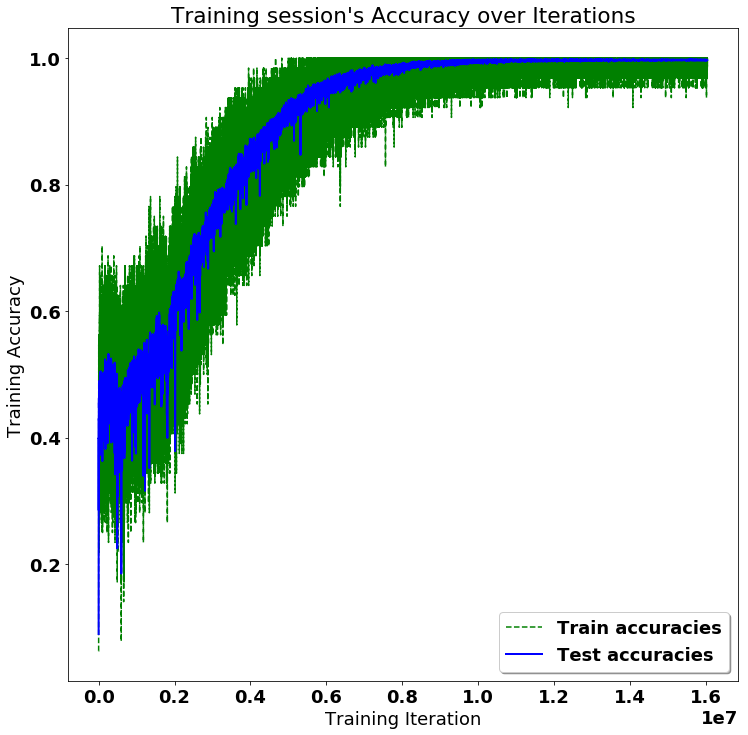

Testing Accuracy: 99.67299103736877%

Precision: 99.67436837146239%
Recall: 99.67298888162198%
f1_score: 99.67272374319377%

Confusion Matrix:
Created using test set of 1529 datapoints, normalised to % of each class in the test dataset


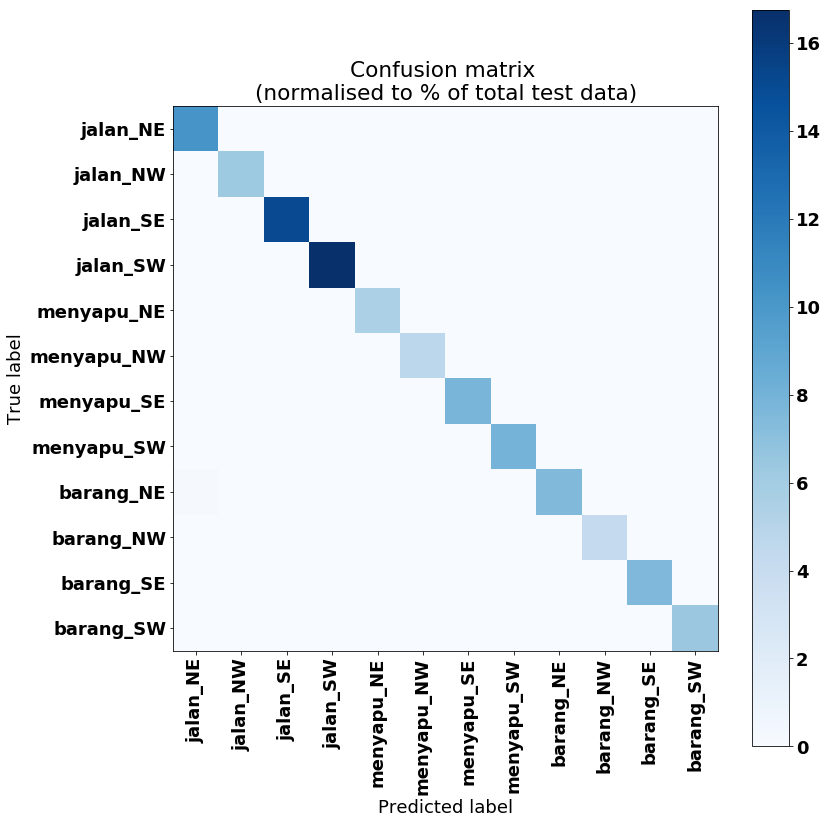

In [17]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [ ]:
#sess.close()
print(test_accuracies)

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [ ]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

## 

In [ ]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
